<p style="font-weight:bold;font-size:200%"> Analysis </p>

- Author: Yichen
- Date: 20220911

In [1]:
import pandas as pd
import threading
import requests
import time
import os
import datetime
import re
import string
import random
import numpy as np
import seaborn as sns;sns.set_theme(color_codes=True)
import warnings
from web3 import Web3
from hexbytes import HexBytes

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from IPython.core.interactiveshell import InteractiveShell
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings("ignore")


RD = '/home/team_defi/02_rdata/'
WD = '/home/team_defi/03_wdata/'
RES = '/home/team_defi/04_result/'
InteractiveShell.ast_node_interactivity = 'all'

# Function

## Chain/DEX Info

In [2]:
def chain_info(chain):
    dexes = {'ethereum':['uniswapv3_ethereum', 'uniswapv2_ethereum', 'sushiswap_ethereum'],
             'binance':['pancake_binance', 'biswap_binance', 'apeswap_binance', 'babyswap_binance', 'jetswap_binance'],
             'avalanche':['traderjoe_avalanche', 'pangolin_avalanche'],
             'fantom':['spookyswap_fantom', 'spiritswap_fantom'],
             'polygon':['sushiswap_polygon', 'apeswap_polygon', 'jetswap_polygon']
            }
    
    dex = dexes[chain]
    return dex

## Token Price/Return

In [3]:
def token_dollar_price_date(contract, chain, date):
    
        contractAddress_lower = contract.lower()
        contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)
        
        priceUSD = 0
        dex_num = 0
        avg_priceUSD = 0

        for dex in chain_info(chain):
            lst = pd.read_csv(f'{WD}/dex_price/list_all/{dex}.csv')
            csv_info = lst.loc[((lst['contractAddress'] == contractAddress_lower)|
                                (lst['contractAddress'] == contractAddress_upper))]
            
            if csv_info['contractAddress'].values[0] == contractAddress_lower:
                contractAddress = contractAddress_lower
            else:
                contractAddress = contractAddress_upper

            status = csv_info['status'].values[0]
            dexn = csv_info['dex'].values[0]

            if status == 0: 
                continue
            elif dexn == 0:
                continue
            else:
                csv = pd.read_csv(f'{WD}dex_price/csv_all/{contractAddress}_{dex}.csv') 
                price_info = csv.loc[(pd.to_datetime(csv['date']) == pd.to_datetime(date))]
                
                if price_info.shape[0] != 0:
                    price = price_info['priceUSD'].values[0]
                    if price != 0:  
                        priceUSD += price
                        dex_num += 1

        if dex_num != 0: 
            return priceUSD/dex_num
        if dex_num == 0:
            return 0

In [4]:
def token_dollar_price(contract, chain, timestamp):
    
        contractAddress_lower = contract.lower()
        contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)

        date = timestamp.strftime('%Y-%m-%d')
        
        priceUSD = 0
        dex_num = 0
        avg_priceUSD = 0

        for dex in chain_info(chain):
            lst = pd.read_csv(f'{WD}/dex_price/list_all/{dex}.csv')
            csv_info = lst.loc[((lst['contractAddress'] == contractAddress_lower)|
                                (lst['contractAddress'] == contractAddress_upper))]
            
            if csv_info['contractAddress'].values[0] == contractAddress_lower:
                contractAddress = contractAddress_lower
            else:
                contractAddress = contractAddress_upper

            status = csv_info['status'].values[0]
            dexn = csv_info['dex'].values[0]

            if status == 0: 
                continue
            elif dexn == 0:
                continue
            else:
                csv = pd.read_csv(f'{WD}dex_price/csv_all/{contractAddress}_{dex}.csv') 
                price_info = csv.loc[(pd.to_datetime(csv['date']) > pd.to_datetime(timestamp) - datetime.timedelta(days=1))&
                                  (pd.to_datetime(csv['date']) < pd.to_datetime(timestamp))]
                
                if price_info.shape[0] != 0:
                    price = price_info['priceUSD'].values[0]
                    if price != 0:  
                        priceUSD += price
                        dex_num += 1

        if dex_num != 0: 
            return priceUSD/dex_num
        if dex_num == 0:
            return 0

In [5]:
def token_return(day, contract, chain, date):

    start_date = (pd.to_datetime(date) + datetime.timedelta(days=day-1)).strftime('%Y-%m-%d')
    end_date = (pd.to_datetime(date) + datetime.timedelta(days=day)).strftime('%Y-%m-%d')

    start_price = token_dollar_price_date(contract=contract, chain=chain, date=start_date)
    end_price = token_dollar_price_date(contract=contract, chain=chain, date=end_date)
    
    if (end_price == 0)|(start_price==0):
        return np.nan
    else:
        return np.log(end_price/start_price)

## Test

In [6]:
# token_dollar_price_date(contract = '0x86c86ffdc0482d8dd918fc657c3fc51c4a1e3e5c',
#                         chain = 'binance',
#                         date = '2022-03-31')
# token_dollar_price(contract = '0x86c86ffdc0482d8dd918fc657c3fc51c4a1e3e5c',
#                    chain = 'binance',
#                    timestamp = pd.to_datetime('2022-03-31 17:48:36'))
# '2022-03-31'
# (pd.to_datetime('2022-03-31') + datetime.timedelta(days=-1)).strftime('%Y-%m-%d')

# day = 1
# start_date = (pd.to_datetime('2022-03-31') + datetime.timedelta(days=day-1)).strftime('%Y-%m-%d')
# end_date = (pd.to_datetime('2022-03-31') + datetime.timedelta(days=day)).strftime('%Y-%m-%d')
# start_date
# end_date

# token_return(day=0,
#              contract='0x86c86ffdc0482d8dd918fc657c3fc51c4a1e3e5c',
#              chain='binance',
#              date='2022-03-31')

# token_dollar_price_date(contract='0x86c86ffdc0482d8dd918fc657c3fc51c4a1e3e5c',
#                         chain='binance',
#                         date='2022-04-01')

# day=1
# contract='0x86c86ffdc0482d8dd918fc657c3fc51c4a1e3e5c'
# chain='binance'
# date='2022-03-31'

# start_date = (pd.to_datetime(date) + datetime.timedelta(days=day-1)).strftime('%Y-%m-%d')
# end_date = (pd.to_datetime(date) + datetime.timedelta(days=day)).strftime('%Y-%m-%d')

# start_price = token_dollar_price_date(contract=contract, chain=chain, date=start_date)
# end_price = token_dollar_price_date(contract=contract, chain=chain, date=end_date)

# if (end_price == 0)|(start_price==0):
#     np.nan
# else:
#     np.log(end_price/start_price)
    
# start_date
# end_date
# start_price
# end_price

# Trading Day Return

## List

In [8]:
# lst = ['root', 'layer_one', 'whale_new']
# dfs = []
# for csv in lst:
#     df = pd.read_csv(f'{RES}/transaction/{csv}.csv')
#     if csv == 'root': 
#         df = df.drop_duplicates(['contractAddress', 'chain']).loc[:, ['contractAddress', 'chain']]
#     else:
#         df = df.drop_duplicates(['insider_contractAddress', 'chain']).loc[:, ['insider_contractAddress', 'chain']]
#         df.rename(columns={'insider_contractAddress':'contractAddress'}, inplace=True)
    
#     df['status'] = -1
#     df.to_csv(f'{WD}token_ret_new/lst/{csv}.csv', index=False)

## Match

In [9]:
for file in lst:    
    dfs = pd.read_csv(f'{WD}token_ret_new/lst/{file}.csv')
    total = dfs.shape[0]
    done = dfs.loc[dfs['status'] != -1].shape[0]

    for idx, row in dfs.loc[dfs['status'] == -1].iterrows():
        try:
            done += 1
            contract = row['contractAddress']
            chain = row['chain']

            contractAddress_lower = contract.lower()
            contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)

            dex_num = 0

            panel = []
            for dex in chain_info(chain):
                lst = pd.read_csv(f'{WD}/dex_price/list_all/{dex}.csv')
                csv_info = lst.loc[((lst['contractAddress'] == contractAddress_lower)|
                                    (lst['contractAddress'] == contractAddress_upper))]

                if csv_info['contractAddress'].values[0] == contractAddress_lower:
                    contractAddress = contractAddress_lower
                else:
                    contractAddress = contractAddress_upper

                status = csv_info['status'].values[0]
                dexn = csv_info['dex'].values[0]

                if status == 0: 
                    continue
                elif dexn == 0:
                    continue
                else:
                    csv = pd.read_csv(f'{WD}dex_price/csv_all/{contractAddress}_{dex}.csv') 
                    csv = csv.loc[:, ['priceUSD', 'date']]
                    panel.append(csv)
                    dex_num += 1

            if dex_num != 0:
                panel = pd.concat(panel)
                panel = panel.loc[panel['priceUSD']!=0]
                if panel.shape[0] == 0:
                    dfs.loc[(dfs['contractAddress'] == contract)&(dfs['chain']==chain), 'status'] = 0
                    dfs.to_csv(f'{WD}token_ret_new/lst/{file}.csv', index=False)
                    print(f'{contract} Zero Price Info, {done}/{total}')
                    continue


                start_date = panel['date'].min()
                end_date = panel['date'].max()
                avg = panel.groupby('date')['priceUSD'].mean().reset_index()
                avg['contractAddress'] = contract
                avg['chain'] = chain
                avg['date'] = pd.to_datetime(avg['date'])
                avg.to_csv(f'{WD}token_ret_new/csv/{contract}_{chain}_{file}_avg.csv', index=False)

                ret = pd.DataFrame({'date':pd.date_range(start = start_date, end=end_date)})
                ret['contractAddress'] = contract
                ret['chain'] = chain

                for day in range(-5, 6):
                    ret[f'ret_{str(day)}'] = np.nan

                for idx_ret, row_ret in ret.iterrows():
                    date = row_ret['date']
                    for day in range(-5, 6):

                        start_date = (pd.to_datetime(date) + datetime.timedelta(days=day-1)).strftime('%Y-%m-%d')
                        end_date = (pd.to_datetime(date) + datetime.timedelta(days=day)).strftime('%Y-%m-%d')

                        start_info = avg.loc[avg['date'] == start_date, 'priceUSD'].values
                        end_info = avg.loc[avg['date'] == end_date, 'priceUSD'].values

                        if ((len(start_info)==0)|(len(end_info)==0)):
                            ret.loc[ret['date'] == date, f'ret_{str(day)}'] = np.nan
                        else:
                            ret.loc[ret['date'] == date, f'ret_{str(day)}'] = np.log(end_info[0]/start_info[0])

                    if len(avg.loc[avg['date'] == date, 'priceUSD'].values) == 0:  
                        ret.loc[ret['date'] == date, 'priceUSD'] = np.nan
                    else:
                        ret.loc[ret['date'] == date, 'priceUSD'] = avg.loc[avg['date'] == date, 'priceUSD'].values[0]
            else:
                dfs.loc[(dfs['contractAddress'] == contract)&(dfs['chain']==chain), 'status'] = 0
                dfs.to_csv(f'{WD}token_ret_new/lst/{file}.csv', index=False)
                print(f'{contract} Zero DEX Info, {done}/{total}')
                continue

            ret.to_csv(f'{WD}token_ret_new/csv/{contract}_{chain}_{file}_ret.csv', index=False)
            dfs.loc[(dfs['contractAddress'] == contract)&(dfs['chain']==chain), 'status'] = 1
            dfs.to_csv(f'{WD}token_ret_new/lst/{file}.csv', index=False)
            print(f'{contract} Done, {done}/{total}')

        except Exception as e:
            print(f'{contract} Error: {e}, {done}/{total}')

0x24e89bdf2f65326b94e36978a7edeac63623dafa Done, 1/936
0x4ffcad848248d4931374336fcaccf263638413ae Zero Price Info, 2/936
0x6339bd92eaa3cb8e629b06449e08b90581a33cea Zero Price Info, 3/936
0x284b19a5fa65f706422c0c86566e407b0e70e537 Zero Price Info, 4/936
0xab68e9f518620cc76d28fa08f42d4f2939d40f02 Zero Price Info, 5/936
0x4691937a7508860f876c9c0a2a617e7d9e945d4b Done, 6/936
0x6c43751fef27c956f7e75d5c345a65df1465f7e0 Zero Price Info, 7/936
0xeb953eda0dc65e3246f43dc8fa13f35623bdd5ed Done, 8/936
0xabe580e7ee158da464b51ee1a83ac0289622e6be Done, 9/936
0xc18360217d8f7ab5e7c516566761ea12ce7f9d72 Done, 10/936
0xc612796023a967d6a6f2203c4bb71e9e58e340ad Zero Price Info, 11/936
0xeff3f1b9400d6d0f1e8805bdde592f61535f5ecd Done, 12/936
0xa71d0588eaf47f12b13cf8ec750430d21df04974 Done, 13/936
0x13948b020f2350b261b8388881e55c12f6719145 Zero Price Info, 14/936
0x2a3bff78b79a009976eea096a51a948a3dc00e34 Done, 15/936
0x3873965e73d9a21f88e645ce40b7db187fde4931 Done, 16/936
0xc944e90c64b2c07662a292be6244bdf05c

## Correction: Nan

In [210]:
# dfs['status'].value_counts()
# dfs.loc[dfs['status'] == -1, 'status'] = 0
# dfs['status'].value_counts()
# dfs.to_csv(f'{WD}token_ret/lst/list.csv', index=False)

## Panel

In [9]:
lst = ['root', 'layer_one', 'whale_new']
final = []
for file in lst:    
    dfs = pd.read_csv(f'{WD}token_ret_new/lst/{file}.csv')
    panel = []
    for idx, row in dfs.loc[dfs['status'] == 1].iterrows():
        contract = row['contractAddress']
        chain = row['chain']
        df = pd.read_csv(f'{WD}token_ret_new/csv/{contract}_{chain}_{file}_ret.csv')
        panel.append(df)
    panel = pd.concat(panel)
    panel['panel'] = file
    final.append(panel)

final = pd.concat(final)
final.to_csv(f'{WD}token_ret_new/lst/panel_raw.csv', index=False)

In [12]:
panel = final.copy()

## Sample Check

In [13]:
panel.sample(3)

date                             contractAddress     chain  \
264  2022-07-30  0x467f4773879a3917ddc2a6befa430c5d8ac22bee   binance   
23   2021-12-23  0x9533F0D097F98C6786ff0596a3e418B397ae995C  ethereum   
229  2022-08-25  0x916c5de09cf63f6602d1e1793fb41f6437814a62  ethereum   

       ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0    ret_1  \
264  0.012728 -0.000962 -0.005260       NaN       NaN -0.005015  0.00461   
23        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
229 -0.048154  0.016478 -0.031195  0.029333  0.100521  0.061922 -0.01537   

        ret_2     ret_3     ret_4   ret_5      priceUSD      panel  
264 -0.002178 -0.032014 -0.001788 -0.0055  2.836870e-03       root  
23        NaN       NaN       NaN     NaN           NaN  whale_new  
229       NaN       NaN       NaN     NaN  9.921860e-11  layer_one

In [255]:
contract = '0x3d3d5ac7590201cec07e7088145d17da535645e3'
chain = 'ethereum'

contractAddress_lower = contract.lower()
contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)

dex_num = 0

panel = []
for dex in chain_info(chain):
    dex
    lst = pd.read_csv(f'{WD}/dex_price/list_all/{dex}.csv')
    csv_info = lst.loc[((lst['contractAddress'] == contractAddress_lower)|
                        (lst['contractAddress'] == contractAddress_upper))]
    if csv_info['contractAddress'].values[0] == contractAddress_lower:
        contractAddress = contractAddress_lower
    else:
        contractAddress = contractAddress_upper

    status = csv_info['status'].values[0]
    dexn = csv_info['dex'].values[0]

    if status == 0: 
        continue
    elif dexn == 0:
        continue
    else:
        csv = pd.read_csv(f'{WD}dex_price/csv_all/{contractAddress}_{dex}.csv') 
        csv = csv.loc[:, ['priceUSD', 'date']]
        panel.append(csv)
        dex_num += 1
panel = pd.concat(panel)
panel = panel.loc[panel['priceUSD']!=0]
panel
panel.loc[panel['date'] == '2022-06-06']

'uniswapv3_ethereum'

'uniswapv2_ethereum'

'sushiswap_ethereum'

priceUSD        date
0   3.271300e-12  2022-04-04
1   2.291400e-12  2022-04-05
2   2.130400e-12  2022-04-06
3   2.598500e-12  2022-04-07
4   2.119100e-12  2022-04-08
5   2.179400e-12  2022-04-09
6   1.986100e-12  2022-04-10
7   1.518300e-12  2022-04-11
8   5.844000e-13  2022-04-12
9   5.187000e-13  2022-04-13
10  3.373000e-13  2022-04-14
11  3.410000e-14  2022-04-15
12  3.400000e-14  2022-04-19
13  3.210000e-14  2022-04-27
14  1.350000e-14  2022-06-25

Empty DataFrame
Columns: [priceUSD, date]
Index: []

# Variables

## List Info

In [228]:
# df = pd.read_csv(f'{WD}token_ret/lst/panel_raw.csv')
# lsts = ['root', 'layer_one', 'whale']

# for lst in lsts:
#     df[lst] = False
#     dfs = pd.read_csv(f'{RES}/transaction/{lst}.csv')
#     if lst == 'root': 
#         dfs = dfs.drop_duplicates(['contractAddress', 'chain']).loc[:, ['contractAddress', 'chain']]
#     else:
#         dfs = dfs.drop_duplicates(['insider_contractAddress', 'chain']).loc[:, ['insider_contractAddress', 'chain']]
#         dfs.rename(columns={'insider_contractAddress':'contractAddress'}, inplace=True)
        
#     for idx, row in dfs.iterrows():
#         contractAddress = row['contractAddress']
#         chain = row['chain']
#         df.loc[(df['contractAddress'] == contractAddress)&(df['chain'] == chain), lst] = True
# df.to_csv(f'{WD}token_ret/lst/panel_list.csv', index=False)

## Insider Trading Info

In [216]:
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_raw.csv')
lsts = ['root', 'layer_one', 'whale_new']
df['insider_trading'] = False
df['insider_buy'] = False
df['insider_sell'] = False

lst = 'root'
done = 0
dfs = pd.read_csv(f'{RES}/transaction/{lst}.csv')
total = dfs.shape[0]
dfs['timestamp'] = pd.to_datetime(dfs['timestamp'])
dfs['date'] = dfs['timestamp'].dt.strftime('%Y-%m-%d')

if lst != 'root': dfs.rename(columns={'insider_contractAddress':'contractAddress'}, inplace=True)

for idx, row in dfs.iterrows():
    done += 1
    chain = row['chain']
    contractAddress = row['contractAddress']
    date = row['date']
    buy = row['buy']
    
    df.loc[(df['contractAddress'] == contractAddress)&(df['date'] == date)&(df['chain'] == chain)&(df['panel'] == lst)]
    
    if buy != 0:
        df.loc[(df['contractAddress'] == contractAddress)&(df['date'] == date)&(df['chain'] == chain)&(df['panel'] == lst), 'insider_trading'] = True

    if buy > 0:
        df.loc[(df['contractAddress'] == contractAddress)&(df['date'] == date)&(df['chain'] == chain)&(df['panel'] == lst), 'insider_buy'] = True

    if buy < 0:
        df.loc[(df['contractAddress'] == contractAddress)&(df['date'] == date)&(df['chain'] == chain)&(df['panel'] == lst), 'insider_sell'] = True
    
    row
    df.loc[(df['contractAddress'] == contractAddress)&(df['date'] == date)&(df['chain'] == chain)&(df['panel'] == lst)]

date                             contractAddress     chain  \
98  2021-11-22  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
98  0.122872 -0.635914 -0.235563  0.077849 -0.580864  0.141341  0.026956   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
98 -0.170134  0.040951 -0.102397 -0.100857   0.00005  root            False   

    insider_buy  insider_sell  
98        False         False

Unnamed: 0                                                                                0
amountUSD                                                                         209.29415
id                 0xe91b835550a1a50b26a0646fa3e1def942a78ea5ce7349529a30700eff08ab11#33823
logIndex                                                                                266
origin                                           0x008295a98dcd428b680bc1db7a743f1d3993b4d4
recipient                                        0x008295a98dcd428b680bc1db7a743f1d3993b4d4
sender                                           0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                      9400732126353364784919992
tick                                                                              -180796.0
timestamp                                                               2021-11-22 02:43:11
token0_name                                                                     

date                             contractAddress     chain  \
98  2021-11-22  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
98  0.122872 -0.635914 -0.235563  0.077849 -0.580864  0.141341  0.026956   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
98 -0.170134  0.040951 -0.102397 -0.100857   0.00005  root             True   

    insider_buy  insider_sell  
98         True         False

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Unnamed: 0                                                                            1
amountUSD                                                                     439.63064
id                 0xd1644c62998cbb5fa03b412ab9c62cd560706e04d2399fd86860fcd10159c499#4
logIndex                                                                            100
origin                                       0x240bf95c3df6fc0206028a073555e251aa67458b
recipient                                    0x240bf95c3df6fc0206028a073555e251aa67458b
sender                                       0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                792833476219372735929747753
tick                                                                           -92095.0
timestamp                                                           2021-09-07 22:15:51
token0_name                                                                       TRIBE
token1_name                     

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Unnamed: 0                                                                              2
amountUSD                                                                      325.499103
id                 0x099a3083fd9a904646021f522bef9d887e6ab07b5171a59ca278c4edce13c43b#546
logIndex                                                                              282
origin                                         0xd42b6798e0ea3c455aa31a15e8e582439154e5cc
recipient                                      0xd42b6798e0ea3c455aa31a15e8e582439154e5cc
sender                                         0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                  108654985078874190449425007
tick                                                                            -131845.0
timestamp                                                             2021-08-17 22:21:44
token0_name                                                                    INCH TOKEN
token1_nam

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Unnamed: 0                                                                              3
amountUSD                                                                       235.66341
id                 0x2f9ee0617b0024f000eda6cef85507776e2b7d2f2f637858764eb2c652f6c40e#619
logIndex                                                                              133
origin                                         0xd42b6798e0ea3c455aa31a15e8e582439154e5cc
recipient                                      0xd42b6798e0ea3c455aa31a15e8e582439154e5cc
sender                                         0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                   80395462705354980614036351
tick                                                                            -137870.0
timestamp                                                             2021-09-11 23:57:32
token0_name                                                                    INCH TOKEN
token1_nam

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Unnamed: 0                                                                              4
amountUSD                                                                     1067.164913
id                 0x8e7be63d557448574c91c0ff62e26339473a08906565e79a034db46ac67dea95#378
logIndex                                                                              369
origin                                         0xd42b6798e0ea3c455aa31a15e8e582439154e5cc
recipient                                      0xd42b6798e0ea3c455aa31a15e8e582439154e5cc
sender                                         0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                  131061056549767839461752140
tick                                                                            -128095.0
timestamp                                                             2021-08-02 14:29:56
token0_name                                                                    INCH TOKEN
token1_nam

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Unnamed: 0                                                                              5
amountUSD                                                                      268.650891
id                 0xeabdfd5a21391f7d7325aa00751e3b292e4df4572920f06ca0d09e1d13a9a34c#416
logIndex                                                                              128
origin                                         0xd42b6798e0ea3c455aa31a15e8e582439154e5cc
recipient                                      0xd42b6798e0ea3c455aa31a15e8e582439154e5cc
sender                                         0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                  107308796249196622807584825
tick                                                                            -132095.0
timestamp                                                             2021-08-03 03:56:35
token0_name                                                                    INCH TOKEN
token1_nam

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Unnamed: 0                                                                            6
amountUSD                                                                    414.223238
id                 0x812454dcafc0ec808ccae7a55357e034d3f1cf5fc515c59c7c4d0c0613c200dc#2
logIndex                                                                            200
origin                                       0x280a4c4d10ef1d29fd591af7074950738ae3e959
recipient                                    0x280a4c4d10ef1d29fd591af7074950738ae3e959
sender                                       0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                            3792438059372273813093946157754
tick                                                                            77372.0
timestamp                                                           2021-11-23 07:08:18
token0_name                                                              BitAstir Token
token1_name                     

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Unnamed: 0                                                                             7
amountUSD                                                                     1110.83162
id                 0x155ae95a7908613b6382f6e069ea0e7177d6ec6f9a9b2545a6700afe61e70f76#85
logIndex                                                                             472
origin                                        0x23036d9ed845234f60cdd25bb627f0460ee60350
recipient                                     0x23036d9ed845234f60cdd25bb627f0460ee60350
sender                                        0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                    196260204683182859001284
tick                                                                           -258181.0
timestamp                                                            2021-12-08 15:26:50
token0_name                                                             The Show Goes On
token1_name          

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Unnamed: 0                                                                             8
amountUSD                                                                     205.269952
id                 0x56b45d69902cb3a450a7ce22c3915bed2880e03221f5635cff15d2ef04451a31#83
logIndex                                                                             274
origin                                        0x23036d9ed845234f60cdd25bb627f0460ee60350
recipient                                     0x23036d9ed845234f60cdd25bb627f0460ee60350
sender                                        0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                    190783142159244881084886
tick                                                                           -258748.0
timestamp                                                            2021-12-05 17:18:48
token0_name                                                             The Show Goes On
token1_name          

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

date                             contractAddress     chain  \
731  2021-10-19  0x4691937a7508860f876c9c0a2a617e7d9e945d4b  ethereum   

       ret_-5    ret_-4    ret_-3    ret_-2   ret_-1     ret_0    ret_1  \
731 -0.026875  0.044996 -0.020994  0.167238  0.10415 -0.028589  0.10175   

        ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
731 -0.152824  0.044986 -0.008516 -0.071363   1.25924  root            False   

     insider_buy  insider_sell  
731        False         False

Unnamed: 0                                                                                9
amountUSD                                                                       1703.641405
id                 0xcabbe3101b1f22dd9a8b1629088266d2129e0386060a3c8fcc8c3df896836490#17031
logIndex                                                                                 25
origin                                           0x1ae77393a77a7bff042077e34bd8ae1d87a0ed7a
recipient                                        0x1ae77393a77a7bff042077e34bd8ae1d87a0ed7a
sender                                           0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                   1471529520297030286369415400
tick                                                                               -79725.0
timestamp                                                               2021-10-19 07:00:14
token0_name                                                                Wootr

date                             contractAddress     chain  \
731  2021-10-19  0x4691937a7508860f876c9c0a2a617e7d9e945d4b  ethereum   

       ret_-5    ret_-4    ret_-3    ret_-2   ret_-1     ret_0    ret_1  \
731 -0.026875  0.044996 -0.020994  0.167238  0.10415 -0.028589  0.10175   

        ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
731 -0.152824  0.044986 -0.008516 -0.071363   1.25924  root             True   

     insider_buy  insider_sell  
731         True         False

date                             contractAddress     chain  \
825  2022-01-21  0x4691937a7508860f876c9c0a2a617e7d9e945d4b  ethereum   

       ret_-5    ret_-4    ret_-3    ret_-2   ret_-1     ret_0     ret_1  \
825 -0.029326 -0.076758 -0.037536 -0.060054  0.01142 -0.184088 -0.190028   

        ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
825  0.124675 -0.043059  0.060943 -0.041531  0.656848  root            False   

     insider_buy  insider_sell  
825        False         False

Unnamed: 0                                                                               10
amountUSD                                                                         977.33244
id                 0xd922a7f36604a7b5f986fa1d83046bef8ee4916147bcf6598d2a30580835433e#22344
logIndex                                                                                577
origin                                           0x1ae77393a77a7bff042077e34bd8ae1d87a0ed7a
recipient                                        0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                           0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                   1290306427197062666453546270
tick                                                                               -82354.0
timestamp                                                               2022-01-21 03:48:27
token0_name                                                                Wootr

date                             contractAddress     chain  \
825  2022-01-21  0x4691937a7508860f876c9c0a2a617e7d9e945d4b  ethereum   

       ret_-5    ret_-4    ret_-3    ret_-2   ret_-1     ret_0     ret_1  \
825 -0.029326 -0.076758 -0.037536 -0.060054  0.01142 -0.184088 -0.190028   

        ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
825  0.124675 -0.043059  0.060943 -0.041531  0.656848  root             True   

     insider_buy  insider_sell  
825        False          True

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Unnamed: 0                                                                           11
amountUSD                                                                    189.476688
id                 0xc66127fc7afde2760be4f037af5492fa41f627f9e0acfe4af3f487a319f9cb2f#2
logIndex                                                                            323
origin                                       0xc70c8952b24ed9e984b426f62f9a0ae291e1bc4c
recipient                                    0xc70c8952b24ed9e984b426f62f9a0ae291e1bc4c
sender                                       0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                               3343479748784339680193660495
tick                                                                           -63310.0
timestamp                                                           2022-01-18 12:48:00
token0_name                                                                   CR7 Token
token1_name                     

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

date                             contractAddress     chain  \
1340  2022-01-08  0xeb953eda0dc65e3246f43dc8fa13f35623bdd5ed  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
1340 -0.062809  0.029785  0.028924  0.104236  0.117383  0.048202  0.294459   

         ret_2     ret_3     ret_4   ret_5  priceUSD panel  insider_trading  \
1340 -0.210222  0.167358  0.069399 -0.1528  0.094976  root            False   

      insider_buy  insider_sell  
1340        False         False

Unnamed: 0                                                                              12
amountUSD                                                                      1062.460031
id                 0xef2c9c35559ffd02259b515083ab881bb05479f3e9457149ec38ff37a5a687db#8385
logIndex                                                                               143
origin                                          0x86488bd26c4299daa47067b4609e96dccd6ff6b0
recipient                                       0x86488bd26c4299daa47067b4609e96dccd6ff6b0
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                              14419630069434308560361050347311
tick                                                                              104085.0
timestamp                                                              2022-01-08 11:26:11
token0_name                                                                  Wrapped Ether

date                             contractAddress     chain  \
1340  2022-01-08  0xeb953eda0dc65e3246f43dc8fa13f35623bdd5ed  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
1340 -0.062809  0.029785  0.028924  0.104236  0.117383  0.048202  0.294459   

         ret_2     ret_3     ret_4   ret_5  priceUSD panel  insider_trading  \
1340 -0.210222  0.167358  0.069399 -0.1528  0.094976  root             True   

      insider_buy  insider_sell  
1340         True         False

date                             contractAddress     chain  \
2105  2022-01-20  0xabe580e7ee158da464b51ee1a83ac0289622e6be  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
2105  0.235915 -0.089456 -0.102031  0.300374  0.008367 -0.249386 -0.138982   

         ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
2105 -0.364217  0.128685 -0.169126  0.074332  17.30025  root            False   

      insider_buy  insider_sell  
2105        False         False

Unnamed: 0                                                                              13
amountUSD                                                                      4783.706645
id                 0xe511ed4a84b90ccf0b9b48cb9dbd585a2db4bf339a3fa1ec4d6e14462ceef74d#5451
logIndex                                                                               218
origin                                          0xa8679849f12bc67474ba2e10e5f545d736601420
recipient                                       0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                  6471266126195890534006125407
tick                                                                              -50102.0
timestamp                                                              2022-01-20 16:03:48
token0_name                                                                       Offshift

date                             contractAddress     chain  \
2105  2022-01-20  0xabe580e7ee158da464b51ee1a83ac0289622e6be  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
2105  0.235915 -0.089456 -0.102031  0.300374  0.008367 -0.249386 -0.138982   

         ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
2105 -0.364217  0.128685 -0.169126  0.074332  17.30025  root             True   

      insider_buy  insider_sell  
2105        False          True

date                             contractAddress     chain  \
2103  2022-01-18  0xabe580e7ee158da464b51ee1a83ac0289622e6be  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
2103 -0.128395  0.105548  0.235915 -0.089456 -0.102031  0.300374  0.008367   

         ret_2     ret_3     ret_4     ret_5   priceUSD panel  \
2103 -0.249386 -0.138982 -0.364217  0.128685  22.015357  root   

      insider_trading  insider_buy  insider_sell  
2103            False        False         False

Unnamed: 0                                                                              14
amountUSD                                                                      5492.867983
id                 0xe53a49f66a750a92f938dedb4feef7ac04ed50dab99d58c29f3c5caf4c2339a7#4926
logIndex                                                                               269
origin                                          0xa8679849f12bc67474ba2e10e5f545d736601420
recipient                                       0xa8679849f12bc67474ba2e10e5f545d736601420
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                  6188811384934317881189990499
tick                                                                              -50995.0
timestamp                                                              2022-01-18 12:51:27
token0_name                                                                       Offshift

date                             contractAddress     chain  \
2103  2022-01-18  0xabe580e7ee158da464b51ee1a83ac0289622e6be  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
2103 -0.128395  0.105548  0.235915 -0.089456 -0.102031  0.300374  0.008367   

         ret_2     ret_3     ret_4     ret_5   priceUSD panel  \
2103 -0.249386 -0.138982 -0.364217  0.128685  22.015357  root   

      insider_trading  insider_buy  insider_sell  
2103             True         True         False

date                             contractAddress     chain  \
2395  2022-01-20  0xc18360217d8f7ab5e7c516566761ea12ce7f9d72  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0    ret_1  \
2395  0.034055  0.031421 -0.126175 -0.042793 -0.044178 -0.042236 -0.18041   

         ret_2     ret_3     ret_4     ret_5   priceUSD panel  \
2395 -0.112608  0.059204 -0.034516  0.010987  21.208685  root   

      insider_trading  insider_buy  insider_sell  
2395            False        False         False

Unnamed: 0                                                                               15
amountUSD                                                                       5754.265993
id                 0xa46667e849afb76ae438bd79da8b988e95edde1edd959923e18a3d966bc05105#63928
logIndex                                                                                196
origin                                           0xac0fd21f4a8d6bde80c01d40a7cf081e874d7476
recipient                                        0xac0fd21f4a8d6bde80c01d40a7cf081e874d7476
sender                                           0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                 935446343470532323623462467835
tick                                                                                49376.0
timestamp                                                               2022-01-20 01:26:03
token0_name                                                                   Wr

date                             contractAddress     chain  \
2395  2022-01-20  0xc18360217d8f7ab5e7c516566761ea12ce7f9d72  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0    ret_1  \
2395  0.034055  0.031421 -0.126175 -0.042793 -0.044178 -0.042236 -0.18041   

         ret_2     ret_3     ret_4     ret_5   priceUSD panel  \
2395 -0.112608  0.059204 -0.034516  0.010987  21.208685  root   

      insider_trading  insider_buy  insider_sell  
2395             True         True         False

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Unnamed: 0                                                                            16
amountUSD                                                                     756.042528
id                 0x5d1681d136fa40fa1783d9a2e0e3657b3fa6378cd99b7945e4429580c653bcbd#21
logIndex                                                                             128
origin                                        0xbc4cd5c4c2827f2e37c4859dfa4b8919ad0f3c98
recipient                                     0xbc4cd5c4c2827f2e37c4859dfa4b8919ad0f3c98
sender                                        0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                            26355418190521211985697746935517
tick                                                                            116147.0
timestamp                                                            2022-04-26 00:36:48
token0_name                                                                Wrapped Ether
token1_name          

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

date                             contractAddress     chain  \
2615  2022-04-15  0xeff3f1b9400d6d0f1e8805bdde592f61535f5ecd  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0   ret_1     ret_2  \
2615     NaN     NaN     NaN     NaN     NaN -0.316179  0.1438  0.995611   

         ret_3     ret_4     ret_5      priceUSD panel  insider_trading  \
2615  0.004585  0.205922 -0.411759  4.684073e-07  root            False   

      insider_buy  insider_sell  
2615        False         False

Unnamed: 0                                                                              17
amountUSD                                                                       498.398098
id                 0x26c86097f223fcfc82c23152aa3b8a6ee7b913ed82ff216353278c936c2e1204#1073
logIndex                                                                                12
origin                                          0x7798f5dd4afaf0f679b81b3fc5c77f564562640b
recipient                                       0x7798f5dd4afaf0f679b81b3fc5c77f564562640b
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                            5517348235853421247694719753795918
tick                                                                              223032.0
timestamp                                                              2022-04-15 00:10:39
token0_name                                                                  Wrapped Ether

date                             contractAddress     chain  \
2615  2022-04-15  0xeff3f1b9400d6d0f1e8805bdde592f61535f5ecd  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0   ret_1     ret_2  \
2615     NaN     NaN     NaN     NaN     NaN -0.316179  0.1438  0.995611   

         ret_3     ret_4     ret_5      priceUSD panel  insider_trading  \
2615  0.004585  0.205922 -0.411759  4.684073e-07  root             True   

      insider_buy  insider_sell  
2615         True         False

date                             contractAddress     chain  \
2742  2022-04-18  0xa71d0588eaf47f12b13cf8ec750430d21df04974  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1    ret_0     ret_1  \
2742  0.005259  0.018672 -0.092066 -0.129683 -0.117801  0.43228  0.147964   

        ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
2742  0.07709 -0.062363 -0.193095  0.019791  2.155221e-07  root   

      insider_trading  insider_buy  insider_sell  
2742            False        False         False

Unnamed: 0                                                                            18
amountUSD                                                                            0.0
id                 0x9d6728373811cc1241cab55b8594e493c6d244e3cd6f8c013be4da454290c0b4#12
logIndex                                                                              13
origin                                        0x7ee0a0c3f3de7dfbcf6cb29c305dd126ef43b1f3
recipient                                     0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                        0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                    687150420823274771846242
tick                                                                           -233118.0
timestamp                                                            2022-04-18 14:42:31
token0_name                                                               Shiba Predator
token1_name          

date                             contractAddress     chain  \
2742  2022-04-18  0xa71d0588eaf47f12b13cf8ec750430d21df04974  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1    ret_0     ret_1  \
2742  0.005259  0.018672 -0.092066 -0.129683 -0.117801  0.43228  0.147964   

        ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
2742  0.07709 -0.062363 -0.193095  0.019791  2.155221e-07  root   

      insider_trading  insider_buy  insider_sell  
2742             True        False          True

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Unnamed: 0                                                                           19
amountUSD                                                                    148.060873
id                 0xf4985ca023463cce8be293e067ae9f7942aac99b494180e9395e8b94a1a39dff#2
logIndex                                                                            245
origin                                       0xece70ee9aaa215e91bed9c96e5b4c5acdc7638b0
recipient                                    0xece70ee9aaa215e91bed9c96e5b4c5acdc7638b0
sender                                       0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                    37944943975722595378103
tick                                                                          -291049.0
timestamp                                                           2022-04-23 12:54:53
token0_name                                                                     Squelch
token1_name                     

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

date                             contractAddress     chain  \
3114  2022-01-07  0x2a3bff78b79a009976eea096a51a948a3dc00e34  ethereum   

        ret_-5   ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
3114  0.000493 -0.02502 -0.019835 -0.169767 -0.047362 -0.132046 -0.029063   

         ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
3114  0.077977 -0.062987  0.010844  0.180461  2.291328  root            False   

      insider_buy  insider_sell  
3114        False         False

Unnamed: 0                                                                              20
amountUSD                                                                      1506.710894
id                 0x95eb44dc5c6cd7b0655c3e12c2ca4fcc94c550be910fa5a74ced0f96a2c4095f#3210
logIndex                                                                               333
origin                                          0x36834cd00b6e7a4e361eeb112d94a07687a4819b
recipient                                       0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                  2111810924408792199603477788
tick                                                                              -72500.0
timestamp                                                              2022-01-07 12:55:38
token0_name                                                                         Wilder

date                             contractAddress     chain  \
3114  2022-01-07  0x2a3bff78b79a009976eea096a51a948a3dc00e34  ethereum   

        ret_-5   ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
3114  0.000493 -0.02502 -0.019835 -0.169767 -0.047362 -0.132046 -0.029063   

         ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
3114  0.077977 -0.062987  0.010844  0.180461  2.291328  root             True   

      insider_buy  insider_sell  
3114        False          True

date                             contractAddress     chain  \
3305  2022-07-17  0x2a3bff78b79a009976eea096a51a948a3dc00e34  ethereum   

        ret_-5   ret_-4    ret_-3    ret_-2   ret_-1     ret_0     ret_1  \
3305  0.027045  0.21803  0.164064 -0.014161  0.13028 -0.110918  0.170032   

         ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
3305  0.108983 -0.148446  0.041365  0.011726  0.309233  root            False   

      insider_buy  insider_sell  
3305        False         False

Unnamed: 0                                                                              21
amountUSD                                                                       222.103439
id                 0xb046b5f59fcfed74a2abf7ccbac659a560ab5abba4f4324c26ddc9c6a1639356#4040
logIndex                                                                               505
origin                                          0x36834cd00b6e7a4e361eeb112d94a07687a4819b
recipient                                       0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                  1219173856557187321698983501
tick                                                                              -83488.0
timestamp                                                              2022-07-17 15:27:49
token0_name                                                                         Wilder

date                             contractAddress     chain  \
3305  2022-07-17  0x2a3bff78b79a009976eea096a51a948a3dc00e34  ethereum   

        ret_-5   ret_-4    ret_-3    ret_-2   ret_-1     ret_0     ret_1  \
3305  0.027045  0.21803  0.164064 -0.014161  0.13028 -0.110918  0.170032   

         ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
3305  0.108983 -0.148446  0.041365  0.011726  0.309233  root             True   

      insider_buy  insider_sell  
3305        False          True

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Unnamed: 0                                                                              22
amountUSD                                                                      1895.652918
id                 0xae74b866658c4a3c27a40ec0ca32fcee824301ed6a11c2d40ba49294c82ff1d4#4062
logIndex                                                                                86
origin                                          0x4bb2bbd5342d2bab9aa49128454181727f53c344
recipient                                       0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                   323690222195199798038480102
tick                                                                             -110012.0
timestamp                                                              2022-01-05 00:42:06
token0_name                                                                       Plethori

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

date                             contractAddress     chain  \
3672  2021-10-25  0xc944e90c64b2c07662a292be6244bdf05cda44a7  ethereum   

        ret_-5    ret_-4   ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
3672  0.114748  0.076204 -0.04039 -0.015839  0.057173  0.093907  0.042652   

         ret_2     ret_3     ret_4    ret_5  priceUSD panel  insider_trading  \
3672 -0.130424 -0.006149  0.039867 -0.07331  1.032186  root            False   

      insider_buy  insider_sell  
3672        False         False

Unnamed: 0                                                                              23
amountUSD                                                                          45000.0
id                 0x5c9d8e0849b1b0bbde068aad27721ee985c10830b7f6102ad3f0a6c355ca2512#4124
logIndex                                                                                25
origin                                          0x60b4f4a50cecef7a3a09270a4585107f7ac8cf16
recipient                                       0x60b4f4a50cecef7a3a09270a4585107f7ac8cf16
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                           76958239093790402422799734670931678
tick                                                                              275742.0
timestamp                                                              2021-10-25 04:53:47
token0_name                                                                       USD Coin

date                             contractAddress     chain  \
3672  2021-10-25  0xc944e90c64b2c07662a292be6244bdf05cda44a7  ethereum   

        ret_-5    ret_-4   ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
3672  0.114748  0.076204 -0.04039 -0.015839  0.057173  0.093907  0.042652   

         ret_2     ret_3     ret_4    ret_5  priceUSD panel  insider_trading  \
3672 -0.130424 -0.006149  0.039867 -0.07331  1.032186  root             True   

      insider_buy  insider_sell  
3672         True         False

date                             contractAddress     chain  \
3672  2021-10-25  0xc944e90c64b2c07662a292be6244bdf05cda44a7  ethereum   

        ret_-5    ret_-4   ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
3672  0.114748  0.076204 -0.04039 -0.015839  0.057173  0.093907  0.042652   

         ret_2     ret_3     ret_4    ret_5  priceUSD panel  insider_trading  \
3672 -0.130424 -0.006149  0.039867 -0.07331  1.032186  root             True   

      insider_buy  insider_sell  
3672         True         False

Unnamed: 0                                                                              24
amountUSD                                                                     14970.961829
id                 0x5c9d8e0849b1b0bbde068aad27721ee985c10830b7f6102ad3f0a6c355ca2512#7991
logIndex                                                                                31
origin                                          0x60b4f4a50cecef7a3a09270a4585107f7ac8cf16
recipient                                       0x60b4f4a50cecef7a3a09270a4585107f7ac8cf16
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                               4976844056189624236081983701512
tick                                                                               82808.0
timestamp                                                              2021-10-25 04:53:47
token0_name                                                                  Wrapped Ether

date                             contractAddress     chain  \
3672  2021-10-25  0xc944e90c64b2c07662a292be6244bdf05cda44a7  ethereum   

        ret_-5    ret_-4   ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
3672  0.114748  0.076204 -0.04039 -0.015839  0.057173  0.093907  0.042652   

         ret_2     ret_3     ret_4    ret_5  priceUSD panel  insider_trading  \
3672 -0.130424 -0.006149  0.039867 -0.07331  1.032186  root             True   

      insider_buy  insider_sell  
3672         True         False

date                             contractAddress     chain  \
98  2021-11-22  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
98  0.122872 -0.635914 -0.235563  0.077849 -0.580864  0.141341  0.026956   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
98 -0.170134  0.040951 -0.102397 -0.100857   0.00005  root             True   

    insider_buy  insider_sell  
98         True         False

Unnamed: 0                                                                               25
amountUSD                                                                       7562.322967
id                 0x26d7f78fd52f48993d467b34cf8d3e02401cde45bd388627423539156498cf1e#33787
logIndex                                                                                589
origin                                           0x096dc50cdcdcd72b39c1835a99f51f0154c2b994
recipient                                        0x096dc50cdcdcd72b39c1835a99f51f0154c2b994
sender                                           0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                      8507979601983770607655828
tick                                                                              -182791.0
timestamp                                                               2021-11-22 02:17:15
token0_name                                                                     

date                             contractAddress     chain  \
98  2021-11-22  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
98  0.122872 -0.635914 -0.235563  0.077849 -0.580864  0.141341  0.026956   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
98 -0.170134  0.040951 -0.102397 -0.100857   0.00005  root             True   

    insider_buy  insider_sell  
98         True         False

date                             contractAddress     chain  \
98  2021-11-22  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
98  0.122872 -0.635914 -0.235563  0.077849 -0.580864  0.141341  0.026956   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
98 -0.170134  0.040951 -0.102397 -0.100857   0.00005  root             True   

    insider_buy  insider_sell  
98         True         False

Unnamed: 0                                                                               26
amountUSD                                                                       3352.758275
id                 0x2c0b995bfa0be0b31e7d01ba462fda85976da344284d1e5e9582b6546eb185d3#33793
logIndex                                                                                468
origin                                           0x096dc50cdcdcd72b39c1835a99f51f0154c2b994
recipient                                        0x096dc50cdcdcd72b39c1835a99f51f0154c2b994
sender                                           0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                      8658921329860525795529063
tick                                                                              -182440.0
timestamp                                                               2021-11-22 02:24:46
token0_name                                                                     

date                             contractAddress     chain  \
98  2021-11-22  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
98  0.122872 -0.635914 -0.235563  0.077849 -0.580864  0.141341  0.026956   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
98 -0.170134  0.040951 -0.102397 -0.100857   0.00005  root             True   

    insider_buy  insider_sell  
98         True         False

date                             contractAddress     chain  \
98  2021-11-22  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
98  0.122872 -0.635914 -0.235563  0.077849 -0.580864  0.141341  0.026956   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
98 -0.170134  0.040951 -0.102397 -0.100857   0.00005  root             True   

    insider_buy  insider_sell  
98         True         False

Unnamed: 0                                                                               27
amountUSD                                                                       4216.133471
id                 0x6e652d3a51857ca78cfd868e614bccd854aaeae3a49654963ae5998f3004964f#33782
logIndex                                                                                302
origin                                           0x096dc50cdcdcd72b39c1835a99f51f0154c2b994
recipient                                        0x096dc50cdcdcd72b39c1835a99f51f0154c2b994
sender                                           0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                      8214758198753843217623571
tick                                                                              -183493.0
timestamp                                                               2021-11-22 02:13:28
token0_name                                                                     

date                             contractAddress     chain  \
98  2021-11-22  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
98  0.122872 -0.635914 -0.235563  0.077849 -0.580864  0.141341  0.026956   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
98 -0.170134  0.040951 -0.102397 -0.100857   0.00005  root             True   

    insider_buy  insider_sell  
98         True         False

date                             contractAddress     chain  \
98  2021-11-22  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
98  0.122872 -0.635914 -0.235563  0.077849 -0.580864  0.141341  0.026956   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
98 -0.170134  0.040951 -0.102397 -0.100857   0.00005  root             True   

    insider_buy  insider_sell  
98         True         False

Unnamed: 0                                                                               28
amountUSD                                                                      13166.313081
id                 0xade936aeefabbded54b7dfd02b34cf83faca3d131c5aa767c0ce4f01eb3b8122#34011
logIndex                                                                                 21
origin                                           0x096dc50cdcdcd72b39c1835a99f51f0154c2b994
recipient                                        0xe592427a0aece92de3edee1f18e0157c05861564
sender                                           0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                      7944297213366174837631690
tick                                                                              -184162.0
timestamp                                                               2021-11-22 22:13:36
token0_name                                                                     

date                             contractAddress     chain  \
98  2021-11-22  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
98  0.122872 -0.635914 -0.235563  0.077849 -0.580864  0.141341  0.026956   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
98 -0.170134  0.040951 -0.102397 -0.100857   0.00005  root             True   

    insider_buy  insider_sell  
98         True          True

date                             contractAddress     chain  \
44  2021-09-29  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
44  0.010376  0.013001  0.295315  0.138399 -0.160653 -0.043072  0.184181   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
44  0.193849  0.000526  0.045613 -0.034993  0.000013  root            False   

    insider_buy  insider_sell  
44        False         False

Unnamed: 0                                                                              29
amountUSD                                                                      1139.036241
id                 0x070fac3f6e55331269210360c2f0c4f17b3de085c6d93052f70d8a80d8be53fa#3624
logIndex                                                                                78
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     5517625317776474543616187
tick                                                                             -191453.0
timestamp                                                              2021-09-29 16:50:38
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
44  2021-09-29  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
44  0.010376  0.013001  0.295315  0.138399 -0.160653 -0.043072  0.184181   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
44  0.193849  0.000526  0.045613 -0.034993  0.000013  root             True   

    insider_buy  insider_sell  
44        False          True

date                             contractAddress     chain  ret_-5  \
4  2021-08-20  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum     NaN   

   ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1     ret_2  \
4     NaN -0.274647 -0.210052  0.139668  0.006935 -0.042418 -0.023771   

      ret_3     ret_4     ret_5  priceUSD panel  insider_trading  insider_buy  \
4  0.053148 -0.004094  0.165303  0.000016  root            False        False   

   insider_sell  
4         False

Unnamed: 0                                                                             30
amountUSD                                                                      719.771991
id                 0x0df250704658224ca55ae95e82bae6e63b5aaefa4db47f5c2f137e3c36529057#708
logIndex                                                                              211
origin                                         0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                      0xe592427a0aece92de3edee1f18e0157c05861564
sender                                         0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                    5535243264563745790662704
tick                                                                            -191389.0
timestamp                                                             2021-08-20 12:05:42
token0_name                                                                    Tiger King
token1_nam

date                             contractAddress     chain  ret_-5  \
4  2021-08-20  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum     NaN   

   ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1     ret_2  \
4     NaN -0.274647 -0.210052  0.139668  0.006935 -0.042418 -0.023771   

      ret_3     ret_4     ret_5  priceUSD panel  insider_trading  insider_buy  \
4  0.053148 -0.004094  0.165303  0.000016  root             True        False   

   insider_sell  
4          True

date                             contractAddress     chain   ret_-5  \
30  2021-09-15  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum -0.15768   

      ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1     ret_2  \
30  0.099619  0.025781 -0.120882  0.012754 -0.079421  0.036412  0.014996   

       ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
30  0.025741 -0.244826 -0.120939  0.000009  root            False   

    insider_buy  insider_sell  
30        False         False

Unnamed: 0                                                                              31
amountUSD                                                                       703.733659
id                 0x1d54f7879aa80526e1dfab27c8197c7254f292faa38072676e12c8ea538a2614#2649
logIndex                                                                               225
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     4248555024574651312009013
tick                                                                             -196680.0
timestamp                                                              2021-09-15 17:19:23
token0_name                                                                     Tiger King

date                             contractAddress     chain   ret_-5  \
30  2021-09-15  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum -0.15768   

      ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1     ret_2  \
30  0.099619  0.025781 -0.120882  0.012754 -0.079421  0.036412  0.014996   

       ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
30  0.025741 -0.244826 -0.120939  0.000009  root             True   

    insider_buy  insider_sell  
30        False          True

date                             contractAddress     chain  \
130  2021-12-24  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

       ret_-5    ret_-4    ret_-3   ret_-2    ret_-1     ret_0     ret_1  \
130 -0.104175 -0.046627 -0.110243 -0.10395  0.044521  0.319259 -0.038158   

        ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
130 -0.067379 -0.048837 -0.161229 -0.184111  0.000019  root            False   

     insider_buy  insider_sell  
130        False         False

Unnamed: 0                                                                               32
amountUSD                                                                      34321.617699
id                 0x1f9c32af5a0bead2e6360e7b8b3d9a924a1d8ed8ec6992e93fe418238d27b313#37551
logIndex                                                                                263
origin                                           0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                        0xe592427a0aece92de3edee1f18e0157c05861564
sender                                           0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                      5770779224352286805301610
tick                                                                              -190556.0
timestamp                                                               2021-12-24 09:53:31
token0_name                                                                     

date                             contractAddress     chain  \
130  2021-12-24  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

       ret_-5    ret_-4    ret_-3   ret_-2    ret_-1     ret_0     ret_1  \
130 -0.104175 -0.046627 -0.110243 -0.10395  0.044521  0.319259 -0.038158   

        ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
130 -0.067379 -0.048837 -0.161229 -0.184111  0.000019  root             True   

     insider_buy  insider_sell  
130        False          True

date                             contractAddress     chain  \
25  2021-09-10  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2   ret_-1    ret_0     ret_1  \
25 -0.112113  0.007844 -0.131906  0.289807 -0.18449 -0.15768  0.099619   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
25  0.025781 -0.120882  0.012754 -0.079421   0.00001  root            False   

    insider_buy  insider_sell  
25        False         False

Unnamed: 0                                                                              33
amountUSD                                                                      6646.914142
id                 0x2cc4e3ad9eadfcb88005d5b896c255dcb29685fca95e2c7d9381f1e047fd3cc9#2398
logIndex                                                                               344
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     4501985768503832453472992
tick                                                                             -195522.0
timestamp                                                              2021-09-10 19:30:09
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
25  2021-09-10  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2   ret_-1    ret_0     ret_1  \
25 -0.112113  0.007844 -0.131906  0.289807 -0.18449 -0.15768  0.099619   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
25  0.025781 -0.120882  0.012754 -0.079421   0.00001  root             True   

    insider_buy  insider_sell  
25        False          True

date                             contractAddress     chain  \
23  2021-09-08  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0    ret_1  \
23  0.057784 -0.027801 -0.112113  0.007844 -0.131906  0.289807 -0.18449   

      ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
23 -0.15768  0.099619  0.025781 -0.120882  0.000014  root            False   

    insider_buy  insider_sell  
23        False         False

Unnamed: 0                                                                              34
amountUSD                                                                      1385.727831
id                 0x3f21100cea0fd501f18ea948557316bd38c5dc5e5dc41d2798a69e38bfbff1bb#2299
logIndex                                                                               185
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     4438205221978086574170769
tick                                                                             -195807.0
timestamp                                                              2021-09-08 10:54:47
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
23  2021-09-08  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0    ret_1  \
23  0.057784 -0.027801 -0.112113  0.007844 -0.131906  0.289807 -0.18449   

      ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
23 -0.15768  0.099619  0.025781 -0.120882  0.000014  root             True   

    insider_buy  insider_sell  
23        False          True

date                             contractAddress     chain   ret_-5  \
30  2021-09-15  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum -0.15768   

      ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1     ret_2  \
30  0.099619  0.025781 -0.120882  0.012754 -0.079421  0.036412  0.014996   

       ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
30  0.025741 -0.244826 -0.120939  0.000009  root             True   

    insider_buy  insider_sell  
30        False          True

Unnamed: 0                                                                              35
amountUSD                                                                       703.733659
id                 0x4e0079ccb55248101dd0e4c5dc26a6c5105a2636974d54f4d95e2bea741cd670#2650
logIndex                                                                               306
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     4241090697850122991199537
tick                                                                             -196716.0
timestamp                                                              2021-09-15 17:23:29
token0_name                                                                     Tiger King

date                             contractAddress     chain   ret_-5  \
30  2021-09-15  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum -0.15768   

      ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1     ret_2  \
30  0.099619  0.025781 -0.120882  0.012754 -0.079421  0.036412  0.014996   

       ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
30  0.025741 -0.244826 -0.120939  0.000009  root             True   

    insider_buy  insider_sell  
30        False          True

date                             contractAddress     chain  \
24  2021-09-09  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1    ret_0    ret_1  \
24 -0.027801 -0.112113  0.007844 -0.131906  0.289807 -0.18449 -0.15768   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
24  0.099619  0.025781 -0.120882  0.012754  0.000012  root            False   

    insider_buy  insider_sell  
24        False         False

Unnamed: 0                                                                              36
amountUSD                                                                       520.558405
id                 0x5ac8c694885e559a85df0d09f80277c37f037909d86c46485405f22769cd87c7#2338
logIndex                                                                               117
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0x83da32c690afc12b08621cdae37268eeda4a964c
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     5026220972729186594375729
tick                                                                             -193319.0
timestamp                                                              2021-09-09 02:42:25
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
24  2021-09-09  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1    ret_0    ret_1  \
24 -0.027801 -0.112113  0.007844 -0.131906  0.289807 -0.18449 -0.15768   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
24  0.099619  0.025781 -0.120882  0.012754  0.000012  root             True   

    insider_buy  insider_sell  
24         True         False

date                             contractAddress     chain  \
46  2021-10-01  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
46  0.295315  0.138399 -0.160653 -0.043072  0.184181  0.193849  0.000526   

       ret_2     ret_3    ret_4     ret_5  priceUSD panel  insider_trading  \
46  0.045613 -0.034993  0.13436 -0.024622  0.000019  root            False   

    insider_buy  insider_sell  
46        False         False

Unnamed: 0                                                                              37
amountUSD                                                                      4730.608489
id                 0x5fed46cc63fe38edc4eefeae44c3477d88a70f95c6d87c82205dcb5aa808f6e9#3725
logIndex                                                                               148
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xdef1c0ded9bec7f1a1670819833240f027b25eff
sender                                          0xdef1c0ded9bec7f1a1670819833240f027b25eff
sqrtPriceX96                                                     5630946944920337054523809
tick                                                                             -191046.0
timestamp                                                              2021-10-01 15:11:57
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
46  2021-10-01  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
46  0.295315  0.138399 -0.160653 -0.043072  0.184181  0.193849  0.000526   

       ret_2     ret_3    ret_4     ret_5  priceUSD panel  insider_trading  \
46  0.045613 -0.034993  0.13436 -0.024622  0.000019  root             True   

    insider_buy  insider_sell  
46        False          True

date                             contractAddress     chain  ret_-5  \
2  2021-08-18  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum     NaN   

   ret_-4  ret_-3  ret_-2    ret_-1     ret_0     ret_1     ret_2     ret_3  \
2     NaN     NaN     NaN -0.274647 -0.210052  0.139668  0.006935 -0.042418   

      ret_4     ret_5  priceUSD panel  insider_trading  insider_buy  \
2 -0.023771  0.053148  0.000014  root            False        False   

   insider_sell  
2         False

Unnamed: 0                                                                            38
amountUSD                                                                    7478.974558
id                 0x63dcb02114a962bbb82a1fb50f1f8ea27aaf4637fcbce5f7219753ed8b580e12#83
logIndex                                                                              48
origin                                        0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                     0xe592427a0aece92de3edee1f18e0157c05861564
sender                                        0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                   5753880147597764424946029
tick                                                                           -190614.0
timestamp                                                            2021-08-18 02:42:10
token0_name                                                                   Tiger King
token1_name          

date                             contractAddress     chain  ret_-5  \
2  2021-08-18  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum     NaN   

   ret_-4  ret_-3  ret_-2    ret_-1     ret_0     ret_1     ret_2     ret_3  \
2     NaN     NaN     NaN -0.274647 -0.210052  0.139668  0.006935 -0.042418   

      ret_4     ret_5  priceUSD panel  insider_trading  insider_buy  \
2 -0.023771  0.053148  0.000014  root             True        False   

   insider_sell  
2          True

date                             contractAddress     chain  \
42  2021-09-27  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
42  0.219702  0.125405  0.010376  0.013001  0.295315  0.138399 -0.160653   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
42 -0.043072  0.184181  0.193849  0.000526  0.000016  root            False   

    insider_buy  insider_sell  
42        False         False

Unnamed: 0                                                                              39
amountUSD                                                                      2511.232884
id                 0x7012a93faebd17eef193889d13344db882cd9bef9b5f73ed2d049de051253170#3511
logIndex                                                                               412
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0x74de5d4fcbf63e00296fd95d33236b9794016631
sender                                          0xdef1c0ded9bec7f1a1670819833240f027b25eff
sqrtPriceX96                                                     5794104352338540224796174
tick                                                                             -190475.0
timestamp                                                              2021-09-27 23:43:45
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
42  2021-09-27  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
42  0.219702  0.125405  0.010376  0.013001  0.295315  0.138399 -0.160653   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
42 -0.043072  0.184181  0.193849  0.000526  0.000016  root             True   

    insider_buy  insider_sell  
42         True         False

date                             contractAddress     chain  \
43  2021-09-28  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
43  0.125405  0.010376  0.013001  0.295315  0.138399 -0.160653 -0.043072   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
43  0.184181  0.193849  0.000526  0.045613  0.000013  root            False   

    insider_buy  insider_sell  
43        False         False

Unnamed: 0                                                                              40
amountUSD                                                                      8549.059992
id                 0x73b0afad48735cbe242b1b0256d16aebfee1519bf58e3ac0d9af435c0a4963c8#3567
logIndex                                                                               236
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     5312058895330450516473576
tick                                                                             -192212.0
timestamp                                                              2021-09-28 19:32:44
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
43  2021-09-28  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
43  0.125405  0.010376  0.013001  0.295315  0.138399 -0.160653 -0.043072   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
43  0.184181  0.193849  0.000526  0.045613  0.000013  root             True   

    insider_buy  insider_sell  
43        False          True

date                             contractAddress     chain  \
25  2021-09-10  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2   ret_-1    ret_0     ret_1  \
25 -0.112113  0.007844 -0.131906  0.289807 -0.18449 -0.15768  0.099619   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
25  0.025781 -0.120882  0.012754 -0.079421   0.00001  root             True   

    insider_buy  insider_sell  
25        False          True

Unnamed: 0                                                                              41
amountUSD                                                                      1658.196904
id                 0x7bc18e314f14b9cd77a6dde188026973439b73e297394b77a6db9644f2ca7118#2399
logIndex                                                                               159
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     4483324951692511651449304
tick                                                                             -195605.0
timestamp                                                              2021-09-10 20:05:42
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
25  2021-09-10  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2   ret_-1    ret_0     ret_1  \
25 -0.112113  0.007844 -0.131906  0.289807 -0.18449 -0.15768  0.099619   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
25  0.025781 -0.120882  0.012754 -0.079421   0.00001  root             True   

    insider_buy  insider_sell  
25        False          True

date                             contractAddress     chain  \
10  2021-08-26  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
10 -0.042418 -0.023771  0.053148 -0.004094  0.165303 -0.113206 -0.045323   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
10 -0.085111 -0.087261  0.015101  0.028988  0.000016  root            False   

    insider_buy  insider_sell  
10        False         False

Unnamed: 0                                                                              42
amountUSD                                                                       227.652225
id                 0x7bdbfb67e0c7c9a3847dedc2feb36ef7c0588884a5639242770f66c5116b902c#1631
logIndex                                                                               141
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     5734940812769966988053647
tick                                                                             -190680.0
timestamp                                                              2021-08-26 18:44:14
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
10  2021-08-26  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
10 -0.042418 -0.023771  0.053148 -0.004094  0.165303 -0.113206 -0.045323   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
10 -0.085111 -0.087261  0.015101  0.028988  0.000016  root             True   

    insider_buy  insider_sell  
10        False          True

date                             contractAddress     chain  \
42  2021-09-27  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
42  0.219702  0.125405  0.010376  0.013001  0.295315  0.138399 -0.160653   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
42 -0.043072  0.184181  0.193849  0.000526  0.000016  root             True   

    insider_buy  insider_sell  
42         True         False

Unnamed: 0                                                                              43
amountUSD                                                                      3044.631617
id                 0x8312ca3efa68d4db777d18b8cc131f08d5b4388d3ce4a4b7581ea6148bed0472#3462
logIndex                                                                               485
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0x83da32c690afc12b08621cdae37268eeda4a964c
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     5504200358258092302254015
tick                                                                             -191502.0
timestamp                                                              2021-09-27 13:20:33
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
42  2021-09-27  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
42  0.219702  0.125405  0.010376  0.013001  0.295315  0.138399 -0.160653   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
42 -0.043072  0.184181  0.193849  0.000526  0.000016  root             True   

    insider_buy  insider_sell  
42         True         False

date                             contractAddress     chain  \
47  2021-10-02  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
47  0.138399 -0.160653 -0.043072  0.184181  0.193849  0.000526  0.045613   

       ret_2    ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
47 -0.034993  0.13436 -0.024622 -0.059803  0.000019  root            False   

    insider_buy  insider_sell  
47        False         False

Unnamed: 0                                                                              44
amountUSD                                                                      2304.053028
id                 0x8b58c8a289d79fcd331659ed805228029835c226857269be010de09264397afd#3818
logIndex                                                                               294
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     5924399126114796304958431
tick                                                                             -190030.0
timestamp                                                              2021-10-02 10:40:15
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
47  2021-10-02  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
47  0.138399 -0.160653 -0.043072  0.184181  0.193849  0.000526  0.045613   

       ret_2    ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
47 -0.034993  0.13436 -0.024622 -0.059803  0.000019  root             True   

    insider_buy  insider_sell  
47        False          True

date                             contractAddress     chain  \
46  2021-10-01  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
46  0.295315  0.138399 -0.160653 -0.043072  0.184181  0.193849  0.000526   

       ret_2     ret_3    ret_4     ret_5  priceUSD panel  insider_trading  \
46  0.045613 -0.034993  0.13436 -0.024622  0.000019  root             True   

    insider_buy  insider_sell  
46        False          True

Unnamed: 0                                                                              45
amountUSD                                                                      1650.212714
id                 0x8c669ebe1adf5d3f0bbbdfcdc29672a0b179f442355a7b7593c904d5f2a58a4d#3736
logIndex                                                                               153
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     5662660004213033303266779
tick                                                                             -190934.0
timestamp                                                              2021-10-01 19:33:39
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
46  2021-10-01  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
46  0.295315  0.138399 -0.160653 -0.043072  0.184181  0.193849  0.000526   

       ret_2     ret_3    ret_4     ret_5  priceUSD panel  insider_trading  \
46  0.045613 -0.034993  0.13436 -0.024622  0.000019  root             True   

    insider_buy  insider_sell  
46        False          True

date                             contractAddress     chain  \
46  2021-10-01  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
46  0.295315  0.138399 -0.160653 -0.043072  0.184181  0.193849  0.000526   

       ret_2     ret_3    ret_4     ret_5  priceUSD panel  insider_trading  \
46  0.045613 -0.034993  0.13436 -0.024622  0.000019  root             True   

    insider_buy  insider_sell  
46        False          True

Unnamed: 0                                                                              46
amountUSD                                                                       6562.46786
id                 0x94356a92bdd623e0426928cece244af1f231c62fc19adc6f0d3c67380c221f8d#3715
logIndex                                                                               259
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xdef1c0ded9bec7f1a1670819833240f027b25eff
sender                                          0xdef1c0ded9bec7f1a1670819833240f027b25eff
sqrtPriceX96                                                     5617342218239714178686826
tick                                                                             -191095.0
timestamp                                                              2021-10-01 13:05:03
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
46  2021-10-01  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
46  0.295315  0.138399 -0.160653 -0.043072  0.184181  0.193849  0.000526   

       ret_2     ret_3    ret_4     ret_5  priceUSD panel  insider_trading  \
46  0.045613 -0.034993  0.13436 -0.024622  0.000019  root             True   

    insider_buy  insider_sell  
46        False          True

date                             contractAddress     chain  \
43  2021-09-28  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
43  0.125405  0.010376  0.013001  0.295315  0.138399 -0.160653 -0.043072   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
43  0.184181  0.193849  0.000526  0.045613  0.000013  root             True   

    insider_buy  insider_sell  
43        False          True

Unnamed: 0                                                                              47
amountUSD                                                                      8583.898364
id                 0x99fc0b0d8f603c567916a98f2de76b21755862bec68610c42dc4ac3df8fba666#3553
logIndex                                                                               131
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     5530254995648037876762616
tick                                                                             -191407.0
timestamp                                                              2021-09-28 16:39:17
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
43  2021-09-28  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
43  0.125405  0.010376  0.013001  0.295315  0.138399 -0.160653 -0.043072   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
43  0.184181  0.193849  0.000526  0.045613  0.000013  root             True   

    insider_buy  insider_sell  
43        False          True

date                             contractAddress     chain   ret_-5  \
30  2021-09-15  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum -0.15768   

      ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1     ret_2  \
30  0.099619  0.025781 -0.120882  0.012754 -0.079421  0.036412  0.014996   

       ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
30  0.025741 -0.244826 -0.120939  0.000009  root             True   

    insider_buy  insider_sell  
30        False          True

Unnamed: 0                                                                              48
amountUSD                                                                      9728.466104
id                 0xb4afc5ee23b4074f15ca770eefbb2e67d82f9fa3cf41773dda7d8d3dec625ad3#2644
logIndex                                                                               314
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     4246589464921697458111769
tick                                                                             -196690.0
timestamp                                                              2021-09-15 15:36:10
token0_name                                                                     Tiger King

date                             contractAddress     chain   ret_-5  \
30  2021-09-15  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum -0.15768   

      ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1     ret_2  \
30  0.099619  0.025781 -0.120882  0.012754 -0.079421  0.036412  0.014996   

       ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
30  0.025741 -0.244826 -0.120939  0.000009  root             True   

    insider_buy  insider_sell  
30        False          True

date                             contractAddress     chain  \
44  2021-09-29  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
44  0.010376  0.013001  0.295315  0.138399 -0.160653 -0.043072  0.184181   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
44  0.193849  0.000526  0.045613 -0.034993  0.000013  root             True   

    insider_buy  insider_sell  
44        False          True

Unnamed: 0                                                                              49
amountUSD                                                                      1421.447737
id                 0xb6c47c63d47c02d19aa8cf3ea12266c502f89a48b8ce86b68ea7b78ebf548018#3590
logIndex                                                                               305
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     5485095396619061434607648
tick                                                                             -191571.0
timestamp                                                              2021-09-29 01:50:24
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
44  2021-09-29  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
44  0.010376  0.013001  0.295315  0.138399 -0.160653 -0.043072  0.184181   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
44  0.193849  0.000526  0.045613 -0.034993  0.000013  root             True   

    insider_buy  insider_sell  
44        False          True

date                             contractAddress     chain  \
47  2021-10-02  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
47  0.138399 -0.160653 -0.043072  0.184181  0.193849  0.000526  0.045613   

       ret_2    ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
47 -0.034993  0.13436 -0.024622 -0.059803  0.000019  root             True   

    insider_buy  insider_sell  
47        False          True

Unnamed: 0                                                                              50
amountUSD                                                                      2324.461159
id                 0xb792c4bac243da66932577efc375a9aab90964db41039fab575e8a7bb67cb4f0#3817
logIndex                                                                               288
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xdef1c0ded9bec7f1a1670819833240f027b25eff
sender                                          0xdef1c0ded9bec7f1a1670819833240f027b25eff
sqrtPriceX96                                                     5950521097993994205563007
tick                                                                             -189942.0
timestamp                                                              2021-10-02 10:40:15
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
47  2021-10-02  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
47  0.138399 -0.160653 -0.043072  0.184181  0.193849  0.000526  0.045613   

       ret_2    ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
47 -0.034993  0.13436 -0.024622 -0.059803  0.000019  root             True   

    insider_buy  insider_sell  
47        False          True

date                             contractAddress     chain  \
23  2021-09-08  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0    ret_1  \
23  0.057784 -0.027801 -0.112113  0.007844 -0.131906  0.289807 -0.18449   

      ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
23 -0.15768  0.099619  0.025781 -0.120882  0.000014  root             True   

    insider_buy  insider_sell  
23        False          True

Unnamed: 0                                                                              51
amountUSD                                                                      2106.438052
id                 0xc187c9c80ba479fbe70aa1aa59d928617c13ce8bf586177ca6de22b1e359ce77#2300
logIndex                                                                               574
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     4414974526391597462002189
tick                                                                             -195912.0
timestamp                                                              2021-09-08 11:08:15
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
23  2021-09-08  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0    ret_1  \
23  0.057784 -0.027801 -0.112113  0.007844 -0.131906  0.289807 -0.18449   

      ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
23 -0.15768  0.099619  0.025781 -0.120882  0.000014  root             True   

    insider_buy  insider_sell  
23        False          True

date                             contractAddress     chain  \
42  2021-09-27  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
42  0.219702  0.125405  0.010376  0.013001  0.295315  0.138399 -0.160653   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
42 -0.043072  0.184181  0.193849  0.000526  0.000016  root             True   

    insider_buy  insider_sell  
42         True         False

Unnamed: 0                                                                              52
amountUSD                                                                      3097.303782
id                 0xc3c40c3f0f09aee4af119ed476d5fe2dd7d3fa2697c5a41c837e2743fcd84631#3444
logIndex                                                                               105
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     5531076165206168129606098
tick                                                                             -191404.0
timestamp                                                              2021-09-27 08:13:34
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
42  2021-09-27  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
42  0.219702  0.125405  0.010376  0.013001  0.295315  0.138399 -0.160653   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
42 -0.043072  0.184181  0.193849  0.000526  0.000016  root             True   

    insider_buy  insider_sell  
42         True          True

date                             contractAddress     chain  \
47  2021-10-02  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
47  0.138399 -0.160653 -0.043072  0.184181  0.193849  0.000526  0.045613   

       ret_2    ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
47 -0.034993  0.13436 -0.024622 -0.059803  0.000019  root             True   

    insider_buy  insider_sell  
47        False          True

Unnamed: 0                                                                              53
amountUSD                                                                      2283.912488
id                 0xc827a6c598e52c03ccddad7fbe7ee5d4c818ab76c1a52b5e22e7a44e25faf8c8#3819
logIndex                                                                               300
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     5898505495599430955807327
tick                                                                             -190118.0
timestamp                                                              2021-10-02 10:40:15
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
47  2021-10-02  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
47  0.138399 -0.160653 -0.043072  0.184181  0.193849  0.000526  0.045613   

       ret_2    ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
47 -0.034993  0.13436 -0.024622 -0.059803  0.000019  root             True   

    insider_buy  insider_sell  
47        False          True

date                             contractAddress     chain    ret_-5  \
8  2021-08-24  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum  0.139668   

     ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1     ret_2  \
8  0.006935 -0.042418 -0.023771  0.053148 -0.004094  0.165303 -0.113206   

      ret_3     ret_4     ret_5  priceUSD panel  insider_trading  insider_buy  \
8 -0.045323 -0.085111 -0.087261  0.000015  root            False        False   

   insider_sell  
8         False

Unnamed: 0                                                                              54
amountUSD                                                                        66.975292
id                 0xccbd43225be83e4a41de44e32e66b56723d3ba05971948c2d1e85b665a0b879c#1289
logIndex                                                                               237
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0x83da32c690afc12b08621cdae37268eeda4a964c
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     5565952282837821573163107
tick                                                                             -191278.0
timestamp                                                              2021-08-24 17:55:00
token0_name                                                                     Tiger King

date                             contractAddress     chain    ret_-5  \
8  2021-08-24  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum  0.139668   

     ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1     ret_2  \
8  0.006935 -0.042418 -0.023771  0.053148 -0.004094  0.165303 -0.113206   

      ret_3     ret_4     ret_5  priceUSD panel  insider_trading  insider_buy  \
8 -0.045323 -0.085111 -0.087261  0.000015  root             True         True   

   insider_sell  
8         False

date                             contractAddress     chain  \
24  2021-09-09  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1    ret_0    ret_1  \
24 -0.027801 -0.112113  0.007844 -0.131906  0.289807 -0.18449 -0.15768   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
24  0.099619  0.025781 -0.120882  0.012754  0.000012  root             True   

    insider_buy  insider_sell  
24         True         False

Unnamed: 0                                                                              55
amountUSD                                                                       976.955856
id                 0xdd4c3295ec5bdb4a7e910d4ee2d3dae150dd08924e8d0cbd0a6b0e0b9ee74e53#2337
logIndex                                                                               207
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     5020639522420920542490444
tick                                                                             -193341.0
timestamp                                                              2021-09-09 01:37:44
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
24  2021-09-09  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1    ret_0    ret_1  \
24 -0.027801 -0.112113  0.007844 -0.131906  0.289807 -0.18449 -0.15768   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
24  0.099619  0.025781 -0.120882  0.012754  0.000012  root             True   

    insider_buy  insider_sell  
24         True          True

date                             contractAddress     chain  \
45  2021-09-30  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
45  0.013001  0.295315  0.138399 -0.160653 -0.043072  0.184181  0.193849   

       ret_2     ret_3     ret_4    ret_5  priceUSD panel  insider_trading  \
45  0.000526  0.045613 -0.034993  0.13436  0.000015  root            False   

    insider_buy  insider_sell  
45        False         False

Unnamed: 0                                                                              56
amountUSD                                                                      1048.203926
id                 0xec4fc0359d5ccd1943399208c034c85542fd2d6d6270b51a8fac19a37a269d4d#3672
logIndex                                                                               283
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0xe592427a0aece92de3edee1f18e0157c05861564
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     5536885652549518777219545
tick                                                                             -191383.0
timestamp                                                              2021-09-30 17:15:14
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
45  2021-09-30  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
45  0.013001  0.295315  0.138399 -0.160653 -0.043072  0.184181  0.193849   

       ret_2     ret_3     ret_4    ret_5  priceUSD panel  insider_trading  \
45  0.000526  0.045613 -0.034993  0.13436  0.000015  root             True   

    insider_buy  insider_sell  
45        False          True

date                             contractAddress     chain  ret_-5  \
2  2021-08-18  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum     NaN   

   ret_-4  ret_-3  ret_-2    ret_-1     ret_0     ret_1     ret_2     ret_3  \
2     NaN     NaN     NaN -0.274647 -0.210052  0.139668  0.006935 -0.042418   

      ret_4     ret_5  priceUSD panel  insider_trading  insider_buy  \
2 -0.023771  0.053148  0.000014  root             True        False   

   insider_sell  
2          True

Unnamed: 0                                                                             57
amountUSD                                                                     5565.306641
id                 0xf5ad728326082b1d4befa92a5338c33284b1ffa1916f2b1a10fc3112a1d96cd9#241
logIndex                                                                                6
origin                                         0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                      0x83da32c690afc12b08621cdae37268eeda4a964c
sender                                         0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                    5435112145683137373079717
tick                                                                            -191754.0
timestamp                                                             2021-08-18 12:05:35
token0_name                                                                    Tiger King
token1_nam

date                             contractAddress     chain  ret_-5  \
2  2021-08-18  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum     NaN   

   ret_-4  ret_-3  ret_-2    ret_-1     ret_0     ret_1     ret_2     ret_3  \
2     NaN     NaN     NaN -0.274647 -0.210052  0.139668  0.006935 -0.042418   

      ret_4     ret_5  priceUSD panel  insider_trading  insider_buy  \
2 -0.023771  0.053148  0.000014  root             True         True   

   insider_sell  
2          True

date                             contractAddress     chain  \
31  2021-09-16  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
31  0.099619  0.025781 -0.120882  0.012754 -0.079421  0.036412  0.014996   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
31  0.025741 -0.244826 -0.120939  0.001925   0.00001  root            False   

    insider_buy  insider_sell  
31        False         False

Unnamed: 0                                                                              58
amountUSD                                                                      1208.937003
id                 0xf7561c6a39f5d7cdcb629acacf4c835930826d02f5fd74beb761a2447464c3d8#2686
logIndex                                                                               354
origin                                          0x83da32c690afc12b08621cdae37268eeda4a964c
recipient                                       0x83da32c690afc12b08621cdae37268eeda4a964c
sender                                          0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                     4088657257769198631564567
tick                                                                             -197448.0
timestamp                                                              2021-09-16 14:23:53
token0_name                                                                     Tiger King

date                             contractAddress     chain  \
31  2021-09-16  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
31  0.099619  0.025781 -0.120882  0.012754 -0.079421  0.036412  0.014996   

       ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
31  0.025741 -0.244826 -0.120939  0.001925   0.00001  root             True   

    insider_buy  insider_sell  
31         True         False

date                             contractAddress     chain  \
2324  2021-11-10  0xc18360217d8f7ab5e7c516566761ea12ce7f9d72  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0     ret_1     ret_2  \
2324     NaN     NaN     NaN     NaN     NaN  0.568014 -0.306262 -0.018925   

         ret_3     ret_4     ret_5   priceUSD panel  insider_trading  \
2324  0.027143 -0.001968  0.020266  74.542847  root            False   

      insider_buy  insider_sell  
2324        False         False

Unnamed: 0                                                                               59
amountUSD                                                                       5509.374063
id                 0x5c096f5305d4e6ace0c9c49eea8cc8a5eabcc8a0998a2251e5b61902de42ddd8#13095
logIndex                                                                                404
origin                                           0x7c81c04f09048853a1c1ea9c44a9ae1991547b8e
recipient                                        0xe592427a0aece92de3edee1f18e0157c05861564
sender                                           0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                 821844794666741701096018662766
tick                                                                                46786.0
timestamp                                                               2021-11-10 02:56:15
token0_name                                                                   Wr

date                             contractAddress     chain  \
2324  2021-11-10  0xc18360217d8f7ab5e7c516566761ea12ce7f9d72  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0     ret_1     ret_2  \
2324     NaN     NaN     NaN     NaN     NaN  0.568014 -0.306262 -0.018925   

         ret_3     ret_4     ret_5   priceUSD panel  insider_trading  \
2324  0.027143 -0.001968  0.020266  74.542847  root             True   

      insider_buy  insider_sell  
2324        False          True

date                             contractAddress     chain  \
2443  2022-03-09  0xc18360217d8f7ab5e7c516566761ea12ce7f9d72  ethereum   

       ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
2443  0.07079 -0.027133 -0.042677 -0.030842  0.000226  0.066769 -0.043426   

         ret_2     ret_3     ret_4     ret_5   priceUSD panel  \
2443 -0.021608 -0.016564 -0.070455  0.061987  14.714825  root   

      insider_trading  insider_buy  insider_sell  
2443            False        False         False

Unnamed: 0                                                                               60
amountUSD                                                                        2703.10176
id                 0x5d9c6ad3ae5e0970d6c259ecc30c40044162f256e0e2a73de0ab38c4884c6ea1#71398
logIndex                                                                                347
origin                                           0x7c81c04f09048853a1c1ea9c44a9ae1991547b8e
recipient                                        0x11b815efb8f581194ae79006d24e0d814b7697f6
sender                                           0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                1088279496639123189964494286237
tick                                                                                52403.0
timestamp                                                               2022-03-09 15:32:51
token0_name                                                                   Wr

date                             contractAddress     chain  \
2443  2022-03-09  0xc18360217d8f7ab5e7c516566761ea12ce7f9d72  ethereum   

       ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
2443  0.07079 -0.027133 -0.042677 -0.030842  0.000226  0.066769 -0.043426   

         ret_2     ret_3     ret_4     ret_5   priceUSD panel  \
2443 -0.021608 -0.016564 -0.070455  0.061987  14.714825  root   

      insider_trading  insider_buy  insider_sell  
2443             True        False          True

date                             contractAddress     chain  \
2488  2022-04-23  0xc18360217d8f7ab5e7c516566761ea12ce7f9d72  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0    ret_1  \
2488  0.022314  0.035473 -0.005145 -0.019599 -0.016993 -0.014311  0.09661   

         ret_2     ret_3     ret_4     ret_5   priceUSD panel  \
2488  0.010778 -0.084466  0.257334  0.020086  13.950549  root   

      insider_trading  insider_buy  insider_sell  
2488            False        False         False

Unnamed: 0                                                                               61
amountUSD                                                                       9454.056954
id                 0xb073d1ebb686fa7267dd5012c02eab5e140dc918aa28a369776052ad5c3c39c5#77570
logIndex                                                                                334
origin                                           0x7c81c04f09048853a1c1ea9c44a9ae1991547b8e
recipient                                        0xe592427a0aece92de3edee1f18e0157c05861564
sender                                           0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                1150384614600336994115512495050
tick                                                                                53513.0
timestamp                                                               2022-04-23 17:28:14
token0_name                                                                   Wr

date                             contractAddress     chain  \
2488  2022-04-23  0xc18360217d8f7ab5e7c516566761ea12ce7f9d72  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0    ret_1  \
2488  0.022314  0.035473 -0.005145 -0.019599 -0.016993 -0.014311  0.09661   

         ret_2     ret_3     ret_4     ret_5   priceUSD panel  \
2488  0.010778 -0.084466  0.257334  0.020086  13.950549  root   

      insider_trading  insider_buy  insider_sell  
2488             True        False          True

date                             contractAddress     chain  \
2372  2021-12-28  0xc18360217d8f7ab5e7c516566761ea12ce7f9d72  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1   ret_0    ret_1  \
2372  0.089236 -0.084691  0.023997 -0.018324 -0.023092 -0.1055 -0.05698   

         ret_2     ret_3     ret_4     ret_5   priceUSD panel  \
2372  0.024877 -0.002265  0.025518  0.029283  39.955518  root   

      insider_trading  insider_buy  insider_sell  
2372            False        False         False

Unnamed: 0                                                                               62
amountUSD                                                                      18025.216404
id                 0xd75e2fe5eb14535983f9353186acd86d0e041fc56251862676c8d618ce1c89c5#58472
logIndex                                                                                243
origin                                           0x7c81c04f09048853a1c1ea9c44a9ae1991547b8e
recipient                                        0x11b815efb8f581194ae79006d24e0d814b7697f6
sender                                           0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                                 761791171539048696226909940288
tick                                                                                45269.0
timestamp                                                               2021-12-28 12:12:22
token0_name                                                                   Wr

date                             contractAddress     chain  \
2372  2021-12-28  0xc18360217d8f7ab5e7c516566761ea12ce7f9d72  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1   ret_0    ret_1  \
2372  0.089236 -0.084691  0.023997 -0.018324 -0.023092 -0.1055 -0.05698   

         ret_2     ret_3     ret_4     ret_5   priceUSD panel  \
2372  0.024877 -0.002265  0.025518  0.029283  39.955518  root   

      insider_trading  insider_buy  insider_sell  
2372             True        False          True

date                             contractAddress     chain  \
3995  2021-12-21  0x8c6fa66c21ae3fc435790e451946a9ea82e6e523  ethereum   

        ret_-5    ret_-4   ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
3995 -0.024349  0.533801  0.37984 -0.214685  0.133885 -0.216408 -0.069856   

         ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
3995 -0.473966  0.374125 -0.134181 -0.029515  0.022065  root            False   

      insider_buy  insider_sell  
3995        False         False

Unnamed: 0                                                                             63
amountUSD                                                                     1407.075187
id                 0xfcd34391b38dc05c42310630019526ad5e2e3b70e7aff90635ee9b16ce5f274a#106
logIndex                                                                               12
origin                                         0x2873423f30fafb91e65eef97920f41847e95bed1
recipient                                      0x2873423f30fafb91e65eef97920f41847e95bed1
sender                                         0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                  216964582539637595134663023
tick                                                                            -118013.0
timestamp                                                             2021-12-21 00:19:31
token0_name                                                                    MetaFabric
token1_nam

date                             contractAddress     chain  \
3995  2021-12-21  0x8c6fa66c21ae3fc435790e451946a9ea82e6e523  ethereum   

        ret_-5    ret_-4   ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
3995 -0.024349  0.533801  0.37984 -0.214685  0.133885 -0.216408 -0.069856   

         ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
3995 -0.473966  0.374125 -0.134181 -0.029515  0.022065  root             True   

      insider_buy  insider_sell  
3995         True         False

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278            False        False         False

Unnamed: 0                                                                              64
amountUSD                                                                      1580.501869
id                 0x02fa96b14ea15fe695a5b72f247e0365163a78fe3eee006746c3ab508a1e65f3#9823
logIndex                                                                                16
origin                                          0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                       0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                     1392046844670600163487795
tick                                                                             -218998.0
timestamp                                                              2022-03-14 14:12:37
token0_name                                                                         random

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True        False          True

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True        False          True

Unnamed: 0                                                                               65
amountUSD                                                                        658.611853
id                 0x08a4581a8e355b173435dc826e5d0640dbedc795c39bc5c02e5b07a5635b83d5#10002
logIndex                                                                                642
origin                                           0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                        0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                           0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                      1418099200932522076027089
tick                                                                              -218627.0
timestamp                                                               2022-03-14 17:33:05
token0_name                                                                     

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True         True          True

date                             contractAddress     chain  \
4256  2022-02-20  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0  ret_1  ret_2  \
4256     NaN -0.010187 -0.151616 -0.058075  0.086354 -0.130814    NaN    NaN   

      ret_3  ret_4  ret_5      priceUSD panel  insider_trading  insider_buy  \
4256    NaN    NaN    NaN  5.311555e-08  root            False        False   

      insider_sell  
4256         False

Unnamed: 0                                                                              66
amountUSD                                                                        205.68597
id                 0x1f36f11cd2055dfbaa8fdca2fd653c32c0f62dd8be5c29dcca4e1f0a4ce25bb7#2873
logIndex                                                                               129
origin                                          0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                       0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                      351299421318650297735835
tick                                                                             -246537.0
timestamp                                                              2022-02-20 13:06:05
token0_name                                                                         random

date                             contractAddress     chain  \
4256  2022-02-20  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0  ret_1  ret_2  \
4256     NaN -0.010187 -0.151616 -0.058075  0.086354 -0.130814    NaN    NaN   

      ret_3  ret_4  ret_5      priceUSD panel  insider_trading  insider_buy  \
4256    NaN    NaN    NaN  5.311555e-08  root             True        False   

      insider_sell  
4256          True

date                             contractAddress     chain  \
4289  2022-03-25  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

       ret_-5  ret_-4   ret_-3   ret_-2    ret_-1    ret_0     ret_1  \
4289 -0.27941  0.1714  0.00323  0.30511  0.350508 -0.34662  0.311483   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4289 -0.138557 -0.197859 -0.285956 -0.007425  4.536395e-07  root   

      insider_trading  insider_buy  insider_sell  
4289            False        False         False

Unnamed: 0                                                                               67
amountUSD                                                                        976.593148
id                 0x23a773e5bc6b026eca89477d9601673317948f40258318b809a3e51cd20f5d70#13933
logIndex                                                                                213
origin                                           0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                        0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                           0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                       993898725866646652910466
tick                                                                              -225736.0
timestamp                                                               2022-03-25 18:34:28
token0_name                                                                     

date                             contractAddress     chain  \
4289  2022-03-25  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

       ret_-5  ret_-4   ret_-3   ret_-2    ret_-1    ret_0     ret_1  \
4289 -0.27941  0.1714  0.00323  0.30511  0.350508 -0.34662  0.311483   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4289 -0.138557 -0.197859 -0.285956 -0.007425  4.536395e-07  root   

      insider_trading  insider_buy  insider_sell  
4289             True        False          True

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True         True          True

Unnamed: 0                                                                              68
amountUSD                                                                      1669.451468
id                 0x2d41d8b1a43d19e6ae9458c9c8e3d838eb7d90f88d44df708d8a5d112479cac1#9488
logIndex                                                                               263
origin                                          0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                       0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                     1413515787581976677589963
tick                                                                             -218692.0
timestamp                                                              2022-03-14 10:08:08
token0_name                                                                         random

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True         True          True

date                             contractAddress     chain  \
4275  2022-03-11  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0     ret_1     ret_2  \
4275     NaN     NaN     NaN     NaN     NaN  0.533236  0.936677  0.238857   

         ret_3     ret_4     ret_5      priceUSD panel  insider_trading  \
4275 -0.253513 -0.210522 -0.210473  2.667055e-07  root            False   

      insider_buy  insider_sell  
4275        False         False

Unnamed: 0                                                                              69
amountUSD                                                                       629.698723
id                 0x2f3228c4e2cbda114d96d6808795b2203f4420eab03c16a6f85d5067572d9002#5082
logIndex                                                                                37
origin                                          0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                       0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                      874330551931639882066268
tick                                                                             -228300.0
timestamp                                                              2022-03-11 18:57:04
token0_name                                                                         random

date                             contractAddress     chain  \
4275  2022-03-11  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0     ret_1     ret_2  \
4275     NaN     NaN     NaN     NaN     NaN  0.533236  0.936677  0.238857   

         ret_3     ret_4     ret_5      priceUSD panel  insider_trading  \
4275 -0.253513 -0.210522 -0.210473  2.667055e-07  root             True   

      insider_buy  insider_sell  
4275         True         False

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True         True          True

Unnamed: 0                                                                              70
amountUSD                                                                      1410.338573
id                 0x3a5e8e191a26557565c4c3af2baacca954c48646abcf5ec8db94c7aaa6fac155#9956
logIndex                                                                                40
origin                                          0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                       0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                     1388578000981376738265638
tick                                                                             -219048.0
timestamp                                                              2022-03-14 16:37:24
token0_name                                                                         random

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True         True          True

date                             contractAddress     chain  \
4275  2022-03-11  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0     ret_1     ret_2  \
4275     NaN     NaN     NaN     NaN     NaN  0.533236  0.936677  0.238857   

         ret_3     ret_4     ret_5      priceUSD panel  insider_trading  \
4275 -0.253513 -0.210522 -0.210473  2.667055e-07  root             True   

      insider_buy  insider_sell  
4275         True         False

Unnamed: 0                                                                              71
amountUSD                                                                       539.397387
id                 0x3d4e4844b14de28fae4c0b4ad56142c766f681bca7ee38ea127d98a3399eecac#3980
logIndex                                                                               331
origin                                          0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                       0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                      664186073098765728855242
tick                                                                             -233798.0
timestamp                                                              2022-03-11 02:20:35
token0_name                                                                         random

date                             contractAddress     chain  \
4275  2022-03-11  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0     ret_1     ret_2  \
4275     NaN     NaN     NaN     NaN     NaN  0.533236  0.936677  0.238857   

         ret_3     ret_4     ret_5      priceUSD panel  insider_trading  \
4275 -0.253513 -0.210522 -0.210473  2.667055e-07  root             True   

      insider_buy  insider_sell  
4275         True         False

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Unnamed: 0                                                                             72
amountUSD                                                                      356.775205
id                 0x482b4f02ae67fce262b8dc3aa74fd8199f65614d22dc96a678c0795e573b8635#276
logIndex                                                                              264
origin                                         0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                      0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                         0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                     736119032771774954989215
tick                                                                            -231741.0
timestamp                                                             2022-02-06 15:14:27
token0_name                                                                        random
token1_nam

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Unnamed: 0                                                                             73
amountUSD                                                                      104.703545
id                 0x4d0e31e37829940c8d5e66daf0a90f611b754d05fa41498d409da9769a2d1955#197
logIndex                                                                              418
origin                                         0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                      0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                         0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                     826623223576831806990718
tick                                                                            -229422.0
timestamp                                                             2022-02-06 14:48:47
token0_name                                                                        random
token1_nam

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

date                             contractAddress     chain  \
4245  2022-02-09  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1  ret_0  ret_1  ret_2  ret_3  \
4245     NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN    NaN   

      ret_4  ret_5      priceUSD panel  insider_trading  insider_buy  \
4245    NaN    NaN  6.793108e-08  root            False        False   

      insider_sell  
4245         False

Unnamed: 0                                                                              74
amountUSD                                                                        281.70978
id                 0x5987301ca0fe9a860fd58b4b6a4186611314a82cfc921ae0a6fcd21f33d6c397#2339
logIndex                                                                               357
origin                                          0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                       0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                      332837206444794204618130
tick                                                                             -247617.0
timestamp                                                              2022-02-09 14:42:58
token0_name                                                                         random

date                             contractAddress     chain  \
4245  2022-02-09  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1  ret_0  ret_1  ret_2  ret_3  \
4245     NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN    NaN   

      ret_4  ret_5      priceUSD panel  insider_trading  insider_buy  \
4245    NaN    NaN  6.793108e-08  root             True        False   

      insider_sell  
4245          True

date                             contractAddress     chain  \
4280  2022-03-16  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4280  0.533236  0.936677  0.238857 -0.253513 -0.210522 -0.210473 -0.366229   

         ret_2     ret_3    ret_4   ret_5      priceUSD panel  \
4280  0.061785  0.130357 -0.27941  0.1714  4.401749e-07  root   

      insider_trading  insider_buy  insider_sell  
4280            False        False         False

Unnamed: 0                                                                               75
amountUSD                                                                       1087.295947
id                 0x626525c8ccd8bdbd55a75cf46bf9033d8bb17ebe33d6f6866e215c65ed9f595c#11511
logIndex                                                                                217
origin                                           0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                        0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                           0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                      1123529867945278340637607
tick                                                                              -223284.0
timestamp                                                               2022-03-16 13:49:06
token0_name                                                                     

date                             contractAddress     chain  \
4280  2022-03-16  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4280  0.533236  0.936677  0.238857 -0.253513 -0.210522 -0.210473 -0.366229   

         ret_2     ret_3    ret_4   ret_5      priceUSD panel  \
4280  0.061785  0.130357 -0.27941  0.1714  4.401749e-07  root   

      insider_trading  insider_buy  insider_sell  
4280             True         True         False

date                             contractAddress     chain  \
4275  2022-03-11  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0     ret_1     ret_2  \
4275     NaN     NaN     NaN     NaN     NaN  0.533236  0.936677  0.238857   

         ret_3     ret_4     ret_5      priceUSD panel  insider_trading  \
4275 -0.253513 -0.210522 -0.210473  2.667055e-07  root             True   

      insider_buy  insider_sell  
4275         True         False

Unnamed: 0                                                                              76
amountUSD                                                                       927.395655
id                 0x6e0c66417a5074ce45e45a579bb11cacc368341683ac2fd2abca3d9f5b90b1c2#5025
logIndex                                                                               108
origin                                          0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                       0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                      867907923807512182904267
tick                                                                             -228447.0
timestamp                                                              2022-03-11 17:10:01
token0_name                                                                         random

date                             contractAddress     chain  \
4275  2022-03-11  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0     ret_1     ret_2  \
4275     NaN     NaN     NaN     NaN     NaN  0.533236  0.936677  0.238857   

         ret_3     ret_4     ret_5      priceUSD panel  insider_trading  \
4275 -0.253513 -0.210522 -0.210473  2.667055e-07  root             True   

      insider_buy  insider_sell  
4275         True         False

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True         True          True

Unnamed: 0                                                                              77
amountUSD                                                                       811.275728
id                 0x718c4ffce362f25944438837f60e5fd5a313dca0da7db43188f3c295f8526cee#9967
logIndex                                                                               397
origin                                          0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                       0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                     1400441359329355678507021
tick                                                                             -218877.0
timestamp                                                              2022-03-14 16:50:31
token0_name                                                                         random

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True         True          True

date                             contractAddress     chain  \
4285  2022-03-21  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2   ret_-1   ret_0    ret_1  \
4285 -0.210473 -0.366229  0.061785  0.130357 -0.27941  0.1714  0.00323   

        ret_2     ret_3    ret_4     ret_5      priceUSD panel  \
4285  0.30511  0.350508 -0.34662  0.311483  3.319800e-07  root   

      insider_trading  insider_buy  insider_sell  
4285            False        False         False

Unnamed: 0                                                                               78
amountUSD                                                                       1028.412298
id                 0x74754618186d40cfe6ea3805c54361029bb6fb926fc8cb5bcda8a529662416b4#13082
logIndex                                                                                247
origin                                           0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                        0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                           0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                       856564367509354401129371
tick                                                                              -228710.0
timestamp                                                               2022-03-21 14:09:02
token0_name                                                                     

date                             contractAddress     chain  \
4285  2022-03-21  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2   ret_-1   ret_0    ret_1  \
4285 -0.210473 -0.366229  0.061785  0.130357 -0.27941  0.1714  0.00323   

        ret_2     ret_3    ret_4     ret_5      priceUSD panel  \
4285  0.30511  0.350508 -0.34662  0.311483  3.319800e-07  root   

      insider_trading  insider_buy  insider_sell  
4285             True         True         False

date                             contractAddress     chain  \
4279  2022-03-15  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4279     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522 -0.210473   

         ret_2     ret_3     ret_4    ret_5      priceUSD panel  \
4279 -0.366229  0.061785  0.130357 -0.27941  5.432912e-07  root   

      insider_trading  insider_buy  insider_sell  
4279            False        False         False

Unnamed: 0                                                                               79
amountUSD                                                                       1074.182294
id                 0x74bc1cb6bfe6cd4929acae6ce2cfb9d0f1454c0fc80e1dfcdc0fc723b55d3563#10904
logIndex                                                                                134
origin                                           0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                        0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                           0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                      1147153773319911175942847
tick                                                                              -222868.0
timestamp                                                               2022-03-15 13:38:40
token0_name                                                                     

date                             contractAddress     chain  \
4279  2022-03-15  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4279     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522 -0.210473   

         ret_2     ret_3     ret_4    ret_5      priceUSD panel  \
4279 -0.366229  0.061785  0.130357 -0.27941  5.432912e-07  root   

      insider_trading  insider_buy  insider_sell  
4279             True         True         False

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True         True          True

Unnamed: 0                                                                               80
amountUSD                                                                        823.120972
id                 0x753d14ed367fbec7742161da31f1b402b20f5fcf89e9fd3daf57bd33c3b6a52a#10007
logIndex                                                                                172
origin                                           0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                        0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                           0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                      1418940148060131666841375
tick                                                                              -218615.0
timestamp                                                               2022-03-14 17:45:10
token0_name                                                                     

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True         True          True

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Unnamed: 0                                                                             81
amountUSD                                                                      299.827636
id                 0x76362c0ec6fcac80af2d9493eb7e76d84fe1dd9d6d2d969c86bc2a33b34a0a9a#182
logIndex                                                                               77
origin                                         0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                      0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                         0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                     871109441973664403700241
tick                                                                            -228373.0
timestamp                                                             2022-02-06 14:43:58
token0_name                                                                        random
token1_nam

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

date                             contractAddress     chain  \
4283  2022-03-19  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0    ret_1  \
4283 -0.253513 -0.210522 -0.210473 -0.366229  0.061785  0.130357 -0.27941   

       ret_2    ret_3    ret_4     ret_5      priceUSD panel  insider_trading  \
4283  0.1714  0.00323  0.30511  0.350508  3.698453e-07  root            False   

      insider_buy  insider_sell  
4283        False         False

Unnamed: 0                                                                               82
amountUSD                                                                        757.565006
id                 0x839751e59cae72631367d284e261bcd1576ef030af6491473a6b76d3553f6bb0#12692
logIndex                                                                                236
origin                                           0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                        0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                           0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                       898172276568041422951545
tick                                                                              -227761.0
timestamp                                                               2022-03-19 16:01:52
token0_name                                                                     

date                             contractAddress     chain  \
4283  2022-03-19  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0    ret_1  \
4283 -0.253513 -0.210522 -0.210473 -0.366229  0.061785  0.130357 -0.27941   

       ret_2    ret_3    ret_4     ret_5      priceUSD panel  insider_trading  \
4283  0.1714  0.00323  0.30511  0.350508  3.698453e-07  root             True   

      insider_buy  insider_sell  
4283        False          True

date                             contractAddress     chain  \
4283  2022-03-19  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0    ret_1  \
4283 -0.253513 -0.210522 -0.210473 -0.366229  0.061785  0.130357 -0.27941   

       ret_2    ret_3    ret_4     ret_5      priceUSD panel  insider_trading  \
4283  0.1714  0.00323  0.30511  0.350508  3.698453e-07  root             True   

      insider_buy  insider_sell  
4283        False          True

Unnamed: 0                                                                               83
amountUSD                                                                        745.707981
id                 0x8c6339caf7458dd0300637d4a6518423a757014f79f90d491f08b8dc9eefa829#12686
logIndex                                                                                 59
origin                                           0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                        0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                           0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                       885804276067847722216315
tick                                                                              -228039.0
timestamp                                                               2022-03-19 15:09:26
token0_name                                                                     

date                             contractAddress     chain  \
4283  2022-03-19  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0    ret_1  \
4283 -0.253513 -0.210522 -0.210473 -0.366229  0.061785  0.130357 -0.27941   

       ret_2    ret_3    ret_4     ret_5      priceUSD panel  insider_trading  \
4283  0.1714  0.00323  0.30511  0.350508  3.698453e-07  root             True   

      insider_buy  insider_sell  
4283         True          True

date                             contractAddress     chain  \
4255  2022-02-19  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  ret_2  \
4255     NaN     NaN -0.010187 -0.151616 -0.058075  0.086354 -0.130814    NaN   

      ret_3  ret_4  ret_5      priceUSD panel  insider_trading  insider_buy  \
4255    NaN    NaN    NaN  6.053874e-08  root            False        False   

      insider_sell  
4255         False

Unnamed: 0                                                                              84
amountUSD                                                                       218.437455
id                 0x9390074fcc57a4a034d1e0a31dd0d0f2e86014ad37f863cdb825b3886ad2cfdd#2847
logIndex                                                                               426
origin                                          0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                       0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                      353412036785491235736608
tick                                                                             -246417.0
timestamp                                                              2022-02-19 15:07:35
token0_name                                                                         random

date                             contractAddress     chain  \
4255  2022-02-19  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  ret_2  \
4255     NaN     NaN -0.010187 -0.151616 -0.058075  0.086354 -0.130814    NaN   

      ret_3  ret_4  ret_5      priceUSD panel  insider_trading  insider_buy  \
4255    NaN    NaN    NaN  6.053874e-08  root             True         True   

      insider_sell  
4255         False

date                             contractAddress     chain  \
4279  2022-03-15  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4279     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522 -0.210473   

         ret_2     ret_3     ret_4    ret_5      priceUSD panel  \
4279 -0.366229  0.061785  0.130357 -0.27941  5.432912e-07  root   

      insider_trading  insider_buy  insider_sell  
4279             True         True         False

Unnamed: 0                                                                               85
amountUSD                                                                        693.895331
id                 0x98d9f6b908220a2d81493365a9432d53ea2321b662801451c5cf0aa1cd7e6db0#10388
logIndex                                                                                199
origin                                           0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                        0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                           0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                      1313584317834027484227732
tick                                                                              -220158.0
timestamp                                                               2022-03-15 04:15:53
token0_name                                                                     

date                             contractAddress     chain  \
4279  2022-03-15  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4279     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522 -0.210473   

         ret_2     ret_3     ret_4    ret_5      priceUSD panel  \
4279 -0.366229  0.061785  0.130357 -0.27941  5.432912e-07  root   

      insider_trading  insider_buy  insider_sell  
4279             True         True          True

date                             contractAddress     chain  \
4244  2022-02-08  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1  ret_0  ret_1  ret_2  ret_3  \
4244     NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN    NaN   

      ret_4  ret_5  priceUSD panel  insider_trading  insider_buy  insider_sell  
4244    NaN    NaN       NaN  root            False        False         False

Unnamed: 0                                                                              86
amountUSD                                                                       393.246112
id                 0x990137307a64be715daf3fd16a923c7e8d1a6c51c0e0468b441c25385877e9a5#2256
logIndex                                                                               232
origin                                          0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                       0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                      396743028334957999052113
tick                                                                             -244104.0
timestamp                                                              2022-02-08 22:26:40
token0_name                                                                         random

date                             contractAddress     chain  \
4244  2022-02-08  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1  ret_0  ret_1  ret_2  ret_3  \
4244     NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN    NaN   

      ret_4  ret_5  priceUSD panel  insider_trading  insider_buy  insider_sell  
4244    NaN    NaN       NaN  root             True         True         False

date                             contractAddress     chain  \
4275  2022-03-11  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0     ret_1     ret_2  \
4275     NaN     NaN     NaN     NaN     NaN  0.533236  0.936677  0.238857   

         ret_3     ret_4     ret_5      priceUSD panel  insider_trading  \
4275 -0.253513 -0.210522 -0.210473  2.667055e-07  root             True   

      insider_buy  insider_sell  
4275         True         False

Unnamed: 0                                                                              87
amountUSD                                                                       475.740691
id                 0xb26167f62395110f8ebbd77cfbe29bfee94a4409d0645f811941081b9b505807#4108
logIndex                                                                               156
origin                                          0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                       0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                      620297493137330602918676
tick                                                                             -235165.0
timestamp                                                              2022-03-11 08:18:45
token0_name                                                                         random

date                             contractAddress     chain  \
4275  2022-03-11  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0     ret_1     ret_2  \
4275     NaN     NaN     NaN     NaN     NaN  0.533236  0.936677  0.238857   

         ret_3     ret_4     ret_5      priceUSD panel  insider_trading  \
4275 -0.253513 -0.210522 -0.210473  2.667055e-07  root             True   

      insider_buy  insider_sell  
4275         True          True

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True         True          True

Unnamed: 0                                                                               88
amountUSD                                                                       1449.494756
id                 0xbe6ae0a8a77bbc8d8a014be40bb1ff196ef28376cc49542e6569d81cefc56430#10003
logIndex                                                                                493
origin                                           0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                        0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                           0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                      1416052182322520360936959
tick                                                                              -218656.0
timestamp                                                               2022-03-14 17:36:35
token0_name                                                                     

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True         True          True

date                             contractAddress     chain  \
4285  2022-03-21  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2   ret_-1   ret_0    ret_1  \
4285 -0.210473 -0.366229  0.061785  0.130357 -0.27941  0.1714  0.00323   

        ret_2     ret_3    ret_4     ret_5      priceUSD panel  \
4285  0.30511  0.350508 -0.34662  0.311483  3.319800e-07  root   

      insider_trading  insider_buy  insider_sell  
4285             True         True         False

Unnamed: 0                                                                               89
amountUSD                                                                       1006.047652
id                 0xca99032098b1ab9e81edfc097c5484fa375f8780bdd692ba38ab5aff06a1e5c6#13083
logIndex                                                                                127
origin                                           0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                        0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                           0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                       854115051389417648178465
tick                                                                              -228767.0
timestamp                                                               2022-03-21 14:22:58
token0_name                                                                     

date                             contractAddress     chain  \
4285  2022-03-21  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2   ret_-1   ret_0    ret_1  \
4285 -0.210473 -0.366229  0.061785  0.130357 -0.27941  0.1714  0.00323   

        ret_2     ret_3    ret_4     ret_5      priceUSD panel  \
4285  0.30511  0.350508 -0.34662  0.311483  3.319800e-07  root   

      insider_trading  insider_buy  insider_sell  
4285             True         True          True

date                             contractAddress     chain  \
4280  2022-03-16  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4280  0.533236  0.936677  0.238857 -0.253513 -0.210522 -0.210473 -0.366229   

         ret_2     ret_3    ret_4   ret_5      priceUSD panel  \
4280  0.061785  0.130357 -0.27941  0.1714  4.401749e-07  root   

      insider_trading  insider_buy  insider_sell  
4280             True         True         False

Unnamed: 0                                                                               90
amountUSD                                                                       1062.095714
id                 0xd2e9d31c96db456004414d93dc686a6f822e40ba188194e99fefee6653c5cf31#11505
logIndex                                                                                441
origin                                           0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                        0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                           0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                      1119900060651848517378492
tick                                                                              -223349.0
timestamp                                                               2022-03-16 13:41:02
token0_name                                                                     

date                             contractAddress     chain  \
4280  2022-03-16  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4280  0.533236  0.936677  0.238857 -0.253513 -0.210522 -0.210473 -0.366229   

         ret_2     ret_3    ret_4   ret_5      priceUSD panel  \
4280  0.061785  0.130357 -0.27941  0.1714  4.401749e-07  root   

      insider_trading  insider_buy  insider_sell  
4280             True         True          True

date                             contractAddress     chain  \
4277  2022-03-13  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4  ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4277     NaN     NaN     NaN  0.533236  0.936677  0.238857 -0.253513   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4277 -0.210522 -0.210473 -0.366229  0.061785  8.640925e-07  root   

      insider_trading  insider_buy  insider_sell  
4277            False        False         False

Unnamed: 0                                                                              91
amountUSD                                                                      1377.267885
id                 0xd40e56d86c32ea6e735933a6ba282271862559efc6cc7ba96016b4cfcb63f9bd#7009
logIndex                                                                               324
origin                                          0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                       0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                     1295681607008556775127604
tick                                                                             -220433.0
timestamp                                                              2022-03-13 04:16:18
token0_name                                                                         random

date                             contractAddress     chain  \
4277  2022-03-13  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4  ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4277     NaN     NaN     NaN  0.533236  0.936677  0.238857 -0.253513   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4277 -0.210522 -0.210473 -0.366229  0.061785  8.640925e-07  root   

      insider_trading  insider_buy  insider_sell  
4277             True        False          True

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True         True          True

Unnamed: 0                                                                              92
amountUSD                                                                      1587.442185
id                 0xddae769a943d32663777f81dfc6a25a8f473efc5b648794a102efd1b2653d625#9407
logIndex                                                                               357
origin                                          0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                       0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                     1391470897211947915058103
tick                                                                             -219006.0
timestamp                                                              2022-03-14 08:50:03
token0_name                                                                         random

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True         True          True

date                             contractAddress     chain  \
4277  2022-03-13  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4  ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4277     NaN     NaN     NaN  0.533236  0.936677  0.238857 -0.253513   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4277 -0.210522 -0.210473 -0.366229  0.061785  8.640925e-07  root   

      insider_trading  insider_buy  insider_sell  
4277             True        False          True

Unnamed: 0                                                                              93
amountUSD                                                                        691.42511
id                 0xe9155c1c96ef9416e67d0ed4beb2e89f7731e5fe234317dfcd4215d480a4f9b1#7019
logIndex                                                                               145
origin                                          0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                       0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                     1299225619720072997712710
tick                                                                             -220378.0
timestamp                                                              2022-03-13 04:18:50
token0_name                                                                         random

date                             contractAddress     chain  \
4277  2022-03-13  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4  ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4277     NaN     NaN     NaN  0.533236  0.936677  0.238857 -0.253513   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4277 -0.210522 -0.210473 -0.366229  0.061785  8.640925e-07  root   

      insider_trading  insider_buy  insider_sell  
4277             True        False          True

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True         True          True

Unnamed: 0                                                                              94
amountUSD                                                                      1550.577606
id                 0xfa3266c9ef4c9d0fe4e7600ad14cda96f008d0219875da1d75363066d2054839#9846
logIndex                                                                               125
origin                                          0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
recipient                                       0x90111e5eff22ffe04c137c2ceb03bcd28a959b60
sender                                          0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
sqrtPriceX96                                                     1406067375689616101537956
tick                                                                             -218797.0
timestamp                                                              2022-03-14 14:19:41
token0_name                                                                         random

date                             contractAddress     chain  \
4278  2022-03-14  0x1c7e83f8c581a967940dbfa7984744646ae46b29  ethereum   

      ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4278     NaN     NaN  0.533236  0.936677  0.238857 -0.253513 -0.210522   

         ret_2     ret_3     ret_4     ret_5      priceUSD panel  \
4278 -0.210473 -0.366229  0.061785  0.130357  6.705962e-07  root   

      insider_trading  insider_buy  insider_sell  
4278             True         True          True

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

Unnamed: 0                                                                             95
amountUSD                                                                            86.0
id                 0x20dc03c9cfc2717361ee40cb828f47997e0589637c04ad9a75e22c0f771a36a7#633
logIndex                                                                              323
origin                                         0xe05fe62281df9146640143f4e634271a778246e2
recipient                                      0xe05fe62281df9146640143f4e634271a778246e2
sender                                         0xe592427a0aece92de3edee1f18e0157c05861564
sqrtPriceX96                                             23054996457313742825662414393206
tick                                                                             113471.0
timestamp                                                             2021-08-03 00:42:07
token0_name                                                                    nomad Coin
token1_nam

Empty DataFrame
Columns: [date, contractAddress, chain, ret_-5, ret_-4, ret_-3, ret_-2, ret_-1, ret_0, ret_1, ret_2, ret_3, ret_4, ret_5, priceUSD, panel, insider_trading, insider_buy, insider_sell]
Index: []

date                             contractAddress     chain  \
4768  2021-07-30  0xb6ff96b8a8d214544ca0dbc9b33f7ad6503efd32  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4768 -0.035053  0.037047  0.040589 -0.009857 -0.004495  0.534376  0.058319   

        ret_2    ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
4768 -0.07199 -0.00923 -0.253022  0.043135  0.056579  root            False   

      insider_buy  insider_sell  
4768        False         False

Unnamed: 0                                                                           96
amountUSD                                                                  11297.940869
id                 0x928458dbd04210c2333a05a778d766cef57c3d1b13d6431cbbc16e5d53cce8b8-1
logIndex                                                                            242
origin                                                                              NaN
recipient                                                                           NaN
sender                                       0x7a250d5630b4cf539739df2c5dacb4c659f2488d
sqrtPriceX96                                                                        NaN
tick                                                                                NaN
timestamp                                                           2021-07-30 19:42:36
token0_name                                                                        SYNC
token1_name                     

date                             contractAddress     chain  \
4768  2021-07-30  0xb6ff96b8a8d214544ca0dbc9b33f7ad6503efd32  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
4768 -0.035053  0.037047  0.040589 -0.009857 -0.004495  0.534376  0.058319   

        ret_2    ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
4768 -0.07199 -0.00923 -0.253022  0.043135  0.056579  root             True   

      insider_buy  insider_sell  
4768         True         False

date                             contractAddress     chain  \
5162  2021-07-31  0x506d62bf7d8a8f444f13533081dc03470483f4ea  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1      ret_0  ret_1  ret_2  ret_3  \
5162     NaN     NaN     NaN     NaN     NaN -21.945898    NaN    NaN    NaN   

      ret_4  ret_5      priceUSD panel  insider_trading  insider_buy  \
5162    NaN    NaN  1.000000e-16  root            False        False   

      insider_sell  
5162         False

Unnamed: 0                                                                           97
amountUSD                                                                   8452.072967
id                 0x0307bab03f362be04fc6dd9c51130b1def0fcc8587432c6b5a4da6a6b65cd38c-0
logIndex                                                                             81
origin                                                                              NaN
recipient                                                                           NaN
sender                                       0x7a250d5630b4cf539739df2c5dacb4c659f2488d
sqrtPriceX96                                                                        NaN
tick                                                                                NaN
timestamp                                                           2021-07-31 08:15:29
token0_name                                                              t.me/skin_port
token1_name                     

date                             contractAddress     chain  \
5162  2021-07-31  0x506d62bf7d8a8f444f13533081dc03470483f4ea  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1      ret_0  ret_1  ret_2  ret_3  \
5162     NaN     NaN     NaN     NaN     NaN -21.945898    NaN    NaN    NaN   

      ret_4  ret_5      priceUSD panel  insider_trading  insider_buy  \
5162    NaN    NaN  1.000000e-16  root             True        False   

      insider_sell  
5162          True

date                             contractAddress     chain  \
5164  2021-08-06  0x18084be33d80c3fdf6e7e7deab4a4e5e26657331  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1    ret_0     ret_1     ret_2  \
5164     NaN     NaN     NaN     NaN     NaN  0.77756 -0.171914 -0.363375   

         ret_3     ret_4    ret_5      priceUSD panel  insider_trading  \
5164  0.122634 -0.116502  0.00921  18020.344684  root            False   

      insider_buy  insider_sell  
5164        False         False

Unnamed: 0                                                                           98
amountUSD                                                                     83.085993
id                 0x5a81d915be2071f97cd1ddb87e62eb922d1f806586809c7f1d197f3775fe5f3e-0
logIndex                                                                            199
origin                                                                              NaN
recipient                                                                           NaN
sender                                       0xdef1c0ded9bec7f1a1670819833240f027b25eff
sqrtPriceX96                                                                        NaN
tick                                                                                NaN
timestamp                                                           2021-08-06 05:16:38
token0_name                                                                          47
token1_name                     

date                             contractAddress     chain  \
5164  2021-08-06  0x18084be33d80c3fdf6e7e7deab4a4e5e26657331  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1    ret_0     ret_1     ret_2  \
5164     NaN     NaN     NaN     NaN     NaN  0.77756 -0.171914 -0.363375   

         ret_3     ret_4    ret_5      priceUSD panel  insider_trading  \
5164  0.122634 -0.116502  0.00921  18020.344684  root             True   

      insider_buy  insider_sell  
5164         True         False

date                             contractAddress     chain  \
5172  2021-08-14  0x18084be33d80c3fdf6e7e7deab4a4e5e26657331  ethereum   

        ret_-5    ret_-4   ret_-3    ret_-2    ret_-1     ret_0  ret_1  ret_2  \
5172  0.122634 -0.116502  0.00921  0.027945 -0.006571  0.013868    NaN    NaN   

         ret_3    ret_4     ret_5      priceUSD panel  insider_trading  \
5172 -0.003414  0.01224 -0.789415  11098.338768  root            False   

      insider_buy  insider_sell  
5172        False         False

Unnamed: 0                                                                           99
amountUSD                                                                     62.500857
id                 0xe34894d3293d8cd68caba19c5031cf9ac0ec760980c60e62d441144ab83585e4-0
logIndex                                                                            103
origin                                                                              NaN
recipient                                                                           NaN
sender                                       0xdef1c0ded9bec7f1a1670819833240f027b25eff
sqrtPriceX96                                                                        NaN
tick                                                                                NaN
timestamp                                                           2021-08-14 02:43:12
token0_name                                                                          47
token1_name                     

date                             contractAddress     chain  \
5172  2021-08-14  0x18084be33d80c3fdf6e7e7deab4a4e5e26657331  ethereum   

        ret_-5    ret_-4   ret_-3    ret_-2    ret_-1     ret_0  ret_1  ret_2  \
5172  0.122634 -0.116502  0.00921  0.027945 -0.006571  0.013868    NaN    NaN   

         ret_3    ret_4     ret_5      priceUSD panel  insider_trading  \
5172 -0.003414  0.01224 -0.789415  11098.338768  root             True   

      insider_buy  insider_sell  
5172        False          True

date                             contractAddress     chain  \
5405  2022-07-02  0x77d1b367221a5864af03d7a9e4e6ae2e6cd2a0ae  ethereum   

        ret_-5    ret_-4    ret_-3  ret_-2  ret_-1  ret_0  ret_1  ret_2  \
5405 -0.112801 -0.415352 -0.043515     NaN     NaN    NaN    NaN    NaN   

      ret_3  ret_4  ret_5    priceUSD panel  insider_trading  insider_buy  \
5405    NaN    NaN    NaN  3027.73655  root            False        False   

      insider_sell  
5405         False

Unnamed: 0                                                                          100
amountUSD                                                                    964.480081
id                 0x6c5d7a704186776e6d5fd1ebac28218915d62fe423d33b1dee1a1af3d285528b-0
logIndex                                                                             16
origin                                                                              NaN
recipient                                                                           NaN
sender                                       0x7a250d5630b4cf539739df2c5dacb4c659f2488d
sqrtPriceX96                                                                        NaN
tick                                                                                NaN
timestamp                                                           2022-07-02 09:53:24
token0_name                                                                     NAMASTE
token1_name                     

date                             contractAddress     chain  \
5405  2022-07-02  0x77d1b367221a5864af03d7a9e4e6ae2e6cd2a0ae  ethereum   

        ret_-5    ret_-4    ret_-3  ret_-2  ret_-1  ret_0  ret_1  ret_2  \
5405 -0.112801 -0.415352 -0.043515     NaN     NaN    NaN    NaN    NaN   

      ret_3  ret_4  ret_5    priceUSD panel  insider_trading  insider_buy  \
5405    NaN    NaN    NaN  3027.73655  root             True        False   

      insider_sell  
5405          True

date                             contractAddress     chain  \
5405  2022-07-02  0x77d1b367221a5864af03d7a9e4e6ae2e6cd2a0ae  ethereum   

        ret_-5    ret_-4    ret_-3  ret_-2  ret_-1  ret_0  ret_1  ret_2  \
5405 -0.112801 -0.415352 -0.043515     NaN     NaN    NaN    NaN    NaN   

      ret_3  ret_4  ret_5    priceUSD panel  insider_trading  insider_buy  \
5405    NaN    NaN    NaN  3027.73655  root             True        False   

      insider_sell  
5405          True

Unnamed: 0                                                                          101
amountUSD                                                                    733.772366
id                 0x8bf1c9afbaf0fd8078c95c8b3b387131333738f4634f3af4a7ee219f3cb058f8-0
logIndex                                                                             39
origin                                                                              NaN
recipient                                                                           NaN
sender                                       0x7a250d5630b4cf539739df2c5dacb4c659f2488d
sqrtPriceX96                                                                        NaN
tick                                                                                NaN
timestamp                                                           2022-07-02 09:50:26
token0_name                                                                     NAMASTE
token1_name                     

date                             contractAddress     chain  \
5405  2022-07-02  0x77d1b367221a5864af03d7a9e4e6ae2e6cd2a0ae  ethereum   

        ret_-5    ret_-4    ret_-3  ret_-2  ret_-1  ret_0  ret_1  ret_2  \
5405 -0.112801 -0.415352 -0.043515     NaN     NaN    NaN    NaN    NaN   

      ret_3  ret_4  ret_5    priceUSD panel  insider_trading  insider_buy  \
5405    NaN    NaN    NaN  3027.73655  root             True        False   

      insider_sell  
5405          True

date                             contractAddress     chain  \
5405  2022-07-02  0x77d1b367221a5864af03d7a9e4e6ae2e6cd2a0ae  ethereum   

        ret_-5    ret_-4    ret_-3  ret_-2  ret_-1  ret_0  ret_1  ret_2  \
5405 -0.112801 -0.415352 -0.043515     NaN     NaN    NaN    NaN    NaN   

      ret_3  ret_4  ret_5    priceUSD panel  insider_trading  insider_buy  \
5405    NaN    NaN    NaN  3027.73655  root             True        False   

      insider_sell  
5405          True

Unnamed: 0                                                                          102
amountUSD                                                                    560.480555
id                 0xfb0c121a2b54d6f354fa28c48a597ca4d5ef5107002484893f110bde22abbc7b-0
logIndex                                                                            166
origin                                                                              NaN
recipient                                                                           NaN
sender                                       0x7a250d5630b4cf539739df2c5dacb4c659f2488d
sqrtPriceX96                                                                        NaN
tick                                                                                NaN
timestamp                                                           2022-07-02 09:48:19
token0_name                                                                     NAMASTE
token1_name                     

date                             contractAddress     chain  \
5405  2022-07-02  0x77d1b367221a5864af03d7a9e4e6ae2e6cd2a0ae  ethereum   

        ret_-5    ret_-4    ret_-3  ret_-2  ret_-1  ret_0  ret_1  ret_2  \
5405 -0.112801 -0.415352 -0.043515     NaN     NaN    NaN    NaN    NaN   

      ret_3  ret_4  ret_5    priceUSD panel  insider_trading  insider_buy  \
5405    NaN    NaN    NaN  3027.73655  root             True        False   

      insider_sell  
5405          True

date                             contractAddress     chain  \
5553  2020-12-19  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984  ethereum   

        ret_-5  ret_-4   ret_-3    ret_-2    ret_-1    ret_0     ret_1  \
5553  0.046991 -0.0437  0.05412  0.041463  0.022973  0.05026 -0.053052   

         ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
5553 -0.056749  0.053308 -0.116479  0.053214  3.950337  root            False   

      insider_buy  insider_sell  
5553        False         False

Unnamed: 0                                                                          103
amountUSD                                                                   2088.877316
id                 0x50b5a46e38180e80f3b82dd533e1c1c6342a85c1d6c101334410be6fadda65d6-1
logIndex                                                                            175
origin                                                                              NaN
recipient                                                                           NaN
sender                                       0x7a250d5630b4cf539739df2c5dacb4c659f2488d
sqrtPriceX96                                                                        NaN
tick                                                                                NaN
timestamp                                                           2020-12-19 12:45:41
token0_name                                                                     Uniswap
token1_name                     

date                             contractAddress     chain  \
5553  2020-12-19  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984  ethereum   

        ret_-5  ret_-4   ret_-3    ret_-2    ret_-1    ret_0     ret_1  \
5553  0.046991 -0.0437  0.05412  0.041463  0.022973  0.05026 -0.053052   

         ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
5553 -0.056749  0.053308 -0.116479  0.053214  3.950337  root             True   

      insider_buy  insider_sell  
5553         True         False

date                             contractAddress     chain  \
5559  2020-12-25  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
5559 -0.053052 -0.056749  0.053308 -0.116479  0.053214 -0.004512 -0.027836   

         ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
5559  0.064272  0.030499 -0.015812  0.120681  3.488706  root            False   

      insider_buy  insider_sell  
5559        False         False

Unnamed: 0                                                                          104
amountUSD                                                                   3476.782078
id                 0x8d6b4a0cab549c1ede263945b145f44c53d14c55643e2d4d69157ff409fc18ee-0
logIndex                                                                            123
origin                                                                              NaN
recipient                                                                           NaN
sender                                       0xd47140f6ab73f6d6b6675fb1610bb5e9b5d96fe5
sqrtPriceX96                                                                        NaN
tick                                                                                NaN
timestamp                                                           2020-12-25 07:14:56
token0_name                                                                     Uniswap
token1_name                     

date                             contractAddress     chain  \
5559  2020-12-25  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984  ethereum   

        ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
5559 -0.053052 -0.056749  0.053308 -0.116479  0.053214 -0.004512 -0.027836   

         ret_2     ret_3     ret_4     ret_5  priceUSD panel  insider_trading  \
5559  0.064272  0.030499 -0.015812  0.120681  3.488706  root             True   

      insider_buy  insider_sell  
5559        False          True

date                             contractAddress     chain  \
6170  2021-08-11  0x834806a97938ae7270d3dfef01240206b380e716  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0  ret_1  ret_2  ret_3  \
6170     NaN     NaN     NaN     NaN     NaN -6.846932    NaN    NaN    NaN   

      ret_4  ret_5  priceUSD panel  insider_trading  insider_buy  insider_sell  
6170    NaN    NaN  1.888832  root            False        False         False

Unnamed: 0                                                                          105
amountUSD                                                                    589.255705
id                 0x2a5d63d743a00eaad8ab7ab62cbad8baa86052dd8493cab2ae35b27dd9c3060b-0
logIndex                                                                            204
origin                                                                              NaN
recipient                                                                           NaN
sender                                       0x7a250d5630b4cf539739df2c5dacb4c659f2488d
sqrtPriceX96                                                                        NaN
tick                                                                                NaN
timestamp                                                           2021-08-11 00:14:58
token0_name                                                               RunwayDiamond
token1_name                     

date                             contractAddress     chain  \
6170  2021-08-11  0x834806a97938ae7270d3dfef01240206b380e716  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0  ret_1  ret_2  ret_3  \
6170     NaN     NaN     NaN     NaN     NaN -6.846932    NaN    NaN    NaN   

      ret_4  ret_5  priceUSD panel  insider_trading  insider_buy  insider_sell  
6170    NaN    NaN  1.888832  root             True        False          True

date                             contractAddress     chain  \
6170  2021-08-11  0x834806a97938ae7270d3dfef01240206b380e716  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0  ret_1  ret_2  ret_3  \
6170     NaN     NaN     NaN     NaN     NaN -6.846932    NaN    NaN    NaN   

      ret_4  ret_5  priceUSD panel  insider_trading  insider_buy  insider_sell  
6170    NaN    NaN  1.888832  root             True        False          True

Unnamed: 0                                                                          106
amountUSD                                                                   1241.037365
id                 0x5fb2d694255910516455f77a7fd4a32d9a6c41117f1cd87746c2f45f261d28cf-0
logIndex                                                                            108
origin                                                                              NaN
recipient                                                                           NaN
sender                                       0x7a250d5630b4cf539739df2c5dacb4c659f2488d
sqrtPriceX96                                                                        NaN
tick                                                                                NaN
timestamp                                                           2021-08-11 00:18:20
token0_name                                                               RunwayDiamond
token1_name                     

date                             contractAddress     chain  \
6170  2021-08-11  0x834806a97938ae7270d3dfef01240206b380e716  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0  ret_1  ret_2  ret_3  \
6170     NaN     NaN     NaN     NaN     NaN -6.846932    NaN    NaN    NaN   

      ret_4  ret_5  priceUSD panel  insider_trading  insider_buy  insider_sell  
6170    NaN    NaN  1.888832  root             True         True          True

date                             contractAddress     chain  \
6169  2021-08-10  0x834806a97938ae7270d3dfef01240206b380e716  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1  ret_0     ret_1  ret_2  ret_3  \
6169     NaN     NaN     NaN     NaN     NaN    NaN -6.846932    NaN    NaN   

      ret_4  ret_5     priceUSD panel  insider_trading  insider_buy  \
6169    NaN    NaN  1777.370052  root            False        False   

      insider_sell  
6169         False

Unnamed: 0                                                                          107
amountUSD                                                                    927.916138
id                 0x8c05aa33174c2f43e40e1e0e3a213c8bfa890c7217590987be679347f672a700-0
logIndex                                                                            468
origin                                                                              NaN
recipient                                                                           NaN
sender                                       0x7a250d5630b4cf539739df2c5dacb4c659f2488d
sqrtPriceX96                                                                        NaN
tick                                                                                NaN
timestamp                                                           2021-08-10 23:38:58
token0_name                                                               RunwayDiamond
token1_name                     

date                             contractAddress     chain  \
6169  2021-08-10  0x834806a97938ae7270d3dfef01240206b380e716  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1  ret_0     ret_1  ret_2  ret_3  \
6169     NaN     NaN     NaN     NaN     NaN    NaN -6.846932    NaN    NaN   

      ret_4  ret_5     priceUSD panel  insider_trading  insider_buy  \
6169    NaN    NaN  1777.370052  root             True        False   

      insider_sell  
6169          True

date                             contractAddress     chain  \
6170  2021-08-11  0x834806a97938ae7270d3dfef01240206b380e716  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0  ret_1  ret_2  ret_3  \
6170     NaN     NaN     NaN     NaN     NaN -6.846932    NaN    NaN    NaN   

      ret_4  ret_5  priceUSD panel  insider_trading  insider_buy  insider_sell  
6170    NaN    NaN  1.888832  root             True         True          True

Unnamed: 0                                                                          108
amountUSD                                                                    718.658674
id                 0x9901165617a7587ba56362717b41b9733cb9496d0d8f69d55d84a488761b2a0f-0
logIndex                                                                            164
origin                                                                              NaN
recipient                                                                           NaN
sender                                       0x7a250d5630b4cf539739df2c5dacb4c659f2488d
sqrtPriceX96                                                                        NaN
tick                                                                                NaN
timestamp                                                           2021-08-11 00:30:34
token0_name                                                               RunwayDiamond
token1_name                     

date                             contractAddress     chain  \
6170  2021-08-11  0x834806a97938ae7270d3dfef01240206b380e716  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0  ret_1  ret_2  ret_3  \
6170     NaN     NaN     NaN     NaN     NaN -6.846932    NaN    NaN    NaN   

      ret_4  ret_5  priceUSD panel  insider_trading  insider_buy  insider_sell  
6170    NaN    NaN  1.888832  root             True         True          True

date                             contractAddress     chain  \
6170  2021-08-11  0x834806a97938ae7270d3dfef01240206b380e716  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0  ret_1  ret_2  ret_3  \
6170     NaN     NaN     NaN     NaN     NaN -6.846932    NaN    NaN    NaN   

      ret_4  ret_5  priceUSD panel  insider_trading  insider_buy  insider_sell  
6170    NaN    NaN  1.888832  root             True         True          True

Unnamed: 0                                                                          109
amountUSD                                                                    653.686043
id                 0xb3475a73029e5a1155507ec4734fd1f4c0698d81090a1dcf7b7e1f9fd1a5e6a2-0
logIndex                                                                             19
origin                                                                              NaN
recipient                                                                           NaN
sender                                       0x7a250d5630b4cf539739df2c5dacb4c659f2488d
sqrtPriceX96                                                                        NaN
tick                                                                                NaN
timestamp                                                           2021-08-11 00:17:41
token0_name                                                               RunwayDiamond
token1_name                     

date                             contractAddress     chain  \
6170  2021-08-11  0x834806a97938ae7270d3dfef01240206b380e716  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0  ret_1  ret_2  ret_3  \
6170     NaN     NaN     NaN     NaN     NaN -6.846932    NaN    NaN    NaN   

      ret_4  ret_5  priceUSD panel  insider_trading  insider_buy  insider_sell  
6170    NaN    NaN  1.888832  root             True         True          True

date                             contractAddress     chain  \
6170  2021-08-11  0x834806a97938ae7270d3dfef01240206b380e716  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0  ret_1  ret_2  ret_3  \
6170     NaN     NaN     NaN     NaN     NaN -6.846932    NaN    NaN    NaN   

      ret_4  ret_5  priceUSD panel  insider_trading  insider_buy  insider_sell  
6170    NaN    NaN  1.888832  root             True         True          True

Unnamed: 0                                                                          110
amountUSD                                                                   1413.593777
id                 0xc547187c8662d34a9474d8fe094ff48d9fd93c5819a3c419bf3a886e7b1760fe-0
logIndex                                                                            422
origin                                                                              NaN
recipient                                                                           NaN
sender                                       0x7a250d5630b4cf539739df2c5dacb4c659f2488d
sqrtPriceX96                                                                        NaN
tick                                                                                NaN
timestamp                                                           2021-08-11 00:05:24
token0_name                                                               RunwayDiamond
token1_name                     

date                             contractAddress     chain  \
6170  2021-08-11  0x834806a97938ae7270d3dfef01240206b380e716  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0  ret_1  ret_2  ret_3  \
6170     NaN     NaN     NaN     NaN     NaN -6.846932    NaN    NaN    NaN   

      ret_4  ret_5  priceUSD panel  insider_trading  insider_buy  insider_sell  
6170    NaN    NaN  1.888832  root             True         True          True

date                             contractAddress     chain  \
6170  2021-08-11  0x834806a97938ae7270d3dfef01240206b380e716  ethereum   

      ret_-5  ret_-4  ret_-3  ret_-2  ret_-1     ret_0  ret_1  ret_2  ret_3  \
6170     NaN     NaN     NaN     NaN     NaN -6.846932    NaN    NaN    NaN   

      ret_4  ret_5  priceUSD panel  insider_trading  insider_buy  insider_sell  
6170    NaN    NaN  1.888832  root             True         True          True

KeyboardInterrupt: 

In [14]:
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_raw.csv')
lsts = ['root', 'layer_one', 'whale_new']
df['insider_trading'] = False
df['insider_buy'] = False
df['insider_sell'] = False

for lst in lsts:
    done = 0
    dfs = pd.read_csv(f'{RES}/transaction/{lst}.csv')
    total = dfs.shape[0]
    dfs['timestamp'] = pd.to_datetime(dfs['timestamp'])
    dfs['date'] = dfs['timestamp'].dt.strftime('%Y-%m-%d')

    if lst != 'root': dfs.rename(columns={'insider_contractAddress':'contractAddress'}, inplace=True)

    for idx, row in dfs.iterrows():
        done += 1
        chain = row['chain']
        contractAddress = row['contractAddress']
        date = row['date']
        buy = row['buy']

        if buy != 0:
            df.loc[(df['contractAddress'] == contractAddress)&(df['date'] == date)&(df['chain'] == chain)&(df['panel'] == lst), 'insider_trading'] = True

        if buy > 0:
            df.loc[(df['contractAddress'] == contractAddress)&(df['date'] == date)&(df['chain'] == chain)&(df['panel'] == lst), 'insider_buy'] = True

        if buy < 0:
            df.loc[(df['contractAddress'] == contractAddress)&(df['date'] == date)&(df['chain'] == chain)&(df['panel'] == lst), 'insider_sell'] = True

        print(f'{lst}: {done}/{total}')

root: 1/15470
root: 2/15470
root: 3/15470
root: 4/15470
root: 5/15470
root: 6/15470
root: 7/15470
root: 8/15470
root: 9/15470
root: 10/15470
root: 11/15470
root: 12/15470
root: 13/15470
root: 14/15470
root: 15/15470
root: 16/15470
root: 17/15470
root: 18/15470
root: 19/15470
root: 20/15470
root: 21/15470
root: 22/15470
root: 23/15470
root: 24/15470
root: 25/15470
root: 26/15470
root: 27/15470
root: 28/15470
root: 29/15470
root: 30/15470
root: 31/15470
root: 32/15470
root: 33/15470
root: 34/15470
root: 35/15470
root: 36/15470
root: 37/15470
root: 38/15470
root: 39/15470
root: 40/15470
root: 41/15470
root: 42/15470
root: 43/15470
root: 44/15470
root: 45/15470
root: 46/15470
root: 47/15470
root: 48/15470
root: 49/15470
root: 50/15470
root: 51/15470
root: 52/15470
root: 53/15470
root: 54/15470
root: 55/15470
root: 56/15470
root: 57/15470
root: 58/15470
root: 59/15470
root: 60/15470
root: 61/15470
root: 62/15470
root: 63/15470
root: 64/15470
root: 65/15470
root: 66/15470
root: 67/15470
root

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



layer_one: 13398/16254
layer_one: 13399/16254
layer_one: 13400/16254
layer_one: 13401/16254
layer_one: 13402/16254
layer_one: 13403/16254
layer_one: 13404/16254
layer_one: 13405/16254
layer_one: 13406/16254
layer_one: 13407/16254
layer_one: 13408/16254
layer_one: 13409/16254
layer_one: 13410/16254
layer_one: 13411/16254
layer_one: 13412/16254
layer_one: 13413/16254
layer_one: 13414/16254
layer_one: 13415/16254
layer_one: 13416/16254
layer_one: 13417/16254
layer_one: 13418/16254
layer_one: 13419/16254
layer_one: 13420/16254
layer_one: 13421/16254
layer_one: 13422/16254
layer_one: 13423/16254
layer_one: 13424/16254
layer_one: 13425/16254
layer_one: 13426/16254
layer_one: 13427/16254
layer_one: 13428/16254
layer_one: 13429/16254
layer_one: 13430/16254
layer_one: 13431/16254
layer_one: 13432/16254
layer_one: 13433/16254
layer_one: 13434/16254
layer_one: 13435/16254
layer_one: 13436/16254
layer_one: 13437/16254
layer_one: 13438/16254
layer_one: 13439/16254
layer_one: 13440/16254
layer_one: 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



whale_new: 16328/45188
whale_new: 16329/45188
whale_new: 16330/45188
whale_new: 16331/45188
whale_new: 16332/45188
whale_new: 16333/45188
whale_new: 16334/45188
whale_new: 16335/45188
whale_new: 16336/45188
whale_new: 16337/45188
whale_new: 16338/45188
whale_new: 16339/45188
whale_new: 16340/45188
whale_new: 16341/45188
whale_new: 16342/45188
whale_new: 16343/45188
whale_new: 16344/45188
whale_new: 16345/45188
whale_new: 16346/45188
whale_new: 16347/45188
whale_new: 16348/45188
whale_new: 16349/45188
whale_new: 16350/45188
whale_new: 16351/45188
whale_new: 16352/45188
whale_new: 16353/45188
whale_new: 16354/45188
whale_new: 16355/45188
whale_new: 16356/45188
whale_new: 16357/45188
whale_new: 16358/45188
whale_new: 16359/45188
whale_new: 16360/45188
whale_new: 16361/45188
whale_new: 16362/45188
whale_new: 16363/45188
whale_new: 16364/45188
whale_new: 16365/45188
whale_new: 16366/45188
whale_new: 16367/45188
whale_new: 16368/45188
whale_new: 16369/45188
whale_new: 16370/45188
whale_new: 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [15]:
df.sample(3)
df.to_csv(f'{WD}token_ret_new/lst/panel_insider.csv', index=False)

date                             contractAddress     chain  \
231478  2022-02-04  0x7B392Dd9bDEF6E17c3d1ba62D1A6c7DCc99d839B  ethereum   
287068  2022-03-11  0xaf1167b1f90e4f27d9f520a4cd3a1e452e011cea   binance   
233429  2021-12-13  0x66f63b0f22009009B4f2e7842FF995C8632bE292  ethereum   

          ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
231478       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
287068  0.026078 -0.087474  0.018283  0.033404 -0.104189 -0.069006  0.096125   
233429       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

           ret_2     ret_3     ret_4     ret_5      priceUSD      panel  \
231478       NaN       NaN       NaN       NaN           NaN  whale_new   
287068  0.030553  0.109619  0.242162 -0.117614  2.835496e-05  whale_new   
233429       NaN       NaN       NaN       NaN  6.745900e-12  whale_new   

        insider_trading  insider_buy  insider_sell  
231478            False        False         False  
287068            False        False         False  
233429            False        False         False

# Cummulative Return and Winning Return

In [4]:
df = pd.read_csv(f'{WD}token_ret/lst/panel_insider.csv')

df['cumret_-5'] = df['ret_-5']
df['cumret_-4'] = df['ret_-5'] + df['ret_-4']
df['cumret_-3'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3']
df['cumret_-2'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2']
df['cumret_-1'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1']
df['cumret_0'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0']
df['cumret_1'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1']
df['cumret_2'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1'] + df['ret_2']
df['cumret_3'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1'] + df['ret_2'] + df['ret_3']
df['cumret_4'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4']
df['cumret_5'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4'] + df['ret_5']

df['winning_ret_1'] = df['ret_1']
df['winning_ret_2'] = df['ret_1'] + df['ret_2']
df['winning_ret_3'] = df['ret_1'] + df['ret_2'] + df['ret_3']
df['winning_ret_4'] = df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4']
df['winning_ret_5'] = df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4'] + df['ret_5']

df.to_csv(f'{WD}token_ret/lst/panel_return.csv', index=False)

In [5]:
df.sample(3)
df.shape[0]

date                             contractAddress    chain  \
78613   2022-04-11  0x64815277c6caf24c1c2b55b11c78ef393237455c  binance   
134104  2022-03-03  0xA9ECF878d73265b9773CD298eC3aFe40C9D13fE8  binance   
114619  2022-08-19  0x477bc8d23c634c154061869478bce96be6045d12  binance   

          ret_-5    ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
78613  -0.056318  0.018329 -0.141307  0.042887  0.009142 -0.081035  0.038522   
134104       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
114619 -0.078792  0.019957 -0.009611 -0.060841 -0.085657 -0.107610 -0.000445   

           ret_2     ret_3     ret_4     ret_5  priceUSD   root  layer_one  \
78613   0.018850 -0.016551  0.539994 -0.349590  0.003434   True      False   
134104       NaN       NaN       NaN       NaN       NaN  False      False   
114619  0.064211 -0.011033 -0.004356 -0.015779  2.069462  False       True   

        whale  insider_trading  insider_buy  insider_sell  cumret_-5  \
78613   False            False        False         False  -0.056318   
134104   True            False        False         False        NaN   
114619  False            False        False         False  -0.078792   

        cumret_-4  cumret_-3  cumret_-2  cumret_-1  cumret_0  cumret_1  \
78613   -0.037990  -0.179297  -0.136409  -0.127267 -0.208301 -0.169780   
134104        NaN        NaN        NaN        NaN       NaN       NaN   
114619  -0.058835  -0.068446  -0.129287  -0.214945 -0.322554 -0.322999   

        cumret_2  cumret_3  cumret_4  cumret_5  winning_ret_1  winning_ret_2  \
78613  -0.150929 -0.167481  0.372514  0.022924       0.038522       0.057372   
134104       NaN       NaN       NaN       NaN            NaN            NaN   
114619 -0.258788 -0.269822 -0.274177 -0.289957      -0.000445       0.063766   

        winning_ret_3  winning_ret_4  winning_ret_5  
78613        0.040821       0.580815       0.231225  
134104            NaN            NaN            NaN  
114619       0.052733       0.048377       0.032597

135151

# Events

## Range

In [41]:
# df = pd.read_csv(f'{WD}token_ret/lst/panel_return.csv')
# lst = pd.read_csv(f'{WD}tweet_all/list/list.csv')
# total = df.drop_duplicates('contractAddress').shape[0]
# done = 0

# event_info = [f'event_{i}' for i in range(0, 4)]
# df['twitter'] = 0

# for i in event_info:
#     df[i] = 0
    
# for idx, row in df.drop_duplicates('contractAddress').iterrows():
#     try:
#         done += 1
#         contractAddress = row['contractAddress']

#         status = lst.loc[lst['contractAddress'] == contractAddress, 'twitter'].values[0]
#         df.loc[df['contractAddress'] == contractAddress, 'twitter'] = status

#         if status == 0: 
#             print(f'{contractAddress} have no twitter info. {done}/{total}')
#             continue

#         dft = pd.read_csv(f'{WD}tweet_all/csv/{contractAddress}_tweets.csv')
#         dft.dropna(inplace=True)
#         dft['date'] = pd.to_datetime(dft['timestamp']).dt.strftime('%Y-%m-%d')

#         dft['text'] = dft['text'].apply(lambda x: x.lower())
#         dft = dft.loc[[True if re.search('listing', i) else False for i in dft['text']]]
#         events = dft['date'].unique()

#         for event in events:
#             for day in [0, 1, 2, 3]:
#                 df.loc[(df['contractAddress'] == contractAddress)&
#                        (pd.to_datetime(df['date']) <= pd.to_datetime(event) + datetime.timedelta(days=day))&
#                        (pd.to_datetime(df['date']) >= pd.to_datetime(event) - datetime.timedelta(days=day)), f'event_{day}'] = 1

#         print(f'{contractAddress} done. {done}/{total}')
#     except Exception as e:
#         print(f'{contractAddress} Error: {e}')
#         dft

0x24e89bdf2f65326b94e36978a7edeac63623dafa done. 1/1226
0x4691937a7508860f876c9c0a2a617e7d9e945d4b done. 2/1226
0xeb953eda0dc65e3246f43dc8fa13f35623bdd5ed done. 3/1226
0xabe580e7ee158da464b51ee1a83ac0289622e6be done. 4/1226
0xc18360217d8f7ab5e7c516566761ea12ce7f9d72 done. 5/1226
0xeff3f1b9400d6d0f1e8805bdde592f61535f5ecd done. 6/1226
0xa71d0588eaf47f12b13cf8ec750430d21df04974 done. 7/1226
0x2a3bff78b79a009976eea096a51a948a3dc00e34 done. 8/1226
0x3873965e73d9a21f88e645ce40b7db187fde4931 done. 9/1226
0xc944e90c64b2c07662a292be6244bdf05cda44a7 done. 10/1226
0x8c6fa66c21ae3fc435790e451946a9ea82e6e523 done. 11/1226
0x1c7e83f8c581a967940dbfa7984744646ae46b29 done. 12/1226
0xb6ff96b8a8d214544ca0dbc9b33f7ad6503efd32 done. 13/1226
0x506d62bf7d8a8f444f13533081dc03470483f4ea have no twitter info. 14/1226
0x18084be33d80c3fdf6e7e7deab4a4e5e26657331 done. 15/1226
0x77d1b367221a5864af03d7a9e4e6ae2e6cd2a0ae done. 16/1226
0x1f9840a85d5af5bf1d1762f925bdaddc4201f984 done. 17/1226
0x834806a97938ae7270d3df

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xcf9eba19063490d937e8638b9e298b1889474565 done. 70/1226
0xd78dd8463058c7297d8f8ca08bcccb817e2593fb done. 71/1226
0x4e3c8ffa83509e6920df798c35afbe3df7ae91de done. 72/1226
0xa33cf97d12f5e014958c99ac47746cf5aa5b6ab2 done. 73/1226
0xd73c1217243eadb3df485cb414b9c015b1aabfbc have no twitter info. 74/1226
0x3c4733464e5e8bf570d2a6f2c05f35e3d4def2cc done. 75/1226
0xe838416a29c87551cca4f882a7257ac33a831f96 done. 76/1226
0x39243cc473147469d3149fa267de26cbf64a05f0 done. 77/1226
0x38b3e70342ff7cb68a3a1461b95946f4bc3d9e0c done. 78/1226
0xa2f2138915251b5357630d1c1dfbf72ba2887f94 done. 79/1226
0x52fa95db98a9b915234fc2ee9fb6972a8861f51a done. 80/1226
0x430c7b8e890f46571fe5fcad5e88e0499ea99dd5 done. 81/1226
0xb52db7659a5ec66c0adffd8253cf7fb3be1b813d done. 82/1226
0x943ac65403a38ccfc06414e01edcaf838169e928 done. 83/1226
0x4be6ee90e77b1b28b24c89b723cc4ec4552f48b8 done. 84/1226
0x7c42c4c5434b4a7ad66661b0dde4c27db65a18ff done. 85/1226
0x8eab9289c569844361cc7511ddd3c98d7609042b have no twitter info. 86/1226

timestamp  \
569  2021-09-22 14:15:54+00:00   
574  2021-09-21 18:02:10+00:00   
690  2021-08-25 16:59:26+00:00   
695  2021-08-25 07:29:16+00:00   

                                                                                                    text  \
569  rt @healthy_pockets: enhorabuena chicos por el listing! 😁\n\n@scandefi fue listada ayer en @coin...   
574  rt @cmclistings: 🆕 new coinmarketcap listing: $scan \n🐦 twitter: @scandefi\n📋 contract: bsc, bnb...   
690                 rt @piqueressamuel: @coinlistings @scandefi this a great project for criptobelievers   
695  rt @coinlistings: 🆕 new coingecko listing: $scan \n🐦 twitter: @scandefi\n📋 contract: bsc, bnb\nh...   

           date  
569  2021-09-22  
574  2021-09-21  
690  2021-08-25  
695  2021-08-25

0xa6c897caaca3db7fd6e2d2ce1a00744f40ab87bb done. 335/1226
0x7cfffc84b2ae51bbcb6fdf90bed564a1543598c1 have no twitter info. 336/1226
0xbfdfb624fdeb97e30497b9c18774117357d9ec5c have no twitter info. 337/1226
0x0c14f1681f0396188c59c5e610e8609d22c469bb done. 338/1226
0x0615dbba33fe61a31c7ed131bda6655ed76748b1 done. 339/1226
0xd9aa5aad0bc626bb947f6538c3a2df0a72e0aa68 done. 340/1226
0xb2f66d035022b41b620fa78e2890e8e8855bf5bd done. 341/1226
0xbd65a197408230247f05247a71d1a9aea9db0c3c done. 342/1226
0x55e00121241d6870324a8e6dffaabbe2e0359863 have no twitter info. 343/1226
0x20ad73b56168684c30403355e9b564f699b71850 done. 344/1226
0x159735b6384a1da94a6755277142bd01ae5fe065 done. 345/1226
0xea6c643b02ead1e42813771826e64a70a973f3e9 done. 346/1226
0x02aa5cdf7350924de2fa88041da99993cb021219 done. 347/1226
0x55d398326f99059ff775485246999027b3197955 have no twitter info. 348/1226
0xd64f7b8962ede286ac66e290b5d3e5f8f4e019fb done. 349/1226
0x6679eb24f59dfe111864aec72b443d1da666b360 done. 350/1226
0x4a9b81

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x08c6c4bef430454e4efc02981fe5da8dcd41c96f have no twitter info. 473/1226
0xbc009a481d2bce34a23e56cfa2369250e963e3e7 done. 474/1226
0xe90334c19c798c3a18d81b8cd16594247d5b19dd done. 475/1226
0xe8d1803b6878ba534f11fcb29495cf0d19487d61 done. 476/1226
0xc97d59d5c2387f5ac09520ef47663161671f4c0a done. 477/1226
0x330a769cf94bed767e07e7b1c597406fe09d67f0 done. 478/1226
0x78c6e90afa87e2c97cac1a07652aa0998c6c9078 done. 479/1226
0x5ac31c662af6008a113e0ebfed4ef8d889a4cafe done. 480/1226
0xaf44400a99a9693bf3c2e89b02652babacc5cdb9 have no twitter info. 481/1226
0x15a20d7946941f446ddf9e5f64e2f65720d4bb49 done. 482/1226
0x03363a7314f0f1ced76892348909f36d11c475de done. 483/1226
0x3bff6c8ac760f636e50227aad0889fa2c80dc78c done. 484/1226
0xc9e91a021406eb98c3176a677247271ea6d3c7d4 done. 485/1226
0x533a4a72e203c5b15797d2f1059223c6234afa73 done. 486/1226
0xfc206f429d55c71cb7294eff40c6adb20dc21508 done. 487/1226
0x4734367341a4772473b92325c9cf56ab52b88981 done. 488/1226
0xaf676214fa60cafa3d0c3e7b13d3bb3ca292ee

timestamp  \
35   2021-10-11 15:30:24+00:00   
62   2021-08-20 19:04:33+00:00   
77   2021-08-06 09:40:28+00:00   
138  2021-06-23 10:28:02+00:00   

                                                                                                    text  \
35                                                  another exciting listing news coming up! stay tuned!   
62   nether achieves another important milestone. we were recently featured in @coinmarketcap\nmagazi...   
77   🏆🏆 latoken listing competition results 🏆🏆\n\nwe are pleased to announce that nether has won the ...   
138  rt @crypto: new: dubai exchange gets its first crypto listing, and prices jump https://t.co/glzy...   

           date  
35   2021-10-11  
62   2021-08-20  
77   2021-08-06  
138  2021-06-23

0x7841798f6f240bcff9557044722feb31f93dfa81 done. 566/1226
0x71fac45700585555c936c2061fc1fd42b86f4d91 done. 567/1226
0x270a84dcdfb305cc68be21e767ef11aac5dc5cf0 done. 568/1226
0x7dff85eeb321957a429fa220ec2664774240b766 done. 569/1226
0xa5fbc3520dd4bb85fcd175e1e3b994546a2c1ee8 done. 570/1226
0x12bb890508c125661e03b09ec06e404bc9289040 done. 571/1226
0x147d7d47c9340253dc5adf0574e7bc4b05630aed done. 572/1226
0x6ba7a8f9063c712c1c8cabc776b1da7126805f3b have no twitter info. 573/1226
0x7ae5709c585ccfb3e61ff312ec632c21a5f03f70 done. 574/1226
0x778682c19797d985c595429fbc51d67736013a86 done. 575/1226
0x722abb6b45df70bba7333af705d86be90c985be0 done. 576/1226
0x234a97aa8c9b64b69c8344bf2c59dc3a5b1ff2ce done. 577/1226
0x17179f506b89d80291b581f200f34b17ff172cd3 have no twitter info. 578/1226
0xac019ee3863984ea66ab357a491d37fb2c9c6f17 done. 579/1226
0xe4f898c396c0b9e57a882ddf883a0e8733e757d1 have no twitter info. 580/1226
0xbc23833d965632cec84bf98181cb84c31bbdfa94 done. 581/1226
0x2e86a090050ea7b36d5596

timestamp  \
103  2022-04-07 19:58:07+00:00   
238  2022-01-27 15:37:11+00:00   
317  2021-11-29 22:41:56+00:00   

                                                                                                    text  \
103                                                      thanks for listing us 😇 https://t.co/kg5kko6z7d   
238  #cardano and #ergo community-- neta will be listed on ergodex tomorrow, january 28th, 2022 😇\n\n...   
317  rt @woofbowwow2: $erg mining emissions being tuned down\n\n@ergodex listing $eth, $ada, and #evm...   

           date  
103  2022-04-07  
238  2022-01-27  
317  2021-11-29

0x321e7092a180bb43555132ec53aaa65a5bf84251 done. 738/1226
0x61ecd63e42c27415696e10864d70ecea4aa11289 done. 739/1226
0x55ff87a41e4438e37bc53242a92689e4423a5874 have no twitter info. 740/1226
0xdd453dbd253fa4e5e745047d93667ce9da93bbcf have no twitter info. 741/1226
0x60781c2586d68229fde47564546784ab3faca982 done. 742/1226
0x3aca5545e76746a3fe13ea66b24bc0ebcc51e6b4 have no twitter info. 743/1226
0xf03ab1c1fccbcb470c47f3eb642db31c30d240a4 done. 744/1226
0x7086e045b78e1e72f741f25231c08d238812cf8a done. 745/1226
0xd6070ae98b8069de6b494332d1a1a81b6179d960 done. 746/1226
0x44d09156c7b4acf0c64459fbcced7613f5519918 done. 747/1226
0xd0f05d3d4e4d1243ac826d8c6171180c58eaa9bc done. 748/1226
0x71159f1a426c4b2b4df691d4ed215f6a2a32dd54 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x71159f1a426c4b2b4df691d4ed215f6a2a32dd54_tweets.csv'


timestamp  \
129  2021-06-10 10:13:26+00:00   
130  2021-06-08 09:13:22+00:00   
136  2021-05-31 00:41:25+00:00   
150  2021-05-20 08:35:43+00:00   
195  2021-04-25 14:31:12+00:00   
208  2021-04-20 11:51:49+00:00   
256  2020-12-26 01:44:44+00:00   

                                                                                                    text  \
129  detailed tokenomics of the upcoming dex listing event of https://t.co/gexh0sobvi - project of va...   
130  the listing of https://t.co/gexh0sobvi is postponed to june 24th\n\nvalue network qtum global ha...   
136  the holders of $vntw will get https://t.co/gexh0sobvi tokens with 1to1 ratio, vested for 1 year....   
150  listing of https://t.co/gexh0sobvi will take place on june 10th on pancakeswap\n\nthe first proj...   
195  a bunch of new listings\n\nhttps://t.co/fdxegpalzo\n\nhttps://t.co/mf8jyfhrlw\n\nhttps://t.co/le...   
208  5th may on russian community meetup new project that is disrupting corporate service providers i...   
256  sunday - 2nd ama session\n\ndecember 29th - mainnet token deploy\n\njanuary 5th - listing uniswa...   

           date  
129  2021-06-10  
130  2021-06-08  
136  2021-05-31  
150  2021-05-20  
195  2021-04-25  
208  2021-04-20  
256  2020-12-26

0xd3361608394f3832261ca62ddd7966a7a3ee6209 done. 750/1226
0xe7ae6d0c56cacaf007b7e4d312f9af686a9e9a04 done. 751/1226
0x87de305311d5788e8da38d19bb427645b09cb4e5 done. 752/1226
0xa420dd089a33d3751e8750f0b3554c72761dc83e done. 753/1226
0xb2f8a70b09db0f7795a5f079b5021eb84aa59e28 have no twitter info. 754/1226
0x49db9e9a734e1210825611b2b971eae39389365b done. 755/1226
0x9e547061a345015869d26c7b6ee4ab5b63424441 done. 756/1226
0xbe127c98e91e43e7f69d3185e500c9f266ef1513 done. 757/1226
0x1cb04c35e818087fd4b537a18d74c2e4f196016d done. 758/1226
0x3d3d5ac7590201cec07e7088145d17da535645e3 have no twitter info. 759/1226
0xc8d3dcb63c38607cb0c9d3f55e8ecce628a01c36 done. 760/1226
0x702e4bf464cea5576f7b7cf1f2eb5192b907c910 have no twitter info. 761/1226
0x41045282901e90bda7578d628e479e5421d1cdd5 done. 762/1226
0x9c2dc0c3cc2badde84b0025cf4df1c5af288d835 done. 763/1226
0xadffd831285d0ce26fbe98d2a26c0c9f65693c0a done. 764/1226
0x6069c9223e8a5da1ec49ac5525d4bb757af72cd8 done. 765/1226
0x5d8038644608d1f849ed2c

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x42707E709Daee0EB5273B79AAd755C5f18309AdF have no twitter info. 925/1226
0x7747F18F8C558644d257f9C16103f601215E6Fe4 done. 926/1226
0xBAf492dB87155Cf15bd1475395635d043c2683Ad done. 927/1226
0xdCc6cAdA462B820E883658124644E58F7283765e done. 928/1226
0x62665756c8B01e8568bddD9F63CfC5C11073f04A done. 929/1226
0x3E62CcD238b2921E9226984F3def2f9A8b1EB775 done. 930/1226
0x7ddaec67bE2fB61C9B79d3fC7307F7A58324CC25 done. 931/1226
0x661234dF253667817E0F19e56fcF6A1cCad5b78A done. 932/1226
0x007f9FC30540cD396Af627E6B93E4d742E724898 done. 933/1226
0x80C258162c856df06AdfdB1b0bCa209d0bF767D9 done. 934/1226
0x9F7c7EDCE870bBFbff46466E9979F8c6D73474ba have no twitter info. 935/1226
0x9a772c55a348B970488DF0F454f23ef04bb5fEeb done. 936/1226
0x08cce68CfE23BbF13E3151c2a43dCc02623710d6 done. 937/1226
0xCE9D71Bd1ED93dD0b12D2A2A17bA884abae7FAD8 done. 938/1226
0x96b21b6eC0e6d4524D7827b03B6D4425eE1ff886 done. 939/1226
0x7F66Ef4bE2c128f121ca776888e6142EC0F3BD75 done. 940/1226
0x8d36f657D51B385af0e660dEfBc92de2902DB1

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xfDfEB2E1592bF2566e8410C6F9963ef43705B634 done. 965/1226
0x2B581A743d8c74722F8987E3D28087397ca69669 have no twitter info. 966/1226
0x6B2791F9D332427109C6Dc027aa831C02D42ad42 done. 967/1226
0x218C5ca2dFC0BB38eFA01691dee3519aE206A914 have no twitter info. 968/1226
0xb171dae5e6dc6c2EfcdAe1C15f8d1e2805199d06 done. 969/1226
0x12457ef8236Ff3f2D21f9af23c2c09E6A0e68947 have no twitter info. 970/1226
0x1E944eFFbB0674584DCC6913253D1F1b9E031E1f have no twitter info. 971/1226
0x5df87BF622D9C7d8CFdDD7edE78c2C90F98Ae933 have no twitter info. 972/1226
0x0de3539f225E3431D6a7bbd3495cC2CAF19b334C done. 973/1226
0x262f672b99E0EB3C01dB21c23e8b1e368ef88F4c done. 974/1226
0x017413445e227106FD198cb64547C615f4f13522 have no twitter info. 975/1226
0x255729c36A0BF1c5F1fECee0abEC6e920bB348b2 done. 976/1226
0x17e37476313D6E5f152D6De9e9f4fEd7DcBbCADa done. 977/1226
0x1e3F2e311845952531fEB212Da2A2F304e1018E0 have no twitter info. 978/1226
0x10729A14b7f3aBDf098077297001a6C7B41Fb51b have no twitter info. 979/1226
0x

timestamp  \
24   2022-07-16 17:23:48+00:00   
25   2022-07-16 09:08:15+00:00   
26   2022-07-14 07:48:36+00:00   
54   2022-02-11 13:33:09+00:00   
56   2022-02-08 16:35:35+00:00   
57   2022-02-06 15:01:56+00:00   
58   2022-02-05 18:23:26+00:00   
60   2022-02-03 11:31:26+00:00   
62   2022-01-28 13:38:11+00:00   
63   2022-01-27 20:03:26+00:00   
64   2022-01-27 14:03:04+00:00   
66   2022-01-26 11:14:20+00:00   
87   2022-01-06 17:09:34+00:00   
89   2022-01-06 01:48:36+00:00   
100  2021-12-19 16:47:11+00:00   
101  2021-12-19 16:39:27+00:00   

                                                                                                    text  \
24   we are trending at https://t.co/lkpiixtylf events.\n\nhttps://t.co/vf16i5moad\n\n#ricnatum #rcnt...   
25   we are excited to announce the trading opening of ricnatum (rcnt). \n\nthe trading of this proje...   
26   nexdax is waiting for us. we are ready, how about you!\n\nricnatum will be listed on the nexdax ...   
54   bankcex is waiting for us. we are ready, how about you!\n\nricnatum will be listed on the bankce...   
56   last two days for exchange market. we will be listed at 8 am utc on 10th feb.\n\n#rcnt #ricnatum...   
57   ricnatum will be listed on the vindax exchange this week.\n\nkeep your eyes on us.🚀🚀🚀\n\n#ricnat...   
58   which exchange market should we enter this week?\n* https://t.co/5hdxssspei\n* https://t.co/l3xr...   
60   today we will distribute 6 billion tokens to locked wallets. full 1,200,000,000 tokens from defl...   
62   we applied for the ios mining application. we await approval. 🚀 \n\nkeep an eye on us! 👁 👁\n\n#r...   
63   it is currently $0.000052 \n\nwhy don't we delete a zero before listing! 😀 🚀\n\n#ricnatum #rcnt ...   
64   starting with the small ones, we will do a exchange market listing each week.\n\n🚀🚀 🚀\n\nwe will...   
66   new listing coming soon  🚀 🚀 🚀\n\njust buy and hodl\n\n#ricnatum #rcnt #next100gem #bscgem #panc...   
87   we will start negotiations for exchange listing agreements after coingecko.\nthose who sell toda...   
89   keep your eyes on us!\n\n#newlisting #bsc #bscgem #metaverse #play2earn #binancesmartchain #cryp...   
100  🚀 airdrop: rcnt\n💰 value: $10\n📅 end date: 11th jan\n🏦 distribution date: 1 month after pancakes...   
101  ricnatum token will be listed on @pancakeswap 24/12/2021 friday\n\nfor all who missed the presal...   

           date  
24   2022-07-16  
25   2022-07-16  
26   2022-07-14  
54   2022-02-11  
56   2022-02-08  
57   2022-02-06  
58   2022-02-05  
60   2022-02-03  
62   2022-01-28  
63   2022-01-27  
64   2022-01-27  
66   2022-01-26  
87   2022-01-06  
89   2022-01-06  
100  2021-12-19  
101  2021-12-19

0xBa778D691f363984984Cd36c83BC81e0062B51c6 have no twitter info. 1083/1226
0x92Bad392bE6B77eDb7150D098704407AC8E4ca8D done. 1084/1226
0xDdd3045870240187F20D159402BF4178e3ca5D66 done. 1085/1226
0xb4Cc9fcC99673661cb0727891693Ad7Ecbb94507 done. 1086/1226
0x9B65121310e1ea87f60350A183c0DD10B87bB61E done. 1087/1226
0xadaE3607B7a9050153353C59Afeae5F5B36a6aa4 done. 1088/1226
0x23e37DB0F37830cA5ab5705a1f7048cf1f35E9A3 done. 1089/1226
0x879D239BCC0356Cf9df8c90442488bCe99554c66 have no twitter info. 1090/1226
0x17ee01A173fE03863CDBFB1799E082eaA96e2049 done. 1091/1226
0x96132b1eb87D4Df51e30B2C5F81936594467a9F4 done. 1092/1226
0x72EF0CF8dC02fE91150a2472CC551DE929e22FaC done. 1093/1226
0x6DEdc76cAC154f1b23683C80428cdDAc42386AE0 done. 1094/1226
0x04795DF826626b7762a91C055a08f101B647ceDe done. 1095/1226
0xE53080ec2faA685c51175dd631918C03655F7d36 done. 1096/1226
0x7C59A57fC16EaC270421B74615c4BC009eCd486d done. 1097/1226
0x08874f644641a6deF0D7669494cb312356d811Ca done. 1098/1226
0xcF66E4704b0c4611b09aD4

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x83a283641C6B4DF383BCDDf807193284C84c5342 done. 1169/1226
0x959b88966fC5B261dF8359961357d34F4ee27b4a done. 1170/1226
0x8d256bCA8dd296702648E67e9e0504786f18F338 have no twitter info. 1171/1226
0x7381b8CCD0C2E8b3727083910FD00b3b29aC4D03 have no twitter info. 1172/1226
0xC1513C0c320d6E4967c9139a2e2a5a4b0D769704 have no twitter info. 1173/1226
0x21237bE7C12B041687161CBA0A098d2A98D3684e Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x21237bE7C12B041687161CBA0A098d2A98D3684e_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xBa5092d8239B63DFE81382C15485604c85D43DFa done. 1175/1226
0xB861323Dc40B921F06B5e9A571EB4c1C42F57cB3 done. 1176/1226
0x542931f51439Af42661bDD8abCd476Eaa632A38f done. 1177/1226
0xCBFAAc136a56fc1E537Df1C560e9A8eaBbDdbcE2 have no twitter info. 1178/1226
0xDF9aC85F48b55b234a2FB8c5355679998669EF5c have no twitter info. 1179/1226
0x730ce2b58C294729fE6f1e77a68642FD83785835 have no twitter info. 1180/1226
0x88fb9daC3aC791FC8dB1B3c8395fC3441f554b23 done. 1181/1226
0x262599059120798D9231E8DdcB8465b7D08cd1Ae done. 1182/1226
0x9501cf1Aae6Dead955DD390f3A18898665ea08d7 have no twitter info. 1183/1226
0xC3Bee6D1fB28F9Be0948D5c34feD69768a7a8a2F done. 1184/1226
0xe099F97aED6588Bc378BDB77b41Fe6A944B5fDC3 done. 1185/1226
0x639E966418155C9Fe84E3A3A5d45125F4Fd58d67 have no twitter info. 1186/1226
0x11856ce124F3d522820B231e90D649De8bBBDF54 done. 1187/1226
0xFeB3f5d3a9BC11588D41eB5fdf7e14Df67Bb6A15 have no twitter info. 1188/1226
0x26b6B6e4d856Aef34EF33B880C63D2B66FB4Ba9f have no twitter info. 1189/1226
0x8

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x3E1238a97E4a7c6F5b4505c903130a91C922b540 done. 1192/1226
0xed3E8858f96F4dBBc6ac17142a81148562a74092 have no twitter info. 1193/1226
0x410D9B2d18277fbD1c5900EE3610f2F26b66fEFF done. 1194/1226
0xF13530731f7691e3a1b58e16624D5C7BE9d4E84e done. 1195/1226
0xE34BDEc2843063d4EFFBCFB72DfEEBa07bbC8Bdd done. 1196/1226
0x5650e13AF61DC907778fA0B17aad633a0da6994F have no twitter info. 1197/1226
0xA8e27a5492888e07dfD291E86CB6D9AA8C3BfA7D done. 1198/1226
0x259415CfB8b15460f71FA4E623300522BC9EF600 have no twitter info. 1199/1226
0x23094d57a7d122750d275F87aBD6B8cf1e119408 done. 1200/1226
0x7Ea9155F61d30B527eD91eF45305b1aEF6cA130f have no twitter info. 1201/1226
0x8615908234A46481a680d2D74fcc9098073b9Db4 done. 1202/1226
0xAD956dA6fDfAccB1c6987FA4F3dCF20D3FF21508 have no twitter info. 1203/1226
0x3936F3950ce1248B229563cB76Ac72236419B66c have no twitter info. 1204/1226
0x359681e2e7f8358940fea6424FB213389971356C done. 1205/1226
0x8663eDBBD6C8129Db12A5134f746e213ca2D4217 done. 1206/1226
0x4676FEC545795B371

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x24836d5963563bD47FF73D98244d0833294eC41e done. 1217/1226
0x8e80BBa286C602a7832594722b5426Daf284aeD5 have no twitter info. 1218/1226
0x8021d3d78709002759Fb3fcBF2Adcf8A12f257bd have no twitter info. 1219/1226
0x39D87ebB3ecAEe7dE50d8984A6c47eF8E8AFD7b9 have no twitter info. 1220/1226
0xEF6BBF76E3b89794d84dB65ac82022D0B97a0efd done. 1221/1226
0x073F39ce7a0DE99992FD4c4693FD1895Fe7a4ADF done. 1222/1226
0x04545B7972fd1A1E65a35226088DC37fAF246Fe5 done. 1223/1226
0x60fD06537A41c1c5371950431FB6162f096612A7 have no twitter info. 1224/1226
0xE6780CC551DF332ce7a05A6F59fB2A26e4b0f9aD have no twitter info. 1225/1226
0xE161C2e49B398253275Cd918fE620e3AdE1B61EA done. 1226/1226


In [42]:
# df
# df.to_csv(f'{WD}token_ret/lst/panel_final.csv', index=False)

date                             contractAddress      chain  \
0       2021-08-16  0x24e89bdf2f65326b94e36978a7edeac63623dafa   ethereum   
1       2021-08-17  0x24e89bdf2f65326b94e36978a7edeac63623dafa   ethereum   
2       2021-08-18  0x24e89bdf2f65326b94e36978a7edeac63623dafa   ethereum   
3       2021-08-19  0x24e89bdf2f65326b94e36978a7edeac63623dafa   ethereum   
4       2021-08-20  0x24e89bdf2f65326b94e36978a7edeac63623dafa   ethereum   
...            ...                                         ...        ...   
135146  2022-07-17  0xE161C2e49B398253275Cd918fE620e3AdE1B61EA  avalanche   
135147  2022-07-18  0xE161C2e49B398253275Cd918fE620e3AdE1B61EA  avalanche   
135148  2022-07-19  0xE161C2e49B398253275Cd918fE620e3AdE1B61EA  avalanche   
135149  2022-07-20  0xE161C2e49B398253275Cd918fE620e3AdE1B61EA  avalanche   
135150  2022-07-21  0xE161C2e49B398253275Cd918fE620e3AdE1B61EA  avalanche   

        ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
0          NaN     NaN       NaN       NaN       NaN       NaN -0.274647   
1          NaN     NaN       NaN       NaN       NaN -0.274647 -0.210052   
2          NaN     NaN       NaN       NaN -0.274647 -0.210052  0.139668   
3          NaN     NaN       NaN -0.274647 -0.210052  0.139668  0.006935   
4          NaN     NaN -0.274647 -0.210052  0.139668  0.006935 -0.042418   
...        ...     ...       ...       ...       ...       ...       ...   
135146     NaN     NaN       NaN       NaN       NaN       NaN       NaN   
135147     NaN     NaN       NaN       NaN       NaN       NaN       NaN   
135148     NaN     NaN       NaN       NaN       NaN       NaN       NaN   
135149     NaN     NaN       NaN       NaN       NaN       NaN       NaN   
135150     NaN     NaN       NaN       NaN       NaN       NaN       NaN   

           ret_2     ret_3     ret_4     ret_5  priceUSD   root  layer_one  \
0      -0.210052  0.139668  0.006935 -0.042418  0.000022   True       True   
1       0.139668  0.006935 -0.042418 -0.023771  0.000017   True       True   
2       0.006935 -0.042418 -0.023771  0.053148  0.000014   True       True   
3      -0.042418 -0.023771  0.053148 -0.004094  0.000016   True       True   
4      -0.023771  0.053148 -0.004094  0.165303  0.000016   True       True   
...          ...       ...       ...       ...       ...    ...        ...   
135146       NaN       NaN       NaN       NaN       NaN  False      False   
135147       NaN       NaN       NaN       NaN       NaN  False      False   
135148       NaN       NaN       NaN       NaN       NaN  False      False   
135149       NaN       NaN       NaN       NaN       NaN  False      False   
135150       NaN       NaN       NaN       NaN  0.000025  False      False   

        whale  insider_trading  insider_buy  insider_sell  cumret_-5  \
0       False             True         True          True        NaN   
1       False             True         True          True        NaN   
2       False             True         True          True        NaN   
3       False            False        False         False        NaN   
4       False             True        False          True        NaN   
...       ...              ...          ...           ...        ...   
135146   True            False        False         False        NaN   
135147   True            False        False         False        NaN   
135148   True            False        False         False        NaN   
135149   True            False        False         False        NaN   
135150   True             True        False          True        NaN   

        cumret_-4  cumret_-3  cumret_-2  cumret_-1  cumret_0  cumret_1  \
0             NaN        NaN        NaN        NaN       NaN       NaN   
1             NaN        NaN        NaN        NaN       NaN       NaN   
2             NaN        NaN        NaN        NaN       NaN       NaN   
3             NaN        NaN        NaN        NaN       NaN       NaN   
4   

## Exact Date

In [28]:
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_insider.csv')
lst = pd.read_csv(f'{WD}tweet_all/list/list.csv')
total = df.drop_duplicates('contractAddress').shape[0]
done = 0

event_info = [f'event_date_{i}' for i in range(-5, 6)]
df['twitter'] = 0

for i in event_info:
    df[i] = 0
    
for idx, row in df.drop_duplicates('contractAddress').iterrows():
    try:
        done += 1
        contractAddress = row['contractAddress']

        status = lst.loc[lst['contractAddress'] == contractAddress, 'twitter'].values[0]
        df.loc[df['contractAddress'] == contractAddress, 'twitter'] = status

        if status == 0: 
            print(f'{contractAddress} have no twitter info. {done}/{total}')
            continue

        dft = pd.read_csv(f'{WD}tweet_all/csv/{contractAddress}_tweets.csv')
        dft.dropna(inplace=True)
        dft['date'] = pd.to_datetime(dft['timestamp']).dt.strftime('%Y-%m-%d')

        dft['text'] = dft['text'].apply(lambda x: x.lower())
        dft = dft.loc[[True if re.search('listing', i) else False for i in dft['text']]]
        events = dft['date'].unique()

        for event in events:
            for day in range(-5, 6):
                df.loc[(df['contractAddress'] == contractAddress)&
                       (pd.to_datetime(df['date']) == pd.to_datetime(event) + datetime.timedelta(days=day)), f'event_date_{day}'] = 1

        print(f'{contractAddress} done. {done}/{total}')
    except Exception as e:
        print(f'{contractAddress} Error: {e}')
        dft

0x24e89bdf2f65326b94e36978a7edeac63623dafa done. 1/4414
0x4691937a7508860f876c9c0a2a617e7d9e945d4b done. 2/4414
0xeb953eda0dc65e3246f43dc8fa13f35623bdd5ed done. 3/4414
0xabe580e7ee158da464b51ee1a83ac0289622e6be done. 4/4414
0xc18360217d8f7ab5e7c516566761ea12ce7f9d72 done. 5/4414
0xeff3f1b9400d6d0f1e8805bdde592f61535f5ecd done. 6/4414
0xa71d0588eaf47f12b13cf8ec750430d21df04974 done. 7/4414
0x2a3bff78b79a009976eea096a51a948a3dc00e34 done. 8/4414
0x3873965e73d9a21f88e645ce40b7db187fde4931 done. 9/4414
0xc944e90c64b2c07662a292be6244bdf05cda44a7 done. 10/4414
0x8c6fa66c21ae3fc435790e451946a9ea82e6e523 done. 11/4414
0x1c7e83f8c581a967940dbfa7984744646ae46b29 done. 12/4414
0xb6ff96b8a8d214544ca0dbc9b33f7ad6503efd32 done. 13/4414
0x506d62bf7d8a8f444f13533081dc03470483f4ea have no twitter info. 14/4414
0x18084be33d80c3fdf6e7e7deab4a4e5e26657331 done. 15/4414
0x77d1b367221a5864af03d7a9e4e6ae2e6cd2a0ae done. 16/4414
0x1f9840a85d5af5bf1d1762f925bdaddc4201f984 done. 17/4414
0x834806a97938ae7270d3df

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xcf9eba19063490d937e8638b9e298b1889474565 done. 70/4414
0xd78dd8463058c7297d8f8ca08bcccb817e2593fb done. 71/4414
0x4e3c8ffa83509e6920df798c35afbe3df7ae91de done. 72/4414
0xa33cf97d12f5e014958c99ac47746cf5aa5b6ab2 done. 73/4414
0xd73c1217243eadb3df485cb414b9c015b1aabfbc have no twitter info. 74/4414
0x3c4733464e5e8bf570d2a6f2c05f35e3d4def2cc done. 75/4414
0xe838416a29c87551cca4f882a7257ac33a831f96 done. 76/4414
0x39243cc473147469d3149fa267de26cbf64a05f0 done. 77/4414
0x38b3e70342ff7cb68a3a1461b95946f4bc3d9e0c done. 78/4414
0xa2f2138915251b5357630d1c1dfbf72ba2887f94 done. 79/4414
0x52fa95db98a9b915234fc2ee9fb6972a8861f51a done. 80/4414
0x430c7b8e890f46571fe5fcad5e88e0499ea99dd5 done. 81/4414
0xb52db7659a5ec66c0adffd8253cf7fb3be1b813d done. 82/4414
0x943ac65403a38ccfc06414e01edcaf838169e928 done. 83/4414
0x4be6ee90e77b1b28b24c89b723cc4ec4552f48b8 done. 84/4414
0x7c42c4c5434b4a7ad66661b0dde4c27db65a18ff done. 85/4414
0x8eab9289c569844361cc7511ddd3c98d7609042b have no twitter info. 86/4414

timestamp  \
569  2021-09-22 14:15:54+00:00   
574  2021-09-21 18:02:10+00:00   
690  2021-08-25 16:59:26+00:00   
695  2021-08-25 07:29:16+00:00   

                                                                                                    text  \
569  rt @healthy_pockets: enhorabuena chicos por el listing! 😁\n\n@scandefi fue listada ayer en @coin...   
574  rt @cmclistings: 🆕 new coinmarketcap listing: $scan \n🐦 twitter: @scandefi\n📋 contract: bsc, bnb...   
690                 rt @piqueressamuel: @coinlistings @scandefi this a great project for criptobelievers   
695  rt @coinlistings: 🆕 new coingecko listing: $scan \n🐦 twitter: @scandefi\n📋 contract: bsc, bnb\nh...   

           date  
569  2021-09-22  
574  2021-09-21  
690  2021-08-25  
695  2021-08-25

0xa6c897caaca3db7fd6e2d2ce1a00744f40ab87bb done. 335/4414
0x7cfffc84b2ae51bbcb6fdf90bed564a1543598c1 have no twitter info. 336/4414
0xbfdfb624fdeb97e30497b9c18774117357d9ec5c have no twitter info. 337/4414
0x0c14f1681f0396188c59c5e610e8609d22c469bb done. 338/4414
0x0615dbba33fe61a31c7ed131bda6655ed76748b1 done. 339/4414
0xd9aa5aad0bc626bb947f6538c3a2df0a72e0aa68 done. 340/4414
0xb2f66d035022b41b620fa78e2890e8e8855bf5bd done. 341/4414
0xbd65a197408230247f05247a71d1a9aea9db0c3c done. 342/4414
0x55e00121241d6870324a8e6dffaabbe2e0359863 have no twitter info. 343/4414
0x20ad73b56168684c30403355e9b564f699b71850 done. 344/4414
0x159735b6384a1da94a6755277142bd01ae5fe065 done. 345/4414
0xea6c643b02ead1e42813771826e64a70a973f3e9 done. 346/4414
0x02aa5cdf7350924de2fa88041da99993cb021219 done. 347/4414
0x55d398326f99059ff775485246999027b3197955 have no twitter info. 348/4414
0xd64f7b8962ede286ac66e290b5d3e5f8f4e019fb done. 349/4414
0x6679eb24f59dfe111864aec72b443d1da666b360 done. 350/4414
0x4a9b81

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x08c6c4bef430454e4efc02981fe5da8dcd41c96f have no twitter info. 473/4414
0xbc009a481d2bce34a23e56cfa2369250e963e3e7 done. 474/4414
0xe90334c19c798c3a18d81b8cd16594247d5b19dd done. 475/4414
0xe8d1803b6878ba534f11fcb29495cf0d19487d61 done. 476/4414
0xc97d59d5c2387f5ac09520ef47663161671f4c0a done. 477/4414
0x330a769cf94bed767e07e7b1c597406fe09d67f0 done. 478/4414
0x78c6e90afa87e2c97cac1a07652aa0998c6c9078 done. 479/4414
0x5ac31c662af6008a113e0ebfed4ef8d889a4cafe done. 480/4414
0xaf44400a99a9693bf3c2e89b02652babacc5cdb9 have no twitter info. 481/4414
0x15a20d7946941f446ddf9e5f64e2f65720d4bb49 done. 482/4414
0x03363a7314f0f1ced76892348909f36d11c475de done. 483/4414
0x3bff6c8ac760f636e50227aad0889fa2c80dc78c done. 484/4414
0xc9e91a021406eb98c3176a677247271ea6d3c7d4 done. 485/4414
0x533a4a72e203c5b15797d2f1059223c6234afa73 done. 486/4414
0xfc206f429d55c71cb7294eff40c6adb20dc21508 done. 487/4414
0x4734367341a4772473b92325c9cf56ab52b88981 done. 488/4414
0xaf676214fa60cafa3d0c3e7b13d3bb3ca292ee

timestamp  \
35   2021-10-11 15:30:24+00:00   
62   2021-08-20 19:04:33+00:00   
77   2021-08-06 09:40:28+00:00   
138  2021-06-23 10:28:02+00:00   

                                                                                                    text  \
35                                                  another exciting listing news coming up! stay tuned!   
62   nether achieves another important milestone. we were recently featured in @coinmarketcap\nmagazi...   
77   🏆🏆 latoken listing competition results 🏆🏆\n\nwe are pleased to announce that nether has won the ...   
138  rt @crypto: new: dubai exchange gets its first crypto listing, and prices jump https://t.co/glzy...   

           date  
35   2021-10-11  
62   2021-08-20  
77   2021-08-06  
138  2021-06-23

0x7841798f6f240bcff9557044722feb31f93dfa81 done. 566/4414
0x71fac45700585555c936c2061fc1fd42b86f4d91 done. 567/4414
0x270a84dcdfb305cc68be21e767ef11aac5dc5cf0 done. 568/4414
0x7dff85eeb321957a429fa220ec2664774240b766 done. 569/4414
0xa5fbc3520dd4bb85fcd175e1e3b994546a2c1ee8 done. 570/4414
0x12bb890508c125661e03b09ec06e404bc9289040 done. 571/4414
0x147d7d47c9340253dc5adf0574e7bc4b05630aed done. 572/4414
0x6ba7a8f9063c712c1c8cabc776b1da7126805f3b have no twitter info. 573/4414
0x7ae5709c585ccfb3e61ff312ec632c21a5f03f70 done. 574/4414
0x778682c19797d985c595429fbc51d67736013a86 done. 575/4414
0x722abb6b45df70bba7333af705d86be90c985be0 done. 576/4414
0x234a97aa8c9b64b69c8344bf2c59dc3a5b1ff2ce done. 577/4414
0x17179f506b89d80291b581f200f34b17ff172cd3 have no twitter info. 578/4414
0xac019ee3863984ea66ab357a491d37fb2c9c6f17 done. 579/4414
0xe4f898c396c0b9e57a882ddf883a0e8733e757d1 have no twitter info. 580/4414
0xbc23833d965632cec84bf98181cb84c31bbdfa94 done. 581/4414
0x2e86a090050ea7b36d5596

timestamp  \
103  2022-04-07 19:58:07+00:00   
238  2022-01-27 15:37:11+00:00   
317  2021-11-29 22:41:56+00:00   

                                                                                                    text  \
103                                                      thanks for listing us 😇 https://t.co/kg5kko6z7d   
238  #cardano and #ergo community-- neta will be listed on ergodex tomorrow, january 28th, 2022 😇\n\n...   
317  rt @woofbowwow2: $erg mining emissions being tuned down\n\n@ergodex listing $eth, $ada, and #evm...   

           date  
103  2022-04-07  
238  2022-01-27  
317  2021-11-29

0x321e7092a180bb43555132ec53aaa65a5bf84251 done. 738/4414
0x61ecd63e42c27415696e10864d70ecea4aa11289 done. 739/4414
0x55ff87a41e4438e37bc53242a92689e4423a5874 have no twitter info. 740/4414
0xdd453dbd253fa4e5e745047d93667ce9da93bbcf have no twitter info. 741/4414
0x60781c2586d68229fde47564546784ab3faca982 done. 742/4414
0x3aca5545e76746a3fe13ea66b24bc0ebcc51e6b4 have no twitter info. 743/4414
0xf03ab1c1fccbcb470c47f3eb642db31c30d240a4 done. 744/4414
0x7086e045b78e1e72f741f25231c08d238812cf8a done. 745/4414
0xd6070ae98b8069de6b494332d1a1a81b6179d960 done. 746/4414
0x44d09156c7b4acf0c64459fbcced7613f5519918 done. 747/4414
0xd0f05d3d4e4d1243ac826d8c6171180c58eaa9bc done. 748/4414
0x71159f1a426c4b2b4df691d4ed215f6a2a32dd54 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x71159f1a426c4b2b4df691d4ed215f6a2a32dd54_tweets.csv'


timestamp  \
129  2021-06-10 10:13:26+00:00   
130  2021-06-08 09:13:22+00:00   
136  2021-05-31 00:41:25+00:00   
150  2021-05-20 08:35:43+00:00   
195  2021-04-25 14:31:12+00:00   
208  2021-04-20 11:51:49+00:00   
256  2020-12-26 01:44:44+00:00   

                                                                                                    text  \
129  detailed tokenomics of the upcoming dex listing event of https://t.co/gexh0sobvi - project of va...   
130  the listing of https://t.co/gexh0sobvi is postponed to june 24th\n\nvalue network qtum global ha...   
136  the holders of $vntw will get https://t.co/gexh0sobvi tokens with 1to1 ratio, vested for 1 year....   
150  listing of https://t.co/gexh0sobvi will take place on june 10th on pancakeswap\n\nthe first proj...   
195  a bunch of new listings\n\nhttps://t.co/fdxegpalzo\n\nhttps://t.co/mf8jyfhrlw\n\nhttps://t.co/le...   
208  5th may on russian community meetup new project that is disrupting corporate service providers i...   
256  sunday - 2nd ama session\n\ndecember 29th - mainnet token deploy\n\njanuary 5th - listing uniswa...   

           date  
129  2021-06-10  
130  2021-06-08  
136  2021-05-31  
150  2021-05-20  
195  2021-04-25  
208  2021-04-20  
256  2020-12-26

0xd3361608394f3832261ca62ddd7966a7a3ee6209 done. 750/4414
0xe7ae6d0c56cacaf007b7e4d312f9af686a9e9a04 done. 751/4414
0x87de305311d5788e8da38d19bb427645b09cb4e5 done. 752/4414
0xa420dd089a33d3751e8750f0b3554c72761dc83e done. 753/4414
0xb2f8a70b09db0f7795a5f079b5021eb84aa59e28 have no twitter info. 754/4414
0x49db9e9a734e1210825611b2b971eae39389365b done. 755/4414
0x9e547061a345015869d26c7b6ee4ab5b63424441 done. 756/4414
0xbe127c98e91e43e7f69d3185e500c9f266ef1513 done. 757/4414
0x1cb04c35e818087fd4b537a18d74c2e4f196016d done. 758/4414
0x3d3d5ac7590201cec07e7088145d17da535645e3 have no twitter info. 759/4414
0xc8d3dcb63c38607cb0c9d3f55e8ecce628a01c36 done. 760/4414
0x702e4bf464cea5576f7b7cf1f2eb5192b907c910 have no twitter info. 761/4414
0x41045282901e90bda7578d628e479e5421d1cdd5 done. 762/4414
0x9c2dc0c3cc2badde84b0025cf4df1c5af288d835 done. 763/4414
0xadffd831285d0ce26fbe98d2a26c0c9f65693c0a done. 764/4414
0x6069c9223e8a5da1ec49ac5525d4bb757af72cd8 done. 765/4414
0x5d8038644608d1f849ed2c

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x30f28B7859cb7F7a1439b1a35414c04f761E8f32 done. 969/4414
0x4da08a1Bff50BE96bdeD5C7019227164b49C2bFc done. 970/4414
0xf12d98282079b8eC7556d1984390605540c33692 done. 971/4414
0x5DFA73DF178c0598DAEFC82847F60aaC08686e94 done. 972/4414
0xE1D7C7a4596B038CEd2A84bF65B8647271C53208 done. 973/4414
0x60CE020d635fc1F4d0439C6bb74C7A9F12528529 done. 974/4414
0x3a513EDBEa1589F0263e3563bb23910dD77CE3Da done. 975/4414
0x65651Deb1cDf91f3b2fAD45528bf4d15f6867B7F have no twitter info. 976/4414
0xF92620C060CB2402acE1bED75aF45CDB37a56828 have no twitter info. 977/4414
0xe77ab9BCaBDEF9e8c972ac3037F44C5A220d1eD0 have no twitter info. 978/4414
0x9d38F670D15C14716BE1F109a4F453E966A2B6D4 done. 979/4414
0x2c04b7CF3853E1aC7F41ff0B994714cAcf126d10 done. 980/4414
0xC56f38A1E1A14727D89eccdc97d23A59159b31Bd done. 981/4414
0xCdD6C793c13D9C769DF55aDb069179b3E2459D8d have no twitter info. 982/4414
0x206539CD545c3165142Cefa07083344E04047692 done. 983/4414
0x237c9E8a085663ebAA22A600C1b9846FB529E900 done. 984/4414
0xC656B2

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x4B2C54b80B77580dc02A0f6734d3BAD733F50900 done. 1011/4414
0xB1714e8c79c1A5a5663e0C3259F661c93220dd5e have no twitter info. 1012/4414
0x174ED6E64a5903B59cA7910081E1e3a2c551aFc6 done. 1013/4414
0x2924f92520297d5B188c90D319836c93a7271C7F done. 1014/4414
0x33824827A6cdb3F2f00c1F6CEC8F6DF2B3D233fe done. 1015/4414
0x08F2991A6eFf2671Cf791b82AEaE64FbbFDd0633 done. 1016/4414
0x8AAAa5438AFd498CeD95686A26EA95a4c16102E5 have no twitter info. 1017/4414
0x3cc1020aCDCd64b11Dd417d2C28388E71605d7C9 done. 1018/4414
0x96E5Ea0e1c0d5ccE34433aCd553EfeF1D2351629 done. 1019/4414
0xB087C2180e3134Db396977065817aed91FEa6EAD done. 1020/4414
0x7546E55b3B2039f50436BAEedC875770a297c477 done. 1021/4414
0x83d4cF08BE796A08041a71152b653c828211c866 have no twitter info. 1022/4414
0xDDF825aA40aba689E040fd9bE863573999314773 have no twitter info. 1023/4414
0x1DD2083B53f1Dc150e1717273b9867A777e5481e done. 1024/4414
0xaeB12942F7e8eda3eaE33279Fe7C38DA0886D1ec done. 1025/4414
0x5aa5bA99105469B10bd82cd22b3166c88d187e3b done. 10

timestamp  \
626   2022-08-26 14:20:21+00:00   
649   2022-08-26 08:58:03+00:00   
1766  2022-08-10 08:44:44+00:00   
1914  2022-08-08 13:00:35+00:00   
1967  2022-08-06 10:45:13+00:00   
2126  2022-08-04 00:22:21+00:00   
2176  2022-08-03 12:38:49+00:00   
2442  2022-07-29 02:41:46+00:00   

                                                                                                     text  \
626   u.s. regulators may soon be able to review chinese company documents in hong kong, saving u.s.-l...   
649   u.s. regulators may soon be able to review chinese company documents in hong kong, saving u.s.-l...   
1766  a lighthouse, a log cabin, and a schoolhouse: these quirky home listings cost less than the aver...   
1914  a lighthouse, a log cabin, and a schoolhouse: these quirky home listings cost less than the aver...   
1967  a lighthouse, a log cabin, and a schoolhouse: these quirky home listings cost less than the aver...   
2126  airbnb has apologized and pulled a listing off of its site that offered travelers a stay in the ...   
2176  airbnb has apologized and pulled a listing off of its site that offered travelers a stay in the ...   
2442       alibaba will pursue a primary listing on the hong kong stock exchange. https://t.co/5l4jydb8kc   

            date  
626   2022-08-26  
649   2022-08-26  
1766  2022-08-10  
1914  2022-08-08  
1967  2022-08-06  
2126  2022-08-04  
2176  2022-08-03  
2442  2022-07-29

0x155a84DE9Cf159fcA2Aed75a369552b38DFd053D done. 1058/4414
0x849bA2278cdAe7fA7006c0661FEA1c35D5Af3336 done. 1059/4414
0xc38E71AdCDF843C236b4Fa48691297081BdC3fdF done. 1060/4414
0x95891eCcb1afDA92f7B1F1C2C4141b6F5A027de3 have no twitter info. 1061/4414
0x2e55292b79EF06B899Fd695D5DdfB9503c120992 done. 1062/4414
0xF0D243ee0d7517B1FCf2445AB624DEd2DBe3BA54 done. 1063/4414
0x14D061BAe0F7d08A6B1270cC568C26eB096ba4d4 have no twitter info. 1064/4414
0x1C720999A4F8B2B0E9199039D353D2c9A77A73fC done. 1065/4414
0x989a6EB36d4cf91FaD492dB1a102Baf6B3dfA80d done. 1066/4414
0xe28700aAd30b2470f978779cE0fed7443B612CB1 done. 1067/4414
0x6690D579aFe2b5B992525A62B9199eF199161851 done. 1068/4414
0x245DBbff14a189eE65A63Fbf4188297E3935AC0d have no twitter info. 1069/4414
0xF811ec176B8b997b12554E911797f44B66c3Ad13 done. 1070/4414
0xf42965f82f9e3171d1205C5e3058Caf324a09432 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0xf42965f82f9e3171d1205C5e3058Caf324a09432_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x6CB218d8410aadE2963699afcD38cD61fe21e99e have no twitter info. 1072/4414
0xbFF3AddBFb9f67D0CB82A5F4B3bCB05d7B14A23A have no twitter info. 1073/4414
0x25bd12ae9BBAc47DC730e2559FeB5dBE8E226894 done. 1074/4414
0xEdA47E13fD1192E32226753dC2261C4A14908fb7 done. 1075/4414
0x02D8AE83E13E4246B52ae0b023073574FE694CfE done. 1076/4414
0x58530a272Bf650827aE05FAdee76f36271089F7F done. 1077/4414
0xD281A366962Fb1e9281113a80F1A28cfdA360c48 done. 1078/4414
0x5252432853C6a6815E950Bcca56Df109e905943b have no twitter info. 1079/4414
0x1382FCea8D58C5E6fE5181304C8866aC86D42701 done. 1080/4414
0x8350b47f32583643dB726b3a8CD98f32F7E724F0 have no twitter info. 1081/4414
0x19F239b46c83Cb20b428FB4E694b650BD827617F done. 1082/4414
0x369b77bBeEeE50e6eA206dcf41Ee670c47360055 done. 1083/4414
0x23A84704796c959367A77cD12b7de80f212757DA have no twitter info. 1084/4414
0xF6269e2e0C271fb6AF35E7f8a539EbC7155E33bb done. 1085/4414
0xB05d3491ee9531c1F45A6483Ec5E47366Ca91e00 done. 1086/4414
0xdf0a386E32E905d1D220080Fbc8cf43b3

timestamp  \
829  2018-07-18 13:36:09+00:00   

                                                                                                    text  \
829  rt @rossgurney: sampling “atlantic white” today ahead of its permanent listing in wetherspoons. ...   

           date  
829  2018-07-18

0x433Aa800400fd7393EB0229D0960360645Aa02d5 done. 1159/4414
0x0c5A6f0277457E3499B99bfa9ac5a25410f172D6 done. 1160/4414
0x60e46Ee421E232e9D8d479B502a63AA15D846F2C have no twitter info. 1161/4414
0x0130D226eb32546f0BdfC9e9000C3a52d2f50502 have no twitter info. 1162/4414
0x211EEd872acC8F2318B1E07c4E8A6Cbf5748cb55 have no twitter info. 1163/4414
0xCa3daCd350818D6a93df4adB4517DB5b4ab791BB done. 1164/4414
0xc7C9F5e1aDE17D3CE77d3561Fb30e7F616A6C6BF done. 1165/4414
0x2e922f84EC5BB9CedfBb1A99543b143AA43D94b6 done. 1166/4414
0xc9bCA77c9FEd40710727948F6a934208918D316A done. 1167/4414
0x4ca857C807f1cF148d12751E2270879536727184 done. 1168/4414
0x72D7b17bF63322A943d4A2873310a83DcdBc3c8D have no twitter info. 1169/4414
0xAd0d3508ABF2098A54FDbE9B541c3244270cc26F done. 1170/4414
0x96B34399206063cd341D79019056779D0941CF17 done. 1171/4414
0xC36BF45884911303701764df041D2475e0e664C0 done. 1172/4414
0x11b78e092301596c0c5aDdD3384aeceA85A1464D done. 1173/4414
0x0Ed75F951E5693f7D24551C3FCb5ACBe20b5908d have no 

timestamp  \
180  2022-03-15 19:31:07+00:00   

                                                                                                    text  \
180  rt @jaearsenal: #shibvinci is still in stealth mode‼️ @coingecko / @coinmarketcap listing is imm...   

           date  
180  2022-03-15

0xdfD88392960A82BF1D28404FfF5890E6F23cbA07 have no twitter info. 1212/4414
0x83d259bC851484b29Cc46553251cfEC3D92B96E0 done. 1213/4414
0x2aA619B8A3E77479530340B4122722b2f9CCdb5A done. 1214/4414
0xB2585cfE5b9b151441C38E407C10A5d41bA5905b have no twitter info. 1215/4414
0xd9c21A7c970d79CBC59e3BfF20B32334Bc4b539a Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0xd9c21A7c970d79CBC59e3BfF20B32334Bc4b539a_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x9e11415DF8071a73ca2Ef5375C24FE83baEA5fD7 done. 1217/4414
0x398dC1c12a268b657aBD0cD88999156228acB91a done. 1218/4414
0xF78483ba3f0fB53b9450C8F9DB68802e8B40bdC5 have no twitter info. 1219/4414
0xd5A98E77d1fEB091344096301Ea336a5C07a6A41 done. 1220/4414
0x2256a7685548ddffe4Ce68F0236F0a6de4D40d59 have no twitter info. 1221/4414
0x463f3631756563fa9579A068DdF6e81f791AcFC9 done. 1222/4414
0xA6586E19EF681b1AC0ED3D46413D199a555dBB95 done. 1223/4414
0x6BaFE68E25758bc8aBda23Ed49Bd4A71a6439253 done. 1224/4414
0xA87084057233416372CE246EEe2e084Df873eb41 done. 1225/4414
0xcb5803209d9c7457f1302C8E89f393BeAa3bd2b2 done. 1226/4414
0x8B1A3bD407430e73cc20B64de8610aE73dbDc495 done. 1227/4414
0x076877073D287Ee8c10878B190d7166367899fdA have no twitter info. 1228/4414
0x383B0b2ce2e1757b5e1D087D8f36013eA595541a done. 1229/4414
0xf392d9B913f0de203841F5736458d90074082B8B done. 1230/4414
0xcF7c9E8E527D869c0aDd7E98bb8D3c889AD74B57 done. 1231/4414
0xF9B841f7a9744f088A1Ccff1de158eAa8566c8E8 have no twitter info. 12

timestamp  \
405  2022-01-06 19:12:29+00:00   

                                                                                                    text  \
405  very kind of @0xbustos and @bitmonworld for whitelisting our members. they have a big vision and...   

           date  
405  2022-01-06

0x732475e50B3025a8D61AEb60dA516De7a31a74b0 have no twitter info. 1265/4414
0x66F956cC2385Df6477172a743169d18609b218b2 done. 1266/4414
0x7A826ce8367f3F82e46997E64C7b0C168437200a done. 1267/4414
0x7E284882D7E263Cf3f5D3269c22f222FC347ABD7 have no twitter info. 1268/4414
0x765c2715Df9C003B45C703C7982B1633cf98BA9F done. 1269/4414
0x3c79999febFd872c26d6829303BBEEae7D8F6Ce1 have no twitter info. 1270/4414
0xdcf1dcD6647735F82D66e1F55f3046c7f29542F1 done. 1271/4414
0x1a63fEb566554f66d7DC0679628A8f6CDA6caFC7 have no twitter info. 1272/4414
0x9f73D9d02850994b6Ef85BA7CD1860Df34AFDBb8 have no twitter info. 1273/4414
0xAcc5193408f99bB4a8991e0eA6adEE15D7035c56 have no twitter info. 1274/4414
0x594Df2F1eEDc47e83120c3Ca1dF2832f6A31249B done. 1275/4414
0x4084614fec9e9e894024e3F25696628A4b44406E have no twitter info. 1276/4414
0x0BdCc88f1279da9876ea1e6Dd2398e851b6d5934 done. 1277/4414
0x8625d37a7132BA85Ab8Bf2e22D085A02881e3595 done. 1278/4414
0x7553d60da7fDc77c1aB3565134C0aEDdB770568e have no twitter inf

timestamp  \
2698  2022-04-13 18:19:09+00:00   

                                                                                                     text  \
2698  more sources to order or pick up the #halo encyclopedia include:\npenguin random house (out now)...   

            date  
2698  2022-04-13

0xAE434C41F3970D722315A8739592a1E746296fb4 done. 1379/4414
0x86B1D72C705d54CebB6b55C7684c149EEC1437da done. 1380/4414
0x39Efd687C33bAA4bA61c4AF04036125f316770B0 done. 1381/4414
0x60a4f270c7EB76FCCBFF5472FB198ecc8B1477bD have no twitter info. 1382/4414
0x9e74eC0e0e40024C1eB4f245bA666D5e3F340111 done. 1383/4414
0x89Cf0Df36cB9Eb066C1559a80D2221a42628e63B have no twitter info. 1384/4414
0xB09aB41Ab1E46035Fd1318C1fCC59A96C67A055f done. 1385/4414
0x9b7F20195A848072feaCB4D3A6A75e2BEb8F8CA1 done. 1386/4414
0x9C5673002d854de18e9F6Feb7f9825F88c5bf1E4 done. 1387/4414
0xc595140934e01284C6A94B11f263Da80F78add24 done. 1388/4414
0xa545794B9118b717A601e78A0F32e7C62Bd21887 done. 1389/4414
0xeE5c3383eaEad13E25Da71835eFfd7d8E4D90C07 done. 1390/4414
0x2D51A41be3E7324c2128afDf2e49EA465381e936 done. 1391/4414
0xbff99eC817504978aD79D5D711234d12Eb5f44BB have no twitter info. 1392/4414
0x031A0b8aeEB8bd01BBb1dC3e77F55E303B19Dc25 done. 1393/4414
0x7129dfb8fF205cE88Ce9B32e2b6b50C5B470274c have no twitter info. 13

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xdBcdDf89453c8906A5285773E8A09a93d7c69F6A have no twitter info. 1400/4414
0x46247Ee29ad43B033eB77B542ebC9E3DB780a49C done. 1401/4414
0x0C95588387645CDC9F918Cc62EE8d254f030885F Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x0C95588387645CDC9F918Cc62EE8d254f030885F_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x6FEB986942342399ec1090B7604175111464B82e done. 1403/4414
0x2Fb3bD005247647B1B015764fF6952D1317D9bc3 done. 1404/4414
0xa287d66B01b8D3d4FC713dd06A38cD86fb87fB90 done. 1405/4414
0x2FF0274624b0577c6aD638538c9851384b72239A done. 1406/4414
0xc52615170fefaBC6C1e3912a442c62e61e02E5c6 done. 1407/4414
0xcaD067f231cb7b8f836F303c111d2dC72dE1C300 done. 1408/4414
0x10E6BcAB4e0f5161dD152E51dF5FBE785f170B48 have no twitter info. 1409/4414
0x478E69Cd1e97c66b74Ad3134793d25bEA6f45788 done. 1410/4414
0xBC82cD31faCad9e71A9566cbea161A36Dc531268 done. 1411/4414
0xB0bFd24bec7A7253dEa38C467A78090CCF8b44aF done. 1412/4414
0xe84bD42e6436507D50Ed8f8B358547EeB7187B80 done. 1413/4414
0x23779e8b851f4F94E69A9e47A0a9597070922eb1 done. 1414/4414
0x076f47D418DB9Cc788f4F6Fa51Eb432c65DC2BBe have no twitter info. 1415/4414
0x60a7F97861Ce74BBe58288e85219d2242F971847 have no twitter info. 1416/4414
0x290be03aa81F20f994A01cD4D2A39D435717cD7c done. 1417/4414
0x65B332DC4663E948c27108C58eE88Ef940Abea32 done. 1418/4414
0x36760D

timestamp  \
90   2022-08-04 20:07:22+00:00   
190  2022-06-29 21:31:14+00:00   
201  2022-06-27 14:18:50+00:00   
221  2022-06-22 08:16:53+00:00   
388  2022-06-02 17:48:59+00:00   
471  2022-05-23 12:15:31+00:00   

                                                                                                    text  \
90   rt @gate_io: 🗳️depositing vote for listing #2 - candidate voting\n\n🌟select 3 out of the 10 proj...   
190  rt @huobiglobal: 🔥new listing on #huobi \n\n$qom @shibapredator1\n\ndeposits open\ntrading start...   
201  rt @cointigerex: 📢#cointigernewlisting\n \n#caw/usdt will be available on #cointiger at 10:00 am...   
221  rt @kucoincom: a new premiere listing is coming on #kucoin today! 😍\n\nguess what the project is...   
388  🐦 smell like a new listing! 💣\nnews are coming!\n#caw #cawarmy\nhttps://t.co/s5cokby6ef\n🔥🔥🔥🔥🔥🔥🔥...   
471  🔒@mexc_global confirms that $caw has a whitepaper and all the documents required for the listing...   

           date  
90   2022-08-04  
190  2022-06-29  
201  2022-06-27  
221  2022-06-22  
388  2022-06-02  
471  2022-05-23

0xd6435D1B3fb0Be1D78C8EDb5Fc9Ea0c4B30a43Ab have no twitter info. 1422/4414
0x3201dF274abcf3e799e97766b9A9058ef349044d done. 1423/4414
0x2BA764eB6E46Bba7F1656025229CC1FC404A9F89 done. 1424/4414
0x6d39DAFfD1cc6c74FFc87167bfAb49fe1cE08eF2 done. 1425/4414
0x0b75c12539cC962Bd7b7ec38C5BBd36AC6aAD033 done. 1426/4414
0xEB06016B4b73878B72492C2e1274eE2978403dc5 done. 1427/4414
0x5E9F7E92e742F73b990dCa63c88325eD24666E84 done. 1428/4414
0x42707E709Daee0EB5273B79AAd755C5f18309AdF have no twitter info. 1429/4414
0x7747F18F8C558644d257f9C16103f601215E6Fe4 done. 1430/4414
0x7E44608b592B855e8346288640aac3be3fEa4B38 done. 1431/4414
0xc32aa9393907b262208ea63558747110a6DEa9Fa done. 1432/4414
0xFF37A1A04Dc9B81A91a5eAC35ab7f82b9915fc84 have no twitter info. 1433/4414
0x460a0F76eEEA111aE63d972f84Fc092aFbB83D71 done. 1434/4414
0xA7d11DFD5937EeF8681d4Ec2F88B2EC873893B0b have no twitter info. 1435/4414
0x35790c0Ed188Fd2A94F706b725FC581fC9873408 done. 1436/4414
0x173E552Bf97BBD50b455514ac52991Ef639ba703 done. 14

timestamp  \
217  2022-06-02 08:37:03+00:00   

                                                                                                    text  \
217  we are applied for coingecko listing.. is a good opportunity to invest now 🚀🚀🚀\n\n🌐 https://t.co...   

           date  
217  2022-06-02

0x242a6cD9a677dF7F8532aBCAf8C06E6cf3571039 done. 1446/4414
0xE74024305cC5EA75E56A0A3D73aEd79D5D01cF1b done. 1447/4414
0xA709fd04737CdC222e7Bf930399e1005468e066D done. 1448/4414
0x51566be960AeD6dC92DA2016906e3Bb75839bE91 done. 1449/4414
0xC1010A5C54A4d330B287579D29CbD27F5285eD69 done. 1450/4414
0x43f92455E8d2DDC0e90f591Ec396f5DE3d945fFc done. 1451/4414
0xeC249c67a9da785fc15431FB71c2a393d99f989C done. 1452/4414
0x5c337b1873175AFE7aBCb1aC1aB246537b0cE12c done. 1453/4414
0xB54AD2a00885ca6cAC195AC77EFE3fE46E0F3eF1 done. 1454/4414
0xd1fcf9b1cD8063f058a889dDf39495631b22426C done. 1455/4414
0x412BeFe193E13e6248E56B1160199102d3385601 done. 1456/4414
0xBAf492dB87155Cf15bd1475395635d043c2683Ad done. 1457/4414
0xdCc6cAdA462B820E883658124644E58F7283765e done. 1458/4414
0xf1328E6ff71e3f1cd650608C0B00e6583290f40C Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0xf1328E6ff71e3f1cd650608C0B00e6583290f40C_tweets.csv'


timestamp  \
100  2019-11-06 07:16:52+00:00   

                                                                                                    text  \
100  our secondary week without walls course listing dropped yesterday. fifteen different trips inclu...   

           date  
100  2019-11-06

0xd9bF5f2657ccf96906bA9324c02572c3b259276e done. 1460/4414
0x62665756c8B01e8568bddD9F63CfC5C11073f04A done. 1461/4414
0xE23FaEfcdAAe646527eb86b1C746A25Ae4a36f75 done. 1462/4414
0xe7983c530498F25d7372005c47a6DEcdeaF9B04e done. 1463/4414
0xc0c43BeA8CF5C05c8B8D8dBC0498E5A293d39F3a done. 1464/4414
0xCE1b0df9f92B54508FEf326dbF86e0488d70D1C2 done. 1465/4414
0xCd982c00c69DFEa1E04a35195FC4251629cF4715 done. 1466/4414
0x88eF9e9aCA5a3Eb441532f3eDDEa9BDee3a73bC2 done. 1467/4414
0x8114C7831787F063C5619D4d0Ab41C6FF92E5638 done. 1468/4414
0xbcE3a6D79636c20356953bF92BFC47D996A89249 done. 1469/4414
0x16644638D4BA3eA4dC64ecdaeB5474D2482F871B done. 1470/4414
0xd5b8a0c4d02dDe10F1E907f66D1BdB3944e33E3a done. 1471/4414
0xF101157e58dBdbf13728Bc35e67BE27834638177 done. 1472/4414
0x12cc888F6f36680A14d11dDEb9766c63a276d237 done. 1473/4414
0x40623755199da964c86709b2d174E82C0526bF4A done. 1474/4414
0x969D6814E45fa3F64AaEea56C9A9871995Cf7339 done. 1475/4414
0x98F71265F9325467da97242c31e4d710A213bF81 have no twitt

timestamp  \
25  2022-06-14 07:54:11+00:00   
75  2022-05-16 23:13:32+00:00   

                                                                                                   text  \
25  upcoming for #lunainu: \n- dog shelter opening and huge marketing campaign to follow\n- #eth bri...   
75         happy to announce our first exchange listing @tokpie_io_ usd/lunainu https://t.co/kfh2bxda6w   

          date  
25  2022-06-14  
75  2022-05-16

0x7c9e3e177b45bfbd1edc72581E51275f811260Fa have no twitter info. 1541/4414
0x44D2d740a5e346a66Dd7c7E6919814a44441A64C have no twitter info. 1542/4414
0x0A2EaEe2C6456B9Dcae37C455631A03a30F5f012 done. 1543/4414
0x78132543D8E20D2417d8a07D9ae199D458A0D581 done. 1544/4414
0xE77AE42e334845aE8d8dd620ac7E572D7c021b8A done. 1545/4414
0x0937277ce8F2BA175BBd2FcF351155fB6dDefB8C done. 1546/4414
0x05918d674732bD5e4656BBf7F317AD2c324c88c9 done. 1547/4414
0x6FE6660fF62693182489433Ee54f90b55a07b11C done. 1548/4414
0x9082b549dE74a48b9072eB2f4283bEA77EA27eb4 done. 1549/4414
0x6a0d1531fB4e806758dB36fd124a32FeCa0F02EE done. 1550/4414
0x4E5FAEecd8Dd476E3D2c0a8caFB76cc135a2CBE7 done. 1551/4414
0xAb8B27d5E382880e4b3f002B786EFB2f974C92fa done. 1552/4414
0xc68e57Bc244eaafc646B70692bCf632137bD8BdC done. 1553/4414
0xFF10612219BfD21253b70C37D26E5595C32e074a done. 1554/4414
0x2eF8D7B33D075ec73C2D2C2366448aD5765eff81 done. 1555/4414
0x088196e23EeE4837404FbFdBa7C32EED0b5522Fb done. 1556/4414
0x564F8ad7DAcd23aA0B153E

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x1F913610247190C36f05A3Ba9dD02f229bf2a308 have no twitter info. 1599/4414
0x7a8e9a1A04cB87B67043A44fBE528be3381D9176 done. 1600/4414
0x189eE99ec4071FD32950d0a145e97Ccd9CbCe014 have no twitter info. 1601/4414
0x6F6b87561d58cab423c56e89bEb1FB9725AD2CC7 done. 1602/4414
0x8a91471c8F07522cd4CC0006c159370c6E01B829 done. 1603/4414
0x509d83715Db82D20D52CE721203e79F96439DA09 have no twitter info. 1604/4414
0x7C6B9EFCD837A8B98bFecDf5f69a786b34a5Bf33 done. 1605/4414
0xB6A3Fb9A636f6f3b22c06C8Ba62B63D7D499fA15 done. 1606/4414
0x6728767E0027FA91F1c2d3a6eA3A3f3CEc4a8Be3 done. 1607/4414
0x48e4Ed113F549719D02bF1593697486dcFb41318 have no twitter info. 1608/4414
0x7923889aD131E80374AD4fB329247E74876877Fa done. 1609/4414
0x919731A63d9A617E138236e52E6ffcA57e879A14 done. 1610/4414
0xc4C75F2A0cB1a9ACc33929512dc9733EA1Fd6fde done. 1611/4414
0x7d9b4e2b06d8f32CFfB3fb0d34f5AC045FA768B1 done. 1612/4414
0x67536bE4B5080335F6732538bBefCe411d1C04EE done. 1613/4414
0x3EFAF6826608a915cA31da53550a8415DfC55D9b have no 

timestamp  \
176  2021-10-30 01:00:06+00:00   
227  2021-09-16 10:24:19+00:00   
237  2021-08-26 09:02:37+00:00   

                                                                                                    text  \
176  australia 🇦🇺...\nthe feature-length, critically acclaimed ‘oasis knebworth 1996’ documentary sho...   
227  just one week until 'oasis knebworth 1996' arrives in cinemas worldwide! where will you be watch...   
237  thanks to everyone sharing their knebworth memories this month in celebration of the 25th annive...   

           date  
176  2021-10-30  
227  2021-09-16  
237  2021-08-26

0x579B5da52874BA9C639d7C6BC38B8aDa8AFEc27a Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x579B5da52874BA9C639d7C6BC38B8aDa8AFEc27a_tweets.csv'


timestamp  \
176  2021-10-30 01:00:06+00:00   
227  2021-09-16 10:24:19+00:00   
237  2021-08-26 09:02:37+00:00   

                                                                                                    text  \
176  australia 🇦🇺...\nthe feature-length, critically acclaimed ‘oasis knebworth 1996’ documentary sho...   
227  just one week until 'oasis knebworth 1996' arrives in cinemas worldwide! where will you be watch...   
237  thanks to everyone sharing their knebworth memories this month in celebration of the 25th annive...   

           date  
176  2021-10-30  
227  2021-09-16  
237  2021-08-26

0x3F5d5EdFF601e4BefB887Ff650A47a5F9641565E done. 1632/4414
0xB7B50C083aB93379b1432711Bd9a1C9771468855 done. 1633/4414
0xEd4cAF69768cd0a0C1B46454a5b1f936363474f0 done. 1634/4414
0x24B20dA7A2Fa0D1D5aFcD693e1c8AFff20507eFd done. 1635/4414
0x2b04780160A3085e2464C523C80E5e40E3cFa145 done. 1636/4414
0x8a76e433f779c102A669fd3bda902BC83fCd889D have no twitter info. 1637/4414
0x2453aD0e81c073389C2bfa4E6d5946BC52E215BC have no twitter info. 1638/4414
0xcE63451ec355478ED44A617b2F0b11F6513b6402 done. 1639/4414
0xb115fE4b234fcA7d9789C2Bd7DE2D382592959aA done. 1640/4414
0x389999216860AB8E0175387A0c90E5c52522C945 done. 1641/4414
0x73639B966903d1CBa6AD9605b6c9D239ca3DBf0a have no twitter info. 1642/4414
0x3a384E9D1D2F7363bad7ebBc76b7681e1a7f1055 done. 1643/4414
0xA560948FAb58cC50e947f6b3740419aD3e35AaE2 done. 1644/4414
0x00A2A414198cA375E01367e6687851E449709cfC have no twitter info. 1645/4414
0x1babd24680842ff2fbc51b3A9E38899EC903233F have no twitter info. 1646/4414
0x5983815AEDD3C1f1627A2E9f84FE5c6d1

timestamp  \
211  2022-05-06 14:43:34+00:00   
250  2022-04-22 20:24:08+00:00   
285  2022-04-15 00:16:03+00:00   

                                                                                                    text  \
211                         rt @coinlistings: 🆕 new coingecko listing: $dogger \nhttps://t.co/zzruky5kq3   
250  rt @cryptomagnified: $dogger | @doggertoken \n&gt; holding the range lows.\n&gt; v3 website rele...   
285  rt @middlechildpabk: $dogger 👀🔥\n\nmaking all the right moves for a small cap community coin\n\n...   

           date  
211  2022-05-06  
250  2022-04-22  
285  2022-04-15

0x5565cd1016F4cDa117AFDd793d6fa1D58C8Afe30 done. 1710/4414
0xa08010D0aeB142038711b43EE0B3c31CFC3Aa2E5 done. 1711/4414
0x80750F03b7966A2835B56d9EEef0484B10a674b1 done. 1712/4414
0x7a14c1c2AA67C431Cc44c8cc55f90d39B069c011 done. 1713/4414
0x6dCB196C718574F229f77Fb0dD3678e055EB7Abf have no twitter info. 1714/4414
0xf3750562D961e34A3DbA3c44cD7ADea44F232fF1 done. 1715/4414
0x63a4903c8b15356AF9fcDd4b3F64E296c98784e4 done. 1716/4414
0xD29eFb2914F0Bf96E5BB513E799A910eAdD72c52 done. 1717/4414
0x18Ff6033a8907991Caded299f5B9e78B3C9F5aE2 done. 1718/4414
0x4de0D9131BA9F869Ea5Cdeed347Dd282a0f348D6 done. 1719/4414
0x05B14271EfBDcD5434cc05f2BcA0D1eE5A90FB47 done. 1720/4414
0xE87f941C18d42c725e0909f0C4D6b7A840F3D53a done. 1721/4414
0x4183f7E875bf7b85705f4127a6D4630ECc1d0286 have no twitter info. 1722/4414
0x0Ba8d5a2c4e5F7F81e8cc6FAC8E9600ADE5e2bdE have no twitter info. 1723/4414
0x4752e43b7E1722c48f7f427e6F4909f936467109 have no twitter info. 1724/4414
0xD168Cf46d6936839666da469C732493A7028117f done. 17

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x8f85914f275AD0Acf11a76a1AC1b34F97a97062C done. 1740/4414
0x630ac92A7A98a678cA53E87A23396c1C012c4055 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x630ac92A7A98a678cA53E87A23396c1C012c4055_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x29F28567C7622328F3ACe673F47bfB834CDbf79E have no twitter info. 1742/4414
0x3e78637bf49549cf227Aec85D45CD68Ac5458589 done. 1743/4414
0xCC9e714c400Bf78fb65BB57eBABa46Aa41807493 done. 1744/4414
0xd6f0E84A0e209eA837ECe4C415506f7438c96994 done. 1745/4414
0xeA67Aa1CF8F5C0E44527CFe22653cF18a6ebe061 have no twitter info. 1746/4414
0xcC5B793A91e83695b77b2b5D485f02f2fb3365DC done. 1747/4414
0x6B95cE2Baf788b0e15F9F16418aA8b7Ba193F34b done. 1748/4414
0x72EBa2b7a701f1059FaA71E676c4129dC85B078d done. 1749/4414
0xC362d21C659084CF62985907eB3dD609896E1842 done. 1750/4414
0xEfd48dabe2b8E4302C23342c66Ab59EA8f8132F7 have no twitter info. 1751/4414
0x72D376E43084dC9f0aAbb537D2734099edeaCE9B done. 1752/4414
0x234736F78a6F18d20d3d2eD0544c55d38F26b1CD done. 1753/4414
0x68dd1f5743cB1Caf2E3650d7Bd927891Ef8738B5 have no twitter info. 1754/4414
0xe3937F4194A769d11745De771b63715cd0cFC5FE done. 1755/4414
0x21CA33520bd1D3682f27296c55e93DEf8FeeF26C Error: [Errno 2] No such file or directory: '/home/team_defi/03_wda

timestamp  \
461  2018-11-23 23:42:21+00:00   
505  2018-11-23 18:24:29+00:00   

                                                                                                    text  \
461  because of an error, we're re-listing the hotdog cart for sale! that means you've got another sh...   
505                     we're re-listing this in a few minutes! holy shit hurry! https://t.co/pbwo5cqfsb   

           date  
461  2018-11-23  
505  2018-11-23

0x9c33C5090aCCB8ae833DD273BC32A643be237f74 done. 1757/4414
0xaDfD8E74206f2ca6388AE86DcCa29A555CBA3B48 done. 1758/4414
0xd66b87abf09D80AC43e7D08b9B0e44b64A01d86f done. 1759/4414
0xe6B3b5C67E5b454E95a692aC567a4193eb23694E Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0xe6B3b5C67E5b454E95a692aC567a4193eb23694E_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x1037d69cc898499F744a01be405678B1c44eFEDE have no twitter info. 1761/4414
0xE9606325A34e876e883790E01d1fC7262C206cAe done. 1762/4414
0x1Ba121b257A9a8332374Ed96e8Aa618d41D0AFC6 done. 1763/4414
0xBc5e5AE20BcAd214A9a9485AF3328A3fB8162E03 done. 1764/4414
0xda3aF4B293ecf01B0d1A81eDfcEadd7325b06E83 have no twitter info. 1765/4414
0xE7aeE7B3adE9e9d725e7e71BB0881514688c561d done. 1766/4414
0x6755f01e2A13962EE79e17D6F36cf6a2153F3aaE done. 1767/4414
0x1315fe3fFF80B2Cdd5Ee4637fD690cF53b8DD298 have no twitter info. 1768/4414
0x7EC1916b6948e0B66e20d9ABaa0A1EE0A6d5CC07 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x7EC1916b6948e0B66e20d9ABaa0A1EE0A6d5CC07_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x9164edB07329F9c9496579E3A9b53D7B92B2C056 done. 1770/4414
0xD1814b9CA11509FBE5aC83489f73B6F0f9D9f87D have no twitter info. 1771/4414
0x9a772c55a348B970488DF0F454f23ef04bb5fEeb done. 1772/4414
0x42D5F9BB6d3B71527EcEc74978d24016EaA75Aec done. 1773/4414
0x7090d28BeC49e442b39B29812F2F23f3Bb995834 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x7090d28BeC49e442b39B29812F2F23f3Bb995834_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xF013ee5974Df93832F68c1E2C610BE438f767F70 have no twitter info. 1775/4414
0x687bdedc5B4A81ADBF5d3eFA2f811b5e45bF167c done. 1776/4414
0x3df77D47D47C2aa3B411ba6e11Fa2155379c5905 have no twitter info. 1777/4414
0xB69034b3fa197E9cb4a723963fb2b3834520240a done. 1778/4414
0x5d6e0085301B170951464b391bfa4B468a55E7F0 done. 1779/4414
0x1B9DfE883F3b6971fc3b74e84fF2681F42844494 done. 1780/4414
0xC4DD9480c011C0Ac49321dA7D150D54a1e47B8D0 done. 1781/4414
0xf697684e5425433CD704DBDCEFe22DE82781FF6E done. 1782/4414
0x7f2B46A9AE5727fcB115b5E2563476D3c86B4E78 done. 1783/4414
0x508dEA3D07E59Fd78E95eDB750030bC49Ae9a8E5 done. 1784/4414
0x80EaC3e93007C02A4c236b21314Ee711790b8A65 done. 1785/4414
0x6A3B0F51601100B84b03A3688eBBde0AD580f838 done. 1786/4414
0xf1B5DAdf91d9699a1417AAfa6561A76D94B3c558 have no twitter info. 1787/4414
0xc2295b60acFC2A35f860b5163aE9B7ce5eeB47c7 done. 1788/4414
0xaA103E5aCc93BAA3e0c4113E3cBe0633bf099829 have no twitter info. 1789/4414
0xe7D8E9DB3b56E7764EffEA6B7C84eA55d03DfA1c done. 17

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x08cce68CfE23BbF13E3151c2a43dCc02623710d6 done. 1843/4414
0xCeb5De71112D92B40ebd37F5C230be6572362d5d done. 1844/4414
0xb9cc470643253D84C4647892f2915666c0fCc0c4 done. 1845/4414
0x8bBFE55CA3569F4d4B145545A6e60C91B69fBbEF have no twitter info. 1846/4414
0x920fEE828d5Cc95b81c80d1FF125B6B15B40cD5C done. 1847/4414
0x1796Ad6a3dD1B2b428E97C1d5ae26a51D4A5701a done. 1848/4414
0xd35b5586400052978f1869Ff573d81832A497CC4 have no twitter info. 1849/4414
0x5b042e74817F069EC8f8e716dB461c52c753F219 done. 1850/4414
0x88B0563B0189936219ca6aC5287c9C45EF6E1826 done. 1851/4414
0xBAF933bB8e4F47046bAd905ebfFd969F54367411 done. 1852/4414
0x21A258c9D6d264C2ee23D7eF583024fa6c2eCBD8 done. 1853/4414
0xe4747C25381bD8D54443Bf9B76ACc821faB7ddA8 done. 1854/4414
0x79D0F11D230F59954e3FD879199Bcd870C914eCc done. 1855/4414
0x4713A6bd838fF323795F9aCd0675CF720CC11dbF done. 1856/4414
0xB9a5b5AF7C7bb7141541c5B84D090C2211782e1a done. 1857/4414
0x862EC85f443BAd91e67F0880B559F2081bd169eb done. 1858/4414
0xFc3daA49D6342103121200

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x00A704F5721fE068a46221Ca7293E76b39f92af6 done. 1884/4414
0x7390Bfb057b09f9A452fB110182E3f8083287A0E have no twitter info. 1885/4414
0xbbc320e682bb7774e40A95F4d14B060246bbD8E3 done. 1886/4414
0xCA13D0A5BF4425706C8D9824b5DF76EdbDBd119C have no twitter info. 1887/4414
0xd4001fe746e108daaD04b767cbc4481a0Be59b00 done. 1888/4414
0xFaBb9110264057d0D5536028E57E7a32091D1e43 done. 1889/4414
0x2697122ef20985d1b5AF6a33319466Af01e8ecF3 done. 1890/4414
0xb698De572DF90B26564594383fc2A5dF2B9fB1e0 have no twitter info. 1891/4414
0x169Ba725aFAe0f889C36E5e98A81809677abfaeA have no twitter info. 1892/4414
0xd3eD0A63514927941486C5E8873fE61df6073D1A done. 1893/4414
0x62A390342d027e55325947f0A6054B5aE5cA9622 done. 1894/4414
0xdf943760B7668BD81D90679e94033381FA4e6111 done. 1895/4414
0xd1E50e2FeC26F871Dd39e334425032a41Eef210a done. 1896/4414
0x315c936C2C9B355e8e78695F8960fbcaD473d922 done. 1897/4414
0xA050cD2448CDCBbda7CA673e12747E6f2543b36B have no twitter info. 1898/4414
0x5C610389eb2CF994b8eCfCcF57bD16CbB

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x9eEBe53EE1BEceC953Ae0337DeC64a4d4beeE8a6 have no twitter info. 1924/4414
0xCD6Adc6b8Bd396E2D53cCD7D7257B4De55bE4fbe done. 1925/4414
0x95574E5EA7D37AD59c7984c8B32C4268f8a55F90 done. 1926/4414
0x3CCfE999cBfde602217944f803A815aC53A69E21 done. 1927/4414
0xc4a2bcaed2680578182B598e03E4045a77939ab0 done. 1928/4414
0x642afBcCA5c4345328CeD5aDe933d22284cb7c0f have no twitter info. 1929/4414
0x13E9d18F14aFdbB67D141a0a33040dE91f38bbB7 done. 1930/4414
0xf24Af7B4D98C761E5d6ebb22De4cd1b9C56afb1B have no twitter info. 1931/4414
0xB8D46bd643BDB887e2fAC723bfaE715285c67700 done. 1932/4414
0x731Af2D284bE1D363aaF36856bb920E7D4Bf3bc5 done. 1933/4414
0xc7E599d227680990C7B7535f8a589F44d8495343 done. 1934/4414
0xD1c322A3cD47089AdfA6aFB9D6f07009cF048120 done. 1935/4414
0x271C4E26352CE1f2F596a42df09CC26F3D04f2e9 done. 1936/4414
0xDd15118AC1550DCc107d0D2843d49CDEC04D525d done. 1937/4414
0xd1874620DBb0dad54Edb44deba88C7AbF73C6f1a done. 1938/4414
0x53d0aA0aFc9449b82145a0a7a82dD2884D10366c done. 1939/4414
0x59f4CA

timestamp  \
443   2022-07-18 16:04:08+00:00   
1640  2022-05-03 12:39:39+00:00   

                                                                                                     text  \
443   rt @bags0fcrypto: check out my item listing on opensea! https://t.co/7siqussj4u via @opensea @zo...   
1640  rt @intelgamer504: 🚨sale🚨 .6 eth check out my nft listing on opensea! @zombieapesnft @zombiezebr...   

            date  
443   2022-07-18  
1640  2022-05-03

0x688F53FFd2346fE31b28A94614e207d915c75EE1 done. 1941/4414
0x12670EDB1C48914859E1cBfe4C61986dc65770D1 done. 1942/4414
0x61E16b32cf8e9f8E0DB178EAC53AA63a65bf36A3 done. 1943/4414
0x9D077852cE4F9B703EBC7dCDDA130D39e26C666C have no twitter info. 1944/4414
0xdE189B825ac9db84D5ef74732b36f9BE58e73710 done. 1945/4414
0x404b4137968D471e138b68A0B7025E19E6E13852 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x404b4137968D471e138b68A0B7025E19E6E13852_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xE89f9D55FC5e070D0BeE03e2Da30553Be924D4ab have no twitter info. 1947/4414
0xaA046774D95254a1ce363711A148f1e66595C039 done. 1948/4414
0x4246b20DC9aD4f5D43FDbBBCdA745F531FB57C4D done. 1949/4414
0x76dfa6f676d620f0CBFfDaf30127fC9A6Be78920 have no twitter info. 1950/4414
0x8A6Eac68A32000ddd321923addB28790B1439bFc have no twitter info. 1951/4414
0x5CF61C527afFe0C4Ea3061d9B7e749e27423e993 have no twitter info. 1952/4414
0x231Ebb46e4DCb2581a6c5B80EeEA61bf2EB4E52d have no twitter info. 1953/4414
0xba49f4957012880d6c7440AFc8eC93DFfe7Ccab5 done. 1954/4414
0xAA97a82D66Fb1EB7f333a8abc737203655Fe5d0f have no twitter info. 1955/4414
0x2d2551EAAaF993995b809B1f176f90C5969bd28b have no twitter info. 1956/4414
0xE3ADAf685019Dc47022192036D37bC8895debC19 done. 1957/4414
0x3C2DbFaDA13A2eA53C5f88B4BFB9745600873005 done. 1958/4414
0xc21600b6b16bc79fC8b21Fa455065f8D8E3fC6e8 done. 1959/4414
0x861E8FFC51Cc29A7Aa6375D1021cab8ACB6BFFD7 done. 1960/4414
0xa570B912BAf6107C481C39bA4C95F45f9EF6A677 done. 1961/4414
0x6

timestamp  \
0  2022-04-25 21:21:00+00:00   

                                                                                                  text  \
0  thank you trust wallet for listing gojo inu price!\ncontract: \n0x9c1828c9cc215539e163847aafd032...   

         date  
0  2022-04-25

0x53b359dB67550bc3a9C0e264FC46b9B2315d350C done. 2007/4414
0x73a1FaDCa3d62bE1221C1239C87Ad1D704b372f3 done. 2008/4414
0x14E24B6f516E29fBaADc97dE368489A0CCb15594 done. 2009/4414
0xBa213B83A826CfAdf86198767e2261980A6e0BB9 have no twitter info. 2010/4414
0x261c4E8F95872d83E55B4335D614dD7030437AF2 done. 2011/4414
0xCEEfFCD09a37bb6596Ba9e580E694579Ca688582 done. 2012/4414
0xa7A37577E4F97aA9D14dC63d3cc06c5D02003B0E done. 2013/4414
0xbd6AD0Fb06f2af78e30BC228D6Ab6aaC66057499 done. 2014/4414
0x97eDBeC93DF1a341FB4Ae4Cd9210C7EE4d18D3A5 done. 2015/4414
0x010F460B548ff8412c405809955d34341c891FAE done. 2016/4414
0x399ebF4B3bfdA68a6f8A2e9815287Af12FF9dE05 done. 2017/4414
0xEa8a6f29BD3A2837Df7bAa674CB483e33FA819e5 have no twitter info. 2018/4414
0x55643a8947a4053fCD7D208A2c2C7b4932Ba1Fc2 done. 2019/4414
0xb0508A42E9a6EdB9d12380f01Ad7dA7dfcEe4384 done. 2020/4414
0xbA50FC3d0bB6dcA10fe0FD5D1969B2e9c173d1ab done. 2021/4414
0x1372B08A0ec39E0fB7C6858368b424c1fAbC31Bf done. 2022/4414
0x2CFB5C0286E789092164a3

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x213B700d342517aEa20563b67B5A46a9cf45d1B2 done. 2048/4414
0xA04413270639e8e7f1D368BfBB7d85e2984c3a12 done. 2049/4414
0x352b5EaD739D4c1CB65a08f6428386acd9098f08 done. 2050/4414
0x41a7982d3E857aDDd9b6caCB6F8A7515764ec23A done. 2051/4414
0x18411D039214fCf7337333394fb55033E37210C4 done. 2052/4414
0x1F0c3eA55eeA5AAd1cf9b102b5ec807aE69849Bf have no twitter info. 2053/4414
0x5b46760365aead9cBb56ED75AB4B8A4b428C3d90 have no twitter info. 2054/4414
0xba0efEdBF9BdB00f87b58A3a09051dFb5813F6A7 done. 2055/4414
0xb6ff4282C747ECCdc625b8B29683715619ACD1E4 done. 2056/4414
0x930617245Ec8eCC63796e680eF64c98ceda5bF51 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x930617245Ec8eCC63796e680eF64c98ceda5bF51_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x669f3f9F5e2e41c8BfC75FC915104e6d6d9e30Ce have no twitter info. 2058/4414
0xF53Eb392fD7aa67E3B9d0f5479Fafe99614dBd0f done. 2059/4414
0x12DE6dbdEC6Fd66F68F96a0E71d77AB03cdD0b9D have no twitter info. 2060/4414
0x887A0A5e04F3C785F6590b9244253baeA1C1Cef1 done. 2061/4414
0x1349ea162094005a18c7740496F9FB58e973f92B done. 2062/4414
0xF65b639cD872217A5CF224E34E28320b06Ef317f done. 2063/4414
0x8E048022512770B4c88672EB8705cd78374db931 done. 2064/4414
0x912F3F2d8E2e672e833d69D505D589Cb7B34f3E3 have no twitter info. 2065/4414
0xFd31111264189A4d257777517Ca9528D3679ff3b have no twitter info. 2066/4414
0xCE60425f29162dbf02cc5c3601D6e947fDE38B05 done. 2067/4414
0xccBD5dd16C82Bf9C31EB24496D59Ad4040E747b6 done. 2068/4414
0x017137adc85e1e4ba30CEa964dA1E45e1D785Afc done. 2069/4414
0x3252d981Fa58d0A74806575e988d6B664D99C340 done. 2070/4414
0xf1EE564eCCf5F0181502aEe122daBc436eBf3EEe have no twitter info. 2071/4414
0x6738f68B497fd12863a6660C5Ac5BF96a3FE8C5e done. 2072/4414
0xb5347109E6B57a9435adf795789ee173d

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x861C8A34CC168e96398E1f4fbFB13783335C7494 have no twitter info. 2127/4414
0xcC2944708D09Bc84816050f7b0e31535FDa58edA Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0xcC2944708D09Bc84816050f7b0e31535FDa58edA_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xF2613413ED369f0f243d30B76De1861FBFE5F734 done. 2129/4414
0x4BFcb5A362a1Bd218eD9ea722F5A6dCc8AA688dB done. 2130/4414
0x0E0B6AB810b026812150355AE1f1f071497a034E done. 2131/4414
0xa2E3132CF93e2197c10Cdf2db4Ee5a0653F292C0 done. 2132/4414
0x7469de2144b6f5891950d8256403781B7649E5FB have no twitter info. 2133/4414
0xd180ff9dAB7e76339146F706D6e151fc2C0fF76d done. 2134/4414
0xE4dCC580843BAC0946fA5DC9e5ec537Db8ef1160 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0xE4dCC580843BAC0946fA5DC9e5ec537Db8ef1160_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xc075116F38Dc18eCf2cBdFED31F90fB72B5d02b7 done. 2136/4414
0x218c87c896f23c62a30785885C93E15Db2581949 have no twitter info. 2137/4414
0x0442F23cB4986e181f174063Fc9bD262F8C11B91 done. 2138/4414
0xD27Fc3b94a59fC536Fc76f1C24C83b891A44e39A done. 2139/4414
0xec88e8DFbD0cFA60c6230e325Fba94FECa8DF6da have no twitter info. 2140/4414
0x7a41342ec29D3a9A794b17E67308F0dcA953e84a have no twitter info. 2141/4414
0x83519040761FF3f535905253Ca32940f864ff5f5 done. 2142/4414
0x5ED82285bb2996B2576F5F1B62b78Bc8cFDc1264 have no twitter info. 2143/4414
0x943C8316a95d239EbF25536D0F0beCF0f8A04e53 done. 2144/4414
0xC83be855ac29958A8591308A93a399B793a29586 have no twitter info. 2145/4414
0xF32cC655e1D73297592CB72f537a865584Dab033 have no twitter info. 2146/4414
0x42cCC540176458b86BAb43408613fBE74225C69d done. 2147/4414
0x1a08De230CBB7E00014c23a0E3cBB07fddDa218a done. 2148/4414
0xEEf2B9E7657e5A90Fc25c74cE4F1c8f0C34b2b7C done. 2149/4414
0x2309eD88dA7f8ee26eb340E7eC5d29FdcD29fDa9 done. 2150/4414
0x738d5Fd71ba5E0178

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x7155B0AA9233141833976edf0C9d1235a8475cfa have no twitter info. 2220/4414
0xE6854Cb68FD120b7a9E904E5B603BEfEf2AbdcC8 done. 2221/4414
0x4153c6acf5dcBd3d84bf6393adc1c98835a9ae2C done. 2222/4414
0xfd9fe42AdbA9a96ef6F9948aD154734F8feAA254 done. 2223/4414
0x8dEE31395d52ddfCcdffcBc895276353a3Cb0b04 done. 2224/4414
0x51E20AE8737136f027c91C7498131e088fBb23Dd done. 2225/4414
0x6965d034B94d0552396b6f1e45E6e68c86a01559 done. 2226/4414
0xCA6C8EBBE8b0D4BF5A732C1ec52de7889f882aC6 have no twitter info. 2227/4414
0x1c5889e9005ECd057998987269b1dB9335d05740 have no twitter info. 2228/4414
0x80c67303917244463Fe12810d78f8a5bb72B9BDd have no twitter info. 2229/4414
0xEB3f85e1CA035d99f751EdE6211F2016A1036dd2 done. 2230/4414
0x050B104f5D0A9189A8295E943cfa5a29e6BfcDd6 done. 2231/4414
0xBC96E6725401a8861442e80d668d827D51b58814 done. 2232/4414
0xAA834d8162132C3360ed917353A810B46b5C72A4 have no twitter info. 2233/4414
0x0346258696647282F66C16f51a6cB52BBd535D6f done. 2234/4414
0x02fA5357a20524C2EF932C99f0FF30175

timestamp  \
2  2021-11-01 20:51:59+00:00   

                                                                                                  text  \
2  $tits fair launch in 30 minutes.\n\n09:20 pm utc\nlink will be shared on twitter &amp; telegram\...   

         date  
2  2021-11-01

0x56ca00cF5604c64B2F93813910116100f7e2Ec49 done. 2237/4414
0xB556376ab4710D87f820D4761f8b6cDb02A1b5bC done. 2238/4414
0x2Be7ee2338E961348353D021e33CcABA1D2037dD have no twitter info. 2239/4414
0x0fd20A52796C9A712b1FD97f57D493cFb1703958 done. 2240/4414
0x8f3384F39252C46626A04E9BD681C91dB342E500 done. 2241/4414
0x13687e284648366acA95A43ec93E1B80CAbd9Ef8 done. 2242/4414
0x936C2F58613F31041b3b4712726d94d0231644e1 have no twitter info. 2243/4414
0x336250254A633C3cfb4309eb07D630EC4af54E8D done. 2244/4414
0xFa7b72A63A8113BBBAF11ee842bD1623D29269AD done. 2245/4414
0x96f842D1C3F27b907b6d0c105619D92C14f29166 done. 2246/4414
0xC754F5fC70d9Ee1C9583Fd0209e3D5151f57B6a6 done. 2247/4414
0x3116a50D839dD808c44009Cc645E0D091F608F78 have no twitter info. 2248/4414
0x8F071FcA6Bd6148A24c3B997B17e351209c0BbA4 done. 2249/4414
0x5d55491dbe70ef1b874A71de62cA93C97DccAd53 done. 2250/4414
0xC8838150e1862dB7B5ab97a929FDc88c171A0957 done. 2251/4414
0x10f9176eb9c8dac80982531a391fC448247F72Df done. 2252/4414
0xe2E9b5

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xa5ed22aeEBf79415A10DC5251b42D088fc6bcd52 done. 2292/4414
0x9301ce800fd473800c20eEE9B9d0af047102C5ff have no twitter info. 2293/4414
0x9bD66d9310D591506Ca717BEb54EAB69778A3382 done. 2294/4414
0xDfbCedd8c7ccD058b6b4C4a8C7Dd61a2F424bA5C done. 2295/4414
0xfFCecA5B48B9b616440bEbe421Ff210c19EeD6a7 done. 2296/4414
0x4f3705Fa05178e93Ba758088116C65cD785371f4 done. 2297/4414
0xEF893dcf8b485E251895Ca4409E51f76D3dBA9B7 have no twitter info. 2298/4414
0x66ba62F88699459B45dbb9c8c1c7c3Ba1Af7907C done. 2299/4414
0x7E5910342C27C066b8ff3DE1823c62E5cdc36150 done. 2300/4414
0xaCAE9B9f91CC8F167129d62d7a225204E8B82140 have no twitter info. 2301/4414
0x52130845F1AefcF1Bd3c737161cb8f8cC04fdAE5 done. 2302/4414
0x1BE128a1b38208D58ef214EBa10144E5b0A8a4CC done. 2303/4414
0x24C97F440e179eD8720Ea786C679Bd4f244523FC done. 2304/4414
0x365aE91DB76fdA527fCF365D70884878E1Ac14E2 done. 2305/4414
0x1777CE26965EBd25ccC0F0cDd925f7D712629895 have no twitter info. 2306/4414
0xd5ED5393c72656132227c9e9aEFAD58415aa38fA done. 23

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x999aBeeb79Dd6972F3245Aa0A56e56D87914bE66 done. 2406/4414
0x9773830b612e7CE24b976d2A5B3968c2f82d7a97 done. 2407/4414
0x4d88E1657198B2A9850FC90A004cF55338E30E2F done. 2408/4414
0xbb5C23F790c38B9F368b4C1aB53685c59b0842c3 done. 2409/4414
0xef1f90442f1677791F1BBFC1C7e7F21C114EcBcE done. 2410/4414
0xA82cce7fC9A9b3AEd62b246269Ea45F38b6a4744 done. 2411/4414
0xFFaDb67ED7Fb074Ead6b06d99C999A641F20B47B done. 2412/4414
0x3Fb68Fea9b36E0F436bFc7d115Aa81e4dED9D634 done. 2413/4414
0xD5d776BE9882154031FE93c9F8bC0FA3319776e5 done. 2414/4414
0xc9DEc0Cb2230A91a291CEAD04C4e91532175289F done. 2415/4414
0x2c22Ec785cD1397C789D811d634B159784172Aa4 done. 2416/4414
0x30F3735b23E56ea939add2C2F88216B8E8566822 done. 2417/4414
0x7a10d1F6fD3B8FEcC93f681Da04e3833C50E4d64 have no twitter info. 2418/4414
0x5CA7E6d945D8C8b38c9aed1dB9d22e6192437199 done. 2419/4414
0xbF3670E94955caf2a9b0B426fF191cAd75335903 done. 2420/4414
0xf8291Db414489A596536183258a578E483909586 done. 2421/4414
0xBFA7bc64108B061E88521817CB49a1a15f4258

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xB2278A7691a7e53E1FA5D38E9Cd463e00151c9Aa Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0xB2278A7691a7e53E1FA5D38E9Cd463e00151c9Aa_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x545dB141Ad9025E970A522843293dF852E35924b done. 2427/4414
0x7de8EB9dC34e97495c6C6499E7dd69B98Bc9bf30 done. 2428/4414
0xf2cDc5126195cD3A352C17a2147ed1522ae943A4 done. 2429/4414
0x3279D6D7efF326F6Ea0A12ECB3934D5E1426A4C6 done. 2430/4414
0x5119c6294a4FD4b36ccc14aA3258f062C075994C done. 2431/4414
0xd152B054B2F7545B8C9949E0F43B13C001Bc6bd1 done. 2432/4414
0x25729dEfccfF2CC18803206D3955D6CCC694fd4D done. 2433/4414
0x799Cfdf086E2511c48B5A6487F6F726e7d001dc5 done. 2434/4414
0xc85Ca8962e8D5Db1234F9D65F8EBdfed552B76Be done. 2435/4414
0xD49E61737F84Cc4D1E2219b95CB4d7A11Faef519 done. 2436/4414
0x7c638AC4bc0873A7169cB35DfdF89282cAB1afCf have no twitter info. 2437/4414
0x81D3a7c4Bf91cbf450D1b33b4B7D6D00Ec93Fc2c done. 2438/4414
0xc616709F0d274aA925Ee1Df1eeee2C1bA5b18f6f done. 2439/4414
0x35bBc1E524770988111c18544bb4b79685de1fa9 done. 2440/4414
0x422cE9cc287f7E7178D62aae02D2be51CD557823 done. 2441/4414
0x130d3908c15a1DCd22E3f03895DD1a3032303E68 done. 2442/4414
0xE8B7313b93084E787Ce2f8E91b96C43DccbF92

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xE9C0C61232E73d2f20fe05EdEc1Ee73E9761024a done. 2482/4414
0x012eB965aAE65AB1a68C833f24F158ad6E3eeD24 have no twitter info. 2483/4414
0x8580B33c39273c874B224671862926A91EdE7C16 done. 2484/4414
0xA3BDFbdA1691A623590b96798273bd14084E5916 have no twitter info. 2485/4414
0x90E632F4F0E6D0EfF8C76f089D7556B8D7B63eE4 done. 2486/4414
0x91b1C805De63beE0FA7b1F5B7Db03f7951eF7E3e done. 2487/4414
0xB76f3BC1003CD667407Af7890d1FE0530961384b done. 2488/4414
0xf6BB2AD9EA11f4a6da46B6eC50Bf821e3dD38915 done. 2489/4414
0xBe564169FdDb49AB73E40E286a0A0a3F69cF93f8 done. 2490/4414
0x68F7504CEAAFcb67A69Adc34ae90C21DBDCB4E1d Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x68F7504CEAAFcb67A69Adc34ae90C21DBDCB4E1d_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xfDfEB2E1592bF2566e8410C6F9963ef43705B634 done. 2492/4414
0xCf2E77E5061Ba91F26FA2078f9a8B8B2DB808d53 done. 2493/4414
0xb23c69FC7737e2bD0A579F7a8c7aeef194ff91A1 done. 2494/4414
0x1Dc671001921A255D1e87a8f1854728317fDc1d9 done. 2495/4414
0xfdEBD820A62b9F8082A37E426514A22ee87D8c67 done. 2496/4414
0x56900C5a19B438F947d4Ad6046004bE19b1d98BE done. 2497/4414
0xE4E9DBAf9111A063E053d9A24131815BdBa408C7 have no twitter info. 2498/4414
0xfb8c008fDF4797eB095526F3d428cefFFf279b3f done. 2499/4414
0x327985960d93920341e871088fF018D8A42Eda9E done. 2500/4414
0x998E97e51CFAd95011b280B0C8A53DE5F59e05E4 done. 2501/4414
0x6D2755245F654A16Efb87c60C38D49B95b532df2 have no twitter info. 2502/4414
0x3923D2E1bb4Bb87106d63AD059FBC5092181629C done. 2503/4414
0xb934C7930f94FC3Ee0A97ac4325c0D1485C3F7Dc done. 2504/4414
0xeFC076bD5C5d2A5BEFd6b266aA7ABc2652eA4e91 have no twitter info. 2505/4414
0xC0f57aaF0Fe02467eFc33f8Bb8aE8c01521AC780 done. 2506/4414
0xB4e988dE9b2e008b2dBFd0E061fba1C4b66e499b have no twitter info. 25

timestamp  \
752  2021-10-30 23:20:01+00:00   
798  2021-10-14 18:09:49+00:00   

                                                                                                    text  \
752  getting a weirdly large amount of people saying that i forgot that mud slap uses attack in gen 2...   
798  i think i'm gonna replace the entire outro with  just goofing around and talking about whatever ...   

           date  
752  2021-10-30  
798  2021-10-14

0x4E56B57ea6b35B4E86cBdB4354ebda867d0Bc91c done. 2530/4414
0x20BbB8EE1730ce70e5f550F6e5cDbb480529443b done. 2531/4414
0x09dC17aD20E864f91951789c80785ae1cA024230 done. 2532/4414
0x252bce8F7C82925b9C4153bb2FF926e0Cf53251b done. 2533/4414
0x156Eb69f157b27E6415644bc322460db7Ca0A8Ee done. 2534/4414
0x6B2791F9D332427109C6Dc027aa831C02D42ad42 done. 2535/4414
0x218C5ca2dFC0BB38eFA01691dee3519aE206A914 have no twitter info. 2536/4414
0xf329D41f327FB1a9Ca5E6B3Fc68c12898593902e done. 2537/4414
0xf848298075949479539a5c0eCC2f8797Bb4C9D1C done. 2538/4414
0x77e415115F5f40B2D12aACc5f6497B93d015a523 have no twitter info. 2539/4414
0xc9154FBf093C75858ca5Bc63A315e76570B14f85 have no twitter info. 2540/4414
0x699B4B7729252A4D0BE499fbf3c7f54D12A5312d done. 2541/4414
0x61Dd429076F208891E2071b5c69503cA8Bb1ac0c done. 2542/4414
0xabBD11e290D0dA287281Ab41eeEfF8200E65e5Fe have no twitter info. 2543/4414
0x78F334CffbC3B6a10494eC9E5c8cD7892cF309d0 have no twitter info. 2544/4414
0x03C7eDe283BBbfe716918E39533309025

timestamp  \
1766  2019-06-27 05:44:03+00:00   

                                                                                                     text  \
1766  rt @tanialove_fbs: latest design award shortlistings for @markethalls #fulham &amp; #victoria\n#...   

            date  
1766  2019-06-27

0x53070Cee1d664c0Cbb113dfa09ef756bfEf3F477 done. 2775/4414
0x017413445e227106FD198cb64547C615f4f13522 have no twitter info. 2776/4414
0xfa903aC7cAf615464e3c2032A9c1ee4956F9F31c done. 2777/4414
0x3C16DE442F1Ca504a7388dA1454f83C444d3982E done. 2778/4414
0x22be228a158523B26AeE275e076c4b68a72bA0b6 done. 2779/4414
0xB80dad91174295A20656806823B94eC5f8eb82f0 done. 2780/4414
0x64dA519c0A2530d6DC4B82452f55a0aef520f454 done. 2781/4414
0x790685f94305790Df954a319615f970E96fCB877 have no twitter info. 2782/4414
0x255729c36A0BF1c5F1fECee0abEC6e920bB348b2 done. 2783/4414
0xB14ee40BaCA763B62D98184E8a77C57f367a4BCD have no twitter info. 2784/4414
0xd93EaAd5141B654535fec17742474F56a153C419 done. 2785/4414
0x17e37476313D6E5f152D6De9e9f4fEd7DcBbCADa done. 2786/4414
0x7781eF9F5A8a7628DB71e47C6d50518250C04700 done. 2787/4414
0xd3b8F08c7706fb6F6498daAF532e2A56fF7D3dFE have no twitter info. 2788/4414
0x8B16730216C6dBeA1237a2568d0bf7c498265C50 have no twitter info. 2789/4414
0x1e3F2e311845952531fEB212Da2A2F304

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x1809F81f7766431529e6a953143ed6E599895bC4 have no twitter info. 2959/4414
0xcb2025C4016bd41Abb11a4488516999B4e2E45Bc have no twitter info. 2960/4414
0x885BFcd0f08D7809A23527de628D44458BfA00c4 done. 2961/4414
0xB5f461c822ddeE7b65888cc61E23E666F226C8a4 done. 2962/4414
0x24C57D1bDE30c910dCae09555c71Cc29D978AD25 done. 2963/4414
0xBEa0937dFa85dFC47D33846C5f95F8F7F8C9A438 done. 2964/4414
0x2027F2363d01f642b85038Ee22b47770CBDb39c5 done. 2965/4414
0xe644f638a7Ecc0f74A022848078ebFF6E0679a74 have no twitter info. 2966/4414
0xE7a6d0A15e378Aa6d941eB3d49bF5E2FB57fF873 done. 2967/4414
0x3678CE621394218456FfC9686d95E1D4F14aC5e3 done. 2968/4414
0x7B0E32505AdD98c31a79703678aEfc078f93f794 have no twitter info. 2969/4414
0x84fA370b6af1433282662372FBC5561D99D41BC1 have no twitter info. 2970/4414
0x8953485bc8C3ab4bFCb273a3499b47Ce26252FF4 done. 2971/4414
0xB53E63A94e9fb9F0D54D869dd7Be3D85f7094afb done. 2972/4414
0xc53237d521c30C8245Fbd34807Ea7C88d531d350 Error: [Errno 2] No such file or directory: '/home/

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x2953B1786146c4B41861762914Fa16b1899afc3d have no twitter info. 2974/4414
0xb97bde74E4ed32f23D15Ac0356ccA42f3CE83baA done. 2975/4414
0x176567e39EA08A4541f23e3370f68c42e189b117 done. 2976/4414
0x0D479bE3E8c32a9F86efdF84fCC2f9F26EF763ae have no twitter info. 2977/4414
0x61B6EC4D233842BEF2ce93b9d41c9B77298d8dC2 done. 2978/4414
0x6973973a6a0e07C19Ed6c9B99DB4d7e695624844 done. 2979/4414
0x17169cE6B74AbD3520729B2e3e0fA44Ef9173e5B done. 2980/4414
0x5d4746ac4d00520F5175eb92CFd5A224B06e99fB done. 2981/4414
0x5d27e78C8c1E6E997be788c7340cf342F2319478 done. 2982/4414
0xe112eCfb6cB7Dd21f18d3c6b392Cf26d946B836B done. 2983/4414
0x37c2c9afbA0b2aad338B407aE879cE0f5650cC1C done. 2984/4414
0x0bbfbFad00656098EdE0be0796d6dd7E09360a3e done. 2985/4414
0x0ab7d67E6089bFEdFE4b8f4457a6B1c516D170cA done. 2986/4414
0x48C9DD74e5CE7aeB6677ec852b864ED7732BeE55 have no twitter info. 2987/4414
0xF84204A740666925dBffD70c27E67F2e9f0cFa60 have no twitter info. 2988/4414
0xB579cAD9A4c63edd00aEeBB7217Dd0bC3366d6bB done. 29

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xDC0f15e8e25cF8c247ADebaCC2aA6a41c3aE9cDE done. 3002/4414
0x705b3fe7366Ac11D3EfbBd00873C4aF96394bFAE done. 3003/4414
0xc26224018e1107bd98aF390ed8012f6E6a6146a2 done. 3004/4414
0x5Ec020fC602130eAA5A4546D628F5b7AAc0a3d64 done. 3005/4414
0xDdf38DC32c101020aF090Dbe5A881Dc9f99A4908 have no twitter info. 3006/4414
0xFfb5De21C63e61500f39A67c1D43a8be0725b0E9 done. 3007/4414
0x8C8BE5D0B5c0040AA56A4166a6793a499BF2e6EA have no twitter info. 3008/4414
0x04F33D09aae7923FCD82590b1d8FEF0cE41936e1 done. 3009/4414
0x0bfdf8d78E68aBDBff68A922B04A944A340c223A done. 3010/4414
0x9c3D00cBd1B4467424D4F1F27fB4A0f2dfcDd2f2 have no twitter info. 3011/4414
0x2E3f5c10AF3b7C2746E5f5964C02EaB69d6973BF have no twitter info. 3012/4414
0x3cF2fac289E69C6eaf0711022B5832dc779255F6 done. 3013/4414
0x453D8d45bfab1F9621eAAcbB29f51eF3A53fad6d have no twitter info. 3014/4414
0x818C0c784DEeD098768C9973583475A7F256b89C done. 3015/4414
0x4cF9ff06Ea36f7144e51bdE22773F23Ce6Aa2020 have no twitter info. 3016/4414
0xeFE59b97576C6cf0a

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x6E5f3e1f7810B0EFCd47b12d553e27B874de04b5 done. 3070/4414
0xEF66F8c4224B423888a64f0157e56756459c2cF8 done. 3071/4414
0x440AaB1e257cE45aEF70b48f7f6299cF44e1d64C have no twitter info. 3072/4414
0xA525d915179C7177FA12200dF45f5151BCcA2d11 have no twitter info. 3073/4414
0xB8A0B541b8121FFaD412e97bCF6e30c31f035188 done. 3074/4414
0xEd9bC7a1fBd7d70B4448B06a02Cd112149A268F1 done. 3075/4414
0x7B392Dd9bDEF6E17c3d1ba62D1A6c7DCc99d839B done. 3076/4414
0xA8cd4a74f03A6115529b00EE2fe646e5e4100E75 have no twitter info. 3077/4414
0xb3195607a5D5c34d6F7a5d150eff00eFaaF95430 have no twitter info. 3078/4414
0x47cBFBF460ee90C341a1F6Db95E77d67Cf6a306E done. 3079/4414
0x4dCB4647F6F727179C361b287F5C7aDb2768b0ae done. 3080/4414
0x320aF4184fB672FB4C6a1090F756bc6d8960E3D6 have no twitter info. 3081/4414
0xC8cf9b8CCFb4c53C052427E98669ff28B6f7e301 done. 3082/4414
0xBe46985EE59830E18C02Dfa143000Dba7AC967dd done. 3083/4414
0x3f8462D3A0243783Db635099AC8551D5261A9986 have no twitter info. 3084/4414
0x1160BD3bF941ccc47

timestamp  \
124  2022-02-17 13:04:50+00:00   
211  2022-01-03 08:57:59+00:00   
232  2021-12-25 07:00:01+00:00   

                                                                                                    text  \
124  🚨 #wlgiveaway  alert🚨\nhey there #samuraidoge fam 🐶⚔️ @me_skullz  is launching soon and we are o...   
211  rt @nftdropslist: add your #nftdrop today for free\n\nadd your project to upcoming drops and get...   
232  🚨christmas #giveaway🚨\nwe want to reward a loyal supporter with an exclusive #samuraidoge art pl...   

           date  
124  2022-02-17  
211  2022-01-03  
232  2021-12-25

0xae15c3000efD6072c225212E3e10946347c623F6 done. 3121/4414
0x84155b2be780C8eCEdFe06CDaD341f295858579D done. 3122/4414
0x3aE2505998Bb75EeBe7bA354D43caFa7B867CF94 done. 3123/4414
0x37EDFc0ba7645f16b6AB711e4D72808541306518 done. 3124/4414
0xD77C084f9e977e6eEF1A1E214037de87884Ccde2 done. 3125/4414
0x60b96175D6e1A96E5EB96f17290E80A1785FCAa4 done. 3126/4414
0x7e678145c1a4AD3694435576fe54011Ae28cB3BF done. 3127/4414
0x5B78B53ADf70B89c1329475E0Fda3E76D6F490E3 have no twitter info. 3128/4414
0xD3aDc9b349A7aBe19b09A674246eCF3D4ac564e8 done. 3129/4414
0x2F78c7e3A043063D27AAc7b3d886234Fcf38a676 done. 3130/4414
0xA7d17f37ACCd8F728140Cb2177Ba095B323A80D0 done. 3131/4414
0xfD1CDD0fc6E4A0b8286bfAE48323d19Abca8B417 done. 3132/4414
0x87f158B41FB42b58555b84B9a771d4096934CDab done. 3133/4414
0xFeFC7dE283C5DCA69646C175A444097cAf361A46 have no twitter info. 3134/4414
0xfE30D6467200b9ef8Dd6508dD15aE71AD6f8789C have no twitter info. 3135/4414
0xE6998a33B06F0009a6e6dBA87b7Ce247F3d31251 done. 3136/4414
0xecE031

timestamp  \
1207  2020-08-07 14:23:05+00:00   

                                                                                                     text  \
1207  rt @danieldaekim: @gofundme so apparently our listing was malfunctioning, so here's the brand ne...   

            date  
1207  2020-08-07

0xB60f8731BcF22fB7bc33156B3bbD71670406fbCE done. 3167/4414
0xe8959287D0CC7dF60EaDbC60f92F0885026ac217 have no twitter info. 3168/4414
0xF7Edba9973D485f72Bb6e869162441A258e91d8C have no twitter info. 3169/4414
0x5cD041AA42940E14B69800643653D6D576252f39 have no twitter info. 3170/4414
0x5cbDB71037835ccb874d65C47dd1054B3CF45C24 done. 3171/4414
0x2bdA2056441dDc0e0A4e733CfE112E0bE4dE826d done. 3172/4414
0x2D1fB7148Ee5a5e445456B372A1bd08E7ad6993b done. 3173/4414
0x664E510160DB95ba73Ae7315542AbCFdAC12999a done. 3174/4414
0x3EAc3471703F56c96994d80a6D9AA9556496abf5 have no twitter info. 3175/4414
0xA201ceE6b2789E33111DA0B6d5f5B068e4B7FB58 done. 3176/4414
0x846024Eb1aeD2Cf3DF30D592509b63fa54F96A03 done. 3177/4414
0xc5f4068b695f626BF7bb568Ad47c2D6ABaf9D19a have no twitter info. 3178/4414
0x7B676112d70Dc31ef982950227784c815e6CBD81 have no twitter info. 3179/4414
0x01c6f09306f393755c5689AC364332D1b4EfA197 done. 3180/4414
0xaeA02f1f70Ad245386e521cb0b032751a79Cc74c done. 3181/4414
0x3931a8d5ec98DdB40

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x8FF72300F6603FD9bB116F2D3206D687eb4b4EA6 done. 3204/4414
0x55f172c4E315576C84A9afE1388fC6094E2a7C04 done. 3205/4414
0x430967300933694bE5E5c95E91901EA82DE072FF done. 3206/4414
0x5F15B92E7041ACb5Fb270523689C80dD165f35Cf done. 3207/4414
0xf93C2f5ae5bF65e88fd676c049773732ea13771d done. 3208/4414
0x484e4f1d3A34D47c6B7991C9D38a075F4e0cf340 done. 3209/4414
0xA9CD493c6080Fd1fc443152E55997e31a28ebBA3 have no twitter info. 3210/4414
0xB634D961e2b1C3Eaf219998d784Fa3ab982Db6F7 done. 3211/4414
0x59A6ea3F294C26789768f9f4a60A334A93A460b7 done. 3212/4414
0x52B3E3642bea78213a5474d5A5Df0DdE97DFd73e done. 3213/4414
0xCD8c633A143ff04bF66C2656493162d5C2102b5C have no twitter info. 3214/4414
0xe71221FBFcc55d49363C4A2286424b6dBEcc368f done. 3215/4414
0x7569DfdB2B65Bc24628233427F362691F2450210 done. 3216/4414
0x35A3dF0152756Eb52dCE3BAa209BB32a9485D78c have no twitter info. 3217/4414
0xD2A703EFE9e45d23572f8Cd767D6470E838e7bA3 have no twitter info. 3218/4414
0xEd99374943D65389065BDFDd5A96a87dF37f221d have no 

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x9711fdC76F40f42d592260A314DA81C0082c0026 done. 3224/4414
0x5eeC87c895E21cD002A7882ee7747180CE80C7AA done. 3225/4414
0xc15D1Ee8720DCBc27ac1743a3aAF06b2a8D73715 done. 3226/4414
0xc2Cf7C954C3b15Be8B990129359c16d596504884 done. 3227/4414
0x7C4C1429127d1e7aA4466a7D12B21c482bcF89F2 have no twitter info. 3228/4414
0xc7962841de63e5B2DBb488f91aC7E87942ef3e36 done. 3229/4414
0x6943F371A3f137f647Fe8Cc8d6cc23894c104352 done. 3230/4414
0x2DAF13A147BDa5E99A341994610e4B38BdDa0a77 done. 3231/4414
0xcbFd3340A21694ecd3812ff6afFc4dec9DC2C6DC done. 3232/4414
0x07cCC2Ce08B8Cd6A233Db21E8d6C28ef3377190e done. 3233/4414
0xBE7F41FD7846b50465653f063660482736849Fc2 done. 3234/4414
0x238a4ce5500a296394De5B75e4425e31Fb771635 done. 3235/4414
0x9a145560160aaCD65f24253179315b24C1E8B9E8 done. 3236/4414
0xE851F6a514EFadaEE15326cb15bF784Ff1bd5Ac9 done. 3237/4414
0x2D4154F6AEa95B56c6782F66D423426b3CBf9a46 done. 3238/4414
0x151D551aFb6478aa62d8575cA578D3c8B6ad525f done. 3239/4414
0x2deBE69D7930C7faB1eA021B0860Da362e9f9a

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xe270d69d2C42599dcf0229605b660680d270Fe6b done. 3266/4414
0x2aC8445215eDb55B7cBDd6d9fE9C90AE433745e6 done. 3267/4414
0xA33A9089e122b1c2B650Dd67808A9eee9F985d24 done. 3268/4414
0xDEd5E714169DE8b9EE7Cb40FBE09BA07079abCCb Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0xDEd5E714169DE8b9EE7Cb40FBE09BA07079abCCb_tweets.csv'


timestamp  \
1265  2018-01-18 17:30:32+00:00   
1319  2017-10-27 16:56:16+00:00   
2902  2011-11-24 22:28:37+00:00   

                                                                                                     text  \
1265  fans in the u.s.: don’t forget to tune in to tonight’s lip sync battle – a michael jackson celeb...   
1319  tune in at 8pm est to cbs to watch the debut of michael jackson’s halloween! if you live outside...   
2902       clarification regarding tracklisting on the immortal 2-cd deluxe edition: http://t.co/dyubtjhn   

            date  
1265  2018-01-18  
1319  2017-10-27  
2902  2011-11-24

0xaC58c99257aEA79090F1f4f8f0755d84e6D38082 done. 3270/4414
0x0340272c2354D49171d0BcE1820FB310B28BaDc7 done. 3271/4414
0x921F82Cb701B8E4A5188794e3Dd6AC22F3440eBa have no twitter info. 3272/4414
0xf03B62c77e5aD641fCF07c35d21fE230B49768a7 have no twitter info. 3273/4414
0x4C08EAa12B4a946e6959beeD10E44b2DFF30a5EB done. 3274/4414
0xDe8e3BEC4EECB69e9e2e559606480852BFa16505 done. 3275/4414
0xFC05205Ff402849B081E72Ae4f8fC93cbdF40Db1 have no twitter info. 3276/4414
0xaEE66f1f5BC0c7d9166977953fb862e5613f3460 have no twitter info. 3277/4414
0xdCdeAD19347dE9705DD3D99d1De80B10381310a3 done. 3278/4414
0x5C87becD0f55bA75e5F3797aAF9046ef53095Dbc have no twitter info. 3279/4414
0x024BD1962080D524E13F83FB184934d305E14817 done. 3280/4414
0x1E790ff2A717DEaa46D65fb73Ded957800CE5903 done. 3281/4414
0xf263dC238cf09Ba91D6D3bB1Ec24bcBf52879C8e done. 3282/4414
0x80459B86E509217a1eA269916F90d192aa02F491 done. 3283/4414
0x065A3085e70B3e3Dc3E228175B9AFf0e1200A72D have no twitter info. 3284/4414
0xa89859F3e0bBBD3fB

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x54C137667C11c26D13c7bBb7fBfa8b7c50f181A4 done. 3306/4414
0x20eF0a6C881dBf96800B48A1baB808ff1aBF957d have no twitter info. 3307/4414
0xE4a84E4df80B767b0a7316B845838a5Dad55eD61 done. 3308/4414
0xd814F6E671E4929903F6eb6072ba74412Cf76735 done. 3309/4414
0xC0490b623AAD2897f9d711C8F4F3c85E96E35DBE done. 3310/4414
0x34376F81d8d0bda9A1f328a7A9befc54D6289697 have no twitter info. 3311/4414
0x71B5be666F560D85E72A88Ed77e6F4171c1f720C done. 3312/4414
0x899CEE024c3AFE3E1B1F3C52EdBf5a41fe6BcC14 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x899CEE024c3AFE3E1B1F3C52EdBf5a41fe6BcC14_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xfD2a6eF79c8fFDb63803EBBa62Ab9afCe3A73828 done. 3314/4414
0xEd371f5731a5D2a30A82AABf13Dc0c5a2EC85861 done. 3315/4414
0x95886AdEf68f59EdE77364391E27e9140aC2Bab6 done. 3316/4414
0x5A2549E88b9e4680aA1CFdd74cDc561Ca37c8b6C have no twitter info. 3317/4414
0xe262E96bFcDE37be8beBFd5D8F38F387dd8850FF done. 3318/4414
0xBEAAdae0f8FAf7c4A4237e1c18cBd3EEB9B2b2B8 done. 3319/4414
0x37C42868e75d7423d48739160Ed43774304756Af done. 3320/4414
0x2E49dB399838cA02107019f3a1285463Fb26C908 done. 3321/4414
0xB7fd36F9BE14920484cA4f096b5f560978D6Ffea have no twitter info. 3322/4414
0xF279FF664EAa5B6d5611040e93c482BdD91462F2 done. 3323/4414
0x6E1Fc25E54aF3dF13D0AB91334CC2d989B1a20A6 have no twitter info. 3324/4414
0x4D399dd8FbE62c8A9FD0A572e83FFbC5B526d149 have no twitter info. 3325/4414
0x39060BbDD58e24bD71DcD7fc9A1ff5910f04e00C done. 3326/4414
0x507aAF5d24a9C6D3dAdA7a13Dc6a07eB49c5E9a8 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x507aAF5d24a9C6D3dAdA7a13Dc6a07eB49c5E9a8

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x97912fB2398B0948cEAFC202a85dfc2ADf8dfFa1 done. 3328/4414
0xCfd393e4C25969841af5675d275a5D9695c2B7B0 done. 3329/4414
0xE99bDB2708a367a82925c0A549a07bF328380558 have no twitter info. 3330/4414
0xe8936A5EF3F3d7D24d46984FD9D0b06270442ab5 done. 3331/4414
0xC9B94CfA1338a323c1207eb5Ec66f1cdbFDc3dC4 have no twitter info. 3332/4414
0xEcD8f74A445C251059014C3e549a8286175d28ce done. 3333/4414
0x0976E0818074CaA472613C5E6c08B2C619671022 done. 3334/4414
0x85122a589fC2A92cBE6c6606E2b6661FeDfa67ee have no twitter info. 3335/4414
0xE22C9200df166DD9283C94a99eC6400eF69D9ed1 done. 3336/4414
0xE6cC7F4729a5630e6ED17ac913C0f06663cbA6ce done. 3337/4414
0x08Db4ba0EEC4Ac83B22Fd777c33652fA91ADEc06 done. 3338/4414
0xC0b7d57D9A610545B5f531de00d8B7Ca91029829 have no twitter info. 3339/4414
0x3106b6bd955831D747bb5fae087d9eD2fa5049f3 done. 3340/4414
0x9fB85e3ecE27Fe83b96B13d19471A344d0f4d0eb done. 3341/4414
0x34Bc28E9432c5A82feebA4198B91800A61e9AE67 done. 3342/4414
0x1c47E38E30d1Bc6871c73f3a03bED208c1648b9B done. 33

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x68DC0aC19fb75C813B98eb7E9344195407E27892 done. 3372/4414
0x9a482c847B3C384432a8000c3f6729bDDD3A359D done. 3373/4414
0xFE5a8c5A6024c0DC2248db75EdDA5Ac5460ea5bf done. 3374/4414
0x44f0cA647957fF4F47969E105DAE0b0B655B3be8 done. 3375/4414
0x2f610bafF863F3999F645741822f909CD33FA592 done. 3376/4414
0xDade184D22909018d3C2ac657Ac62BC8dbC0eea4 have no twitter info. 3377/4414
0xbE1692faecef5D8C0109C9cb5E5080bC01E32776 done. 3378/4414
0x62E6d7447F62B69d22b537e6C2bb38271357faF5 done. 3379/4414
0x4E15863d76838Ed1677d3D4F9FCFa7A4049119aF done. 3380/4414
0x040a856F2C59bB49166210A54A55d0b2599B46d8 done. 3381/4414
0xb1545a6481362477500ec131dbA6D6F022e01B39 done. 3382/4414
0x78F95c29a87Be736b94A923e748BA6D087C15bCf done. 3383/4414
0xD444831aA8f4b8E22932Ad09794DA97EF181A7fa done. 3384/4414
0x38bd0022155076cbFBd434e1C4d2a7bBF42eD27A have no twitter info. 3385/4414
0x6fA13dE9E0A21A34aa3f9674FC3A390cFbFE0346 done. 3386/4414
0xEE13Ba7D5B6d4B17bA25D7f8474b76073227B494 done. 3387/4414
0x00b0e8D3d7A6275DeA2911

timestamp  \
5   2021-10-14 19:14:59+00:00   
7   2021-10-14 03:57:28+00:00   
11  2021-10-13 07:19:08+00:00   
35  2021-10-05 00:17:22+00:00   

                                                                                                   text  \
5   here is why $elon $tusk will trend:\n-upcoming dext update\n-cg listing \n-weekly voice chat\n-3...   
7   rt @quadlife100: dex update otw ✅\ncg listing on the way✅\nmarket place otw ✅ exclusive nft set ...   
11  rt @wol_ak: hope ya hope in #elontusk #diamondtusk #rugproof audit on deck and listings coming t...   
35  kick start our trend. vote for us on all these coin listing sites 🚀🌝\nhttps://t.co/spuzdfj4yl\n#...   

          date  
5   2021-10-14  
7   2021-10-14  
11  2021-10-13  
35  2021-10-05

0xdDFe34De236C05d9E13D0D41dfc92e4b7aF2a5f6 have no twitter info. 3398/4414
0x368dD0D9a2e595A7A617C3768CDb9a464e06EA69 done. 3399/4414
0x6168c26bC566763F42D43Ae4A537490cBeFdd3BE done. 3400/4414
0x74D248E2cE96B732172f0c57263CDEF914324a58 have no twitter info. 3401/4414
0xdD1980C253EEEa7202B49678f4FF8CDc2922Fe3B done. 3402/4414
0x6ECF6065223AEfb61aD8ee01D8DEB49060e14AC3 have no twitter info. 3403/4414
0x7CC62c01Cf7AB892716239B1CeeA91835E6F6F79 done. 3404/4414
0x46f495269D6A415C2DeE3b3d64a615dC2e1F852A done. 3405/4414
0x79d514E485b9E6b9078870FFe328d27b4160c963 done. 3406/4414
0x4489a7de838Fb89144b6f5Ec259575d4717a98D6 have no twitter info. 3407/4414
0x12D9b0eD88B37852974b4F6cD24a84870c03c9B7 have no twitter info. 3408/4414
0xAeB960321DBaB79268f7d5eecE41e04ABA93224f have no twitter info. 3409/4414
0xC3E570f7DF7fD5fCb9F6F59B11F63fFF0D035fAf have no twitter info. 3410/4414
0xC71D058AdD410f3e20ecFC3e38288d56f3eF04c8 done. 3411/4414
0xd53d5b6352F325b6449b8c8dd5df3a1A7ab6C086 done. 3412/4414
0x3

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xc0452F4f68e40f26b50D7FEF22006A52485a0731 done. 3442/4414
0xEb3222261B5ae8C14cDF9afcE98B362EF182273A done. 3443/4414
0xD270Db659FE9c43C02ad40be27beED401Dd43175 done. 3444/4414
0x457a23A4C874066D5BF3CC8F6799D44c3a10542E done. 3445/4414
0x568559Ae946B9C6f7AA626f9C5eaf88B454F1443 have no twitter info. 3446/4414
0xFb0Aa4603890Ec9cD20D3fDbdf3dDC1aD1f43C09 done. 3447/4414
0x3Bcbf01178705202bfe41F990fE603798f2f2F81 done. 3448/4414
0x082C29e6C7F8e666f7Cad51D6d796C8fc1905a3B done. 3449/4414
0x5cBAAe42797dA566d4F1191E3fA9b4d4D87B16e5 have no twitter info. 3450/4414
0x1FA2C81A993ba9ac443fE1fB6895DF163c111B36 have no twitter info. 3451/4414
0xCF99501D8ca4f1DfA4A2440e0aA24B638001A148 done. 3452/4414
0x92E0Ac3C33991e056F5Fb90d8E4E61f8731b43Fe done. 3453/4414
0x71FC77C063d25A21CadE4889a72cE33730e88897 done. 3454/4414
0xf5CCdD1da66E4D864EC25C9dBf9Bf6DdEAffd5a1 have no twitter info. 3455/4414
0x932f8f431476768415FABD77AdF76DA9457f1AB2 have no twitter info. 3456/4414
0x8d88DAae711B01cD5e846ff07bBF28483

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x965763cd79347837D5951644f4b9F76d63F14289 done. 3472/4414
0x10bcFF8E6a3089be9A819A4FE759e278540a59E7 done. 3473/4414
0x86D8bA97036a155c71eF39277004D4C101900eac have no twitter info. 3474/4414
0x5aF87DFB300B119aC845d07cD26614e732Fc76B7 done. 3475/4414
0xD9f8f8091d34FD9CC049Ca47D5F014DF1179e123 done. 3476/4414
0x022559A838a737BfE91d85A07e7BB6277b1a00c1 done. 3477/4414
0x6397Dbf15990Df96267CF94853DdED61641AC2E3 have no twitter info. 3478/4414
0x75Fc77505159E3D6aB3a779778694Ca85C4B9394 done. 3479/4414
0xc259Aa4C681DC3237af70c6D5C761E5f9e503c8a Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0xc259Aa4C681DC3237af70c6D5C761E5f9e503c8a_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x649d09ee0E86497e1327b2524A7CAa723C17849c done. 3481/4414
0x7Bf4c841e21c84B9734c5873cb4BdA74880d828F Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x7Bf4c841e21c84B9734c5873cb4BdA74880d828F_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x209e68B31C10A0485c8b736D72D69A7c8a8CA2af have no twitter info. 3483/4414
0x3A3A22f8a0De7B9334b072CDF31F6aFa1dDef0dD done. 3484/4414
0xA19aa9d4E3f99bF28774df7394307928ff6cAA35 done. 3485/4414
0xf443787298B784A832d2b0374eFa0E3338b40CED done. 3486/4414
0x1cdeb5294bf019b454B669ae6F79fA6e7a4ddA12 done. 3487/4414
0x0772Fc2E6b5DC5a1495d08c01A99E611e5F6BcAB have no twitter info. 3488/4414
0x06A0CB8dee14bA98C81F35FE1d9AbA7c71708883 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x06A0CB8dee14bA98C81F35FE1d9AbA7c71708883_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x0c50bE2c6C9F47Ee41478B79DED755d81e47932D done. 3490/4414
0x0Dd7d6FB739240828A8667f7479a2c5a33150e03 done. 3491/4414
0x7a11Fa3F1dfA7602c9F5a0676FCDD44AB909A156 done. 3492/4414
0x3DDE5ac54a324151A86B2e10a5f1BCbE63A80a50 done. 3493/4414
0x4a550FDe6414ddF67B724fF7780A811d2E468dC0 done. 3494/4414
0x2A8a9C1931e0fD1073bef0760C46fa48F146e2AB have no twitter info. 3495/4414
0x1e0BF4937d842d566f1dE0030655b5c4B9B63145 done. 3496/4414
0x97e09C9fcf903abcCcd57906ff78189F1453DeBB have no twitter info. 3497/4414
0x9F9517849AdcA3D6f23BD03b67C7c81c7691d4BB done. 3498/4414
0x127b6D254c105D5c836a3047D2991e150d090EcF done. 3499/4414
0xEF8Dd94f25B41778f4DeceefEb170fA449d89095 done. 3500/4414
0x321F3b5d99B169379c486D52767D03381872919a done. 3501/4414
0x61EBf42800DB31499a4F4E5Aa49566bCc94eD67C have no twitter info. 3502/4414
0x0003eD19f80564745e84b4Cc411A7B6Be4F0CF31 have no twitter info. 3503/4414
0xC86817249634ac209bc73fCa1712bBd75E37407d done. 3504/4414
0x97225CF9945014bFedC4b958620ed0f309576bC9 done. 35

timestamp  \
96   2022-03-31 13:36:50+00:00   
209  2022-03-07 13:02:14+00:00   
261  2022-02-26 01:03:22+00:00   
400  2022-01-20 22:18:01+00:00   
404  2022-01-18 15:35:48+00:00   
444  2021-12-27 16:45:06+00:00   
450  2021-12-07 20:53:38+00:00   
537  2021-04-09 03:48:28+00:00   
550  2021-02-25 12:44:35+00:00   

                                                                                                    text  \
96   rt @phoenix_fi: 📣 first cex listing 📣\n\nphase two is getting closer phoenix knights.\n\np.s. we...   
209    rt @galeoncare: 🚀  🄹-3 avant le listing !\n\nn’oubliez pas, c’est ce jeudi à 𝟭𝟳𝗛 (heure de paris)   
261  rt @galeoncare: ⚡save the date ⚡\nthe $galeon listing on pancakeswap is just a few days away! 🚀\...   
400  rt @axltoken: 📢 2022 #newlistings on @hotbit_news 📢\n$axl will be listed on #hotbit\n\nwe sincer...   
404  rt @thewinkies1: this contest is not our initiative, but if you want the first $wnk listing you ...   
444  rt @phemex_official: to celebrate our new listing, we’re hosting a new grab a coin 🤑 so you can ...   
450  rt @thewinkies1: listing $wnk 🙌💎\n\nin 2022, get ready for the best year ever! 🥳\n\nwinkies are ...   
537  rt @cex_io: new listing 🥳 $zwap, the new governance token for dex built on @zilliqa blockchain!\...   
550                             rt @geniusstocks: #coinbase has filed to go public via a direct listing!   

           date  
96   2022-03-31  
209  2022-03-07  
261  2022-02-26  
400  2022-01-20  
404  2022-01-18  
444  2021-12-27  
450  2021-12-07  
537  2021-04-09  
550  2021-02-25

0x2F325ea1Ef1B66D21b641b23eF7532A17De01310 done. 3603/4414
0x4519a54eE8f354eD4070Acc673e2DbDA27f52579 done. 3604/4414
0xdbFAc581Ef647471918a15a49E590Cd1bF946357 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0xdbFAc581Ef647471918a15a49E590Cd1bF946357_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x012408Ab1EBc2D81188dEC52944fD9d31805880B done. 3606/4414
0xC181FF6d7BDF58c17350a4EFF7c6AA43f7D04915 done. 3607/4414
0x3f911A0031d749651401CFd60DC6BdFd87EddcF0 done. 3608/4414
0x72beb5237ba1bad56CB406ed946EeC120F767cdb done. 3609/4414
0xc5737F166405328e825a02224DbFD51fD977b0A4 done. 3610/4414
0x2ea2d1586cc5e62D61F399d83B2803C8F4cd83aF done. 3611/4414
0xA72942dDd2dc335392d5A3E568e84cB6BE0a0894 done. 3612/4414
0x019182D1D3fD2965c3A89569d78883E146B9F213 done. 3613/4414
0x118C0489858D2a4A4fbE02593425eC80E906E4d4 done. 3614/4414
0x031b39a44A9c85f99dfA61497929b631B283682E done. 3615/4414
0xd48018b452b89F83f0794d13aFbe3D0Ba62F4cA0 done. 3616/4414
0xf60B0B5d239177ca9582AC5c9e777cEe882E5EeD done. 3617/4414
0xb1de009199E2738d1523c8202012f67f1C043C86 done. 3618/4414
0x625E75457585176AFD78048CcFd61B6a2d8D981b done. 3619/4414
0x2c59a16Caab4a0F103507630B26eF49CB63aC264 done. 3620/4414
0xdd0B642FE64a4dAf88BF983dC40481089a511460 done. 3621/4414
0x42489F5E7611C92Cf94d4ee7fD5348a273dde9cC done. 3622/44

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xc6a06dB64E6bdee1C99F8160C4E849C811F089Fa done. 3668/4414
0x1D960bD9f486bdc3681eB0aB8E4951F38E6808F6 done. 3669/4414
0x6b530a6DA8ee9dd41a9968181a2Eb13814078219 done. 3670/4414
0x64044F6367935524cDb9F663390239C5AD3300aA have no twitter info. 3671/4414
0x5C6813274A0F5214ad3CE77bCBb81198bB737380 done. 3672/4414
0x04A5198063e45D84B1999516D3228167146417A6 done. 3673/4414
0xB90Ce415a916174e022d0961425eF9a48b816Ca3 done. 3674/4414
0x3129d35B3B9EB9B3aAB823E12a61405293697Cf4 done. 3675/4414
0x3ce523BBcf1B29904fCd88278973BA45E4262b9F done. 3676/4414
0xD42D4e07986385144d7ca679BBa9e8AE13dFCb62 done. 3677/4414
0x84434746cb43A309D579AD95Bf87d42a6d92Ea32 have no twitter info. 3678/4414
0x93A1D4e1Fc050Fb0C3E8bf5046e210f35c87d693 done. 3679/4414
0x015d0dAe38cBb4C808260E79BD17c5B34f71aAe2 have no twitter info. 3680/4414
0x991b6a14efF984d8197bcBf985d51C4F92162FC8 done. 3681/4414
0x46414C58FF9d03ad980d0913c1d3C154B8cb8dA3 done. 3682/4414
0x1A304bc49Dd5a025731A8b9E277A620a13cDe8EF done. 3683/4414
0x1167B0

timestamp  \
10   2022-09-01 08:03:23+00:00   
49   2022-08-21 09:08:34+00:00   
59   2022-08-16 19:43:15+00:00   
93   2022-08-03 16:50:20+00:00   
204  2022-05-24 20:40:46+00:00   
336  2022-02-28 08:12:53+00:00   
370  2022-02-02 20:33:20+00:00   
637  2021-08-22 11:25:30+00:00   
647  2021-08-16 07:31:36+00:00   
657  2021-08-10 07:41:37+00:00   

                                                                                                    text  \
10   rt @zt_exchange: 🎂#ztnewlisting🔥\n\n#suzume will be listed on the #ztexchage\n\n🪙 trading pair: ...   
49                                       rt @shibrumours: #suzume + @gate_io listing = $suzume new ath 👀   
59   tomorrow i will post a big interview after the @mexc_global listing! this time i have many guest...   
93   i recently interviewed @alltheway08 about #tsuka . i was fascinated by their community. i will b...   
204                                        hey @gate_io when #caw listing ?\n👀👀👀 https://t.co/c2uladka8l   
336  rt @mematoken: always on the move!\n\n🔥 cex listing today\n🔥 cg listed today\n🔥 cmc listed yeste...   
370                  congratulations! @bankers_dream \n@coinmarketcap listing. ✅ https://t.co/x1dsmibpki   
637                               👊we want #shib listing!!👊\n#shibarmy 💪\n\n@coinbasepro \n@robinhoodapp   
647                               👊we want $shib listing!!👊\n\n@coinbasepro \n@etorous  ✅\n@robinhoodapp   
657                   #shibarmy \n@coinbasepro \n@etorous  ✅\n@robinhoodapp \nwe want $shib listing!!💰💰💰   

           date  
10   2022-09-01  
49   2022-08-21  
59   2022-08-16  
93   2022-08-03  
204  2022-05-24  
336  2022-02-28  
370  2022-02-02  
637  2021-08-22  
647  2021-08-16  
657  2021-08-10

0x4BD26C43793F7600E12346BE170F1F18b0372604 done. 3701/4414
0x6E44C5BFb808363508c3f932bb601b6E83a9a2A9 have no twitter info. 3702/4414
0x7027aB7b277cA75956AA0439b5E54f4b99bA76E0 done. 3703/4414
0x1b470f906C0fE6807f40A5F8303CB98cd4e1bc4c done. 3704/4414
0x310e2d5D0e624E54Af14CcFc8022143ee0234fB1 done. 3705/4414
0xA1c8116546f5EEef8334C4AF0089EcE3Eee6daE0 done. 3706/4414
0x4A769f268CEce13a579E98D45361d2997EC5a27b done. 3707/4414
0xDeA025C7636e19B1c6265421F7552adDaFB23FdB done. 3708/4414
0xc425405a205da4312f08b80b8941a99E3eAE7078 done. 3709/4414
0x8a0Ec2213194bcFB7CA8a13fEb526F997F130Cf7 done. 3710/4414
0x0461De0ab4c3f097873F776e4B374dA0656EE5d9 done. 3711/4414
0x96828a5CaF665fb87241e23744057EF44C56612d done. 3712/4414
0x0570AC256188AB45F68c14FBb131BE4055Cf2d37 done. 3713/4414
0xeD8fB3A3e665B373f99184C1aEF4E5628c2ccB7e done. 3714/4414
0x9868BF5b3F93C26FA92Cae966768BFDb277F12d6 have no twitter info. 3715/4414
0xB8a96C7BD6961096E3488b966a938c8F1C71Bc81 have no twitter info. 3716/4414
0x589C3A

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x8b2ca226f78a8F35e97e944a5468AF85c0a6C616 done. 3722/4414
0xC15F84Ca8C82b666381d03329b98E427333BbAE9 have no twitter info. 3723/4414
0x67F41282b38813689E6C2F10FA45911f74Ea01EA done. 3724/4414
0xBf2AeD80360FCC4cb181727Bf69E8B9B5B42cADE done. 3725/4414
0xe38a6cB335859CC1d3c61Fa61fa7A7f8771E857B done. 3726/4414
0xc9dCA2651CBB37114b6E100acABcCDB2e11C923A done. 3727/4414
0x35E1122bF7bc62aC75d3B86C082EA2d319bD3EAa done. 3728/4414
0xb0D3cBCA454DE5a08E5e5bB320aA76F419464158 done. 3729/4414
0x16453d7F62cA8A1a01873a894D9e195aBFCCcAe7 done. 3730/4414
0xd7550C6bE15a496d04EB89b75E79E30D87d88B7e done. 3731/4414
0xa09bD6b23D101a7Ec84b165909391B52a29E1519 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0xa09bD6b23D101a7Ec84b165909391B52a29E1519_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x28292C10F5883a0ceaAcCb985d5F10F18fD73Db3 have no twitter info. 3733/4414
0x6874b8ee2Eda2d65E39110B41d72e7534b92E4C4 done. 3734/4414
0x672e02fC5176282A5c9526d579aD6C0d96F94345 have no twitter info. 3735/4414
0x18256b95143BB76DE45D34503753dcbca91D9029 have no twitter info. 3736/4414
0x3BA144eb75A50C383dF442606c09C1395505Aed1 have no twitter info. 3737/4414
0x217557F5072246d11a029060549EF18e14F09292 done. 3738/4414
0x7B4E5581807063A9Fadd9b9dF4f976231309D08C done. 3739/4414
0xd09231Fc5aA6Df617ca70fC9e31e073bDEAa0CF2 done. 3740/4414
0xa6eb29d5266Ef8D1258266c80c439A3D285fE7cc done. 3741/4414
0x5b23E67D6E318fBA56A28bc40F31c14c49feD1bF done. 3742/4414
0xb636c5CbBB6D207A60a695b9127e16f9d0547320 done. 3743/4414
0x8F62795dfa0baC8f13759A241eb29e6D886a6979 done. 3744/4414
0xF4842ABE69Ef7C6f511AD1a45d68EddDC35f9456 have no twitter info. 3745/4414
0x2D15675f0cc6Bd97a65e031f02A31FeaAE86abeF have no twitter info. 3746/4414
0xd3553C53f31eBefb17a316020cA9edcF03F54076 done. 3747/4414
0xE7b901bD17fDC9F0C

timestamp  \
398  2022-03-27 00:10:43+00:00   

                                                                                                    text  \
398  this just in, we've been confirmed listing on #dojoswap later this week with an additional ama w...   

           date  
398  2022-03-27

0x8f68dB8679C3C59a2a9a394f97213c2ADAA35233 done. 3776/4414
0x0e505cBCe59B4036f6fe5C7469AeFA4457521A8e done. 3777/4414
0xDbF48E3B02Deb2fD65Ad0A39FFb874f142B52785 have no twitter info. 3778/4414
0x98E240B57bC91c776D6a56BC5596D087Bf0C9b64 done. 3779/4414
0x58BE5E244CDE1B3cEF2F8C0FA1487B5a9065988d done. 3780/4414
0xb59E38d615bFCF809eF37A41AaA2146e933492F7 have no twitter info. 3781/4414
0x2157d91CCdD4436D920f362D3B4C842394386C78 done. 3782/4414
0x3cfb1657314D96721CE7Bc1358f0AaBf3855081F done. 3783/4414
0x1694B3C653678F351EB9627DA5f189e85f376cc9 have no twitter info. 3784/4414
0xb4f27e6305315ff1E4caEa826DF4721fA3ba38e8 done. 3785/4414
0x83e038049320F04fACF7414e72c27a9D8B34D4FD have no twitter info. 3786/4414
0x0E0a358956A7eaCF5f61D219f315d1E0530EAdB2 done. 3787/4414
0x654Bdbf1126aDe337097172F34255BbCadb66e5e done. 3788/4414
0x932420CcE20898fDf9Cb70C4aCe1F9654a7CDCBF done. 3789/4414
0x1fbEf2D05c3f4947DE8feEBBd2EA94b3B24C21c5 done. 3790/4414
0x50dD9C3C74ee6F8d9A340B3d9Ba56d7e5d9839F0 done. 37

timestamp  \
719  2022-03-30 19:01:02+00:00   

                                                                                                    text  \
719  rt @the_meta_broker: supply shocked yet? only about 236 @the_ape_society listings. demand is str...   

           date  
719  2022-03-30

0x181C94a45ED257baF2211D4ff7E1F49A5964134A have no twitter info. 3796/4414
0x3e86A1c5bF6c5C0846a8c47CdD044Da94c39d849 done. 3797/4414
0xc604d65Fd6610f243E5A98aa43B48ad9E1A575AA done. 3798/4414
0xd902D2fAE4D5B87f1d8D08dF623e6Df19579b08A done. 3799/4414
0xEbC0B6892bfE27d53Ad75b85740b5Ad194f3e5a8 done. 3800/4414
0x40662A634aB50a562A87243B5b3Fe51ECF1d9f22 done. 3801/4414
0x9577858F712AaC8cB72Eb634dfdE066B4fc23921 done. 3802/4414
0x1938856833584519F56620CA33A567c904559321 have no twitter info. 3803/4414
0x7d9ef1d3977274f80C50a1cFc458CF972007eeBf done. 3804/4414
0xea2654A98868C46794e805e9ab003a1485eE3795 have no twitter info. 3805/4414
0x10CAcf072D8B21363440dA670bf2BFd31c4b3582 done. 3806/4414
0x088EC20E6b6B935d6b9AaDa09095236cC068759d have no twitter info. 3807/4414
0x043E720812e119EAC1c530eB45176D58ABF4D2E1 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x043E720812e119EAC1c530eB45176D58ABF4D2E1_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x626a651f23E179d29E92Fd6f58144D4F0Df6fC64 done. 3809/4414
0x2A94d1B4b7e9b6B438C9AdAC052D66e53e26513c have no twitter info. 3810/4414
0x1c23f0F3E06FA0e07C5e661353612A2d63323BC6 done. 3811/4414
0x3b3E6196c26148270363B78221AFA7539A556Bf6 done. 3812/4414
0x92A6F82ADbA2cB4BD79003b04180DDBCBEAC63DC have no twitter info. 3813/4414
0xa886B7b9504c4E82127b31E0e57806b43486cb36 have no twitter info. 3814/4414
0x477BeCd394189A6E582921a9325Ae16DbA9c06D1 done. 3815/4414
0x6BCc2D87F56585c3155Aa526e70C89f1314130dB done. 3816/4414
0xe9157aCa743eAe09ebe8Ae7D435e9Fb285311144 have no twitter info. 3817/4414
0x8987937b75a8258FB7F686C2700e3C2fD648ce57 have no twitter info. 3818/4414
0xF4d518dd5cC255c13fB2d96f003cfDcC2d3c1b3f done. 3819/4414
0xFEc6f3fCab9330B06DF9CA2Db9041cd1207F16a6 have no twitter info. 3820/4414
0x8064dc067bA9Bd6A7230a3BD2F73f56A9273C64e have no twitter info. 3821/4414
0x582Adf256dC90167A84F7C4E68021822d03f62b7 done. 3822/4414
0x6491bf441Cf9753E27b6CDBF09410204440Cfbaa have no twitter inf

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x872708BAEF1Cb6f021eA8eC2f86dc56de88472E5 done. 3884/4414
0xC344eAE5Ef85b2d26a06F9cAd9274b35A952DB72 done. 3885/4414
0x7874758a3E6f52b0Bd5ac41CedEAe50774c10Cf8 done. 3886/4414
0x54f3060DcF103d0519EcB32B8960D8Aeaa8CEE5C have no twitter info. 3887/4414
0x4e075B203762Cb6C12767A19e0fC3395dd659E49 done. 3888/4414
0x4f0Ea9277b9F415a8F8441639bE4091a3eF15BD4 have no twitter info. 3889/4414
0x34026c53a1f10a5C61275472eB5984EafBcD766A done. 3890/4414
0x78ab567E63f46CB923c5b3be821e26b91acF84aa done. 3891/4414
0xB6E2856A01Ff71407FCD97465b6C29107AdacB31 done. 3892/4414
0x3EF389f264e07fFF3106A3926F2a166d1393086F done. 3893/4414
0xF85F1872D4F6002e721a835d3c3aEEC194db2089 done. 3894/4414
0x415F6aDc274c78a3b3541B0a3d3b9f168494b8df done. 3895/4414
0x4A5B7601d1Bf6Eb8835983ADa116D2e9B25684ce done. 3896/4414
0x362bea7555923c40D2fDD53ea6BEffDC85AAb07D done. 3897/4414
0xd3cE32994f6E56dC449b2bc7Ccb3F353dDd41cC9 done. 3898/4414
0x24b24e6d8767DF0971a7da4a17C4aB5F17827831 done. 3899/4414
0xC725f76db683A5b23296d7

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x0e70d618177C040a71003fB48d98CD804E5dbCF4 done. 3921/4414
0x5D775026aB108f7bAa3e8cE549bf71c840fa11a0 done. 3922/4414
0x7e97FF7847eBc8a8De6Ef165Fb5fdc44AE0e0742 done. 3923/4414
0x33C81a8Fdfa4157040E69e2c10fbB317310B1cA8 done. 3924/4414
0x79e95Ce7dD94d596D8Ed52d2182017012aE81155 done. 3925/4414
0xddc24dcaf5bBE73CFb0348F6B090c85762481922 done. 3926/4414
0xc9b1b8dCfc087882238f247Db82aE113F2d734E7 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0xc9b1b8dCfc087882238f247Db82aE113F2d734E7_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x61c4253D0D6e41BaB93D5a07F0EB8AB0F2D452B9 have no twitter info. 3928/4414
0x030F1D2b832f4CF6a9168Cc4Ac578d2316f1500b Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x030F1D2b832f4CF6a9168Cc4Ac578d2316f1500b_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xDd1711f93D05898065d9cF47f99886Cd18cD7C06 done. 3930/4414
0x062114C102b0aEF3D041820a339052beB483e15b done. 3931/4414
0xcf3A19D6e249c15Bf78b24bed148DA1AF13d0b79 done. 3932/4414
0x6ca074C3fAfD44D6AeAa621d84AEa75f583F7A54 have no twitter info. 3933/4414
0x390CBc2b04e2AC48C8BdC9cE9da8D405f3A77cA9 have no twitter info. 3934/4414
0x776Fab07e7D8792c7AB52bfB23d0B9C8C481Cd3f done. 3935/4414
0x8ba9C4f29781B132f15F4B67D3aAa1A995Aa9AC8 have no twitter info. 3936/4414
0xC5931F8807413fC92955161f2dE6613066bf31CA have no twitter info. 3937/4414
0x69C7eBE84d4589CdbE42ACb33A9BeF5D8D7528De done. 3938/4414
0x36B3640D9E98c59Ad0C8c0aca39f45762b900c96 done. 3939/4414
0x0a84639fd0689Af4Fa09F084904424Fc505D2c27 have no twitter info. 3940/4414
0x2e7F0E8E28097930dDCa94F273502C2dC56d28ba have no twitter info. 3941/4414
0x29F694625959025e2a375f1d73c289b3451CF5Ec have no twitter info. 3942/4414
0x7ff7A55A7c637E3953Ab25569C335e04b96C475b done. 3943/4414
0xBb41dA764e94952DCd44a3ff3935E976F538F8AF done. 3944/4414
0x3

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x20527C24D387aa05D4E2d6CC266B60810db487d7 done. 4006/4414
0x5D24bE45ba58F6198107d509DAfCb8b6F992cd73 done. 4007/4414
0xec02a00365aD0134d863B667a55F5fd4dB56C8dE have no twitter info. 4008/4414
0x13a29Aa025BF3b592b65582EDd7e1097A5237a3F done. 4009/4414
0x71708A1dAd5Cd8b990C7c3F9264F198A1355c103 have no twitter info. 4010/4414
0xBCCEf3317577d4Ce2bb2759b6A27b16535D2C20D done. 4011/4414
0x55160dA707C007B34676BbE1b14B468cDE94f7c5 have no twitter info. 4012/4414
0xA6810AE6736e3F631C88d8e5BE99cca4aF8408a3 done. 4013/4414
0x09330577f7e17d65f350F6d9B2f6F62B05429a50 done. 4014/4414
0x1Fb0eee6f0C7b788efd91615b1d8e8572868D03E done. 4015/4414
0xeC88e42560f33f17Bc8eca456059411b1c7eFEDf done. 4016/4414
0xf15F01e824Ba29329364a5Bd8E6CFB73Aa5cc366 done. 4017/4414
0xE1038D8603AB9e2a56A8740dAb06772207119c6a done. 4018/4414
0xcEE9084bCBa33b675FE2Cc26e6acB535C9a64872 done. 4019/4414
0xC9C42fF7caDb9b55b7000bBd87FfA7CcBD75633d done. 4020/4414
0xd120c1b9C5e5159084F353C963948ABaD8a67f86 done. 4021/4414
0x419Eb6

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x3553f720259500f2eb40041413e2Bd100BfAc823 done. 4025/4414
0x7E4Dc775677Cd2093beB7Cee5dAcb6a951d88C19 have no twitter info. 4026/4414
0x611179eb80Bd3E93B7Bc05dc42603DAb5c996019 done. 4027/4414
0xC5d7D97e77B87134795dEB413a2f0325727a3f16 have no twitter info. 4028/4414
0x81B5cA776c3b99021a0b054Ed15B2eFD8FaEB48a done. 4029/4414
0xDC940c5Fe690FDDEf8480955454AddE66e55c094 have no twitter info. 4030/4414
0xc3a0aE5b8B82D8752B001e1C30A037B2EF81de97 done. 4031/4414
0x8aA9a6ba630C8da2aabCf80f7222E0b053f5A5A6 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x8aA9a6ba630C8da2aabCf80f7222E0b053f5A5A6_tweets.csv'


timestamp  \
37   2022-08-18 01:10:05+00:00   
46   2022-08-13 22:04:33+00:00   
104  2022-07-01 00:09:11+00:00   
493  2022-01-09 09:30:22+00:00   

                                                                                                    text  \
37   rt @staykx_: 🚨 @p2pb2b exchange listing tonight 🚨\n\nwith multiple pairs 🔥 \nthis means users ca...   
46   rt @staykx_: ▰ new exchange listing ▰\n\n⩥ next week\n⩥ multiple trading pairs $usdt, $eth, $bnb...   
104  rt @onchainwhales: onchain marketplace is going to be informative and intuitive!\n\nfeatures inc...   
493  some things to expect in q1 2022 from xscapenft:\n\n⚔️ new official partnerships\n⚔️ exchange li...   

           date  
37   2022-08-18  
46   2022-08-13  
104  2022-07-01  
493  2022-01-09

0x6d17dfeB428f3Bcd4d03aDe19Fdf890Cc04d0D70 done. 4033/4414
0xAd74d8172F9F630FaB6EE60Dbf08BcdE4108738b have no twitter info. 4034/4414
0xec77bb358f456B6C58d9a951FCdFb14De4DE441c done. 4035/4414
0x6441372079871DA9Ba9bAEed65EA9108d211aBb7 done. 4036/4414
0x8b43A2D7453F349ca61Ab3d386f152D7b3f9dA58 done. 4037/4414
0xb0bE2D28394bC763699910315D32E9B7945355E1 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0xb0bE2D28394bC763699910315D32E9B7945355E1_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x6B01725430f93B419c6D2a4b97305B29D04F8D41 done. 4039/4414
0xdaB05754BA48331Fd3E414c80Ac906Dc0D699346 done. 4040/4414
0x3A65A46DC55AcaE3126D4254d19715bAcb89D892 done. 4041/4414
0x6BF063EA134A617A8f1620fF4874C0F80478a839 done. 4042/4414
0x805E23fa7b670010AD442D6660e63c41A248951f done. 4043/4414
0x49680E36b93c16d44403bF6BFB552a46EEfF6791 done. 4044/4414
0xcB45919988F030c5Ad1157cd9AC468d5Ee2D15Bd done. 4045/4414
0x0B9C200246bF41786b47AE037D6300e116E26353 done. 4046/4414
0x2F52a74fC6C68A5666e93fB88e20e676BAeFbfb4 done. 4047/4414
0xa05a2B21B5fc44DaBC02E852cE0B2fe9360A2476 done. 4048/4414
0x23C7ce0e8DD2761764C2e340Ad68B8891543cd52 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x23C7ce0e8DD2761764C2e340Ad68B8891543cd52_tweets.csv'


timestamp  \
10  2022-03-09 10:36:09+00:00   
32  2022-01-18 07:04:44+00:00   

                                                                                                   text  \
10  rt @souniio: 💬 souni bybit ama listing special and airdrop campaign 💬\n\n time : mar 9 at 2pm ut...   
32  rt @garitoken: 📢📢 listing alert \n\n$gari coming on @ftx_official 💪\n\n⚡gari spot trading starts...   

          date  
10  2022-03-09  
32  2022-01-18

0x401E1a065fdde4ff9CDB94CdDC99A7680b17A2a8 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x401E1a065fdde4ff9CDB94CdDC99A7680b17A2a8_tweets.csv'


timestamp  \
10  2022-03-09 10:36:09+00:00   
32  2022-01-18 07:04:44+00:00   

                                                                                                   text  \
10  rt @souniio: 💬 souni bybit ama listing special and airdrop campaign 💬\n\n time : mar 9 at 2pm ut...   
32  rt @garitoken: 📢📢 listing alert \n\n$gari coming on @ftx_official 💪\n\n⚡gari spot trading starts...   

          date  
10  2022-03-09  
32  2022-01-18

0xcB4BEC794a954eefb0260Fe38048e93493C235b4 have no twitter info. 4051/4414
0xb8D35dfAE87F7DAd67a6A352bE1eBa4cd6A4D49d done. 4052/4414
0x8760D454F3EBeD07f2e1857c8bbb14ef22b5C380 have no twitter info. 4053/4414
0xD90A951ae452FEEAC2E0bf618103FA19dA1971Fa have no twitter info. 4054/4414
0x6B54a07184e366b05bDf103208182C1701f3e142 done. 4055/4414
0x20932Cd8BA918B28BAA5fE9D1DA4a563E4379e6E done. 4056/4414
0xB94230a3d2731F0F82a697e29e5Bf4Cc67e76BF3 done. 4057/4414
0xC6a6eAD6554eE59D4c3012fa0226e64DABf018e9 have no twitter info. 4058/4414
0x4F5664a451Fdda49DCF341fBb99ae0B4a1385CA8 done. 4059/4414
0x559e7A1C072B1a11940Bde1417202527De0d3764 done. 4060/4414
0x0bB6FEf85eA40E85d899DbD07065E09c915ae229 done. 4061/4414
0xd7f29158B6cAE18297fd104915820d217D6A9f5F done. 4062/4414
0x8632604d93031d39f6DFE5ec1dAB07150121B980 done. 4063/4414
0x37927A0fB7F2d2504956EE88E5A4629dbA4C063B done. 4064/4414
0x37914A9Ebd0a3a6d1e71Cc7a56163d8669E2c5ac have no twitter info. 4065/4414
0x39361cfC9e97D06f16A1bb2714ED4934F

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0xE44465a0EA65Cf327dBcC7DB9Ef91ac177Cfa097 done. 4067/4414
0xAe09c00f4399d62A02970fB18D0C90e1F4776fc1 done. 4068/4414
0xC02ca6Cf36239e920d97A618DC9470950c5A7Add done. 4069/4414
0xAA41C3946D34E3b31C3f520D2e24175fc5731529 have no twitter info. 4070/4414
0x2033a472C248Fb32b8CdC29b3A2399Ebe8100694 done. 4071/4414
0x51381999039C307C3023B95e55040D6154Cb896B have no twitter info. 4072/4414
0x8cBb11B1Eb53D421442a48631770e97C51Cdc8Ed Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x8cBb11B1Eb53D421442a48631770e97C51Cdc8Ed_tweets.csv'


timestamp  \
0  2021-11-01 17:16:43+00:00   

                                                        text        date  
0  when listing $shib ?? to the moon https://t.co/qlbo0pfwwo  2021-11-01

0x450a225f6f2fFFfD2Ff3791e1e234Ab8fFDDC9bC done. 4074/4414
0x4DDaEB594c2588864F53a8658e7aD24984Fe36B3 have no twitter info. 4075/4414
0xa22620b5bfC0A1bC34B0Aa41C8C09dcDAcE0aFDc done. 4076/4414
0xeefF2bCdBa15f08d8b64Fc1491707C994F03477d have no twitter info. 4077/4414
0x4F1bE127ca91799eD264933d691A1d6f26fFE03B have no twitter info. 4078/4414
0x2B98D5989691886a2D57275010050c20FB1BA362 done. 4079/4414
0xf400559CEDa81333023164E3F3108b02CbA3606F done. 4080/4414
0xB7BEE602B7f0EfD37D97cC43CEa22e6f107B7b0d have no twitter info. 4081/4414
0xbb24386924C06753056C519ff28d6426892D9BF9 done. 4082/4414
0x61b84fCb45219860109Fa0D4B85EFf7c6Ba08140 done. 4083/4414
0xf2Ef04A83bfeCDdDE756b530f455D58c190645d9 done. 4084/4414
0x2A03e07AfB06bDC9B1561751f0757F3221f96772 done. 4085/4414
0xa782f61f775579d3B15c6fe73b9e1B4cC6b3a3C7 done. 4086/4414
0x597dA53Ea80f06271166234BFa5E9DE6dAe42cE6 done. 4087/4414
0x6568f71459f6d3A39Df93A8570BB22fd6B358410 have no twitter info. 4088/4414
0x25E11aED4102Cf3DF20C274d723854571

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x63b9FCa887F061352268ff9E007a01F4e8d4bd8E done. 4189/4414
0x8D3E3A57c5F140B5f9Feb0d43D37A347ee01c851 have no twitter info. 4190/4414
0xA873e87C2C935fa11c72003231a2EEe7d391CE5f have no twitter info. 4191/4414
0x7Dd1D96477cbc70a0AB899CE56321349E393CF0B have no twitter info. 4192/4414
0x9452D45d33490234B8C96f42342F1Be28c0FE097 done. 4193/4414
0x198abB2D13fAA2e52e577D59209B5c23c20CD6B3 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x198abB2D13fAA2e52e577D59209B5c23c20CD6B3_tweets.csv'


timestamp  \
53  2021-08-27 13:24:18+00:00   
55  2021-08-27 10:59:23+00:00   

                                                                                                   text  \
53  🎉 ido update: $perry ido on redkite launchpad has successfully ended 🎉\n\n⏰ listing time: 14:00 ...   
55  📢attention guys📢\n\n⏰1 hour left to @swaperrydex $perry ido on redkite launchpad.\n\n▫️phase 1 (...   

          date  
53  2021-08-27  
55  2021-08-27

0x19725eCec418948c53c5f7c6aF2eD4A831F1Bd24 done. 4195/4414
0x130F6E4d338BFD8304F5342D759ABE5C6Bd7bA9b done. 4196/4414
0x23dA07C1179374fbC3DEEAAf819c69912573E372 have no twitter info. 4197/4414
0x7c6Daa947Ae509c5842485cDc96bcD1bdAA11449 done. 4198/4414
0xF0bc8C524DFB1A9d8A7012bedE074C9AC9378b38 done. 4199/4414
0xB44a9B6905aF7c801311e8F4E76932ee959c663C done. 4200/4414
0x9f3c31f32182564D8bD0C8d7E413e2368bbDC1cc done. 4201/4414
0xb59C477CeD4b4A6C38e83D723Fea1459263c9C3a done. 4202/4414
0x6fED7d26a595A7Ea48DeC18B159EeF8513B2CB95 done. 4203/4414
0x1718C8727fa248F8b2521e05e1d1065e3Be56d55 have no twitter info. 4204/4414
0x0D36cC179019dB9A65aa3B85db59E4Bb52df0B12 done. 4205/4414
0xcB583415967A033dE59AEb92Fbd29f46260f7FfA done. 4206/4414
0x1a57dc4e3BC63B06c2B263774859F227B99Ab031 done. 4207/4414
0x36bfBb1d5B3C9b336f3D64976599B6020cA805F1 done. 4208/4414
0x0Fd19D0f9A26dfa84EAce0718C105Ee7D45e0f4c done. 4209/4414
0x907Da75a846Fc0978869616f1c68783EE99067b5 done. 4210/4414
0xD6F53E7fA7c6c83D749255

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x5aF2f78953f8808B8D675Bc6d252B1e7C3DC556e done. 4252/4414
0x771B1b0ce5a38882604Fd05Ab621D5e853B1bE30 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x771B1b0ce5a38882604Fd05Ab621D5e853B1bE30_tweets.csv'


Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x48EE0cC862143772feaBaF9b4757C36735d1052e done. 4254/4414
0xFEB02Ff379F6c446ebb9C0ff798825Ee52826d2c have no twitter info. 4255/4414
0xb3d691125514Db7a5bE3326af86a72ecdC2CDE16 done. 4256/4414
0x5A4AE1fE135238518c17F30C013aA06E6E4Bf199 done. 4257/4414
0xe33F6009921842b99884Eadd82900E34367b5eA0 done. 4258/4414
0x5d2C986d7c85c0DEaAAEc592deD5bd8040bda9Ab done. 4259/4414
0xc31c29D89e1c351D0A41b938dC8AA0b9F07B4a29 done. 4260/4414
0xd099990Bc62b3CAf38F0F20B280BB400F67e92d0 done. 4261/4414
0xDbB553cD73d7bB2B20f77591e82E01eFaBEB4541 done. 4262/4414
0xe061618F0d3Df5Cb05fBF91455018f2D64074C85 done. 4263/4414
0x76d0C0d1DB8478e5Ed1F5CF8fF6B80121181cff9 done. 4264/4414
0xb6D8EE99D5d6cfe7D80b666e6fF5e74e3f72756b done. 4265/4414
0x10B0a78520fBDDa95aDc331445d9319B164F85D5 done. 4266/4414
0x24802247bD157d771b7EFFA205237D8e9269BA8A done. 4267/4414
0x347E430b7Cd1235E216be58ffA13394e5009E6e2 done. 4268/4414
0xB3171Ce65031131098D4D849250A7D8D897702D5 done. 4269/4414
0x1382Ffab1E09da8A52c5E695464C5d8ce70151

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x5BD35eCC1B09E2D4895c5dD897d072F573079CC2 done. 4271/4414
0x1cdecCE3854aEb6370385bB47D130Dc963be5E1f done. 4272/4414
0x73FF5Dd853Cb87c144F463a555dcE0e43954220d done. 4273/4414
0x414969eD2cD8F8cc20D246797990d60576db6BcE done. 4274/4414
0x7eb567F5c781EE8e47C7100DC5046955503fc26A done. 4275/4414
0xEFF8a749fa7e95023aC08Af0e0ebB18600182B13 done. 4276/4414
0x524D7C140Ad7Ba8FB41c3eCBd2E767C90953E7A6 done. 4277/4414
0xa451AE73Fc488899C8bD0fD663D580Ef8dc94D9B have no twitter info. 4278/4414
0x4C888e116D57A32F84865F3789dCB131fDC9FAb6 done. 4279/4414
0xb050f5cf78C1aA601C729B6846D38a439bdfC13a done. 4280/4414
0xD676c90a3979e73dfFb61f7a8608234781fc9CF8 done. 4281/4414
0x59F2c86CFAa2EC1b07b3D032708220506657c479 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x59F2c86CFAa2EC1b07b3D032708220506657c479_tweets.csv'


timestamp  \
24   2022-07-16 17:23:48+00:00   
25   2022-07-16 09:08:15+00:00   
26   2022-07-14 07:48:36+00:00   
54   2022-02-11 13:33:09+00:00   
56   2022-02-08 16:35:35+00:00   
57   2022-02-06 15:01:56+00:00   
58   2022-02-05 18:23:26+00:00   
60   2022-02-03 11:31:26+00:00   
62   2022-01-28 13:38:11+00:00   
63   2022-01-27 20:03:26+00:00   
64   2022-01-27 14:03:04+00:00   
66   2022-01-26 11:14:20+00:00   
87   2022-01-06 17:09:34+00:00   
89   2022-01-06 01:48:36+00:00   
100  2021-12-19 16:47:11+00:00   
101  2021-12-19 16:39:27+00:00   

                                                                                                    text  \
24   we are trending at https://t.co/lkpiixtylf events.\n\nhttps://t.co/vf16i5moad\n\n#ricnatum #rcnt...   
25   we are excited to announce the trading opening of ricnatum (rcnt). \n\nthe trading of this proje...   
26   nexdax is waiting for us. we are ready, how about you!\n\nricnatum will be listed on the nexdax ...   
54   bankcex is waiting for us. we are ready, how about you!\n\nricnatum will be listed on the bankce...   
56   last two days for exchange market. we will be listed at 8 am utc on 10th feb.\n\n#rcnt #ricnatum...   
57   ricnatum will be listed on the vindax exchange this week.\n\nkeep your eyes on us.🚀🚀🚀\n\n#ricnat...   
58   which exchange market should we enter this week?\n* https://t.co/5hdxssspei\n* https://t.co/l3xr...   
60   today we will distribute 6 billion tokens to locked wallets. full 1,200,000,000 tokens from defl...   
62   we applied for the ios mining application. we await approval. 🚀 \n\nkeep an eye on us! 👁 👁\n\n#r...   
63   it is currently $0.000052 \n\nwhy don't we delete a zero before listing! 😀 🚀\n\n#ricnatum #rcnt ...   
64   starting with the small ones, we will do a exchange market listing each week.\n\n🚀🚀 🚀\n\nwe will...   
66   new listing coming soon  🚀 🚀 🚀\n\njust buy and hodl\n\n#ricnatum #rcnt #next100gem #bscgem #panc...   
87   we will start negotiations for exchange listing agreements after coingecko.\nthose who sell toda...   
89   keep your eyes on us!\n\n#newlisting #bsc #bscgem #metaverse #play2earn #binancesmartchain #cryp...   
100  🚀 airdrop: rcnt\n💰 value: $10\n📅 end date: 11th jan\n🏦 distribution date: 1 month after pancakes...   
101  ricnatum token will be listed on @pancakeswap 24/12/2021 friday\n\nfor all who missed the presal...   

           date  
24   2022-07-16  
25   2022-07-16  
26   2022-07-14  
54   2022-02-11  
56   2022-02-08  
57   2022-02-06  
58   2022-02-05  
60   2022-02-03  
62   2022-01-28  
63   2022-01-27  
64   2022-01-27  
66   2022-01-26  
87   2022-01-06  
89   2022-01-06  
100  2021-12-19  
101  2021-12-19

0xebb34217D413c3cce6f0d256179757b5C5C88E9E done. 4283/4414
0xbDB8D64DC1dc57673fAe9BaF20b0aFF23FEdAD2D done. 4284/4414
0xA84d7A90bDbBe6dE3FFFe9B7F549366320EF90D3 done. 4285/4414
0xBa778D691f363984984Cd36c83BC81e0062B51c6 have no twitter info. 4286/4414
0x2C2F3d974346bd0FAF4D8a4A068a90d9994ec756 done. 4287/4414
0x84DA2D4024aC44307ea67fE10077DBBdC10C5654 done. 4288/4414
0xa0f3454e369dBb6Ce0EB0b1bCf13f9C4ceEeA0e0 done. 4289/4414
0xBaC1df744df160877cDc45E13d0394c06bC388Ff done. 4290/4414
0x9B4BdDdaeb68D85B0848Bab7774E6855439FD94E done. 4291/4414
0xD5BCebe3BC1bfdFe6f386865f93E1C2a871816E7 done. 4292/4414
0x8C4C514667F84014abDB9710F795b011cbf42cAA done. 4293/4414
0x56A41Eef4AbA11292c58B39F61Dabc82eD22C79B done. 4294/4414
0x32f6176BFE8a33aC8fd2c61a4d9C1439C3231D5B done. 4295/4414
0xfE2BA491Dc7Cc11526F27636F90D9b6a9852183A done. 4296/4414
0x17b55410EE0460b5a4ae1CCcc9a465cc26325dCd have no twitter info. 4297/4414
0x92Bad392bE6B77eDb7150D098704407AC8E4ca8D done. 4298/4414
0xDdd3045870240187F20D15

Empty DataFrame
Columns: [timestamp, text, date]
Index: []

0x9175ff29D7CC41f92232A8f13656EdF482E39d04 done. 4369/4414
0xE8985800F26C50276FE844a1E3A870B0271ddE12 done. 4370/4414
0xec87e4ffC54da4dAb82AbB50595CD44306d20E03 done. 4371/4414
0x91EeE772E58A877e2e3dCf4dcb17f9B078f35581 done. 4372/4414
0x6a1B582Cd977eB74766026479E73F3Cd8Ade992E done. 4373/4414
0x62D9ACc0501acf390Af5A08D2bF5E05F4C4C218e done. 4374/4414
0x93bc19c415C75770D37fE4D76bFbb23387d28f0F done. 4375/4414
0x3288F9C35db79ceea9e7FE961B6d98E90c3344ae done. 4376/4414
0x9B33D1909E548602c24f5F80C3Cb2C50643d5b41 done. 4377/4414
0x03a142ab935673394729E3Cb38610851A39F9974 done. 4378/4414
0x6A3470dD6419F1510Fe6D83A9EE667Ca6A46bd2d have no twitter info. 4379/4414
0x33A82531F3DBfA82e2C3694b421099856F8C684C done. 4380/4414
0xB42f96Fd68c9B162AD92b6489B9a001a2A0f0AD1 done. 4381/4414
0xF6F151Fd58fd20c2054f2C4952D4A0f389BCda21 done. 4382/4414
0x3A4f33FaaeA02aEa2E7CE44FcC95d5ce334EBb48 done. 4383/4414
0xB8e09aDF32d9e9A5ce3cA08aa4b36F527bD49449 done. 4384/4414
0x84a647200A41a24a43D6be70aAdD1e3f6ac2BA

In [29]:
df
df.drop_duplicates('contractAddress').shape[0]
df.to_csv(f'{WD}token_ret_new/lst/panel_end.csv', index=False)

date                             contractAddress     chain  \
0       2021-08-16  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   
1       2021-08-17  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   
2       2021-08-18  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   
3       2021-08-19  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   
4       2021-08-20  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   
...            ...                                         ...       ...   
332078  2022-07-14  0x68d65F4de6abF450731f58F596434ef0c81dA2ac   binance   
332079  2022-07-15  0x68d65F4de6abF450731f58F596434ef0c81dA2ac   binance   
332080  2022-07-16  0x68d65F4de6abF450731f58F596434ef0c81dA2ac   binance   
332081  2022-07-17  0x68d65F4de6abF450731f58F596434ef0c81dA2ac   binance   
332082  2022-07-18  0x68d65F4de6abF450731f58F596434ef0c81dA2ac   binance   

        ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
0          NaN     NaN       NaN       NaN       NaN       NaN -0.274647   
1          NaN     NaN       NaN       NaN       NaN -0.274647 -0.210052   
2          NaN     NaN       NaN       NaN -0.274647 -0.210052  0.139668   
3          NaN     NaN       NaN -0.274647 -0.210052  0.139668  0.006935   
4          NaN     NaN -0.274647 -0.210052  0.139668  0.006935 -0.042418   
...        ...     ...       ...       ...       ...       ...       ...   
332078     NaN     NaN       NaN       NaN       NaN       NaN       NaN   
332079     NaN     NaN       NaN       NaN       NaN       NaN       NaN   
332080     NaN     NaN       NaN       NaN       NaN       NaN       NaN   
332081     NaN     NaN       NaN       NaN       NaN       NaN       NaN   
332082     NaN     NaN       NaN       NaN       NaN       NaN       NaN   

           ret_2     ret_3     ret_4     ret_5  priceUSD      panel  \
0      -0.210052  0.139668  0.006935 -0.042418  0.000022       root   
1       0.139668  0.006935 -0.042418 -0.023771  0.000017       root   
2       0.006935 -0.042418 -0.023771  0.053148  0.000014       root   
3      -0.042418 -0.023771  0.053148 -0.004094  0.000016       root   
4      -0.023771  0.053148 -0.004094  0.165303  0.000016       root   
...          ...       ...       ...       ...       ...        ...   
332078       NaN       NaN       NaN       NaN       NaN  whale_new   
332079       NaN       NaN       NaN       NaN       NaN  whale_new   
332080       NaN       NaN       NaN       NaN       NaN  whale_new   
332081       NaN       NaN       NaN       NaN       NaN  whale_new   
332082       NaN       NaN       NaN       NaN  0.000065  whale_new   

        insider_trading  insider_buy  insider_sell  twitter  event_date_-5  \
0                  True         True         False        1              0   
1                 False        False         False        1              0   
2                  True         True          True        1              0   
3                 False        False         False        1              0   
4                  True        False          True        1              0   
...                 ...          ...           ...      ...            ...   
332078            False        False         False        0              0   
332079            False        False         False        0              0   
332080            False        False         False        0              0   
332081            False        False         False        0              0   
332082            False        False         False        0              0   

        event_date_-4  event_date_-3  event_date_-2  event_date_-1  \
0                   0              0              0              1   
1                   0              0              0              0   
2                   0              0              0              0   
3                   0              0              0              0   
4                   0              0            

4414

# Analysis

## Return

In [18]:
ret_info = [f'ret_{i}' for i in range(-5, 6)]

### Daily Return Mean

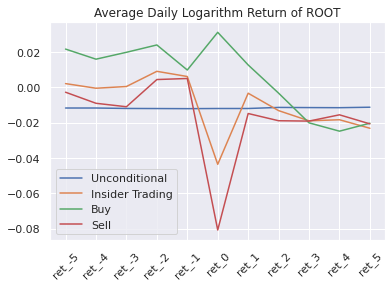

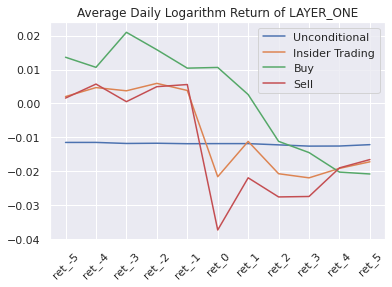

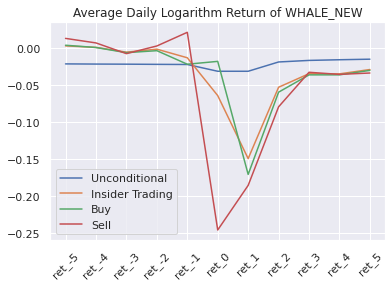

In [19]:
accs = ['root', 'layer_one', 'whale_new']
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret_new/lst/panel_insider.csv')
    df = df.loc[df['panel'] == acc]

    ret_mean = [df[i].mean() for i in ret_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in ret_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in ret_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in ret_info]

    fig, ax = plt.subplots()
    _ = ax.plot(ret_info, ret_mean, label='Unconditional')
    _ = ax.plot(ret_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(ret_info, buy_mean, label='Buy')
    _ = ax.plot(ret_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Average Daily Logarithm Return of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

### Daily Return Median

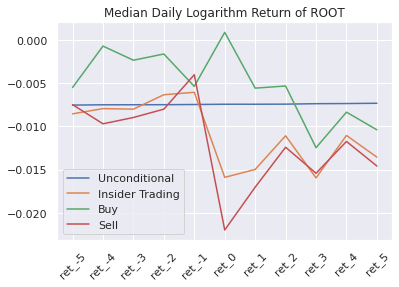

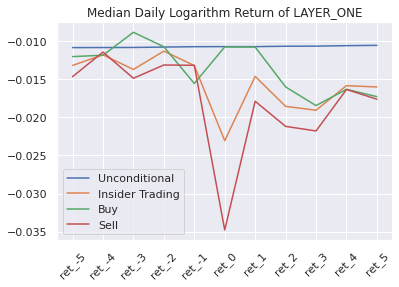

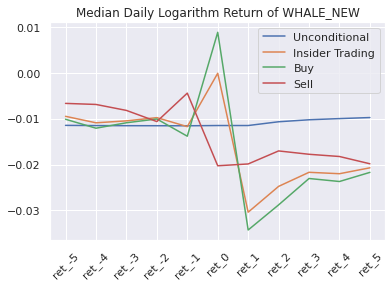

In [21]:
accs = ['root', 'layer_one', 'whale_new']
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret_new/lst/panel_insider.csv')
    df = df.loc[df['panel'] == acc]

    ret_mean = [df[i].median() for i in ret_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].median() for i in ret_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].median() for i in ret_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].median() for i in ret_info]

    fig, ax = plt.subplots()
    _ = ax.plot(ret_info, ret_mean, label='Unconditional')
    _ = ax.plot(ret_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(ret_info, buy_mean, label='Buy')
    _ = ax.plot(ret_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Median Daily Logarithm Return of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

### Cumulative Return

In [22]:
cumret_info = [f'cumret_{i}' for i in range(-5, 6)]

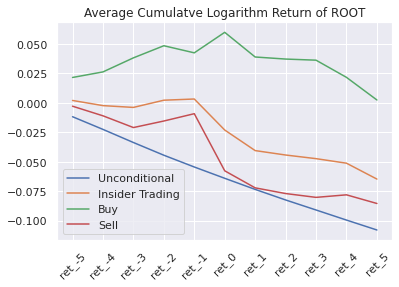

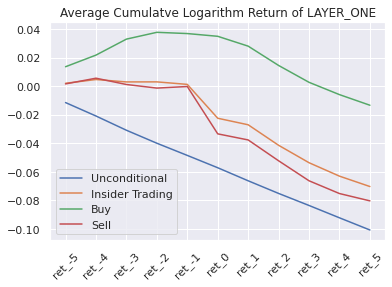

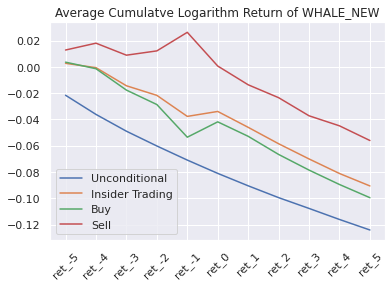

In [24]:
accs = ['root', 'layer_one', 'whale_new']
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret_new/lst/panel_insider.csv')
    df = df.loc[df['panel'] == acc]
    
    df['cumret_-5'] = df['ret_-5']
    df['cumret_-4'] = df['ret_-5'] + df['ret_-4']
    df['cumret_-3'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3']
    df['cumret_-2'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2']
    df['cumret_-1'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1']
    df['cumret_0'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0']
    df['cumret_1'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1']
    df['cumret_2'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1'] + df['ret_2']
    df['cumret_3'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1'] + df['ret_2'] + df['ret_3']
    df['cumret_4'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4']
    df['cumret_5'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4'] + df['ret_5']

    ret_mean = [df[i].mean() for i in cumret_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in cumret_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in cumret_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in cumret_info]

    fig, ax = plt.subplots()
    _ = ax.plot(ret_info, ret_mean, label='Unconditional')
    _ = ax.plot(ret_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(ret_info, buy_mean, label='Buy')
    _ = ax.plot(ret_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Average Cumulatve Logarithm Return of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    plt.legend()
    plt.show()

## Winning Probability of Insider Buy

In [30]:
winning_ret_info = [f'winning_ret_{i}' for i in range(1, 6)]
winpro_info = [f'winpro_{i}' for i in range(1, 6)]
cumwinpro_info = [f'cumwinpro_{i}' for i in range(1, 6)]

### PDF

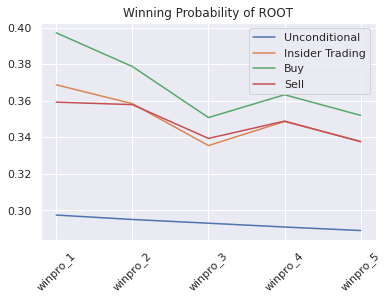

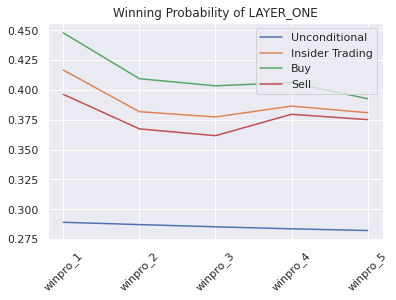

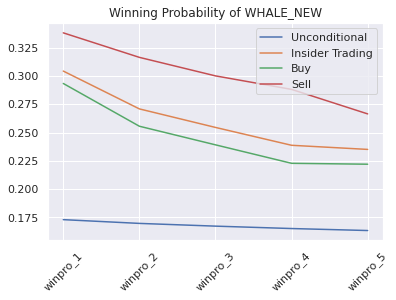

In [33]:
accs = ['root', 'layer_one', 'whale_new']
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret_new/lst/panel_insider.csv')
    df = df.loc[df['panel'] == acc]

    df['winpro_1'] = df['ret_1']>0
    df['winpro_2'] = df['ret_2']>0
    df['winpro_3'] = df['ret_3']>0
    df['winpro_4'] = df['ret_4']>0
    df['winpro_5'] = df['ret_5']>0
    
    ret_mean = [df[i].mean() for i in winpro_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in winpro_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in winpro_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in winpro_info]

    fig, ax = plt.subplots()
    _ = ax.plot(winpro_info, ret_mean, label='Unconditional')
    _ = ax.plot(winpro_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(winpro_info, buy_mean, label='Buy')
    _ = ax.plot(winpro_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Winning Probability of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

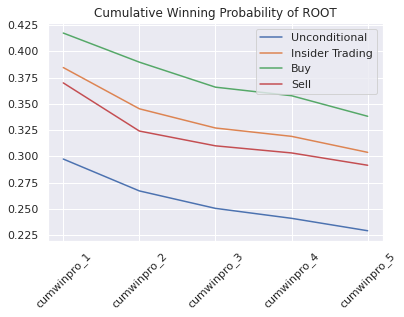

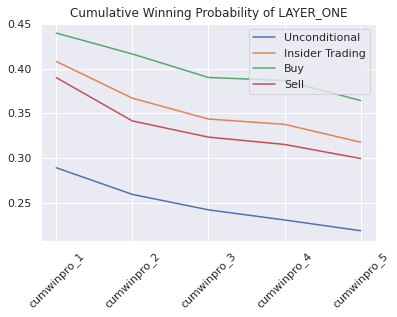

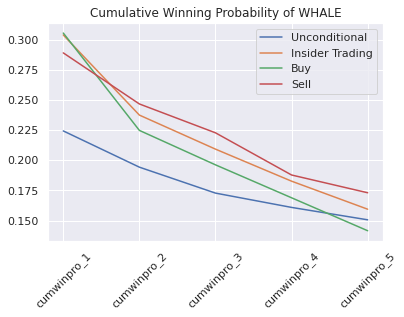

In [71]:
accs = ['root', 'layer_one', 'whale']
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret/lst/panel_insider.csv')
    df = df.loc[df[acc] == True]

    
    df['winning_ret_1'] = df['ret_1']
    df['winning_ret_2'] = df['ret_1'] + df['ret_2']
    df['winning_ret_3'] = df['ret_1'] + df['ret_2'] + df['ret_3']
    df['winning_ret_4'] = df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4']
    df['winning_ret_5'] = df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4'] + df['ret_5']
    
    df['cumwinpro_1'] = df['winning_ret_1']>0
    df['cumwinpro_2'] = df['winning_ret_2']>0
    df['cumwinpro_3'] = df['winning_ret_3']>0
    df['cumwinpro_4'] = df['winning_ret_4']>0
    df['cumwinpro_5'] = df['winning_ret_5']>0
    
    ret_mean = [df[i].mean() for i in cumwinpro_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in cumwinpro_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in cumwinpro_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in cumwinpro_info]

    fig, ax = plt.subplots()
    _ = ax.plot(cumwinpro_info, ret_mean, label='Unconditional')
    _ = ax.plot(cumwinpro_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(cumwinpro_info, buy_mean, label='Buy')
    _ = ax.plot(cumwinpro_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Cumulative Winning Probability of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

### Mean

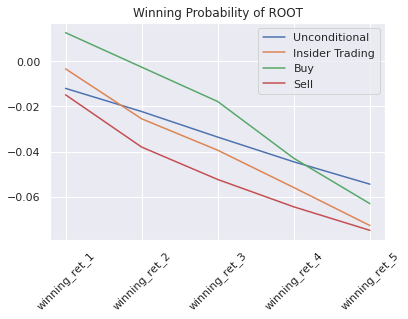

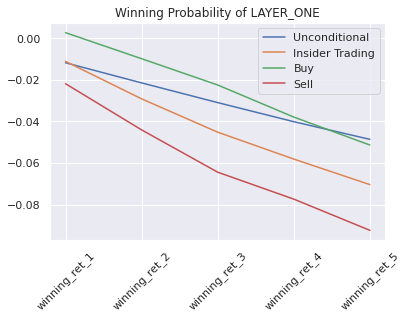

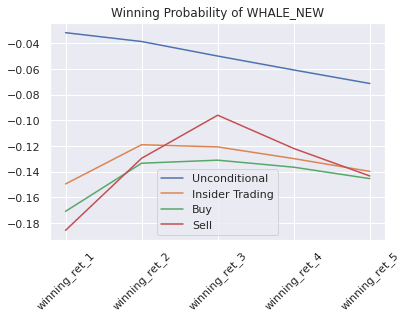

In [34]:
accs = ['root', 'layer_one', 'whale_new']
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret_new/lst/panel_insider.csv')
    df = df.loc[df['panel'] == acc]

    df['winning_ret_1'] = df['ret_1']
    df['winning_ret_2'] = df['ret_1'] + df['ret_2']
    df['winning_ret_3'] = df['ret_1'] + df['ret_2'] + df['ret_3']
    df['winning_ret_4'] = df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4']
    df['winning_ret_5'] = df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4'] + df['ret_5']
    
    ret_mean = [df[i].mean() for i in winning_ret_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in winning_ret_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in winning_ret_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in winning_ret_info]

    fig, ax = plt.subplots()
    _ = ax.plot(winning_ret_info, ret_mean, label='Unconditional')
    _ = ax.plot(winning_ret_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(winning_ret_info, buy_mean, label='Buy')
    _ = ax.plot(winning_ret_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Winning Probability of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

### Median

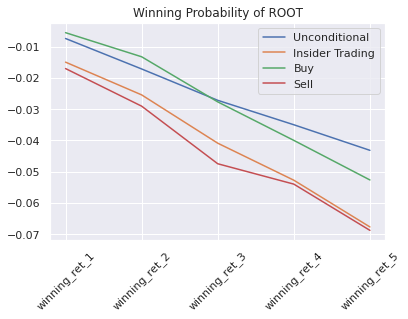

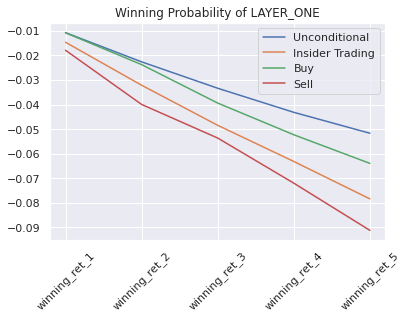

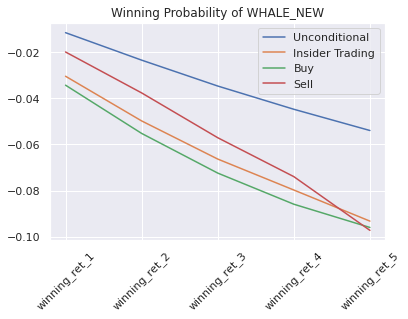

In [35]:
accs = ['root', 'layer_one', 'whale_new']
winning_ret_info = [f'winning_ret_{i}' for i in range(1, 6)]
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret_new/lst/panel_insider.csv')
    df = df.loc[df['panel'] == acc]

    df['winning_ret_1'] = df['ret_1']
    df['winning_ret_2'] = df['ret_1'] + df['ret_2']
    df['winning_ret_3'] = df['ret_1'] + df['ret_2'] + df['ret_3']
    df['winning_ret_4'] = df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4']
    df['winning_ret_5'] = df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4'] + df['ret_5']
    
    ret_mean = [df[i].median() for i in winning_ret_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].median() for i in winning_ret_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].median() for i in winning_ret_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].median() for i in winning_ret_info]

    fig, ax = plt.subplots()
    _ = ax.plot(winning_ret_info, ret_mean, label='Unconditional')
    _ = ax.plot(winning_ret_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(winning_ret_info, buy_mean, label='Buy')
    _ = ax.plot(winning_ret_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Winning Probability of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

## Event Probability

### Mean

In [38]:
# event_info = [f'event_{i}' for i in range(0, 4)]

# accs = ['root', 'layer_one', 'whale_new']
# for acc in accs:
#     df = pd.read_csv(f'{WD}token_ret_new/lst/panel_end.csv')
#     df = df.loc[df['panel'] == acc]
#     df = df.loc[df['twitter'] != 0]
    
#     ret_mean = [df[i].mean() for i in event_info]

#     insider_trading = df.loc[df['insider_trading'] == True].copy()
#     insider_trading_mean = [insider_trading[i].mean() for i in event_info]

#     buy = df.loc[df['insider_buy'] == True].copy()
#     buy_mean = [buy[i].mean() for i in event_info]

#     sell = df.loc[df['insider_sell'] == True].copy()
#     sell_mean = [sell[i].mean() for i in event_info]

#     fig, ax = plt.subplots()
#     _ = ax.plot(event_info, ret_mean, label='Unconditional')
#     _ = ax.plot(event_info, insider_trading_mean, label='Insider Trading')
#     _ = ax.plot(event_info, buy_mean, label='Buy')
#     _ = ax.plot(event_info, sell_mean, label='Sell')
#     _ = ax.set_title(f'Event Probability of {acc.upper()}')

#     _ = plt.xticks(rotation=45)
#     _ = plt.legend()
#     plt.show()

### Exact

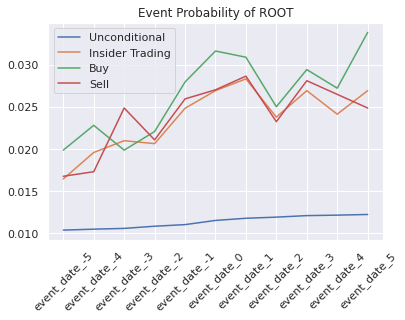

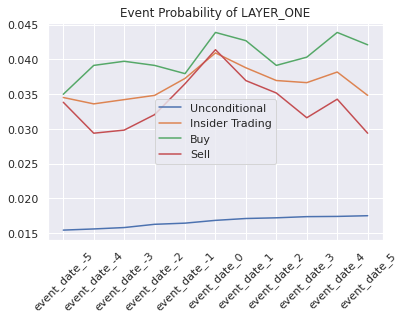

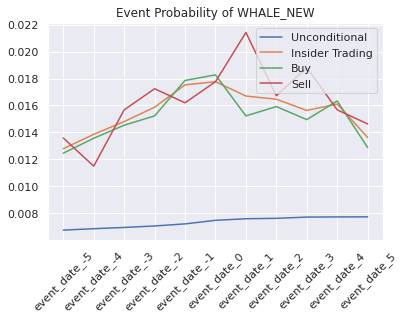

In [39]:
event_info = [f'event_date_{i}' for i in range(-5, 6)]

accs = ['root', 'layer_one', 'whale_new']
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret_new/lst/panel_end.csv')
    df = df.loc[df['panel'] == acc]
    df = df.loc[df['twitter'] != 0]
    
    ret_mean = [df[i].mean() for i in event_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in event_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in event_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in event_info]

    fig, ax = plt.subplots()
    _ = ax.plot(event_info, ret_mean, label='Unconditional')
    _ = ax.plot(event_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(event_info, buy_mean, label='Buy')
    _ = ax.plot(event_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Event Probability of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

# Insider Buy

## Buy and Sell Date

In [40]:
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_insider.csv')

for idx, row in df[['contractAddress', 'chain']].drop_duplicates().iterrows():
    contractAddress = row['contractAddress']
    chain = row['chain']
    
    start_date = df.loc[(df['contractAddress'] == contractAddress)&(df['chain'] == chain), 'date'].min()
    end_date = df.loc[(df['contractAddress'] == contractAddress)&(df['chain'] == chain), 'date'].max()
    duration = (pd.to_datetime(end_date)-pd.to_datetime(start_date)).days
    df.loc[(df['contractAddress'] == contractAddress)&(df['chain'] == chain), 'start_date'] = start_date
    df.loc[(df['contractAddress'] == contractAddress)&(df['chain'] == chain), 'end_date'] = end_date
    df.loc[(df['contractAddress'] == contractAddress)&(df['chain'] == chain), 'duration'] = duration
    
df['scaled_progress'] = (pd.to_datetime(df['date']) - pd.to_datetime(df['start_date'])).dt.days / duration

df

date                             contractAddress     chain  \
0       2021-08-16  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   
1       2021-08-17  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   
2       2021-08-18  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   
3       2021-08-19  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   
4       2021-08-20  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   
...            ...                                         ...       ...   
332078  2022-07-14  0x68d65F4de6abF450731f58F596434ef0c81dA2ac   binance   
332079  2022-07-15  0x68d65F4de6abF450731f58F596434ef0c81dA2ac   binance   
332080  2022-07-16  0x68d65F4de6abF450731f58F596434ef0c81dA2ac   binance   
332081  2022-07-17  0x68d65F4de6abF450731f58F596434ef0c81dA2ac   binance   
332082  2022-07-18  0x68d65F4de6abF450731f58F596434ef0c81dA2ac   binance   

        ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
0          NaN     NaN       NaN       NaN       NaN       NaN -0.274647   
1          NaN     NaN       NaN       NaN       NaN -0.274647 -0.210052   
2          NaN     NaN       NaN       NaN -0.274647 -0.210052  0.139668   
3          NaN     NaN       NaN -0.274647 -0.210052  0.139668  0.006935   
4          NaN     NaN -0.274647 -0.210052  0.139668  0.006935 -0.042418   
...        ...     ...       ...       ...       ...       ...       ...   
332078     NaN     NaN       NaN       NaN       NaN       NaN       NaN   
332079     NaN     NaN       NaN       NaN       NaN       NaN       NaN   
332080     NaN     NaN       NaN       NaN       NaN       NaN       NaN   
332081     NaN     NaN       NaN       NaN       NaN       NaN       NaN   
332082     NaN     NaN       NaN       NaN       NaN       NaN       NaN   

           ret_2     ret_3     ret_4     ret_5  priceUSD      panel  \
0      -0.210052  0.139668  0.006935 -0.042418  0.000022       root   
1       0.139668  0.006935 -0.042418 -0.023771  0.000017       root   
2       0.006935 -0.042418 -0.023771  0.053148  0.000014       root   
3      -0.042418 -0.023771  0.053148 -0.004094  0.000016       root   
4      -0.023771  0.053148 -0.004094  0.165303  0.000016       root   
...          ...       ...       ...       ...       ...        ...   
332078       NaN       NaN       NaN       NaN       NaN  whale_new   
332079       NaN       NaN       NaN       NaN       NaN  whale_new   
332080       NaN       NaN       NaN       NaN       NaN  whale_new   
332081       NaN       NaN       NaN       NaN       NaN  whale_new   
332082       NaN       NaN       NaN       NaN  0.000065  whale_new   

        insider_trading  insider_buy  insider_sell  start_date    end_date  \
0                  True         True         False  2021-08-16  2022-08-26   
1                 False        False         False  2021-08-16  2022-08-26   
2                  True         True          True  2021-08-16  2022-08-26   
3                 False        False         False  2021-08-16  2022-08-26   
4                  True        False          True  2021-08-16  2022-08-26   
...                 ...          ...           ...         ...         ...   
332078            False        False         False  2022-03-11  2022-07-18   
332079            False        False         False  2022-03-11  2022-07-18   
332080            False        False         False  2022-03-11  2022-07-18   
332081            False        False         False  2022-03-11  2022-07-18   
332082            False        False         False  2022-03-11  2022-07-18   

        duration  scaled_progress  
0          375.0         0.000000  
1          375.0         0.007752  
2          375.0         0.015504  
3          375.0         0.023256  
4          375.0         0.031008  
...          ...              ...  
332078     129.0         0.968992  
332079     129.0         0.976744  
332080     129.0         0.984496  
332081     129.0         0.992248  
33

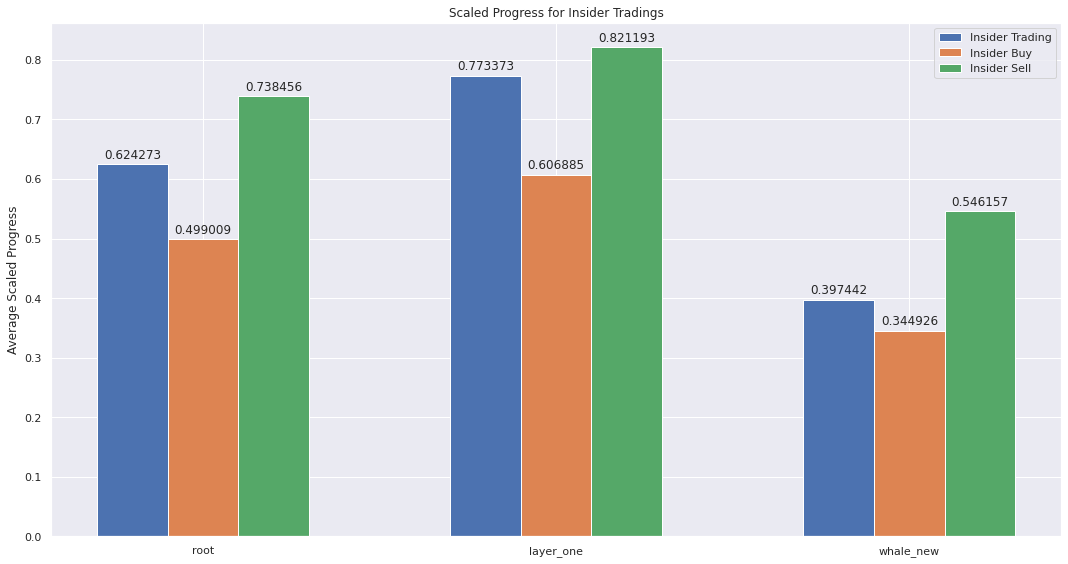

In [41]:
accs = ['root', 'layer_one', 'whale_new']
fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(accs))
width = 0.20
insider_trading_dates = []
insider_buy_dates = []
insider_sell_dates = []


for acc in accs:
    csv = df.loc[df['panel'] == acc].copy()
    insider_trading = csv.loc[csv['insider_trading'] == True].copy()
    insider_trading_date = insider_trading['scaled_progress'].mean()
    insider_trading_dates.append(insider_trading_date)
    
    insider_buy = csv.loc[csv['insider_buy'] == True].copy()
    insider_buy_date = insider_buy['scaled_progress'].mean()
    insider_buy_dates.append(insider_buy_date)
    
    insider_sell = csv.loc[csv['insider_sell'] == True].copy()
    insider_sell_date = insider_sell['scaled_progress'].mean()
    insider_sell_dates.append(insider_sell_date)
    

rects1 = ax.bar(x - width, insider_trading_dates, width, label='Insider Trading')
rects2 = ax.bar(x, insider_buy_dates, width, label='Insider Buy')
rects3 = ax.bar(x + width, insider_sell_dates, width, label='Insider Sell')

_ = ax.set_ylabel('Average Scaled Progress')
_ = ax.set_title('Scaled Progress for Insider Tradings')
_ = ax.set_xticks(x, accs)
_ = ax.legend()

_ = ax.bar_label(rects1, padding=3)
_ = ax.bar_label(rects2, padding=3)
_ = ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

## Example

### Root

In [164]:
df = pd.read_csv(f'{WD}token_ret/lst/panel_insider.csv')
df.loc[(df['chain'] == 'ethereum')&(df['root'] == True)].sample(3)

date                             contractAddress     chain  \
11050  2022-07-06  0xbf825207c74b6c3c01ab807c4f4a4fce26ebdf0f  ethereum   
3431   2021-02-26  0xc944e90c64b2c07662a292be6244bdf05cda44a7  ethereum   
25723  2022-08-20  0x5c28dbdf5351089ca413b4493dd6c6043e44af42  ethereum   

         ret_-5    ret_-4    ret_-3   ret_-2    ret_-1     ret_0     ret_1  \
11050       NaN       NaN       NaN      NaN       NaN       NaN  0.039361   
3431  -0.049571 -0.126065 -0.181849  0.12893 -0.094533 -0.008533 -0.033107   
25723       NaN       NaN       NaN      NaN       NaN       NaN       NaN   

          ret_2     ret_3     ret_4     ret_5      priceUSD  root  layer_one  \
11050  0.037870       NaN       NaN       NaN  2.740000e-14  True      False   
3431  -0.055134  0.194063 -0.051865  0.084985  1.719461e+00  True      False   
25723 -0.035758       NaN       NaN       NaN           NaN  True       True   

       whale  insider_trading  insider_buy  insider_sell  
11050  False            False        False         False  
3431   False            False        False         False  
25723  False            False        False         False

#### Graph

- Ethereum
- Only Swap

'uniswapv3_ethereum'

'uniswapv2_ethereum'

'2022-03-02'

'sushiswap_ethereum'

Empty DataFrame
Columns: [Unnamed: 0, amountUSD, id, logIndex, origin, recipient, sender, sqrtPriceX96, tick, timestamp, token0_name, token1_name, token0_id, token1_id, transaction_id, amount0Out, amount0In, amount1Out, amount1In, home_token, dex, chain, insider_root, contractAddress, from, to, lp, buy, ret_1, ret_2, ret_3, ret_-1, ret_-2, ret_-3, date]
Index: []

Unnamed: 0  amountUSD  \
1734        1851  41.248415   

                                                                        id  \
1734  0xfd277cabbfc425833b14d6514823a0611408c9c3ecf2967a7ba759861a25c14e-0   

      logIndex origin recipient                                      sender  \
1734       412    NaN       NaN  0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45   

     sqrtPriceX96  tick           timestamp token0_name    token1_name  \
1734          NaN   NaN 2022-03-03 03:09:46    Hirokage  Wrapped Ether   

                                       token0_id  \
1734  0x5c28dbdf5351089ca413b4493dd6c6043e44af42   

                                       token1_id  \
1734  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   

                                                          transaction_id  \
1734  0xfd277cabbfc425833b14d6514823a0611408c9c3ecf2967a7ba759861a25c14e   

      amount0Out  amount0In  amount1Out  amount1In  home_token  \
1734    500000.0        0.0         0.0   0.014101        True   

                     dex     chain  \
1734  uniswapv2_ethereum  ethereum   

                                    insider_root  \
1734  0xfbc20e050048a885769a6da858ca726a22e44e9d   

                                 contractAddress  \
1734  0x5c28dbdf5351089ca413b4493dd6c6043e44af42   

                                            from  \
1734  0xfbc20e050048a885769a6da858ca726a22e44e9d   

                                              to     lp        buy     ret_1  \
1734  0xfbc20e050048a885769a6da858ca726a22e44e9d  False  41.248415 -0.173163   

         ret_2     ret_3  ret_-1  ret_-2  ret_-3        date  
1734 -0.172812 -0.261434     NaN     NaN     NaN  2022-03-03

Empty DataFrame
Columns: [Unnamed: 0, amountUSD, id, logIndex, origin, recipient, sender, sqrtPriceX96, tick, timestamp, token0_name, token1_name, token0_id, token1_id, transaction_id, amount0Out, amount0In, amount1Out, amount1In, home_token, dex, chain, insider_root, contractAddress, from, to, lp, buy, ret_1, ret_2, ret_3, ret_-1, ret_-2, ret_-3, date]
Index: []

Empty DataFrame
Columns: [Unnamed: 0, amountUSD, id, logIndex, origin, recipient, sender, sqrtPriceX96, tick, timestamp, token0_name, token1_name, token0_id, token1_id, transaction_id, amount0Out, amount0In, amount1Out, amount1In, home_token, dex, chain, insider_root, contractAddress, from, to, lp, buy, ret_1, ret_2, ret_3, ret_-1, ret_-2, ret_-3, date]
Index: []

Empty DataFrame
Columns: [Unnamed: 0, amountUSD, id, logIndex, origin, recipient, sender, sqrtPriceX96, tick, timestamp, token0_name, token1_name, token0_id, token1_id, transaction_id, amount0Out, amount0In, amount1Out, amount1In, home_token, dex, chain, insider_root, contractAddress, from, to, lp, buy, ret_1, ret_2, ret_3, ret_-1, ret_-2, ret_-3, date]
Index: []

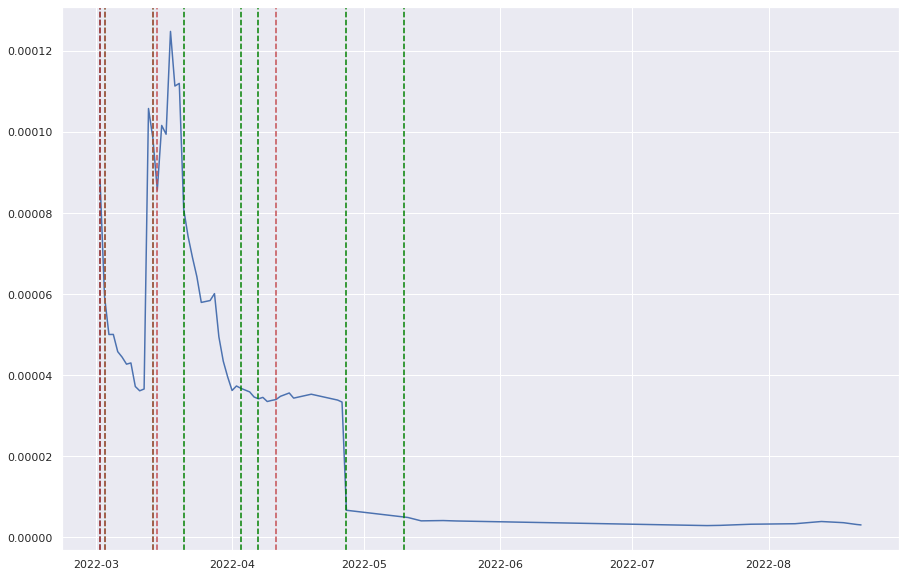

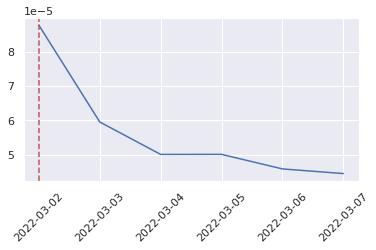

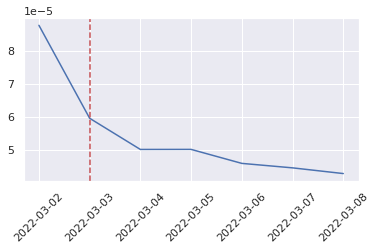

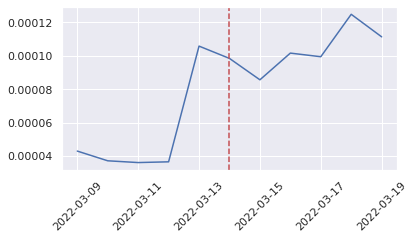

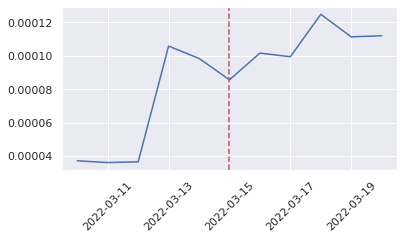

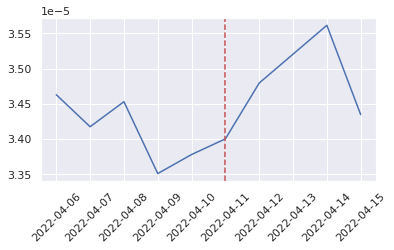

date                             contractAddress     chain  \
25592  2022-04-11  0x5c28dbdf5351089ca413b4493dd6c6043e44af42  ethereum   

         ret_-5    ret_-4    ret_-3    ret_-2   ret_-1     ret_0     ret_1  \
25592 -0.035612 -0.013225  0.010355 -0.029985  0.00803  0.006563  0.023032   

       ret_2  ret_3     ret_4  ret_5  priceUSD  root  layer_one  whale  \
25592    NaN    NaN -0.036227    NaN  0.000034  True       True  False   

       insider_trading  insider_buy  insider_sell  
25592             True         True         False

In [167]:
contract = '0x5c28dbdf5351089ca413b4493dd6c6043e44af42'
chain = 'ethereum'
lst = 'root'
contractAddress_lower = contract.lower()
contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)
dex_num = 0

dfs = pd.read_csv(f'{RES}/transaction/{lst}.csv')
dfs['timestamp'] = pd.to_datetime(dfs['timestamp'])
dfs['date'] = dfs['timestamp'].dt.strftime('%Y-%m-%d')
if lst != 'root': dfs.rename(columns={'insider_contractAddress':'contractAddress'}, inplace=True)

panel = []
dex_dates = []
for dex in chain_info(chain):
    dex
    lst = pd.read_csv(f'{WD}/dex_price/list_all/{dex}.csv')
    csv_info = lst.loc[((lst['contractAddress'] == contractAddress_lower)|
                        (lst['contractAddress'] == contractAddress_upper))]

    if csv_info['contractAddress'].values[0] == contractAddress_lower:
        contractAddress = contractAddress_lower
    else:
        contractAddress = contractAddress_upper

    status = csv_info['status'].values[0]
    dexn = csv_info['dex'].values[0]

    if status == 0: 
        continue
    elif dexn == 0:
        continue
    else:
        csv = pd.read_csv(f'{WD}dex_price/csv_all/{contractAddress}_{dex}.csv') 
        csv = csv.loc[:, ['priceUSD', 'date']]
        csv['date'].min()
        dex_dates.append(csv['date'].min())       
        panel.append(csv)
        dex_num += 1

if dex_num != 0:
    panel = pd.concat(panel)
    panel = panel.loc[panel['priceUSD']!=0]

start_date = panel['date'].min()

avg = panel.groupby('date')['priceUSD'].mean().reset_index()
avg.sort_values('date', ascending=True, inplace=True)


fig, ax = plt.subplots(figsize=(15, 10))
_ = ax.plot(pd.to_datetime(avg['date'].values), avg['priceUSD'].values)

for dex_date in dex_dates:
    _ = ax.axvline(pd.to_datetime(dex_date), linestyle='--', color='black')

for sell_date in df.loc[(df['contractAddress'] == contract)&(df['root'] == True)&(df['insider_sell'] == True), 'date']:
    _ = ax.axvline(pd.to_datetime(sell_date), linestyle='--', color='green')   
    
for buy_date in df.loc[(df['contractAddress'] == contract)&(df['root'] == True)&(df['insider_buy'] == True), 'date']:
    _ = ax.axvline(pd.to_datetime(buy_date), linestyle='--', color='r')   
    
    fig, bx = plt.subplots(figsize=(6, 3))
    buy_info = avg.loc[(pd.to_datetime(avg['date']) <= pd.to_datetime(buy_date)+datetime.timedelta(days=5))&
                       (pd.to_datetime(avg['date']) >= pd.to_datetime(buy_date)-datetime.timedelta(days=5))]
    _ = bx.plot(pd.to_datetime(buy_info['date'].values), buy_info['priceUSD'].values)
    _ = bx.axvline(pd.to_datetime(buy_date), linestyle='--', color='r')   
    _ = plt.xticks(rotation=45)
    
    dfs.loc[(dfs['contractAddress'] == contract)&(dfs['date'] == buy_date)&(dfs['chain'] == chain)]


plt.show()

df.loc[(df['contractAddress'] == contract)&(df['date'] == buy_date)&(df['chain'] == chain)]

# Crashes

## Projects

'root'

144

604

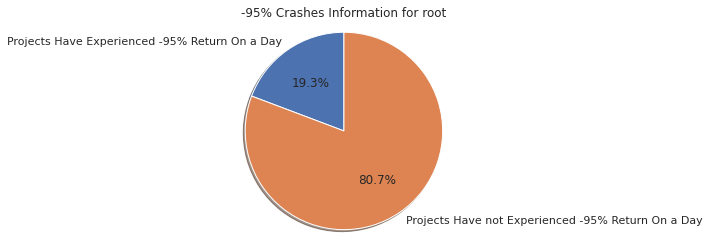

'layer_one'

48

118

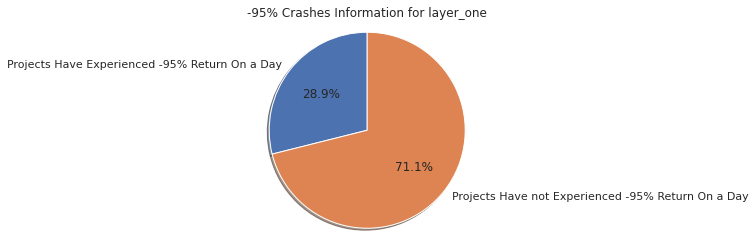

'whale_new'

476

3438

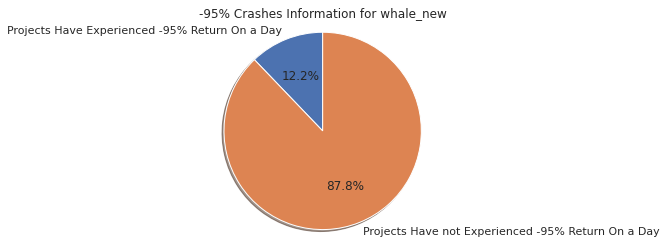

<AxesSubplot:xlabel='date'>

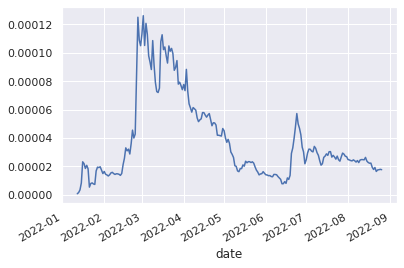

In [42]:
for acc in accs:
    acc
    crash = []
    
    have = df.loc[(df['ret_0'] <= -0.95)&(df['panel']==acc), ['contractAddress','chain']].drop_duplicates().shape[0]
    total = df.loc[df['panel']==acc,['contractAddress','chain']].drop_duplicates().shape[0]
    havenot = total - have
    
    have
    havenot
    
    crash.append(have)
    crash.append(havenot)
    

    labels = 'Projects Have Experienced -95% Return On a Day', 'Projects Have not Experienced -95% Return On a Day'

    fig1, ax1 = plt.subplots()
    _ = ax1.pie(crash, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
    _ = ax1.set_title(f'-95% Crashes Information for {acc}')
    _ = ax1.axis('equal')

    plt.show()

contractAddress = df.loc[df['ret_0'] <= -0.95, ['contractAddress']].sample(1)['contractAddress'].values[0]
df['date'] = pd.to_datetime(df['date'])
df.loc[df['contractAddress'] == contractAddress].set_index('date')['priceUSD'].plot()

## Insider Sell

In [136]:
crash_info = [f'crash_sell_{i}' for i in range(-5,6)]

1/181
2/181
3/181
4/181
5/181
6/181
7/181
8/181
9/181
10/181
11/181
12/181
13/181
14/181
15/181
16/181
17/181
18/181
19/181
20/181
21/181
22/181
23/181
24/181
25/181
26/181
27/181
28/181
29/181
30/181
31/181
32/181
33/181
34/181
35/181
36/181
37/181
38/181
39/181
40/181
41/181
42/181
43/181
44/181
45/181
46/181
47/181
48/181
49/181
50/181
51/181
52/181
53/181
54/181
55/181
56/181
57/181
58/181
59/181
60/181
61/181
62/181
63/181
64/181
65/181
66/181
67/181
68/181
69/181
70/181
71/181
72/181
73/181
74/181
75/181
76/181
77/181
78/181
79/181
80/181
81/181
82/181
83/181
84/181
85/181
86/181
87/181
88/181
89/181
90/181
91/181
92/181
93/181
94/181
95/181
96/181
97/181
98/181
99/181
100/181
101/181
102/181
103/181
104/181
105/181
106/181
107/181
108/181
109/181
110/181
111/181
112/181
113/181
114/181
115/181
116/181
117/181
118/181
119/181
120/181
121/181
122/181
123/181
124/181
125/181
126/181
127/181
128/181
129/181
130/181
131/181
132/181
133/181
134/181
135/181
136/181
137/181
138/181
139/

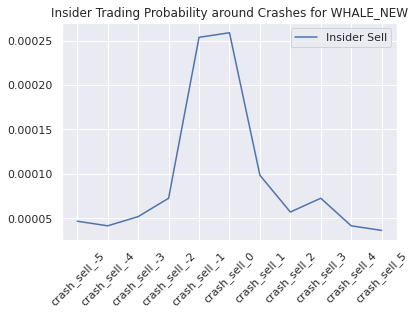

In [138]:
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_drawdown.csv')
df['date'] = pd.to_datetime(df['date'])
for i in range(-5, 6):
    df[f'crash_sell_{i}'] = 0
    
for acc in accs:
    cra = df.loc[(df['ret_0'] <= -0.95)&(df['panel']==acc)].copy()
    total = cra.shape[0]
    done = 0
    for idx, row in cra.iterrows():
        done += 1
        
        date = row['date']
        contractAddress = row['contractAddress']
        chain = row['chain']
        panel = row['panel']
        
        for i in range(-5, 6):
            if df.loc[(df['contractAddress'] == contractAddress)&
                       (df['chain'] == chain)&
                       (df['panel'] == panel)&
                       (df['date'] == date + datetime.timedelta(days=i)), 'insider_sell'].values == True:

                   df.loc[(df['contractAddress'] == contractAddress)&
                           (df['chain'] == chain)&
                           (df['panel'] == panel)&
                           (df['date'] == date), f'crash_sell_{i}'] = 1
        print(f'{done}/{total}')
                    
#     uncon = []
#     for idx, row in df.loc[(df['ret_0'] <= -0.95)&(df[acc]==True), ['contractAddress','chain']].drop_duplicates().iterrows():
#         contractAddress = row['contractAddress']
#         chain = row['chain']
#         uncon.append(df.loc[(df['contractAddress'] == contractAddress)&
#                     (df['chain'] == chain)])
        
#     uncon = pd.concat(uncon)
#     uncon['date'] = pd.to_datetime(uncon['date'])
#     for idx, row in uncon.iterrows():
#         date = row['date']
#         contractAddress = row['contractAddress']
#         chain = row['chain']
#         for i in range(-5, 6):
#             if uncon.loc[(uncon['contractAddress'] == contractAddress)&
#                          (uncon['chain'] == chain)&
#                          (uncon['date'] == date - datetime.timedelta(days=i)), 'insider_sell'].values == True:

#                    uncon.loc[(uncon['contractAddress'] == contractAddress)&
#                            (uncon['chain'] == chain)&
#                            (uncon['date'] == date), f'crash_sell_{i}'] = 1
    
    
cra_mean = [df.loc[df['panel'] == acc][i].mean() for i in crash_info]
# uncon_mean = [uncon[i].mean() for i in crash_info]

fig, ax = plt.subplots()
# _ = ax.plot(crash_info, uncon_mean, label='Unconditional')
_ = ax.plot(crash_info, cra_mean, label='Insider Sell')
_ = ax.set_title(f'Insider Trading Probability around Crashes for {acc.upper()}')

_ = plt.xticks(rotation=45)
_ = plt.legend()
plt.show()

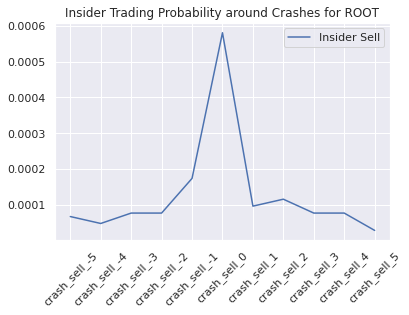

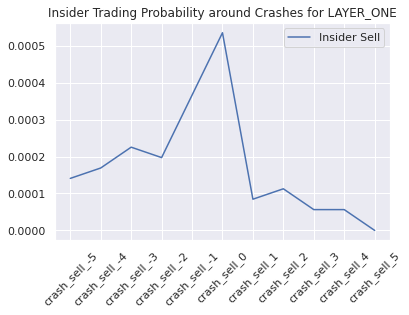

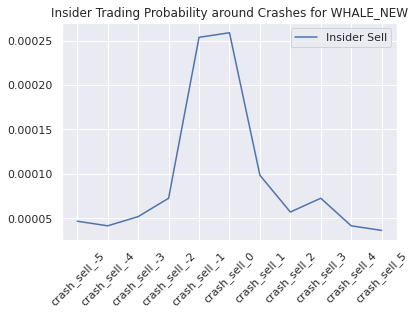

In [141]:
for acc in accs:
    cra_mean = [df.loc[df['panel'] == acc][i].mean() for i in crash_info]
    # uncon_mean = [uncon[i].mean() for i in crash_info]

    fig, ax = plt.subplots()
    # _ = ax.plot(crash_info, uncon_mean, label='Unconditional')
    _ = ax.plot(crash_info, cra_mean, label='Insider Sell')
    _ = ax.set_title(f'Insider Trading Probability around Crashes for {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

## Variable: Crash

In [209]:
crash_info = [f'crash_{i}' for i in range(-5,6)]

In [210]:
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_drawdown.csv')
df['date'] = pd.to_datetime(df['date'])
for i in range(-5, 6):
    df[f'crash_{i}'] = 0
    
for acc in accs:
    cra = df.loc[(df['ret_0'] <= -0.95)&(df['panel']==acc)].copy()
    total = cra.shape[0]
    done = 0
    for idx, row in cra.iterrows():
        done += 1
        
        date = row['date']
        contractAddress = row['contractAddress']
        chain = row['chain']
        panel = row['panel']
        
        for i in range(-5, 6):
            df.loc[(df['contractAddress'] == contractAddress)&
                   (df['chain'] == chain)&
                   (df['panel'] == panel)&
                   (df['date'] == date + datetime.timedelta(days=i)), f'crash_{-i}'] = 1

        print(f'{done}/{total}')

1/181
2/181
3/181
4/181
5/181
6/181
7/181
8/181
9/181
10/181
11/181
12/181
13/181
14/181
15/181
16/181
17/181
18/181
19/181
20/181
21/181
22/181
23/181
24/181
25/181
26/181
27/181
28/181
29/181
30/181
31/181
32/181
33/181
34/181
35/181
36/181
37/181
38/181
39/181
40/181
41/181
42/181
43/181
44/181
45/181
46/181
47/181
48/181
49/181
50/181
51/181
52/181
53/181
54/181
55/181
56/181
57/181
58/181
59/181
60/181
61/181
62/181
63/181
64/181
65/181
66/181
67/181
68/181
69/181
70/181
71/181
72/181
73/181
74/181
75/181
76/181
77/181
78/181
79/181
80/181
81/181
82/181
83/181
84/181
85/181
86/181
87/181
88/181
89/181
90/181
91/181
92/181
93/181
94/181
95/181
96/181
97/181
98/181
99/181
100/181
101/181
102/181
103/181
104/181
105/181
106/181
107/181
108/181
109/181
110/181
111/181
112/181
113/181
114/181
115/181
116/181
117/181
118/181
119/181
120/181
121/181
122/181
123/181
124/181
125/181
126/181
127/181
128/181
129/181
130/181
131/181
132/181
133/181
134/181
135/181
136/181
137/181
138/181
139/

In [211]:
df.to_csv(f'{WD}token_ret_new/lst/panel_crash_old.csv', index=False)

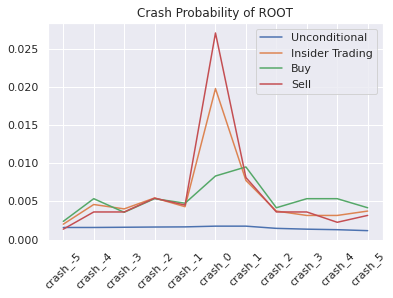

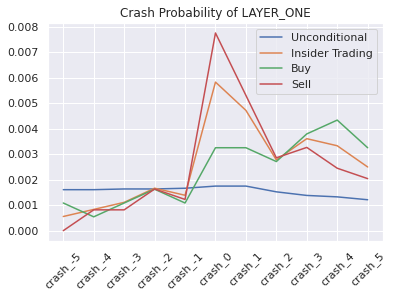

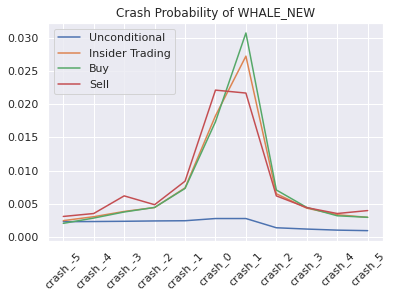

In [212]:
accs = ['root', 'layer_one', 'whale_new']

for acc in accs:
    df = pd.read_csv(f'{WD}token_ret_new/lst/panel_crash_old.csv')
    df = df.loc[df['panel'] == acc]
    
    ret_mean = [df[i].mean() for i in crash_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in crash_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in crash_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in crash_info]

    fig, ax = plt.subplots()
    _ = ax.plot(crash_info, ret_mean, label='Unconditional')
    _ = ax.plot(crash_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(crash_info, buy_mean, label='Buy')
    _ = ax.plot(crash_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Crash Probability of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

# Varaible: Crash_New

In [113]:
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_end.csv')
df['crash_new'] = 0
df['date'] = pd.to_datetime(df['date'])

total = df.drop_duplicates(['contractAddress', 'chain']).shape[0]
done = 0

for idx, row in df.drop_duplicates(['contractAddress', 'chain']).iterrows():
    try:
        done += 1
        contractAddress = row['contractAddress']
        chain = row['chain']

        csv = df.loc[(df['contractAddress'] == contractAddress)&(df['chain'] == chain)].drop_duplicates('date')
        csv.sort_values('date', ascending=True, inplace=True)


        for idxx, roww in csv.iterrows():
            date = roww['date']
            span = csv.loc[(csv['date']>= date)&(csv['date'] <= (date + datetime.timedelta(days=15)))]
            peak_price = span['priceUSD'].max()
            peak_date = span.loc[span['priceUSD'] == peak_price, 'date'].values[0]
            trough_price = span.loc[span['date'] >= peak_date, 'priceUSD'].min()
            if (trough_price - peak_price)/peak_price <= -0.90:
                df.loc[(df['contractAddress'] == contractAddress)&
                       (df['chain'] == chain)&
                       (df['date'] == date), 'crash_new'] = 1
        print(f'done, {done}/{total}')
    except Exception as e:
        df.loc[(df['contractAddress'] == contractAddress)&
       (df['chain'] == chain)&
       (df['date'] == date), 'crash_new'] = np.nan
        print(f'Error: {e}, {done}/{total}')

done, 1/4416
done, 2/4416
done, 3/4416
done, 4/4416
done, 5/4416
done, 6/4416
done, 7/4416
done, 8/4416
done, 9/4416
done, 10/4416
done, 11/4416
done, 12/4416
done, 13/4416
done, 14/4416
Error: index 0 is out of bounds for axis 0 with size 0, 15/4416
Error: index 0 is out of bounds for axis 0 with size 0, 16/4416
done, 17/4416
done, 18/4416
done, 19/4416
done, 20/4416
Error: index 0 is out of bounds for axis 0 with size 0, 21/4416
Error: index 0 is out of bounds for axis 0 with size 0, 22/4416
done, 23/4416
done, 24/4416
done, 25/4416
done, 26/4416
done, 27/4416
done, 28/4416
done, 29/4416
done, 30/4416
done, 31/4416
Error: index 0 is out of bounds for axis 0 with size 0, 32/4416
done, 33/4416
done, 34/4416
Error: index 0 is out of bounds for axis 0 with size 0, 35/4416
done, 36/4416
Error: index 0 is out of bounds for axis 0 with size 0, 37/4416
Error: index 0 is out of bounds for axis 0 with size 0, 38/4416
Error: index 0 is out of bounds for axis 0 with size 0, 39/4416
done, 40/4416

In [114]:
df
df.to_csv(f'{WD}token_ret_new/lst/panel_drawdown.csv', index=False)

date                             contractAddress     chain  \
0      2021-08-16  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   
1      2021-08-17  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   
2      2021-08-18  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   
3      2021-08-19  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   
4      2021-08-20  0x24e89bdf2f65326b94e36978a7edeac63623dafa  ethereum   
...           ...                                         ...       ...   
332078 2022-07-14  0x68d65F4de6abF450731f58F596434ef0c81dA2ac   binance   
332079 2022-07-15  0x68d65F4de6abF450731f58F596434ef0c81dA2ac   binance   
332080 2022-07-16  0x68d65F4de6abF450731f58F596434ef0c81dA2ac   binance   
332081 2022-07-17  0x68d65F4de6abF450731f58F596434ef0c81dA2ac   binance   
332082 2022-07-18  0x68d65F4de6abF450731f58F596434ef0c81dA2ac   binance   

        ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
0          NaN     NaN       NaN       NaN       NaN       NaN -0.274647   
1          NaN     NaN       NaN       NaN       NaN -0.274647 -0.210052   
2          NaN     NaN       NaN       NaN -0.274647 -0.210052  0.139668   
3          NaN     NaN       NaN -0.274647 -0.210052  0.139668  0.006935   
4          NaN     NaN -0.274647 -0.210052  0.139668  0.006935 -0.042418   
...        ...     ...       ...       ...       ...       ...       ...   
332078     NaN     NaN       NaN       NaN       NaN       NaN       NaN   
332079     NaN     NaN       NaN       NaN       NaN       NaN       NaN   
332080     NaN     NaN       NaN       NaN       NaN       NaN       NaN   
332081     NaN     NaN       NaN       NaN       NaN       NaN       NaN   
332082     NaN     NaN       NaN       NaN       NaN       NaN       NaN   

           ret_2     ret_3     ret_4     ret_5  priceUSD      panel  \
0      -0.210052  0.139668  0.006935 -0.042418  0.000022       root   
1       0.139668  0.006935 -0.042418 -0.023771  0.000017       root   
2       0.006935 -0.042418 -0.023771  0.053148  0.000014       root   
3      -0.042418 -0.023771  0.053148 -0.004094  0.000016       root   
4      -0.023771  0.053148 -0.004094  0.165303  0.000016       root   
...          ...       ...       ...       ...       ...        ...   
332078       NaN       NaN       NaN       NaN       NaN  whale_new   
332079       NaN       NaN       NaN       NaN       NaN  whale_new   
332080       NaN       NaN       NaN       NaN       NaN  whale_new   
332081       NaN       NaN       NaN       NaN       NaN  whale_new   
332082       NaN       NaN       NaN       NaN  0.000065  whale_new   

        insider_trading  insider_buy  insider_sell  twitter  event_date_-5  \
0                  True         True         False        1              0   
1                 False        False         False        1              0   
2                  True         True          True        1              0   
3                 False        False         False        1              0   
4                  True        False          True        1              0   
...                 ...          ...           ...      ...            ...   
332078            False        False         False        0              0   
332079            False        False         False        0              0   
332080            False        False         False        0              0   
332081            False        False         False        0              0   
332082            False        False         False        0              0   

        event_date_-4  event_date_-3  event_date_-2  event_date_-1  \
0                   0              0              0              1   
1                   0              0              0              0   
2                   0              0              0              0   
3                   0              0              0              0   
4                   0              0              0        

In [163]:
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_crash_new.csv')
df.loc[df['crash_new'] == 1].shape[0]
for acc in accs:
    df.loc[(df['crash_new'] == 1)&(df['panel'] == acc)].shape[0]

3546

1088

385

2073

## Projects

'root'

128

620

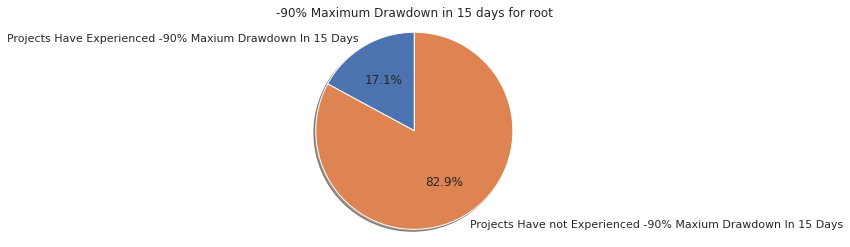

'layer_one'

42

124

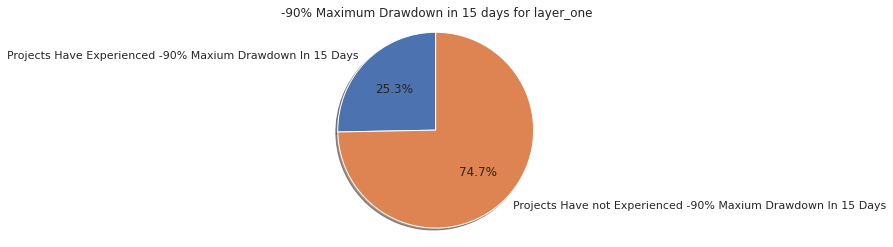

'whale_new'

523

3391

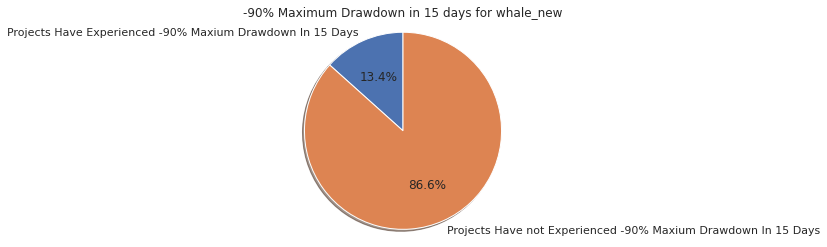

<AxesSubplot:xlabel='date'>

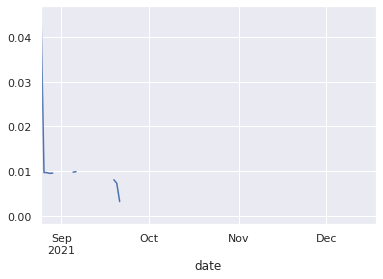

In [117]:
for acc in accs:
    acc
    crash = []
    
    have = df.loc[(df['crash_new'] == 1)&(df['panel']==acc), ['contractAddress','chain']].drop_duplicates().shape[0]
    total = df.loc[df['panel']==acc,['contractAddress','chain']].drop_duplicates().shape[0]
    havenot = total - have
    
    have
    havenot
    
    crash.append(have)
    crash.append(havenot)
    

    labels = 'Projects Have Experienced -90% Maxium Drawdown In 15 Days', 'Projects Have not Experienced -90% Maxium Drawdown In 15 Days'

    fig1, ax1 = plt.subplots()
    _ = ax1.pie(crash, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
    _ = ax1.set_title(f'-90% Maximum Drawdown in 15 days for {acc}')
    _ = ax1.axis('equal')

    plt.show()

contractAddress = df.loc[df['crash_new'] == 1, ['contractAddress']].sample(1)['contractAddress'].values[0]
df['date'] = pd.to_datetime(df['date'])
df.loc[df['contractAddress'] == contractAddress].set_index('date')['priceUSD'].plot()

## Insider Sell

In [151]:
crash_info = [f'crash_sell_new_{i}' for i in range(-5,6)]

In [153]:
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_drawdown.csv')
df['date'] = pd.to_datetime(df['date'])
for i in range(-5, 6):
    df[f'crash_sell_new_{i}'] = 0
    
for acc in accs:
    cra = df.loc[(df['crash_new'] == 1)&(df['panel']==acc)].copy()
    total = cra.shape[0]
    done = 0
    for idx, row in cra.iterrows():
        done += 1
        
        date = row['date']
        contractAddress = row['contractAddress']
        chain = row['chain']
        panel = row['panel']
        
        for i in range(-5, 6):
            if df.loc[(df['contractAddress'] == contractAddress)&
                       (df['chain'] == chain)&
                       (df['panel'] == panel)&
                       (df['date'] == date + datetime.timedelta(days=i)), 'insider_sell'].values == True:

                   df.loc[(df['contractAddress'] == contractAddress)&
                           (df['chain'] == chain)&
                           (df['panel'] == panel)&
                           (df['date'] == date), f'crash_sell_new_{i}'] = 1
        print(f'{done}/{total}')

1/1088
2/1088
3/1088
4/1088
5/1088
6/1088
7/1088
8/1088
9/1088
10/1088
11/1088
12/1088
13/1088
14/1088
15/1088
16/1088
17/1088
18/1088
19/1088
20/1088
21/1088
22/1088
23/1088
24/1088
25/1088
26/1088
27/1088
28/1088
29/1088
30/1088
31/1088
32/1088
33/1088
34/1088
35/1088
36/1088
37/1088
38/1088
39/1088
40/1088
41/1088
42/1088
43/1088
44/1088
45/1088
46/1088
47/1088
48/1088
49/1088
50/1088
51/1088
52/1088
53/1088
54/1088
55/1088
56/1088
57/1088
58/1088
59/1088
60/1088
61/1088
62/1088
63/1088
64/1088
65/1088
66/1088
67/1088
68/1088
69/1088
70/1088
71/1088
72/1088
73/1088
74/1088
75/1088
76/1088
77/1088
78/1088
79/1088
80/1088
81/1088
82/1088
83/1088
84/1088
85/1088
86/1088
87/1088
88/1088
89/1088
90/1088
91/1088
92/1088
93/1088
94/1088
95/1088
96/1088
97/1088
98/1088
99/1088
100/1088
101/1088
102/1088
103/1088
104/1088
105/1088
106/1088
107/1088
108/1088
109/1088
110/1088
111/1088
112/1088
113/1088
114/1088
115/1088
116/1088
117/1088
118/1088
119/1088
120/1088
121/1088
122/1088
123/1088
1

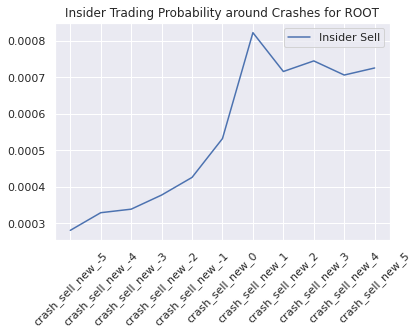

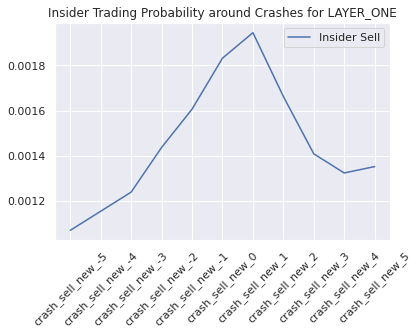

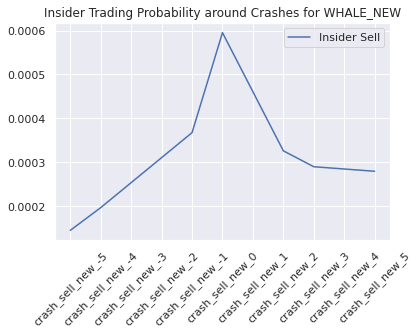

In [154]:
for acc in accs:
    cra_mean = [df.loc[df['panel'] == acc][i].mean() for i in crash_info]
    # uncon_mean = [uncon[i].mean() for i in crash_info]

    fig, ax = plt.subplots()
    # _ = ax.plot(crash_info, uncon_mean, label='Unconditional')
    _ = ax.plot(crash_info, cra_mean, label='Insider Sell')
    _ = ax.set_title(f'Insider Trading Probability around Crashes for {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

## Variables: Crash

In [203]:
crash_info = [f'crash_{i}' for i in range(-5,6)]

In [204]:
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_drawdown.csv')
df['date'] = pd.to_datetime(df['date'])
for i in range(-5, 6):
    df[f'crash_{i}'] = 0
    
for acc in accs:
    cra = df.loc[(df['crash_new'] == 1)&(df['panel']==acc)].copy()
    total = cra.shape[0]
    done = 0
    for idx, row in cra.iterrows():
        done += 1
        
        date = row['date']
        contractAddress = row['contractAddress']
        chain = row['chain']
        panel = row['panel']
        
        for i in range(-5, 6):
                   df.loc[(df['contractAddress'] == contractAddress)&
                           (df['chain'] == chain)&
                           (df['panel'] == panel)&
                           (df['date'] == date + datetime.timedelta(days=i)), f'crash_{-i}'] = 1
        print(f'{done}/{total}')

1/1088
2/1088
3/1088
4/1088
5/1088
6/1088
7/1088
8/1088
9/1088
10/1088
11/1088
12/1088
13/1088
14/1088
15/1088
16/1088
17/1088
18/1088
19/1088
20/1088
21/1088
22/1088
23/1088
24/1088
25/1088
26/1088
27/1088
28/1088
29/1088
30/1088
31/1088
32/1088
33/1088
34/1088
35/1088
36/1088
37/1088
38/1088
39/1088
40/1088
41/1088
42/1088
43/1088
44/1088
45/1088
46/1088
47/1088
48/1088
49/1088
50/1088
51/1088
52/1088
53/1088
54/1088
55/1088
56/1088
57/1088
58/1088
59/1088
60/1088
61/1088
62/1088
63/1088
64/1088
65/1088
66/1088
67/1088
68/1088
69/1088
70/1088
71/1088
72/1088
73/1088
74/1088
75/1088
76/1088
77/1088
78/1088
79/1088
80/1088
81/1088
82/1088
83/1088
84/1088
85/1088
86/1088
87/1088
88/1088
89/1088
90/1088
91/1088
92/1088
93/1088
94/1088
95/1088
96/1088
97/1088
98/1088
99/1088
100/1088
101/1088
102/1088
103/1088
104/1088
105/1088
106/1088
107/1088
108/1088
109/1088
110/1088
111/1088
112/1088
113/1088
114/1088
115/1088
116/1088
117/1088
118/1088
119/1088
120/1088
121/1088
122/1088
123/1088
1

In [205]:
df.to_csv(f'{WD}token_ret_new/lst/panel_crash_new.csv', index=False)

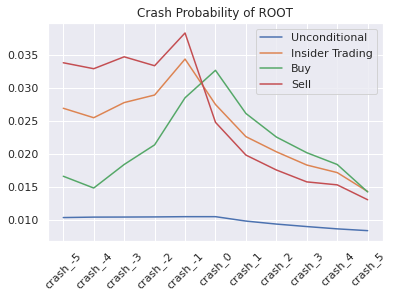

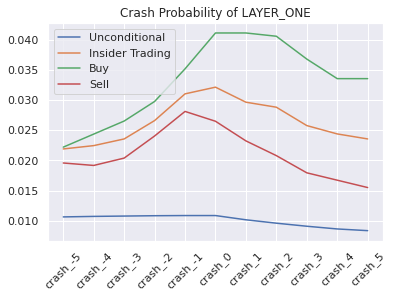

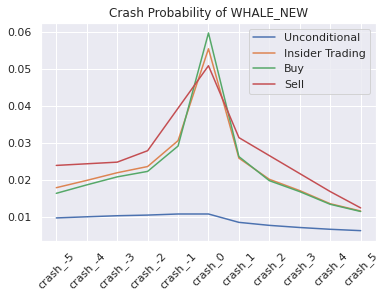

In [206]:
accs = ['root', 'layer_one', 'whale_new']
crash_info = [f'crash_{i}' for i in range(-5,6)]

for acc in accs:
    df = pd.read_csv(f'{WD}token_ret_new/lst/panel_crash_new.csv')
    df = df.loc[df['panel'] == acc]
    
    ret_mean = [df[i].mean() for i in crash_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in crash_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in crash_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in crash_info]

    fig, ax = plt.subplots()
    _ = ax.plot(crash_info, ret_mean, label='Unconditional')
    _ = ax.plot(crash_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(crash_info, buy_mean, label='Buy')
    _ = ax.plot(crash_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Crash Probability of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

## Check

date                             contractAddress    chain  \
35212  2021-12-06  0x55e00121241d6870324a8e6dffaabbe2e0359863  binance   

         ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0     ret_1  \
35212  0.165334 -0.1414 -0.059951 -0.169106 -0.232745 -0.110902 -0.456379   

          ret_2     ret_3     ret_4     ret_5  priceUSD panel  \
35212 -0.066227 -0.232753 -0.465075  0.018277  0.251435  root   

       insider_trading  insider_buy  insider_sell  twitter  event_date_-5  \
35212            False        False         False        0              0   

       event_date_-4  event_date_-3  event_date_-2  event_date_-1  \
35212              0              0              0              0   

       event_date_0  event_date_1  event_date_2  event_date_3  event_date_4  \
35212             0             0             0             0             0   

       event_date_5  crash_new  crash_-5  crash_-4  crash_-3  crash_-2  \
35212             0        1.0         1         1         1         1   

       crash_-1  crash_0  crash_1  crash_2  crash_3  crash_4  crash_5  
35212         1        1        1        1        1        1        1

<AxesSubplot:xlabel='date'>

date                             contractAddress     chain  \
159142  2021-09-02  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159143  2021-09-03  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159144  2021-09-04  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159145  2021-09-05  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159146  2021-09-06  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159147  2021-09-07  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159148  2021-09-08  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159149  2021-09-09  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159150  2021-09-10  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159151  2021-09-11  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159152  2021-09-12  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159153  2021-09-13  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159154  2021-09-14  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159155  2021-09-15  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159156  2021-09-16  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159157  2021-09-17  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159158  2021-09-18  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159159  2021-09-19  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159160  2021-09-20  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159161  2021-09-21  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159162  2021-09-22  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159163  2021-09-23  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159164  2021-09-24  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159165  2021-09-25  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159166  2021-09-26  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159167  2021-09-27  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159168  2021-09-28  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159169  2021-09-29  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159170  2021-09-30  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159171  2021-10-01  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159172  2021-10-02  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159173  2021-10-03  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159174  2021-10-04  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159175  2021-10-05  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159176  2021-10-06  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159177  2021-10-07  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159178  2021-10-08  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159179  2021-10-09  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159180  2021-10-10  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159181  2021-10-11  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159182  2021-10-12  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159183  2021-10-13  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159184  2021-10-14  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159185  2021-10-15  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159186  2021-10-16  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159187  2021-10-17  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159188  2021-10-18  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159189  2021-10-19  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159190  2021-10-20  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159191  2021-10-21  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159192  2021-10-22  0x29699C8485302cd2857043FaB8bd885bA08Cf268  ethereum   
159193  2021-10-23  0x29699C8485302cd2857043FaB8bd885bA08Cf268

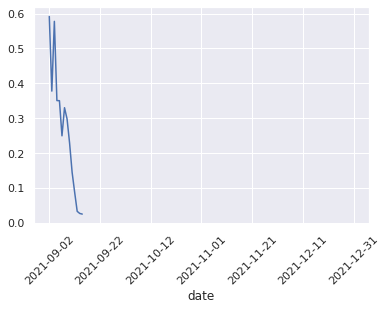

In [213]:
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_crash_new.csv')
pd.set_option('display.max_rows', None)
df.loc[df['crash_0'] == 1].sample(1)
df.loc[(df['contractAddress'] == '0x29699C8485302cd2857043FaB8bd885bA08Cf268')&(df['chain'] == 'ethereum')&(df['panel'] == 'whale_new')].set_index('date')['priceUSD'].plot(rot=45)
df.loc[(df['contractAddress'] == '0x29699C8485302cd2857043FaB8bd885bA08Cf268')&(df['chain'] == 'ethereum')&(df['panel'] == 'whale_new')]
# df.to_csv(f'{WD}token_ret_new/lst/panel_crash_new_modified.csv', index=False)

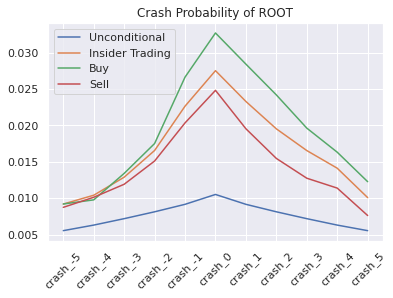

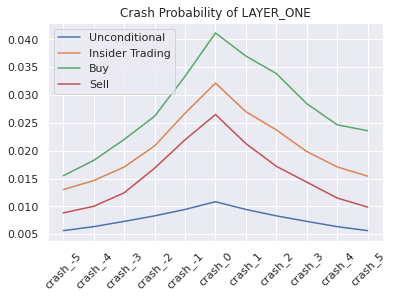

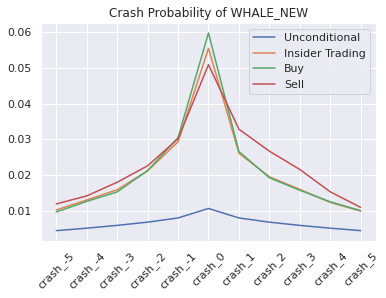

In [187]:
accs = ['root', 'layer_one', 'whale_new']
crash_info = [f'crash_{i}' for i in range(-5,6)]

for acc in accs:
    df = pd.read_csv(f'{WD}token_ret_new/lst/panel_crash_new_modified.csv')
    df = df.loc[df['panel'] == acc]
    
    ret_mean = [df[i].mean() for i in crash_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in crash_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in crash_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in crash_info]

    fig, ax = plt.subplots()
    _ = ax.plot(crash_info, ret_mean, label='Unconditional')
    _ = ax.plot(crash_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(crash_info, buy_mean, label='Buy')
    _ = ax.plot(crash_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Crash Probability of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

## Example

<AxesSubplot:xlabel='date'>

-0.40597202801888943

-0.2817233071263869

-0.2857539166311727

-0.2857539166311727

-0.2857539166311727

-0.34207124165165476

-0.34207124165165476

-0.41883507926062186

-0.41883507926062186

-0.41883507926062186

-0.3823777499208402

-0.35374138255141346

-0.3058387196026489

-0.3058387196026489

-0.3058387196026489

-0.3476672158800076

-0.3476672158800076

-0.3325693561337898

-0.3325693561337898

-0.43560204147184506

-0.4998939318012019

-0.4998939318012019

-0.4998939318012019

-0.4998939318012019

-0.39856971628051646

-0.3788388072681592

0.0

0.0

-0.14841281824520583

-0.18431347434173542

-0.18431347434173542

0.0

0.0

0.0

-0.03438746852350329

0.0

-0.024321031906629483

-0.08095898032830903

0.0

0.0

0.0

0.0

0.0

0.0

0.0

-0.22577623014099643

-0.4529338063008267

-0.4529338063008267

-0.4529338063008267

-0.4529338063008267

-0.4529338063008267

-0.4529338063008267

-0.4529338063008267

-0.4529338063008267

-0.4529338063008267

-0.4529338063008267

-0.4529338063008267

-0.4529338063008267

-0.4529338063008267

0.0

0.0

0.0

0.0

-0.08363327492789055

-0.27726584223591244

-0.3278943001760998

-0.4130619035062322

-0.4130619035062322

-0.4130619035062322

-0.4902502736078524

-0.4902502736078524

-0.4902502736078524

-0.4902502736078524

-0.4902502736078524

-0.4902502736078524

-0.4902502736078524

-0.5050646051765103

-0.5444387920947875

-0.5028614686228768

-0.6226388827516333

-0.6806543476589478

-0.6806543476589478

-0.8068899974845943

-0.7989890462357258

-0.7965594710855716

-0.7969328204083672

-0.7969328204083672

-0.8090349040280345

-0.8175741698942289

-0.7986019781740464

-0.7941353985714837

-0.8255941482908136

-0.8712366814813718

-0.8712366814813718

-0.756798648052322

-0.715252332286881

-0.715252332286881

-0.5698348061352894

-0.5698348061352894

-0.5698348061352894

-0.5105154010638424

-0.5105154010638424

-0.4697428631841542

-0.4697428631841542

-0.4697428631841542

-0.5031028118151031

-0.5291384628690708

-0.5291384628690708

-0.6231416959715378

-0.6231416959715378

-0.5730943421149737

-0.5346746239628741

-0.5832467236079268

-0.6243924568366545

-0.6243924568366545

-0.5418999833989038

-0.5418999833989038

-0.5418999833989038

-0.4948827452869812

-0.44988165012573406

-0.5106242516839524

-0.5296567082704501

-0.5296567082704501

-0.4175989780448067

-0.4175989780448067

0.0

-0.21812758791707257

-0.46150985155956736

-0.46150985155956736

-0.46150985155956736

-0.49165835759484244

-0.5025858873710009

-0.5735463136411513

-0.5735463136411513

-0.5735463136411513

-0.6044240141084947

-0.6183406486482248

-0.6728095699347383

-0.7127180411388053

-0.7127180411388053

-0.7127180411388053

-0.6325718180849117

-0.5484762097288832

-0.6019672198700259

-0.5425627415159108

-0.5425627415159108

-0.5425627415159108

-0.5425627415159108

-0.5425627415159108

-0.5579340761538397

-0.397901233185838

-0.397901233185838

-0.397901233185838

-0.397901233185838

-0.397901233185838

-0.4514806834066446

-0.3559857521396422

-0.3559857521396422

-0.3559857521396422

-0.3559857521396422

0.0

-0.1195374744474888

-0.1195374744474888

-0.20514851440211648

-0.33875274855676174

-0.33905343189552006

-0.37002475482339786

-0.40497444680776484

-0.40497444680776484

-0.40497444680776484

-0.4806350859861362

-0.4806350859861362

-0.4806350859861362

-0.4806350859861362

-0.4883852065623708

-0.4883852065623708

-0.4573520803849446

-0.530640107349895

-0.4507644231650495

-0.42870221311048895

-0.460703488438309

-0.460703488438309

-0.460703488438309

-0.460703488438309

-0.3778849470771102

-0.3778849470771102

-0.3778849470771102

-0.32260449886608517

-0.3438597461011259

-0.32167307592815175

-0.32167307592815175

-0.30055929494735184

-0.195125683457186

-0.195125683457186

-0.195125683457186

-0.195125683457186

-0.195125683457186

-0.195125683457186

-0.195125683457186

-0.20036292729156266

-0.17356798029127607

-0.2036749071633081

-0.18791509102084186

-0.17003377148005316

-0.17003377148005316

-0.17003377148005316

-0.1593880103805958

-0.1593880103805958

0.0

0.0

0.0

0.0

-0.007693417665766642

-0.037850177267874346

-0.0691753388121279

-0.0919287134709179

-0.19285149982374136

-0.19285149982374136

-0.19285149982374136

-0.19285149982374136

-0.19285149982374136

-0.19285149982374136

-0.19285149982374136

-0.19285149982374136

-0.19285149982374136

-0.19285149982374136

-0.19285149982374136

-0.11554454380979665

-0.11554454380979665

-0.11554454380979665

-0.11554454380979665

-0.11554454380979665

0.0

0.0

-0.010485020065926994

-0.010485020065926994

-0.048662013881025826

0.0

-0.22848946811671944

-0.22848946811671944

-0.22848946811671944

-0.2636433885104032

-0.2636433885104032

-0.2636433885104032

-0.2636433885104032

-0.2636433885104032

-0.2636433885104032

-0.2636433885104032

-0.2636433885104032

-0.32195732019767104

-0.32735800637894974

-0.4959978766734556

-0.4959978766734556

-0.4655585265483757

-0.5118200647947031

-0.5118200647947031

-0.5118200647947031

-0.5118200647947031

-0.5118200647947031

-0.5118200647947031

-0.5227973190910752

-0.5227973190910752

-0.4821292973931913

-0.4917778255848072

-0.44229689544887557

-0.4378190610606433

-0.27892254388136617

-0.27892254388136617

-0.3179928619915688

-0.3332801785684424

-0.3332801785684424

-0.3332801785684424

-0.3332801785684424

-0.279560797384396

-0.24577239118014338

-0.09567332745454768

-0.1310542242185464

-0.2247470451025003

-0.2247470451025003

-0.2247470451025003

-0.2247470451025003

-0.2247470451025003

0.0

-0.07770665342101309

-0.14183062729775428

-0.14183062729775428

-0.27307462184412307

-0.27900396201230326

-0.27900396201230326

-0.29872449270450246

-0.29872449270450246

-0.37626127625084443

-0.37626127625084443

-0.37626127625084443

-0.37626127625084443

-0.37626127625084443

-0.37626127625084443

-0.37626127625084443

-0.32370896302921837

-0.28806822120177816

-0.28806822120177816

-0.10688899769971988

-0.1453316339729537

-0.19127006231978957

-0.19127006231978957

-0.19127006231978957

-0.19127006231978957

-0.28817023022437993

-0.28817023022437993

-0.30709242040776236

-0.30709242040776236

-0.30709242040776236

-0.30709242040776236

-0.30709242040776236

-0.2964533089923536

-0.3315426429335647

-0.29270368651307865

-0.28332239860223585

-0.28332239860223585

-0.28332239860223585

-0.28332239860223585

-0.2631751564415616

0.0

-0.02569912588338597

-0.07967558977981985

-0.07967558977981985

0.0

0.0

-0.09116568153182901

-0.1064026754909625

0.0

0.0

0.0

-0.04226393343560458

-0.2517100772482704

-0.29593338387540097

-0.29593338387540097

-0.29593338387540097

-0.29593338387540097

-0.29593338387540097

-0.29593338387540097

-0.29593338387540097

-0.29593338387540097

-0.30640751741082856

-0.30640751741082856

-0.30640751741082856

-0.30640751741082856

-0.30640751741082856

-0.2757999757937107

-0.17262837264841022

-0.20092478837139674

-0.23251209199882208

-0.23251209199882208

-0.3172213078974629

-0.3578066230538125

-0.2888928209154957

-0.2888928209154957

-0.2888928209154957

-0.2697888024060006

-0.2697888024060006

-0.25394889975219337

-0.25394889975219337

-0.25394889975219337

-0.23852829986946156

-0.22482802616733424

-0.19632924710888391

-0.08060045749321189

-0.08060045749321189

-0.08060045749321189

-0.08060045749321189

-0.08060045749321189

-0.08060045749321189

-0.08060045749321189

-0.08060045749321189

-0.07639625543034759

0.0

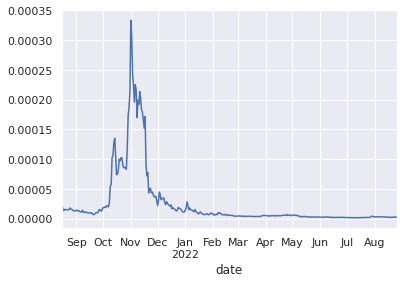

In [110]:
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_end.csv')
df['date'] = pd.to_datetime(df['date'])

contractAddress = '0x24e89bdf2f65326b94e36978a7edeac63623dafa'
chain = 'ethereum'
csv = df.drop_duplicates(['contractAddress', 'chain', 'date'])
csv.sort_values('date', ascending=True, inplace=True)

token = csv.loc[(csv['contractAddress'] == contractAddress)&(csv['chain'] == chain)]
token.set_index('date')['priceUSD'].plot()

# date = pd.to_datetime('2021-08-18')
# span = token.loc[(token['date']>= date)&(token['date'] <= (date + datetime.timedelta(days=15)))]
# span.shape[0]
# peak_price = span['priceUSD'].max()
# peak_date = span.loc[span['priceUSD'] == peak_price, 'date'].values[0]
# trough_price = span.loc[span['date'] >= peak_date, 'priceUSD'].min()

# span
# peak_price
# peak_date
# trough_price
# np.log(trough_price/peak_price)

for idx, row in token.iterrows():
    date = row['date']
    span = token.loc[(token['date']>= date)&(token['date'] <= (date + datetime.timedelta(days=15)))]
    peak_price = span['priceUSD'].max()
    peak_date = span.loc[span['priceUSD'] == peak_price, 'date'].values[0]
    trough_price = span.loc[span['date'] >= peak_date, 'priceUSD'].min()
    (trough_price - peak_price)/peak_price
    
    if (trough_price - peak_price)/peak_price <= -0.90: 
        print(f'{date} is a crash')
        span
        peak_price
        peak_date
        trough_price
        np.log(trough_price/peak_price)
        fig, ax = plt.subplots()
        _ = ax.plot(span['date'].values, span['priceUSD'].values)
        plt.show()


# Transactions in Crash Date

## Price Impact

### Example

In [42]:
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_crash_old.csv')
df.loc[(df['crash_0'] == 1)&(df['panel'] == 'root'), 'chain'].value_counts()
df.loc[(df['crash_0'] == 1)&(df['panel'] == 'root')&(df['chain']!='binance')].sample(1)

binance      110
ethereum      53
avalanche     11
fantom         7
Name: chain, dtype: int64

date                             contractAddress     chain  \
24083  2022-02-08  0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4  ethereum   

       ret_-5  ret_-4    ret_-3    ret_-2    ret_-1     ret_0    ret_1  \
24083     NaN     NaN  2.832361  0.036031  0.163096 -3.033312  0.27629   

          ret_2  ret_3  ret_4  ret_5  priceUSD panel  insider_trading  \
24083  0.026499    NaN    NaN    NaN   0.00008  root             True   

       insider_buy  insider_sell  twitter  event_date_-5  event_date_-4  \
24083        False          True        2              0              0   

       event_date_-3  event_date_-2  event_date_-1  event_date_0  \
24083              0              0              0             0   

       event_date_1  event_date_2  event_date_3  event_date_4  event_date_5  \
24083             0             0             0             0             0   

       crash_new  crash_-5  crash_-4  crash_-3  crash_-2  crash_-1  crash_0  \
24083        0.0         0         0         0         0         0        1   

       crash_1  crash_2  crash_3  crash_4  crash_5  
24083        0        0        0        0        0

In [56]:
it

Unnamed: 0     amountUSD  \
0          1182.0   4707.722246   
1          1183.0  32399.939227   
2          1184.0    600.619450   
3          1185.0   3999.617325   
4            38.0   7478.974558   
...           ...           ...   
65113         NaN      0.775582   
65114         NaN      2.587290   
65115         NaN      0.000686   
65116         NaN      0.000343   
65117         NaN      0.001145   

                                                                          id  \
0       0x1abac089b4463e0fb0d10d24e720200f73bb7b7e3e2a8f8ab0d934a1fe8fcebe-0   
1       0x4394130f762c7ab53db85c7923d50f1e3c8a89119d5f925bc1f85c36dc1c39b3-0   
2       0x4c3b5bb809cf918f1cffd9b108fb5e5e9cef56ab2df62231f8183cc3878e9329-0   
3       0x5cf8c5b551ebf803e688d931de1065d46790786a81569ceffa8fb7f90c0f1cc5-0   
4      0x63dcb02114a962bbb82a1fb50f1f8ea27aaf4637fcbce5f7219753ed8b580e12#83   
...                                                                      ...   
65113   0xe1661fe13538d72478591857761e831ea3893e9fa50a7af4e2039e276706dc98-2   
65114   0xe1661fe13538d72478591857761e831ea3893e9fa50a7af4e2039e276706dc98-3   
65115   0xe349a985d189cf49037a4a7c46826d877f4c7493ff802a3d96b37b9ea5058866-0   
65116   0xe349a985d189cf49037a4a7c46826d877f4c7493ff802a3d96b37b9ea5058866-2   
65117   0xe349a985d189cf49037a4a7c46826d877f4c7493ff802a3d96b37b9ea5058866-3   

       logIndex                                      origin  \
0             8                                         NaN   
1             8                                         NaN   
2           517                                         NaN   
3             8                                         NaN   
4            48  0x83da32c690afc12b08621cdae37268eeda4a964c   
...         ...                                         ...   
65113       231                                         NaN   
65114       248                                         NaN   
65115       175                                         NaN   
65116       185                                         NaN   
65117       202                                         NaN   

                                        recipient  \
0                                             NaN   
1                                             NaN   
2                                             NaN   
3                                             NaN   
4      0xe592427a0aece92de3edee1f18e0157c05861564   
...                                           ...   
65113                                         NaN   
65114                                         NaN   
65115                                         NaN   
65116                                         NaN   
65117                                         NaN   

                                           sender               sqrtPriceX96  \
0      0x7a250d5630b4cf539739df2c5dacb4c659f2488d                        NaN   
1      0x7a250d5630b4cf539739df2c5dacb4c659f2488d                        NaN   
2      0x7a250d5630b4cf539739df2c5dacb4c659f2488d                        NaN   
3      0x7a250d5630b4cf539739df2c5dacb4c659f2488d                        NaN   
4      0xe592427a0aece92de3edee1f18e0157c05861564  5753880147597764424946029   
...                                           ...                        ...   
65113  0x325e343f1de602396e256b67efd1f61c3a6b38bd                        NaN   
65114  0x325e343f1de602396e256b67efd1f61c3a6b38bd                        NaN   
65115  0x325e343f1de602396e256b67efd1f61c3a6b38bd                        NaN   
65116  0x325e343f1de602396e256b67efd1f61c3a6b38bd                        NaN   
65117  0x325e343f1de602396e256b67efd1f61c3a6b38bd                        NaN   

           tick            timestamp  token0_name    token1_name  \
0           NaN  2021-08-16 15:23:20   Tiger King  Wrapped Ether   
1           NaN  2021-08-16 20:16:13   Tiger King  Wrapped Ether   
2           NaN  2021-08-16 20:17:25   Tiger King  Wrapped Ether  

In [78]:
its['dex'].values
{i for i in its['dex'].values}
{i for i in its.loc[its['dex'] == dex, 'panels'].values}

array(['uniswapv2_ethereum', 'uniswapv2_ethereum', 'uniswapv2_ethereum'],
      dtype=object)

{'uniswapv2_ethereum'}

{'root', 'whale_new'}

In [117]:
pd.set_option('display.max_rows', None)
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_crash_old.csv')
it = pd.read_csv(f'{WD}/daily_transaction/list/panel.csv')
# df.loc[(df['crash_0'] == 1)&(df['insider_trading'] == True)&(df['contractAddress'] == '0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4')&(df['chain'] == 'ethereum')]
crashes = df.loc[(df['crash_0'] == 1)&(df['insider_trading'] == True)&(df['contractAddress'] == '0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4')&(df['chain'] == 'ethereum')]
ret_0 = crashes['ret_0'].values[0]

# ret_0 # Check Return_0 

for _, row_crashes in crashes.drop_duplicates('date').iterrows():
    contractAddress = row_crashes['contractAddress']
    contractAddress_lower = contractAddress.lower()
    contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)
    chain = row_crashes['chain']
    date = row_crashes['date']
    panel = row_crashes['panel']
    its = it.loc[((it['contractAddress'] == contractAddress_lower)&(it['date'] == date))|
                 ((it['contractAddress'] == contractAddress_upper)&(it['date'] == date))]
    dexes = {i for i in its['dex'].values}
    for dex in dexes:
        dex_num = 0
        lst = pd.read_csv(f'{WD}daily_transaction/list/{dex}.csv')
        status = lst.loc[(lst['contractaddress'] == contractAddress_lower)&(lst['date'] == date), 'status'].values[0]
        if status != -1:
            
            # Dex have data, not pancakeswap_binance.
            
            dex_num += 1
            t = pd.read_csv(f'{WD}daily_transaction/csv/{contractAddress_lower}_{date}_{dex}.csv')
            roles = {i for i in its.loc[its['dex'] == dex, 'panels'].values}
            for role in roles:
                priceImpacts = 0
                for _, row_its in its.loc[(its['dex'] == dex)&(its['panels'] == role)].iterrows():
                    # row_its
                    ID = row_its['id']
                    timestamp = row_its['timestamp']
                    token0_id = row_its['token0_id']
                    token1_id = row_its['token1_id']
                    amountUSD = row_its['amountUSD']
                    amount0Out = row_its['amount0Out']
                    amount0In = row_its['amount0In']
                    amount1Out = row_its['amount1Out']
                    amount1In = row_its['amount1In']
                    
                    if (token0_id == contractAddress_lower)|(token0_id == contractAddress_upper): tokenPrice = amountUSD / np.abs(amount0Out - amount0In)
                    else: tokenPrice = amountUSD / np.abs(amount1Out - amount1In)
                    
                    t.sort_values('timestamp', ascending=True, inplace=True)
                    last = t.loc[(t['timestamp'] < timestamp)].tail(1)
                    
                    # If the insider trading is the first transaction
                    
                    if len(last) != 0:
                        token0_id_last = last['token0_id'].values[0]
                        token1_id_last = last['token1_id'].values[0]
                        amountUSD_last = last['amountUSD'].values[0]
                        amount0Out_last = last['amount0Out'].values[0]
                        amount0In_last = last['amount0In'].values[0]
                        amount1Out_last = last['amount1Out'].values[0]
                        amount1In_last = last['amount1In'].values[0]

                        if (token0_id_last == contractAddress_lower)|(token0_id_last == contractAddress_upper): tokenPrice_last = amountUSD_last / np.abs(amount0Out_last - amount0In_last)
                        else: tokenPrice_last = amountUSD_last / np.abs(amount1Out_last - amount1In_last)

                    else:
                        
                        # If the priceUSD is nan, just leave it error
                        
                        date_last = (pd.to_datetime(date) - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
                        tokenPrice_last = df.loc[(df['date'] == date_last)&(df['contractAddress'] == contractAddress), 'priceUSD'].values[0]
                        tokenPrice_last, tokenPrice # Check price change
                        
                    priceImpact = (np.log(tokenPrice) - np.log(tokenPrice_last)) / ret_0
                    priceImpacts += priceImpact    
                        
                priceImpacts # Show Price Impacts
        else:
            print(f'{dex} have no daily transaction info')
            continue
            
        if dex_num == 0:
            continue
        else:
            
            # Insert record here
            
            avg_priceImpacts = priceImpacts / dex_num
            avg_priceImpacts

0.19386924571105452

(0.0016520784468856, 0.0016923768399386098)

-0.00794504281921562

-0.00794504281921562

<AxesSubplot:xlabel='date'>

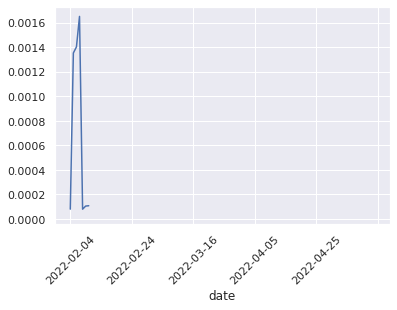

In [44]:
df.loc[(df['contractAddress'] == '0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4')&(df['chain'] == 'ethereum')&(df['panel'] == 'root')].set_index('date')['priceUSD'].plot(rot=45)